# Import

In [3]:
import pandas as pd
import os.path
from core.util.math import compute_ft

import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime
import copy as cp
from enum import Enum
from scipy.linalg import sqrtm
import scipy.interpolate

from user_scripts.Timo.own.console_toolkit import Tk_file, Tk_string
from logic.pulsed.predefined_generate_methods.multi_nv_methods import DQTAltModes, TomoRotations, TomoInit

import logging
logging.basicConfig(filename='logfile.log', filemode='w', level=logging.DEBUG)
logger = logging.getLogger(__name__)

os.getcwd()


'C:\\Users\\Setup3-PC\\Desktop\\qudi'

In [5]:
from matplotlib.colors import LinearSegmentedColormap


common_params = {'data_path': r"E:\Data", #r"E:\Data_Paper_DNV",
                 'copy_2_path':  r'E:\Timo\Data_Paper_DNV', #'', #
                 
                 'tau1_2q': 800e-9,
                 'tau2_zz': 271.1e-9,   # deer calib @ Rabi= 22.98 MHz (settings close to EPC mes), 20231202-1131-45
                 'xy8_order_2q': 1,
                 't_rabi_opt': 42e-9,
                 't2_xy8': [476e-6, 454e-6],
                 # GPC: labbook 12.9.23
                 'rb_gpc': {'cx': 1.8, '1q': 10.53},   # total 1qs, not per qubit
                 'rb_2q_nocnot_gpc': {'1q': 11.51},
                 'rb_1q_gpc': {'1q': 1.969}
}




# Paper
default_params = {'legend.fontsize': 6,
          'figure.figsize': (3.5, 3.5*2./3.),   # standard 1 colum Nature fig
         'axes.labelsize': 8,
         'axes.titlesize':'xx-large',
         'xtick.labelsize':8,
         'ytick.labelsize':8,
         'lines.markeredgewidth':0,
         #'lines.linewidth': 2,
         'errorbar.capsize': 2.5,
         'xtick.minor.visible': True,
         'figure.dpi': 300,
         'savefig.dpi': 300}

# Slides
"""
default_params = {'legend.fontsize': 6,
          'figure.figsize': (4, 4*2./3.),   # standard 1 colum Nature fig
         'axes.labelsize': 10,
         'axes.titlesize':'xx-large',
         'xtick.labelsize':10,
         'ytick.labelsize':10,
         'lines.markeredgewidth':0,
         #'lines.linewidth': 2,
         'errorbar.capsize': 5}
"""
plt.rcParams.update(default_params)

class CommonPlt(object):
    def __init__(self):
        self.perform_save = True
        self.save_csv = True
        
        self.save_extension = 'svg'
        self._savepath =  r"C:\Users\Setup3-PC\Desktop\_poster_figs\\"
        self._cmap_n_bins= [5,100]
    
    def _save_fig_data(self, fig, name):
        axs = fig.get_axes()

        data = []
        for ax in axs:
            lines = ax.get_lines()
            scatters = ax.collections
            d = [{'x': l.get_xdata(), 'y': l.get_ydata(), 'label': l.get_label()} for l in lines]
            data.extend(d)
            
            # scatter plots
            d = [{'x': s.get_offsets()[:,0], 'y':s.get_offsets()[:,1], 'label': s.get_label()} for s in scatters]
            data.extend(d)
            
        fname = plt_settings.get_savepath(name, extension='csv')
        df = pd.DataFrame(data)
        df.to_csv(fname)
        logger.debug(f"Saved fig data to: {fname}")

    
    def savefig(self, name, save_csv=None, frame_left_inch=2*0.35, frame_bottom_inch=2.5*0.22, 
                frame_top_inch=None, frame_right_inch=None):
        
        if save_csv is None:
            save_csv = self.save_csv
        
        fig = plt.gcf()
        fig_size = fig.get_size_inches()
        
        # make the frame size fixed in inches
        # specify relative to figsize in function
        
        left_rel = frame_left_inch/fig_size[0]
        if frame_right_inch is None:
            right_rel = 1.2*(1 - left_rel)
        else:
            right_rel = 1 - (frame_right_inch/fig_size[0])

        bottom_rel = frame_bottom_inch/fig_size[1]
        if frame_top_inch is None:
            top_rel = 1.1*(1 - bottom_rel)
        else:
            top_rel = 1 - (frame_top_inch/fig_size[1])

        plt.subplots_adjust(left=left_rel, right=right_rel,
                            top=top_rel, bottom=bottom_rel)

        # overwrite tight_layout parameters and save with a fixed frame
        if save_csv:
            self._save_fig_data(fig, name)
        plt.savefig(plt_settings.get_savepath(name))

    def get_markersize(self, size='medium', is_scatter=False, rel_to_fig=True):
        # https://stackoverflow.com/questions/14827650/pyplot-scatter-plot-marker-size
        size_dict = {'small':2, 's-medium':4, 'medium': 5, 'big': 7}
        
        scale_fac = 1
        if rel_to_fig:
            fig = plt.gcf()
            fig_size = fig.get_size_inches()
            fig_size_default = plt.rcParams['figure.figsize']
            
            idx = np.argmax(np.abs(fig_size/fig_size_default - 1))
            scale_fac = (fig_size/fig_size_default)[idx]
        
        if is_scatter:
            return (scale_fac*size_dict[size])**2
        
        return scale_fac*size_dict[size]
        
    def get_savepath(self, fname, extension=None):
        
        fname = fname.replace(".png","").replace(".svg","svg")
        if extension is None:
            extension = self.save_extension
        
        if not self.perform_save:
            return ""
        return self._savepath + fname + "." + extension
    
    def get_cmap(self, continuous=True):
        cmaps = self._create_cmap()
        cmap = None
        
        for key, val in cmaps.items():
            if continuous:
                if not 'cont' in key:
                    continue
            else:
                 if 'cont' in key:
                    continue
            cmap = val
        
        return cmap
    
    def color(self, colorstr=None, alpha=1):
        color_map = {'blue':0, 'bluelight':1, 'red':4, 'green':2, 'orange':3}
        if colorstr is not None:
            if colorstr == 'grey':
                # handle grey outside of color cycle, #a9a28dff
                return tuple([0.6627, 0.63529, 0.5529, alpha])
            if colorstr not in color_map.keys():
                raise ValueError
            else:
                color = self.get_cmap(False)(color_map[colorstr])

                color_alpha = list(color)[0:3]
                color_alpha.append(alpha)
                
                return tuple(color_alpha)
            
    def marker_style(self, color, is_scatter=False, is_err=False, size='medium'):
        marker_style = dict(marker='o',
                            color=color,
              )
        
        err_style = dict(capthick=1, elinewidth=1, capsize=1.5)
        
        
        if is_scatter:
              marker_style = {**dict(s=plt_settings.get_markersize(is_scatter=True, size=size),
                                    facecolor=color,
                                    linewidths=1,
                                    edgecolor='grey'), **marker_style}
            
        elif not is_scatter and not is_err:
             marker_style = {**dict(markersize=plt_settings.get_markersize(is_scatter=False, size=size),
                                    markerfacecolor=color,
                                    markeredgewidth=1,
                                    markeredgecolor='grey',
                                    linestyle=''), **marker_style}
        
        elif is_err:
             marker_style.update(err_style)
        else:
            raise ValueError
        
        return marker_style
    
    def _create_cmap(self):
        colors_uulm = ['#26547c', '#7d9aaa', '#56aa1c', '#df6d07', '#a32638']#, '#a9a28d'] 
        n_bins = self._cmap_n_bins  # Discretizes the interpolation into bins

        cmap_name = ['uulm_5', 'uulm_cont']
        idx = 0
        
        cmaps = {}
        for n_bin in n_bins:
            # Create the colormap
            cmap = LinearSegmentedColormap.from_list(cmap_name[idx], colors_uulm, N=n_bin)
            cmaps[cmap_name[idx]] = cmap
            idx += 1
            
        return cmaps        
    

    
plt_settings = CommonPlt()
try:
    plt_settings.get_cmap(False)
    #plt_settings.get_cmap(False)

    #plt_settings._create_cmap()['uulm_cont']
    plt_settings.color('red')


    a = plt_settings.get_markersize(size='medium', is_scatter=False)
    a = plt_settings.marker_style('blue', is_err=True)
except:
    logger.exception("")
    
plt_settings.get_cmap(False)(100)
plt.rcParams['figure.figsize']

[3.5, 2.3333333333333335]

In [11]:
plt_settings.get_savepath('odmr.png', extension='csv')

'C:\\Users\\Timo\\Desktop\\_paper_figs\\\\odmr.csv'

In [14]:
try:
    plt_settings.get_markersize(size='medium', is_scatter=False)
except:
    logger.exception("")

In [17]:
n_bins = [5, 100]

x = np.arange(0, np.pi, 0.1)
y = np.arange(0, 2 * np.pi, 0.1)
X, Y = np.meshgrid(x, y)
Z = np.cos(X) * np.sin(Y) * 10

cmap_name = ['uulm_5', 'uulm_cont']
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.05)

idx = 0
for n_bin, ax in zip(n_bins, axs.flat):
    # Create the colormap
    cmap = plt_settings.get_cmap(idx%2)
    # Fewer bins will result in "coarser" colomap interpolation
    im = ax.imshow(Z, origin='lower', cmap=cmap)
    ax.set_title("N bins: %s" % plt_settings._cmap_n_bins[idx])
    fig.colorbar(im, ax=ax)
    idx += 1

plt.tight_layout()
plt.show()

# Library

In [7]:
import lmfit
from scipy.interpolate import UnivariateSpline
import shutil
from pathlib import Path   
import pandas as pd
import difflib

def copy_to_path(fname, do_copy=None, target_path=None):
    if target_path is None:
        target_path = common_params['copy_2_path']  
    
    if do_copy is None:
        do_copy = False
        if target_path:
            do_copy = True
    
    path = Path(fname)
    if path.is_file():
        folder_file = os.path.dirname(fname)
    elif path.is_dir():
        folder_file = os.path.abspath(fname)
    else:
        raise ValeuError(f"Must give path to file or directory, not: {fname}")
        
    orig_path = common_params['data_path']
    folder_target = folder_file.replace(orig_path, target_path)
    
    logger.debug(f"Creating copy of data: {folder_file} -> {folder_target}")
    
    if do_copy:
        if os.path.exists(folder_target):
            shutil.rmtree(folder_target)
        shutil.copytree(folder_file, folder_target)

    return do_copy

"""
def copy_to_path(fname, do_copy=None, target_path=None):
    if target_path is None:
        target_path = common_params['copy_2_path']  
    
    if do_copy is None:
        do_copy = False
        if target_path:
            do_copy = True
        
    folder_file = os.path.dirname(fname)
    orig_path = common_params['data_path']
    folder_target = folder_file.replace(orig_path, target_path)
    
    logger.debug(f"Creating copy of data: {folder_file} -> {folder_target}")
    
    if do_copy:
        if os.path.exists(folder_target):
            shutil.rmtree(folder_target)
        shutil.copytree(folder_file, folder_target)

    return do_copy
"""


def _norm_sim_2_exp(y, rb_y0=None, orig_range=[0,1], new_range=[0,1]):
    #return y
    y = cp.copy(y)
    
    if rb_y0 is None:
        rb_y0 = 0.7   # eg. explainable by charge state

    interp_func = scipy.interpolate.interp1d(orig_range, new_range,
                                             kind='linear', fill_value='extrapolate')
    
    y = interp_func(y)
    # can't norm every sim to max of exp
    #y = y - 0.42
    #y = y/np.max(y) # norm to 1
    #y = y*y_max_60g # align with max of exp data
    #return y
    return rb_y0*y #- 0.2 #0.9*y - 0.3



def coherence_epc_limit_simple(t_gate_1q, t_gate_2q, gpc, t2):
    # qiskit coherence_limit uses a not well documented estimation
    # that might be related to arxiv:2007.02925, arxiv: 2302.10881
    
    # here, we just calculate the single T2 exponential decay over the gate_length
    # open question, which T2 to use for 1q gates. But contribution is very small at high Rabi anyway



    p_1q = np.exp(-t_gate_1q/t2)
    p_2q = np.exp(-t_gate_2q/t2)

    p_tot = p_1q**gpc['1q'] * p_2q**gpc['cx']

    epc_tot = 1-p_tot

    return epc_tot

def coherence_epg_limit_simple(t_gate, t2):
    return coherence_epc_limit_simple(t_gate, 0, {'cx':0, '1q':1}, t2)


def plot_multiple_1d(p_raw, n_datas=1, plot_err=False, plot_mode='delta',
                     scale_fac_x=1, scale_fac_y=1, color=None, offset=0, marker_size='medium',
                    smooth_data=False, marker_style=None, alpha=None, alpha_line=0.9):
    #"""
    plot_data = []
    #plt.figure(figsize=(6,4))
    
    
    try:
        for i, mes in enumerate(p_raw):

            x_i = scale_fac_x*np.asarray(mes['data']['tau'])
            y_i = offset*i +  scale_fac_y*np.asarray(get_z(mes, mode=plot_mode)[0])
            if plot_err:
                dy_i =   scale_fac_y*np.asarray(get_z(mes, mode=plot_mode)[1])
            
            #logger.info(f"{y_i}")
            
            poi_id = mes['file']#.split('nv_')[2].split("\\")[0]
            poi_id = int(not(i))

            # colormap
            #color=None
            #color = plt.cm.plasma(i/len(p_raw))
            if color is None:
                color_i = plt_settings.get_cmap(False)(int((i)/(len(p_raw)*n_datas)))
            else:
                color_i = color
            
            #if alpha is None:
            #    alpha = 0.8
            if marker_style is None:
                marker_style_i = plt_settings.marker_style(color_i, is_scatter=True, size=marker_size)
            else:
                 marker_style_i = marker_style[i]
            marker_err_style = plt_settings.marker_style(color_i, is_scatter=False, is_err=True, size=marker_size)   

            label = None
            plot_options = mes.get('plot_options')
            if plot_options:
                label = plot_options.get('label')
            if label is None:
                label= f"{mes['exp_params']['savetag']}"
            #label = f"control= |{poi_id}>"
            #label = f"read_phase= {mes['exp_params']['read_phase']:.1f}"

            plt.scatter(x_i, y_i, label=label, alpha=alpha, zorder=10, **marker_style_i)
            if plot_err:
                plt.errorbar(x_i, y_i, yerr=dy_i, 
                          alpha=0.7, label='_no_legend', 
                          **marker_err_style,
                          markersize=0, linestyle='', zorder=1)

            """
            if dy_i is not None:
                plt.errorbar(x_i, y_i, yerr=dy_i, label='_nolegend_', color=color, marker="", alpha= 0.15)
            else:
                pass
                #plt.plot(x_i, y_i, label='_nolegend_', color=color, marker="", alpha= 0.15)
            """
            if smooth_data:
                zipped = sorted(zip(x_i, y_i), key=lambda x: x[0])  # raw data x sometimes reversed
                x_in, y_in = [s[0] for s in zipped],[s[1] for s in zipped]
                spline = UnivariateSpline(x_in, y_in)
                x_smooth_i = np.linspace(np.min(x_i), np.max(x_i), 500)
                y_smooth_i = spline(x_smooth_i)
                plt.plot(x_smooth_i, y_smooth_i, label='_nolegend_', color=color_i, marker="", alpha= 0.9)

            if 'fit_values' in mes.keys():
                x_fit = scale_fac_x*mes['fit_values']['x']
                y_fit = offset*i+ scale_fac_y*mes['fit_values']['y']
                plt.plot(x_fit, y_fit, label='_nolegend_', color=color_i, marker="",
                         alpha=alpha_line, linewidth=2)

            #plt.xlim([0, 17])
            #plt.ylim([-0.2,0.1])

            plot_data.append([x_i,y_i])

        
        #plt.xlabel("clifford length ()")
        plt.xlabel(r"$t_{evol}$ " + f"({x_unit})")
        plt.ylabel(r'$\sigma_y$')
     
    except:
        logger.exception(f"In mes {p_raw[i]['file']}")
    
    return plot_data


def norm_on_delta(p_data, idx_zref=None, mask_idxs=[]):
    if idx_zref != None:

        p_data = pd.DataFrame(p_data)
        delta = p_data['z1']-p_data['z2']
        ddelta = np.sqrt(p_data['dz1']**2+p_data['dz2']**2)
        z_ref = delta.iloc[idx_zref] 

        y_scale = 1/z_ref

        if len(mask_idxs) != 0:
            mask_idxs = [i if i>=0 else len(p_data)+i for i in mask_idxs]  # handle negative idx
            try:
                p_data = p_data.drop(mask_idxs)
                delta = delta.drop(mask_idxs)
                ddelta = ddelta.drop(mask_idxs)
                logger.debug(f"Dropped norm datapoint z={z_ref}")
            except KeyError: # already dropped before, don't norm again
                p_data['delta'] = delta
                p_data['ddelta'] = ddelta
                logger.warning("Skipping norming, already dopped reference data before.")
                return p_data
                
                
            
        p_data['delta'] = y_scale*delta
        p_data['ddelta'] = y_scale*ddelta
        
    return p_data

def setup_clear_plots(n_plots):
    n_cur = qdplotlogic.number_of_plots
    for i in range(n_cur):
        n_cur_i = qdplotlogic.number_of_plots
        if n_cur_i >= 1:
            # removing without arguments seems buggy
            qdplotlogic.remove_plot(n_cur_i-1)
    
    for i in range(n_plots):
        qdplotlogic.add_plot()
def extract_num_from_path(file):
    fname = os.path.basename(file)
    res = Tk_string.find_num_in_str(fname)
    
    return res

"""
# delete if Tk_file import works
def load_pulsed_result(fname):

    data = pd.read_csv(fname, sep="\t", comment='#', names=["tau", "z1", "z2", "std1", "std2"])
    if pd.isnull(data.iloc[0, -1]):
        data = pd.read_csv(fname, sep="\t", comment='#', names=["tau", "z1", "std1"])
    meta = Tk_file.load_pulsed_metadata(fname)

    mes = {'data': data,
           'file': fname}
    mes = {**mes, **meta}

    return mes
"""
def do_fit(p_mes, fit_y='delta', fit_method='sine', edit_params=None, settings=None):
    fitter = pulsedmeasurementlogic.fc   
    
    if edit_params:
        for ov_param in edit_params:
            
            if ov_param.name in fitter.fit_list[fit_method]['parameters'].keys():
                fitter.fit_list[fit_method]['use_settings'][ov_param.name] = True
                fitter.fit_list[fit_method]['parameters'][ov_param.name] = ov_param
                
                #logger.debug(f"Overwriting fit param {ov_param.name}: {ov_param}")

    fitter.clear_result()
    fitter.set_current_fit(fit_method)
    """
    x_fit, y_fit, result = fitter.do_fit(data[0], data[1])
    result = result.result_str_dict

    result['Position']['value']
    result['FWHM']['value']
    result['Contrast']['value']
    """

    if fit_y == 'delta':
        data = np.asarray(p_mes['data']['tau']), np.asarray(delta_or_z1(p_mes))
    elif fit_y == 'z1':
        data = np.asarray(p_mes['data']['tau']), np.asarray(p_mes['data']['z1'])
    elif fit_y == 'z2':
        data = np.asarray(p_mes['data']['tau']), np.asarray(p_mes['data']['z2'])
    else:
        raise ValueError
    
    #logger.info(f"data({fit_y})= {data}")
    
    x_fit, y_fit, result = fitter.do_fit(data[0], data[1])
    # params [lmfit::Parameters] and derived params [dict]
    # considered in _get_fit()
    
    # get values of fitted model
    model = fitter.fit_list[fit_method]['make_model']()[0]
    
    x_domain = np.asarray(p_mes['data']['tau'])
    x_domain = np.linspace(np.min(x_domain), np.max(x_domain), 1000)
    if settings:
        if 'fit_range' in settings.keys():
            x_domain = settings['fit_range']

    y = model.eval(x=x_domain, params=result.params)
    fit_vals = {'x': x_domain, 
                'y': y}
    
    full_result = {**result.params, **result.result_str_dict}
    p_mes['fit_res'] = full_result
    p_mes['fit_values'] = fit_vals
    
    reset_fitter(fit_method, edit_params)

def reset_fitter(fit_method=None, edit_params=None):
    fitter = pulsedmeasurementlogic.fc   
    
    if edit_params:
        for ov_param in edit_params: 
            if ov_param.name in fitter.fit_list[fit_method]['parameters'].keys():
                fitter.fit_list[fit_method]['use_settings'][ov_param.name] = False   
    
    
def get_z(p_mes, mode='z1'):
    # mode: z1, z2, delta, (+_norm)
    try:
        has_z2 = True
        has_delta = True
        try:
            p_mes['data']['z2']
        except KeyError:
            has_z2 = False
        try:
            delta = p_mes['data']['delta']
            ddelta = p_mes['data']['ddelta']
        except KeyError:
            has_delta = False
            
        tau = p_mes['data']['tau']
        z1 = p_mes['data']['z1']
        z1_norm = z1/np.average(z1)
        dz1 = p_mes['data'].get('std1')

        if mode == 'z1':
            return z1, dz1
        elif mode == 'z1_norm':
            return z1_norm, dz1/z1*z1_norm
        elif mode == 'z2' or mode == 'z2_norm' or mode=='delta' or mode=='delta_norm':
            if has_z2:
                z2 = p_mes['data']['z2']
                dz2 = p_mes['data'].get('std2')
        
                delta = (z1-z2) if not has_delta else delta
                ddelta = np.sqrt(dz1**2+dz2**2) if not has_delta else ddelta
                delta_norm = delta/np.average(z1)
            else:
                raise KeyError
                
            if mode == 'z2':
                return z2, dz2
            if mode == 'z2_norm':
                return z2/np.average(z2), dz2/z2*z2_norm
            if mode == 'delta':
                return delta, ddelta
            if mode == 'delta_norm':
                return delta_norm, np.sqrt(dz1**2+dz2**2)/delta * delta_norm
        else:
            raise ValueError(f"Unknown mode: {mode}")  

    except:
        logger.exception(f"Loading of {mode} from file {p_mes['file']} failed")
        raise  

def delta_or_z1(p_mes, norm=False):
    try:
        
        ret = None
        
        has_delta = True
        try:
            delta = p_mes['data']['delta']
            ret = delta
        except KeyError:
            has_delta = False
        
        has_z2 = True
        try:
            z2 = p_mes['data']['z2']
        except KeyError:
            has_z2 = False
        
        try:
            z1 = p_mes['data']['z1']
        except KeyError:
            pass

        if has_z2 and not has_delta:
            delta = (z1-z2)
            ret = delta

        if norm:
            return ret/np.average(ret)
        return ret
    except:
        logger.exception(f"Loading of file {p_mes['file']} failed: {p_mes['data']}")
        raise
        


def pulsed_series_2_array(p_raw, idx_var_y=None, ordered_y=True):
    y2d = []
    z1s, z2s = [], []
    x2d = []

    for p in p_raw:
        try:
            z1 = p['data']['z1']
            try:
                z2 = p['data']['z2']
            except:
                z2 = np.nan
            # set x axis of 2d plot
            tau = p['data']['tau']
            # set y axis of 2d plot
            idx_file = extract_num_from_path(p['file'])[-2]
            if idx_var_y != None:
                var_file = float(extract_num_from_path(p['file'])[idx_var_y])
            # set y axis as time of mes
            if idx_var_y == None:
                var_file = p['date'].timestamp() - p_raw[0]['date'].timestamp()
            #logger.info(f"1st: tau {tau}, x2d {x2d}")
            if len(x2d) > 0:
                err = f"Data in file {p['file']} doesn't share tau axis"
                try:
                    if not np.all(x2d == tau):
                        raise ValueError(err)
                except:
                    logger.exception(err)
                    raise


            x2d = tau
            #logger.info(f"tau {tau}, x2d {x2d}")
            y2d.append(var_file)
            z1s.append(z1)
            z2s.append(z2)

        except:
            logger.exception(f"Loading of file {p['file']} failed")
            raise



    z1s = np.asarray(z1s)
    z2s = np.asarray(z2s)

    x2d = np.asarray(x2d)
    y2d = np.asarray(y2d)
    
    if ordered_y:
        y2d,  z1s, z2s = np.sort(y2d), z1s[y2d.argsort()], z2s[y2d.argsort()]
    
    return x2d, y2d, z1s, z2s


def pulsed_series_2_1d_fit_array(pulsed_series, fit_meth, fit_on, fit_vals,
                                 idx_var_x=None, ordered_x=True):
    
    x,y, y2, y3 = [], [], [], []
    dy = []
    
    for p in pulsed_series:
        try:
            # set x axis of 1d plot
            # idx_file = extract_num_from_path(p['file'])[-2]
            if idx_var_x:
                var_file = float(extract_num_from_path(p['file'])[idx_var_x])
            # set y axis as time of mes
            else:
                var_file = p['date'].timestamp() - pulsed_series[0]['date'].timestamp()
            x.append(var_file)
            
            # looks for fit params to overwirte
            edit_params, settings = None, None
            if 'fit_edit_params' in p.keys():
                edit_params = p['fit_edit_params']
            if 'fit_settings' in p.keys():
                settings = p['fit_settings']
            
            #logger.debug(f"{x}")
            # fit result on y axis
            #break
            do_fit(p, fit_y=fit_on, fit_method=fit_meth,
                   edit_params=edit_params, settings=settings)
            
            logger.debug("Fit done")
            y.append(_get_fit(p, 0, error=False, cust_vals=fit_vals))
            dy.append(_get_fit(p, 0, error=True, cust_vals=fit_vals))
            y2.append(_get_fit(p, 1, error=False, cust_vals=fit_vals))
            y3.append(_get_fit(p, 2, error=False, cust_vals=fit_vals))


        except:
            logger.exception(f"Loading of file {p['file']} failed")
            raise

    x, y, y2, y3, dy = np.asarray(x), np.asarray(y), np.asarray(y2),  np.asarray(y3), np.asarray(dy)
    if ordered_x:
        x, y, y2, y3, dy = np.sort(x), y[x.argsort()], y2[x.argsort()], y3[x.argsort()], dy[x.argsort()]
    
    return x, y, y2, y3, dy

def _get_fit(p, y_idx=0, error=False, cust_vals=None):
    
    fit_vals = ['Lifetime', 'Contrast', 'Frequency']
    if cust_vals:
        fit_vals = cust_vals
    try:
        param = p['fit_res'][fit_vals[y_idx]]
        if isinstance(param, lmfit.parameter.Parameter):
            fit_quant = 'stderr' if error else 'value'
            return getattr(param, fit_quant)
        elif isinstance(param, dict):
            fit_quant = 'error' if error else 'value'
            return param[fit_quant]
        else:
            raise ValueError(f"Didn't understand fit param type: {type(params)}")
    except:
        return -1




def overwrite_poi_from_foldername(p_mes):
    # needed, if "Active POI:" property in .dat file is buggy
    path = os.path.normpath(p_mes['file'])
    poi = path.split(os.sep)[-2][:]
    try:
        poi = 'nv_' + poi.rsplit('nv_',1)[1]
    except IndexError:
        return
    #return poi
    #poi.rsplit(poi, '')
    
    if 'Pulsed' in poi:
        return
    else:
        p_mes['poi'] = poi
        return poi

def find_param_file(p_mes):
    return Tk_file.find_param_file(p_mes)

def extract_params_from_file(header_lines):

    header_flat = ' '.join([line for line in header_lines])
    text = header_flat

    # time of experiment
    m = re.search('on(.+?)\n', text)
    if m:
        found = m.group(1)
    date = pd.to_datetime(found, dayfirst=True)

    # poi
    m = re.search('POI:(.+?)\n', text)
    if m:
        found = m.group(1)
    poi = found.lstrip()

    meta = {'date': date,
            'poi': poi}
    return meta

    
def load_param_file(fname):
        
    return Tk_file.load_param_file(fname)

def load_pulsed_params(p_mes):
    fname = find_param_file(p_mes)
    return load_param_file(fname)
    
def decay_fit(p_in, name_timeconst='T2_he', fit_meth='exp_decay'):
    y_val_idx = None
    fit_on = 'delta'
    fit_vals = ['Lifetime', 'None', 'None']
    
    x, y, y2, y3, dy = pulsed_series_2_1d_fit_array(p_in, 
                                                fit_meth=fit_meth, fit_on=fit_on, fit_vals=fit_vals,
                                                idx_var_x=y_val_idx, ordered_x=True)
    for p in p_in:
        p[f"fit_res_{name_timeconst}"] = p['fit_res']

def nv_class_for_exp(p_in, f_res_classes=[2.907e9, 2.963e9, 3.029e9, 3.087e9]):
    for p in p_in:
        try:
            f_mw = load_pulsed_params(p)['microwave_frequency']
            p['exp_on_fres'] = NVClass(find_closest(f_mw, f_res_classes=f_res_classes))
        except KeyError:
            pass
            

def find_best_lor_fit(p_in, fit_meths=['lor_dip', 'lor_dip_2x']):
    
    for i, fmeth in enumerate(fit_meths):
        y_val_idx = None
        fit_on = 'z1'
        fit_meth = fmeth
        fit_vals = ['Position 0', 'Position 1', 'Position 2']    
        if i == 0:
            fit_vals[0] = 'Position'
        
        x, y, y2, y3, dy = pulsed_series_2_1d_fit_array(p_in, 
                                                        fit_meth=fit_meth, fit_on=fit_on, fit_vals=fit_vals,
                                                        idx_var_x=y_val_idx, ordered_x=True)
        for p in p_in:
            p[f"fit_res_{fmeth}"] = p['fit_res']

        """
        # fit_res is updated after

        y_val_idx = None
        fit_on = 'z1'
        fit_meth = fit_meths[1]
        fit_vals = ['Position 0', 'Position 1', 'None']    

        x, y, y2, y3, dy = pulsed_series_2_1d_fit_array(p_in, 
                                                    fit_meth=fit_meth, fit_on=fit_on, fit_vals=fit_vals,
                                                    idx_var_x=y_val_idx, ordered_x=True)
        for p in p_in:
            p[f"fit_res_{fit_meths[1]}"] = p['fit_res']
        """

from enum import IntEnum        
class NVClass(IntEnum):
    NOT_CLASSIFIED = -1
    NO_ODMR = -2
    A = 0
    B = 1
    C = 2
    D = 3

    
def classify_nv_orientation(p_mes, fit_meths=['lor_dip', 'lor_dip_2x'],
                            f_res_classes=[2.907e9, 2.963e9, 3.029e9, 3.087e9], snr_thresh=10):
    """
    fit meths should be ordered in the number of nvs they correscpond.
    -> lor_dip, lor_dip_2x => n=[1,2]
    """
    p = p_mes
    nv_class = None
    
    chis = []
    for fit in fit_meths:
        if f"fit_res_{fit}" in p.keys():
            chis.append(p[f"fit_res_{fit}"]['chi_sqr']['value'])
    
    i_chi = np.argmin(np.asarray(chis)) 
    n_nv = i_chi + 1
    nv_classes = []
    
    for i_line in range(0, n_nv):
        if n_nv <= 1:
            f_res_i = p[f"fit_res_{fit_meths[0]}"]['Position']['value']
        else:    
            f_res_i = p[f"fit_res_{fit_meths[i_chi]}"][f'Position {i_line}']['value']

        nv_class_i = find_closest(f_res_i, f_res_classes=f_res_classes)
        nv_classes.append(NVClass(nv_class_i))
    
    for i_line in range(0, n_nv):
        if not classify_has_odmr(p, nv_classes, fit_meths=fit_meths, snr_thresh=snr_thresh)[i_line]:
            nv_classes[i_line] = NVClass.NO_ODMR

    """
    # smaller chisqr: better fit
    if chisqr_0 < chisqr_1:
        f_res = p[f"fit_res_{fit_meths[0]}"]['Position']['value']
        nv_class = [NVClass(find_closest(f_res, f_res_classes=f_res_classes))]
        if not classify_has_odmr(p, nv_class, fit_meths=fit_meths, snr_thresh=snr_thresh)[0]:
            nv_class = [NVClass.NO_ODMR]

    else:
        f_res_0 = p[f"fit_res_{fit_meths[1]}"]['Position 0']['value']
        f_res_1 = p[f"fit_res_{fit_meths[1]}"]['Position 1']['value']
        nv_class_0 = find_closest(f_res_0, f_res_classes=f_res_classes)
        nv_class_1 = find_closest(f_res_1, f_res_classes=f_res_classes)

        nv_class = [NVClass(nv_class_0), NVClass(nv_class_1)]

        if not classify_has_odmr(p, nv_class, fit_meths=fit_meths, snr_thresh=snr_thresh)[0]:
            nv_class[0] = NVClass.NO_ODMR
        if not classify_has_odmr(p, nv_class, fit_meths=fit_meths, snr_thresh=snr_thresh)[1]:
            nv_class[1] = NVClass.NO_ODMR
    """
    return nv_classes
        
def classify_nv_orientation_all(p_in, fit_meths=['lor_dip', 'lor_dip_2x'],
                            f_res_classes=[2.907e9, 2.963e9, 3.029e9, 3.087e9], snr_thresh=10):  
    for p in p_in:
        try:
            nv_class = classify_nv_orientation(p, fit_meths=fit_meths, f_res_classes=f_res_classes, snr_thresh=snr_thresh)
            p['nv_class'] = nv_class
        except:
            raise ValueError(f"Failed classifiying file: {p_in['fname']}")

def calc_odmr_snr_areal(p_mes, nv_class, fit_meths=['lor_dip', 'lor_dip_2x'], linewidth_expect=[3e6, 50e6]):
    
    def punish_wrong_linewidth(fwhm, linewidth_limit=[0,np.inf]):
        if fwhm < linewidth_limit[0] or fwhm > linewidth_limit[1]:
            return fwhm * 0.05
        
        return fwhm
        
    p = p_mes
    n_fres = len(([int(c) for c in nv_class]))
  
    if f"fit_res_{fit_meths[0]}" in p.keys() and f"fit_res_{fit_meths[1]}" in p.keys():
        contr_single = p[f"fit_res_{fit_meths[0]}"]['Contrast']['value']
        contr0 = p[f"fit_res_{fit_meths[1]}"]['Contrast 0']['value']
        contr1 = p[f"fit_res_{fit_meths[1]}"]['Contrast 1']['value']
        fwhm_single = p[f"fit_res_{fit_meths[0]}"]['FWHM']['value']
        fwhm_0 = p[f"fit_res_{fit_meths[1]}"]['FWHM 0']['value']
        fwhm_1 = p[f"fit_res_{fit_meths[1]}"]['FWHM 1']['value']
        y = p['data']['z1']
        
        # todo: ugly hard coded punishment
        fwhm_single = punish_wrong_linewidth(fwhm_single, linewidth_limit=linewidth_expect)
        fwhm_0 = punish_wrong_linewidth(fwhm_0, linewidth_limit=linewidth_expect)
        fwhm_1 = punish_wrong_linewidth(fwhm_1, linewidth_limit=linewidth_expect)
        
        
        signal_single = contr_single * fwhm_single
        signal0 = contr0 * fwhm_0
        signal1 = contr1 * fwhm_1
        
        f_sampling = p['data']['tau'][1] - p['data']['tau'][0]
        # noise in units of contrast
        
        noise_c = 1*np.std(y)/np.mean(y)*100
        noise_area = noise_c * f_sampling
        
        #logger.debug(f"noise: {noise_c}/{noise_area}, signal area: {signal_single}/ {signal0} / {signal1}")
        #logger.debug(f"noise: {noise_c}/{noise_area/1e6}, fwhm: {fwhm_single/1e6}/ {fwhm_0/1e6} / {fwhm_1/1e6}, \
        #             contr {contr_single}, {contr0}, {contr1}")
        
        
        if n_fres <= 1:
            return [signal_single/noise_area] 
        elif n_fres == 2:
            signal = [None, None]
            signal[0] = signal0/noise_area
            signal[1] = signal1/noise_area
            
            return signal
        else:
            raise NotImplemented("Only can handle up to two resonance lines right now")
        
        
def classify_has_odmr(p_mes, nv_class, fit_meths=['lor_dip', 'lor_dip_2x'], snr_thresh=10):
    """
    Compares the fit area against the one from the noise signal
    """
    p = p_mes
    found_odmr = None
 
    n_fres = len(([int(c) for c in nv_class]))
    #logger.debug(f"Got nv class {nv_class} of len {n_fres}")
    
    
    if f"fit_res_{fit_meths[0]}" in p.keys() and f"fit_res_{fit_meths[1]}" in p.keys():

        
        if n_fres <= 1:
            signal_single = calc_odmr_snr_areal(p, nv_class, fit_meths)[0]
            found_odmr = [True] if signal_single > snr_thresh else [False]
        elif n_fres == 2:
            signal0, signal1 = calc_odmr_snr_areal(p, nv_class, fit_meths)
            
            found_odmr = [False, False]
            if signal0 > snr_thresh:
                found_odmr[0] = True
            if signal1 > snr_thresh:
                found_odmr[1] = True
        else:
            raise NotImplemented("Only can handle up to two resonance lines right now")
        
        
    return found_odmr  
        

def get_chisqr(p_mes, fit_meths=['lor_dip', 'lor_dip_2x']):
    p = p_mes
    if f"fit_res_{fit_meths[0]}" in p.keys() and f"fit_res_{fit_meths[1]}" in p.keys():
        chisqr_0 = p[f"fit_res_{fit_meths[0]}"]['chi_sqr']['value']
        chisqr_1 = p[f"fit_res_{fit_meths[1]}"]['chi_sqr']['value']
            
        idx_best_fit = np.argmin([chisqr_0, chisqr_1])
        return np.min([chisqr_0, chisqr_1]), idx_best_fit
    
def find_closest(f_res, f_res_classes=[2.907e9, 2.963e9, 3.029e9, 3.087e9]):
    return np.argmin(np.abs(f_res - np.asarray(f_res_classes)))
        
def get_n_odmr_lines(p_mes):   
    
    p = p_mes
    nv_class = p['nv_class']
    nv_class_unique = set(nv_class)
    n_odmr_lines = len([c for c in nv_class_unique if int(c) >= 0])
    
    return n_odmr_lines

def get_mes_for_nv(poi, all_mes, exp_name=None, nv_class=None):
    
    def by_name(p_mes):
        found = False
        
        if exp_name == None and nv_class == None:
            if p_mes['poi'] == poi:
                found = True
        elif exp_name == None and nv_class != None:
            try:
                if p_mes['poi'] == poi and p_mes['exp_on_fres'] == nv_class:
                    found = True
            except KeyError:
                if nv_class == NVClass.NOT_CLASSIFIED:
                    found = True
        elif exp_name != None and nv_class != None:
            try:
                if p_mes['poi'] == poi and p_mes['exp_on_fres'] == nv_class and p_mes['experiment_name'] == exp_name:
                    found = True
            except KeyError:
                if nv_class == NVClass.NOT_CLASSIFIED:
                    found = True
        else:
            found = True if p_mes['poi'] == poi and p_mes['experiment_name'] == exp_name else False
        
        return found
    
    #if nv_class != None:
    #    logger.debug(f"Called exp_name: {exp_name} nv_class {nv_class}")
            
    return list(filter(by_name, all_mes))

def create_table(p_in_odmr, p_in_dd=[], name_tc_dd=['T2_he', 'T2_xy8'], name_exp_dd=['hahn_echo', 'xy8_n']):
    """
    From lists of basis 'measurement per row' compile an output table with 'nv characteristics' per row
    """
    table = []
    
    p_in_dd_flat = []
    [p_in_dd_flat.extend(p_list) for p_list in p_in_dd] 
    p_in_dd = p_in_dd_flat
        
    for i, p in enumerate(p_in_odmr):
        
        # ODMR
        nv_class = p['nv_class']
        nv_class_unique = set(nv_class) 
        
        # for pretty print, don't repeat non-classified results in output string
        nv_class_str = [c.name for c in nv_class_unique]
        if len(nv_class_str) > 1:
            nv_class_str = [c.name for c in nv_class_unique if int(c) >= 0]
        nv_class_str = str(nv_class_str)
        
        n_odmr_lines = get_n_odmr_lines(p)
        
        fit_chisqr, _ = get_chisqr(p)
        fit_snr_list = calc_odmr_snr_areal(p, nv_class)
        fit_snr_0 = None
        fit_snr_1 = None
        if len(fit_snr_list) == 1:
            fit_snr_0 = fit_snr_list[0]
        elif len(fit_snr_list) == 2:
            fit_snr_0 = fit_snr_list[0]
            fit_snr_1 = fit_snr_list[1]
            
        
        row = {'idx': i,
               'poi': p['poi'], 
               'nv_class': nv_class_str, 
               'nv_class_raw': nv_class, 
               'n_odmr': n_odmr_lines,
               'odmr_chi_sqr': fit_chisqr,
               'date_odmr': p['date']}
        #"""
        if fit_snr_0:
            row['snr_0'] = fit_snr_0
        if fit_snr_1:
            row['snr_1'] = fit_snr_1
        #""" 
        
        # HAHN ECHO
        #for i, exp_list in enumerate(p_in_dd):
        for i, exp_name in enumerate(name_exp_dd):
            try:
                classes = [val for val in NVClass]
                for nv_c in classes:
                    p_dd = get_mes_for_nv(p['poi'], p_in_dd, exp_name, nv_c)
                    val_class = nv_c #if (nv_c != NVClass.) else None 
                    if len(p_dd) == 1:
                        nv_class = p_dd[0]['exp_on_fres'].name
                        label = f'{name_tc_dd[i]} (us)'
                        val = [(1e6*p_dd[0][f"fit_res_{name_tc_dd[i]}"]['Lifetime']['value'], val_class)]
                        if label not in row.keys():
                            row[label] = val                                
                        else:
                            row[label] = row[label] + val
                        #row[f'{name_tc_dd[i]}_nv_class'] = nv_class
                    elif len(p_dd) == 0:
                        pass
                    else:
                        logger.warning(f"Found and ignored > 1 he files for poi {p['poi']}. Filter while loading data!")
            except:
                logger.exception(f"Error on poi {p['poi']}, exp: {exp_name}: ")
                
        table.append(row)
    
    df = pd.DataFrame(table)
      
    return df

def handle_duplicate_all_mes(all_p_mes, mode='newer'):
    new_all = cp.deepcopy(all_p_mes)
    for p in all_p_mes:
        len_old = len(new_all)
        new_all = handle_duplicate_mes(p, new_all, mode=mode)
        #logger.debug(f"for {p['poi']}, {p['date']}, {p['experiment_name']}. len: {len_old} => {len(new_all)}")
    return new_all


def handle_duplicate_mes(p_mes, all_p_mes, mode='newer'):
    # delte duplicates and add to 'all mes' list 
    
    pois = [p['poi'] for p in all_p_mes]
    # for performance, skip if no decision can be made
    if p_mes['poi'] not in pois:
        return all_p_mes
    if p_mes['experiment_name'] == None:
        return all_p_mes
    
    def newer(ex_mes):
        """
        Sort out (return False) elements with same poi && experiment name, but older date
        """
        if ex_mes['poi'] == p_mes['poi'] and ex_mes['experiment_name'] == p_mes['experiment_name']:
            # break if on different nv class
            #"""
            if 'exp_on_fres' in ex_mes.keys() and 'exp_on_fres' in p_mes.keys():
                if ex_mes['exp_on_fres'] != p_mes['exp_on_fres']:
                    return True
            #""" 
            if ex_mes['date'] > p_mes['date']:
                return True
            return False
        else:
            return True
    
    def is_dupl(ex_mes):
        if ex_mes['poi'] == p_mes['poi'] and ex_mes['experiment_name'] == p_mes['experiment_name']:
            if 'exp_on_fres' in ex_mes.keys() and 'exp_on_fres' in p_mes.keys():
                if ex_mes['exp_on_fres'] != p_mes['exp_on_fres']:
                    return False
            if ex_mes['date'] > p_mes['date']:
                return False
            return True
            
        return False
        
    
    if mode == 'newer':
        # delete older mes with same poi && name && orientation (if available)
        all_p_mes = list(filter(newer, all_p_mes))
    elif mode == 'all':
        pass
    else:
        raise ValueError(f"Unknown mode: {mode}")
    
    if mode == 'newer' or mode == 'all':
        if not any(map(is_dupl, all_p_mes)):
            all_p_mes.append(p_mes)    
    
    return all_p_mes

def create_header_comment(settings_dict):
    out_str = f""
    date = datetime.datetime.now().strftime("%Y/%m/%d, %H:%M:%S \n")
    out_str = f"# analysis on: {date}"
    for key, val in settings_dict.items():
        out_str += f"# {key}: {val}"
        out_str += "\n"
    
    return out_str

from collections import Iterable
def float2string(input):
    """convert float to string for printing
    """
    if isinstance(input, Iterable):
        return list(map(float2string, input))
    else:
        if input is None:
            return None
        else:
            if isinstance(input, NVClass):
                return f"{input.name}"
            elif float(input).is_integer():
                return "{}".format(input)
            else:
                return "{:.2f}".format(input)

def mean_of_list(cell):
    if isinstance(cell, Iterable):
        #logger.debug(f"Iterable: {cell}")
        return np.nanmean(list(map(mean_of_list, cell)))
    else:
        if cell is None:
            return 0
        else:
            if isinstance(cell, NVClass):
                return np.nan
            else:
                return float(cell)

def flatten_floats_only(cell):
    def _flatten(cell):
        if isinstance(cell, Iterable):
            #logger.debug(f"Iterable: {cell}")
            a = list(map(_flatten, cell))

            #a = [item for sublist in a for item in sublist]
            return a
        else:
            if cell is None:
                return None
            else:
                if isinstance(cell, NVClass):
                    return None
                else:
                    return float(cell)
    
    a = _flatten(cell)
    a = [item for sublist in a for item in sublist]
    a = [item for sublist in a for item in sublist]
    a = [item for item in a if item != None]
    return a
            
def mean_of_list_2(cell):
    # non recursive, slightly less powerfull
    if isinstance(cell, Iterable):
        #logger.debug(f"Iterable: {cell}")
        new_cell = []
        for el in cell:
            if isinstance(el, NVClass):
                el = np.nan
            else:
                el = el
            new_cell.append(el)
                    
        return np.average(np.nanmean(new_cell).flatten())
    else:
        return float(cell)
    
def sort_by_key(df, column, key, ascending=False, drop_nan=False):
    # no idea why not working
    #return df.loc[(df[column].map(key)).argsort()]
    
    df[f'{str(column)}_temp'] = df[column].map(key)
    df = df.sort_values(by=f"{str(column)}_temp")
    if drop_nan:
        df = df.dropna(subset=[column])
    df.drop(f"{str(column)}_temp", axis=1)
    
    if ascending:
        return df[::-1]
    return df


def plot_odmr(p_mes, f_res_classes=[2.907e9, 2.963e9, 3.029e9, 3.087e9],
              fit_meths=['lor_dip', 'lor_dip_2x'], y_offset=0,
              fig=None, no_nvclass_legend=False, no_poi_legend=False):
    
    if fig == None:
        plt.figure()
    
    poi = p_mes['poi']
    fit_chisqr = p_mes[f"fit_res_{fit_meths[0]}"]['chi_sqr']['value']
    nv_class = p_mes['nv_class']
    odmr_snr = calc_odmr_snr_areal(p_mes, nv_class)

    x = np.asarray(p_mes['data']['tau'])
    y = p_mes['data']['z1'] + y_offset
    #poi_id = mes['file'].split('nv_')[2].split("\\")[0]
        
    label = f"{poi}" if not no_poi_legend else None
    snr_str = f"{odmr_snr[0]:.1f}/ {odmr_snr[1]:.1f}" if len(odmr_snr) == 2 else f"{odmr_snr}"
    title = fr"class= {[c.name for c in nv_class]}, snr= {snr_str}, $\chi^2$= {fit_chisqr:.3f}"
    
    plt.autoscale(True)
    plt.plot(x/1e6,y, label=label, marker="")
    plt.title(title)
    
    # lines for NV orientation classes
    for i, f in enumerate(f_res_classes):
        if not no_nvclass_legend:
            plt.axvline(f/1e6, label=f"{NVClass(i).name}", alpha=0.4+i*0.1, color='grey')
        else:
            plt.axvline(f/1e6, alpha=0.5, color='grey')
    # plot estimated noise level used for "no odmr" classification
    noise = 1*np.std(y)
    mean = np.median(y)
    y0,y1 = mean - noise/2, mean + noise/2
    plt.fill_between(x/1e6, y0, y1, alpha=0.2, color='orange')

    # plot fit
    x = p_mes['fit_values']['x']
    y = p_mes['fit_values']['y']
    plt.autoscale(False)
    plt.plot(x/1e6, y + y_offset, marker="", color='orange', alpha=0.8)    #plt.autoscale(True)
    plt.xlabel(r"f (MHz)")
    
def plot_decay(p_mes, exp_name="T2_he",
              fit_meth='decay_exp', y_offset=0,
              fig=None):
    
    if fig == None:
        plt.figure()
    
    poi = p_mes['poi']

    x = p_mes['data']['tau']
    delta = p_mes['data']['z1'] - p_mes['data']['z2']
    y = delta + y_offset
    #poi_id = mes['file'].split('nv_')[2].split("\\")[0]
    
    t2 = p_mes[f'fit_res_{exp_name}']['Lifetime']['value']
    fit_offset = p_mes[f'fit_res_{exp_name}']['offset'].value
    fit_ampl =  p_mes[f'fit_res_{exp_name}']['amplitude'].value
    label = f"{p_mes['exp_on_fres'].name}: {exp_name}= {1e6*t2:.2f} us, ampl= {fit_ampl:.3f}"
    if fit_offset != 0.:
        label += f"offset= {fit_offset:.3f}"
    
    
    title = f"{poi}"
    plt.plot(1e6*x,y, label=label, marker="")
    plt.title(title)
    plt.xlabel(r"t ($\mu s$)")
    
    # plot fit
    x = p_mes['fit_values']['x']
    y = p_mes['fit_values']['y']
    plt.plot(1e6*x, y + y_offset, marker="", color='orange', alpha=0.8)

# Error rate (EPC) from decay (tau) fit




def fit_rand_bench(p_data, n_qubits=1):
    
    y_val_idx = -1
    x_val = "ampl"
    x_unit = "mV"
    x_val = "sweep speed"
    x_unit = "MHz/us"
    scale_fac_x = [1]
    scale_fac_y = [1, 1, 1]
    fit_on = 'delta'
    fit_meth = 'decay_exp'
    fit_vals = ['Amplitude', 'Lifetime', 'Offset']
    fit_units = ['','steps', 'MHz']
    
    fit_func = None
    if 'fit_settings' in p_data.keys():
        settings = p_data['fit_settings']
        fit_func = settings.get('fit_func_nonqudi')
        
    if fit_func:
        logger.info(f"Setting non qudi fit routine: {fit_func}")
        fit_rand_bench_manual(p_data, n_qubits=n_qubits, fit_func=fit_func)
        return p_data['fit_res']['EPC']['value'], p_data['fit_res']['EPC']['error']

    x, ys, _, _, dys = pulsed_series_2_1d_fit_array([p_data], 
                                                fit_meth=fit_meth, fit_on=fit_on, fit_vals=fit_vals,
                                                idx_var_x=y_val_idx, ordered_x=True)

    tau_decay = p_data['fit_res']['Lifetime']['value']
    dtau = p_data['fit_res']['Lifetime']['error']
    
    epc, info = decay_2_epc(tau_decay, dtau, n_qubits=n_qubits)
    d_epc = info['d_epc']

    p_data['fit_res']['EPC_alpha'] = {'value': info['alpha'],  'error': info['d_alpha']}
    p_data['fit_res']['pEPG'] = {'value': 1-info['alpha'],  'error': info['d_alpha']}
    p_data['fit_res']['EPC'] = {'value': epc, 'error':d_epc}
    p_data['fit_res']['N_qubits'] = {'value': n_qubits, 'error': 0}
    
    #fit_vals.append('EPC_alpha')
    #fit_vals.append('EPC')

    return epc, d_epc


def rotations_str_2_enums(rotations_str):
    #rotations_str = p_data['exp_params']['rotations']
    str_lists = csv_2_list(rotations_str, str_2_val=str, delimiter=';')  # to list of csv strings
    rotations = [csv_2_list(el, str_2_val=Tk_string.str_2_enum) for el in str_lists]
    
    return rotations

def extract_init_from_rots(rotations, split_before=TomoRotations.c2not1):
    if split_before != None:
        try:
            idx = rotations.index(split_before)
            init = rotations[0:idx]
        except ValueError:
            init = rotations
    else:
        init = rotations
    
    return init

def split_pdata_into_inits(p_data, split_before=TomoRotations.c2not1, idx_start=0):
    # for nrep data created by rand_benchmark(). Data is a repetition of a gate with different inits. 
    # from a single p_data loaded from file, create a list of p_data with each element have it's own init
    
    #rotation_list = rotations_str_2_enums(p_data['exp_params']['rotations'])[idx_start:]
    rotation_list = p_data['exp_params']['rotations'][idx_start:]
    x_ticks = p_data['data']['tau'][idx_start:]
    n_inits = int(len(x_ticks)/len(unique_tol(x_ticks, atol=0.4)))
    n_tau_per_init = int(len(x_ticks)/n_inits)
    
    inits = [extract_init_from_rots(rot, split_before=split_before) for rot in rotation_list]
    
    if len(p_data['data'][idx_start:]) % n_inits != 0:
        raise ValueError(f"Can't split data into integer number of chunks. idx_start= {idx_start}, len(len(p_data['data'][idx_start:])), n_inits= {n_inits}")

    datas = np.array_split(p_data['data'][idx_start:], n_inits)
    
    p_datas = []
    for idx, data in enumerate(datas):
        p_i = cp.deepcopy(p_data)
        p_i['data'] = data
        
        idx_start = 1+n_tau_per_init*idx if idx!= 0 else 0
        p_i['exp_params']['rotations'] = rotation_list[idx_start:idx_start+n_tau_per_init]
        # up to 20240221, probably broken 
        #p_i['exp_params']['rotations'] = rotation_list[n_tau_per_init*idx:n_tau_per_init*idx+n_tau_per_init]
        p_datas.append(p_i)

    return p_datas



import dateutil
import itertools
from scipy.stats import poisson

def calc_thresh_cinit(lambda_1, lambda_2, f=0.9):
    
    lamda = sorted([lambda_1, lambda_2])[::-1]
    x = np.arange(0, 10*np.max([lambda_1, lambda_2]),1)
    y = poisson.pmf(x, mu=lamda[0])/poisson.pmf(x, mu=lamda[1])

    # threshold where the contribution of NV- Poisson is 10x NV0 Poisson -> clearly all photons from NV-
    factor = 1/(1-f)
    x_thresh = x[y >= factor]
    x_thresh = x_thresh[0] if len(x_thresh) > 0 else np.nan
    return x_thresh
                  

def calc_nvmin_fraction(lambda_1, lambda_2, f=0.9, nv_min_0_ratio=[0.5,0.5]):
    x_thresh = calc_thresh_cinit(lambda_1, lambda_2, f=f)
    pois_lambda = [lambda_1, lambda_2]
    
    x = np.arange(0, 10*np.max(pois_lambda),1)
    y_poisson_sum = np.zeros((len(x)))
    y_poisson_fits = []
    for idx, lam in enumerate(pois_lambda):
        y_poisson = nv_min_0_ratio[idx]*poisson.pmf(x, mu=lam)
        y_poisson_fits.append(y_poisson)
        y_poisson_sum += y_poisson

    return np.sum(y_poisson_sum[x>=x_thresh])

def calc_tmes(photon_rate_1, photon_rate_2, t_laser, f=0.9):
    lambda_1, lambda_2 = photon_rate_1*t_laser, photon_rate_2*t_laser
    frac_nvmin = calc_nvmin_fraction(lambda_1, lambda_2, f=f)
    
    return t_laser*1./frac_nvmin

def hex_str_2_dec(hex_str, n_mask_bits=20):

    #hex_rev_byte_order =  hex(int.from_bytes(int(x).to_bytes(n_bytes,'little'),'big'))
    
    # expand to 48 bit binary 
    x_bin = "{:048b}".format(int(hex_str,16))
    
    try:
        # mask away first 4 (least significant) bits
        x_bin_mask = x_bin[:-4]
        # mask awy last (most significant) bits
        x_bin_mask = x_bin_mask[len(x_bin_mask)-n_mask_bits:]
        x_dec = int(x_bin_mask,2)
    except:
        logger.exception(f"Failed decoding: {hex_str}/{x}, bin= {x_bin}, mask= {x_bin_mask}."\
                         f"Settings: n_mask_bits= {n_mask_bits}")
    
    return x_dec


def test(in_str, **kwargs):
    return hex_str_2_dec(in_str, **kwargs)


def load_listfile_meta(filename):
    return_dict= {}
    
    idx_header_start, idx_header_stop = -1, -1
    raw_header = []
    listfile_header = {}
    
    with open(filename, 'r') as f:
        lines = f.readlines()
        
        for idx, line in enumerate(lines):
            if ";" in line[0]: 
                break
            if 'REPORT-FILE' in line:
                idx_header_start = idx
                
                datetime_str = line[17:36]
                datetime_object = dateutil.parser.parse(datetime_str)
                return_dict['date'] = datetime_object
            if 'range' in line:
                val_str = (line.replace("\n",""))[6:]
                listfile_header['range'] = int(val_str)
            if 'bitshift' in line:
                val_str = (line.replace("\n",""))[9:]
                listfile_header['bitshift'] = int(val_str, 16)
            if 'DATA' in line:
                idx_header_stop = idx 
            if idx_header_start > 0 and idx_header_stop < 0:
                raw_header.append(line)
    
    try:
        listfile_header['t_range'] = 4e-10*2**listfile_header['bitshift']*listfile_header['range']                  
    except KeyError:
        listfile_header['t_range'] = np.nan
    
    return_dict['file'] = os.path.abspath(filename)
    return_dict['listfile_header'] = listfile_header
    return_dict['debug_raw_header'] = raw_header
    

    return return_dict



    
def qdyne_conventional_extraction(filename=None, headerlength=70, read_lines=None, lines_to_read=None,
                                  time_trace=None, readout_bins=2000, all_counts=False, **hex_2_dec_kwargs):
    """
    adapted from Nico S.
    Read in file, extract the counter data and convert from hexadecimal to decimal,
    count and filter the arrived photons of interest.
    If a part of the file has already been read in, you can give the length of the already read data as input and the
    file will be read from that input length on.

    @param str filename: whole path and name of the file
    @param int headerlength: length of header which has to be ignored
    @param int read_lines: length of data which has already been read
    @param int lines_to_read: number of lines to read in; can be set if not the whole list should be analyzed
    @param list time_trace: already extracted time trace
    """

    raw_data = []
    return_dict = dict()
    if time_trace is None:
        time_trace = []
    if read_lines is None:
        read_lines = 0
    start_line = read_lines + 1  # start to read where input data has stopped
    lines_per_chunk = 10000  # chunk the file for faster reading
    read_whole_file = False  # boolean which states whether the whole file could be read
    
    is_cont_file, _, fname_base = _is_continued_listfile(filename)
    
    if is_cont_file:
        headerlength = 1
        return_dict.update(load_listfile_meta(fname_base))
        logger.debug("Continued listfile")
    else:
        return_dict.update(load_listfile_meta(filename))
    
    return_dict['read_lines'] = read_lines
    return_dict['time_trace'] = time_trace
    return_dict['number_of_sweeps'] = len(time_trace)
    return_dict['read_whole_file'] = read_whole_file
    if filename is None:
        logger.warning('No filename for Qdyne analysis entered.')
        return return_dict

    # read file and extract data #
    if lines_to_read is None:
        number_of_chunks = float('inf')
    else:
        number_of_chunks = int(lines_to_read / lines_per_chunk)

    raw_data, raw_hex = [], []
    
    with open(filename, 'r') as f:
        list(itertools.islice(f, int(headerlength + start_line - 2),
                    int(headerlength + start_line - 1)))  # ignore header and already read lines
        ii = 1
        while True:
            next_lines = list(itertools.islice(f, lines_per_chunk))
            
            if not next_lines:  #
                read_whole_file = True
                break
            if ii > number_of_chunks:
                break

            # convert arrival time of photons from hex to dex (arrival time is saved in (3rd-7th) entry)
            #arrive_time = [int(s[2:2+n_bytes+1], 16) for s in next_lines]
            
            arrive_time = [hex_str_2_dec(s, **hex_2_dec_kwargs) for s in next_lines]  # should be monotonically rising
            raw_hex.extend(next_lines)
            
            #return next_lines, arrive_time
            raw_data.extend(arrive_time)
            ii = ii + 1
    
    if is_cont_file:  # not known why, but empirically a zero is missing
        raw_data.insert(0,0)
    #if len(raw_data) == 0:
    #    return return_dict

    # filter photons which are not during the laser pulse #
    if not all_counts:
        #counts, bin_edges = np.histogram(raw_data, max(raw_data))  # counts and bin edges from histogram
        #start_count = np.where(counts[1:] > len(raw_data) / 2e5)[0][0]  # start of valid photons
        start_count = 0#np.where(counts[1:] > len(raw_data) / 2e5)[0][0]  # start of valid photons
        stop_count = start_count + readout_bins  # valid interval is 2000 bins by default

    bins_filtered = []
    idx_bin_filter = float('inf') if all_counts else stop_count
    number_photons = 0
    for ii in range(len(raw_data)):  # count and filter the photons here
        if raw_data[ii] != 0 and raw_data[ii]  < idx_bin_filter:
            if all_counts:
                number_photons = number_photons + 1
            else:
                if start_count < raw_data[ii] < stop_count:
                    number_photons = number_photons + 1
        elif raw_data[ii] > idx_bin_filter:
            bins_filtered.append(raw_data[ii])
        
        else: # zero in raw_data => new sweep
            time_trace.append(number_photons)
            number_photons = 0

    return_dict['read_lines'] = read_lines + len(raw_data)
    return_dict['time_trace'] = time_trace
    return_dict['number_of_sweeps'] = len(time_trace)
    return_dict['read_whole_file'] = read_whole_file
    return_dict['bin_max'] = (np.max(np.asarray(raw_data, dtype=int)) if len(raw_data)>0 else np.nan)
    
    return_dict['debug_bins_filtered'] = bins_filtered
    return_dict['debug_raw_data'] = np.asarray(raw_data, dtype=int)
    return_dict['debug_raw_hex'] = None #raw_hex
    
    return return_dict

def set_hist_pdata(l_res):
 
    new_dict = {'data': {'type': 'photon_histogram'}}
    y_hist, x_hist = np.histogram(l_res['time_trace'], bins=np.max(l_res['time_trace']), density=True)
    
    new_dict['data']['tau'] = x_hist[:-1]
    new_dict['data']['z1'] = y_hist
    
    l_res.update(new_dict)
    
    return l_res

def calc_nv_min_ratio(l_res, ratio_at_least_1min=True, atol_poisson=0.05):
    
    n_poiss = int(np.sum([type(val)==lmfit.parameter.Parameter for (key, val) in l_res['fit_res'].items()])/2)
    
    ampl_nv_min_0, d_ampl_nv_min_0, lambda_nv_min_0, d_lambda_nv_min_0 = [], [], [], []
    for idx_fit in range(n_poiss):
        idx = idx_fit
        ampl_nv_min_0.append(l_res['fit_res'][f'p{idx}_amplitude'].value)
        d_ampl_nv_min_0.append(l_res['fit_res'][f'p{idx}_amplitude'].stderr)
        lambda_nv_min_0.append(l_res['fit_res'][f'p{idx}_mu'].value)
        d_lambda_nv_min_0.append(l_res['fit_res'][f'p{idx}_mu'].stderr)
              
    ampl_nv_min_0 = np.asarray(ampl_nv_min_0)
    d_ampl_nv_min_0 = np.asarray(d_ampl_nv_min_0)
    lambda_nv_min_0 = np.asarray(lambda_nv_min_0)
    d_lambda_nv_min_0  = np.asarray(d_lambda_nv_min_0)
    
    ampl_sum = np.sum(ampl_nv_min_0)
   
    # sort fits according to (reverse) mean photon mu
    idxs = lambda_nv_min_0.argsort()[::-1]
    ampl_nv_min_0 = ampl_nv_min_0[idxs]
    d_ampl_nv_min_0 = d_ampl_nv_min_0[idxs]
    lambda_nv_min_0 = lambda_nv_min_0[idxs]
    d_lambda_nv_min_0 = d_lambda_nv_min_0[idxs]
    

    if abs(ampl_sum-1) < atol_poisson:
        if ratio_at_least_1min:
            ratio_nv_min_0 = 1-(ampl_nv_min_0[-1]/ampl_sum)
        else:
            ratio_nv_min_0 = ampl_nv_min_0[0]/ampl_sum
    else:
        ratio_nv_min_0 = np.nan
        
    res_details = {'lambda_nv0': lambda_nv_min_0[-1],
                   'lambda_nv-': lambda_nv_min_0[0],
                   'lambdas': lambda_nv_min_0,
                   'd_lambdas': d_lambda_nv_min_0,
                  'ampl_nv-': ampl_nv_min_0[0],
                  'ampl_nv0': ampl_nv_min_0[-1],
                  'ampls': ampl_nv_min_0,
                  'd_ampls': d_ampl_nv_min_0,
                  'd_ampl_nv-': d_ampl_nv_min_0[0],
                  'd_ampl_nv0': d_ampl_nv_min_0[-1],
                  'ampl_sum': ampl_sum,
                   # assume that ampl_sum=1 => only d_ampl_nv- goes in, todo: check with exp. reps
                  'd_ratio_nv-': ratio_nv_min_0*d_ampl_nv_min_0[0]/ampl_nv_min_0[0]}
                   #ratio_nv_min_0*np.sqrt(np.sum((d_ampl_nv_min_0/ampl_nv_min_0)**2))}
    
    return ratio_nv_min_0, res_details

def plot_photon_histogram(l_res, ratio_at_least_1min=False, xlim=None, atol_poisson=0.05,
                          n_thresh=10, label_err=True, plot_title=False):
    
    ratio_nv_min, ratio_details = calc_nv_min_ratio(l_res, ratio_at_least_1min, atol_poisson=atol_poisson)
    d_ratio = l_res['fit_res']['d_nv_min_ratio']

    x = np.arange(0, 200, 1)
    #x = np.linspace(0, 100, 1000)
    y_poisson_sum = np.zeros((len(x)))
    y_poisson_fits = []
    colors = [plt_settings.color('red'), plt.cm.plasma(0.7),  plt.cm.plasma(0.9)]  # red, orange, yellow    
    colors = [plt_settings.color('red'), plt_settings.color('orange'),  plt.cm.plasma(0.9)]  # red, orange, yellow    
 
    #plt.figure(figsize=(6,4))
    labels = [r'$NV^-$/$NV^-$', r'$NV^-$/$NV^0$', r'$NV^0$/$NV^0$']
    for idx, pois_lambda in enumerate(ratio_details['lambdas']):
        d_lambda = ratio_details['d_lambdas'][idx]
        ampl = ratio_details['ampls'][idx]/ratio_details['ampl_sum']
        d_ampl = ratio_details['d_ampls'][idx]
        y_poisson = 2*ampl*poisson.pmf(x, mu=pois_lambda)/(2)
        y_poisson_fits.append(y_poisson)
        y_poisson_sum += y_poisson

        label = labels[idx]
        label += "\n" + r'$\lambda$= ' +  f'{pois_lambda:.1f}' 
        if label_err:
            label +=  r'$\pm$' + f'{d_lambda:.1f}'
        label +=  r', $A=$' +  f'{ampl:.2f}'
        if label_err:
            label +=  r'$\pm$' + f'{d_ampl:.2f}'
        
        plt.plot(x, y_poisson, label=f'{label}',
                 linestyle='dashed', marker='', color=colors[idx])
    
    color = plt.cm.plasma(0)
    color = plt_settings.color('blue')
    plt.plot(x, y_poisson_sum, label=f"Poisson sum",# label=f"Poisson sum, A= {ratio_details['ampl_sum']:.2f}",
              marker='', color=color)


    #y_hist_abs, _, _ = plt.hist(res['time_trace'], bins=np.max(res['time_trace']), density=False,
    #                             color='blue', alpha=0.5)#,  histtype='step')
    hist_calculated = False
    try:
        if l_res['data']['type'] == 'photon_histogram':
            hist_calculated = True
    except KeyError:
        pass
    
    
    if hist_calculated:
        x_hist, y_hist = l_res['data']['tau'], l_res['data']['z1']
        plt.bar(x_hist, y_hist, alpha=0.3, color=color)
    else:
        y_hist, x_hist, _ = plt.hist(l_res['time_trace'], bins=np.max(l_res['time_trace']), density=True,
                                     color=color, alpha=0.3)#,  histtype='step')
        x_hist = x_hist[:-1]

    np.set_printoptions(precision=3)
    if plot_title:
        plt.title(f" NV-/NV0: ratio= {ratio_nv_min:.2f}+-{d_ratio:.2f}"
                  f"\n ({ratio_details['ampls']}"
                  f"={ratio_details['ampl_sum']:.2f}), "
                  f"\nRead contr= {ratio_details['lambda_nv-']/ratio_details['lambda_nv0']:.2f}",
                  fontsize=8)
    
    if not xlim:
        plt.xlim([0, x_hist[y_hist>1e-5][-1]])
    else:
        plt.xlim(xlim)
    
    if n_thresh:
        plt.axvline(n_thresh, label=r'$n_{thresh}=$ '+f'{n_thresh}', color='red', linestyle=':')
              
    plt.xlabel("#photons per orange laser")
    plt.ylabel("probability")
    plt.legend(prop={'size': 5}, loc='upper right')

def plot_laser_trace(l_res, t_max=None, n_phots=1e7, t_offset=0e-6, **plot_kwargs):
    raw_arr = np.asarray(l_res['debug_raw_data'][:int(n_phots)], dtype=float)
    if t_max is None:
        t_max = np.max(raw_arr)
    
    t_arrive = t_max*raw_arr/np.max(raw_arr)
    t_arrive = t_arrive[t_arrive!=0] - t_offset
    
    try:
        bins = plot_kwargs.pop('bins')
    except KeyError:
        bins = 1000
        
    
    y, x, _ = plt.hist(t_arrive*1e3, bins=bins, **plot_kwargs)
    #plt.ylim([0,5200])
    plt.xlabel("t_arrive (ms)")

    plt.show()
    
    return x[:-1], y

def _is_continued_listfile(fname):
    
    fname = os.path.abspath(fname)
    path = os.path.dirname(fname)
    fname =  os.path.basename(fname)
    
    split = fname.rsplit(".", 2)

    if len(split) < 3:
        is_cont_file = False
    else:
        is_cont_file = True
        try:
            idx = int(split[-2])
        except ValueError:
            is_cont_file = False
        if is_cont_file:
            idx = int(split[-2])
            first_file = f"{split[-3]}.{split[-1]}"
            return True, idx, os.path.join(path, first_file)
    
    if not is_cont_file:
        first_file = os.path.join(path, fname)
        return False, -1, first_file


def _save_filter_trace(l_res, t_arr_per_laser, t_window_1=0, t_window_2=None, t_bin=1e-9, n_memory=5):
    if '_filter_trace' in l_res.keys():
        if len(l_res['_filter_trace']) > n_memory:
            l_res['_filter_trace'].pop(0)
    else:
        l_res['_filter_trace'] = []
        
    
    if _restore_filter_trace(l_res, t_window_1, t_window_2, t_bin) != None:
        return
    
    l_res['_filter_trace'].append({'t_window_1': t_window_1, 't_window_2': t_window_2, 't_bin': t_bin,
                              't_arrive_per_laser':t_arr_per_laser})

def _restore_filter_trace(l_res, t_window_1=0, t_window_2=None, t_bin=1e-9):
    # use pre-computed result if available
    if '_filter_trace' in l_res.keys():
        for res in l_res['_filter_trace']:
            if res['t_window_1'] == t_window_1 \
                and res['t_window_2'] == t_window_2 \
                and res['t_bin'] == t_bin:
                    return res['t_arrive_per_laser']
    
    return None

def filter_trace_per_laser(l_res, t_window_1=0, t_window_2=None, t_bin=1e-9):
    
    raw = np.asarray(l_res['debug_raw_data'], dtype=int)
    if not t_window_2:
        t_window_2 = np.max(raw) * t_bin
    
    # use pre-computed result if available
    t_arr_restored = _restore_filter_trace(l_res, t_window_1=t_window_1, t_window_2=t_window_2, t_bin=t_bin)
    if t_arr_restored:
        return t_arr_restored
        
                
    t_arr_per_laser = np.split(raw, np.where(raw==0)[0])[1:]


    bin_window_1, bin_window_2 = int(t_window_1/t_bin), int(t_window_2/t_bin)
    
    t_arr_per_laser = [ts[(ts>=bin_window_1)*(ts<=bin_window_2)] for ts in t_arr_per_laser]
    # same speed
    #t_arr_per_laser = list(map(lambda ts: ts[(ts>=bin_window_1)*(ts<=bin_window_2)], t_arr_per_laser))
    
    _save_filter_trace(l_res, t_arr_per_laser, t_window_1, t_window_2, t_bin, n_memory=5)
    
    return t_arr_per_laser

def post_select(l_res, t_red=[0,1e-3], t_read=[5e-3, 10e-3], t_bin=1e-9, n_thresh=0):
    if type(l_res) != list:
        l_res = [l_res]
        
    return [_post_select(l, t_red, t_read, t_bin, n_thresh) for l in l_res]

def _post_select(l_res, t_red=[0,1e-3], t_read=[5e-3, 10e-3], t_bin=1e-9, n_thresh=0):
    """
    Array of photon arrive times per laser pulse, if in the same laser pulse a 
    number of red laser photons > threshold were detected.
    """
    raw = np.asarray(l_res['debug_raw_data'], dtype=int)
    
    t_arr_red = filter_trace_per_laser(l_res, t_window_1=t_red[0], t_window_2=t_red[1],
                                      t_bin=t_bin)
    t_arr_read = filter_trace_per_laser(l_res, t_window_1=t_read[0], t_window_2=t_read[1],
                                      t_bin=t_bin)
    if n_thresh == 0:
        return t_arr_read
    
    return [t_arr if len(t_arr_red[idx])>=n_thresh else np.asarray([-1],dtype=int) for idx, t_arr in enumerate(t_arr_read)]
    #return [t_arr if len(t_arr_red[idx])>=n_thresh else np.asarray([],dtype=int) for idx, t_arr in enumerate(t_arr_read)]
    #return list(filter(lambda el: len(el) > n_thresh, t_arr_red))
    


def _collapse_single_lasers(t_arrive, n_taus=50):
        
    return [np.concatenate(t_arrive[r::n_taus]) for r in range(0, n_taus)]
    
def collapse_single_lasers(t_arrive, n_taus=50, alternating=True):
    """
    Long array of photon arrive times per laser to (concatenated) arrive times per tau.
    t_arrive may be a list, each element extracted from different files.
    """
    
    if type(t_arrive) != list:
        t_arrive = [t_arrive]
    
    n_taus = n_taus*2 if alternating else n_taus
    
    # each row has n_tau element, each element: list of t_arrive
    ts_per_tau = []
    for t in t_arrive:
        ts_per_tau.append(_collapse_single_lasers(t, n_taus))
    
    
    t_per_tau = []
    for i_tau in range(0, n_taus):
        t_per_tau.append(np.concatenate(np.asarray(ts_per_tau, dtype=object)[:,i_tau]))
        
    return t_per_tau


def t_arrive_2_phots(t_arrive, t_window=[0, None], t_bin=400e-12):
    t_arrive = np.asarray(t_arrive)
    
    if not t_analyse[1]:
        t_analyse[1] = np.max(t_arrive) * t_bin   

    bin_read_1, bin_read_2 = int(t_analyse[0]/t_bin), int(t_analyse[1]/t_bin)
    
    return len(t_arrive[(t_arrive>=bin_read_1)*(t_arrive<=bin_read_2)])

def t_arrive_2_spin_state(t_arrive, t_analyse=[0, None], t_norm=[0, None], t_bin=400e-12):
    
    #pl_per_laser = [np.sum(el) for el in t_arrive]
    t_arrive = np.asarray(t_arrive)
    
    if not t_analyse[1]:
        t_analyse[1] = np.max(t_arrive) * t_bin   

    bin_read_1, bin_read_2 = int(t_analyse[0]/t_bin), int(t_analyse[1]/t_bin)
    
    #return bin_read_1, bin_read_2
    if t_norm[1] is None:
        phots_norm = 1
        bin_norm_1, bin_norm_2 = 1, 0
    else:
        bin_norm_1, bin_norm_2 = int(t_norm[0]/t_bin), int(t_norm[1]/t_bin)
        phots_norm = len(t_arrive[(t_arrive>=bin_norm_1)*(t_arrive<=bin_norm_2)])    
    
    phots_read = len(t_arrive[(t_arrive>=bin_read_1)*(t_arrive<=bin_read_2)])
    #noise_read = np.sqrt(phots_read)
    #noise_norm = np.sqrt(phots_norm)
    if phots_read == 0 or phots_norm == 0:
        noise_rel = np.nan
        y = 0
    else:
        noise_rel = np.sqrt(1/phots_read + 1/phots_norm)
        y = abs((phots_read/(bin_read_1-bin_read_2))/(phots_norm/(bin_norm_1-bin_norm_2)))
    
    info_dict = {'n_phots_read': phots_read, 'n_phots_norm': phots_norm}
    
    
    dy = noise_rel*y  # like qudi::pulse_analyzer
    
    return y, dy, info_dict



def calc_snr(contr, phots, t_analyse):
    "Shadows Readout_SNR.ipynb"
    
    signal = np.asarray(contr)/100 * np.asarray(phots)
    noise = np.sqrt(np.asarray(phots))
    snr_best = np.argmax(signal/noise)
    t_max_snr = t_analyse[np.argmax(signal/noise)]*1e6
    idx_max_snr = np.argmax(signal/noise)
    
    return signal, noise, snr_best, t_max_snr, idx_max_snr 


def init_2_state(tomo_init):
    
    def _is_on_x(init, nv=1):
        return f'on_{nv}' in init.name
    
    _init_2_state = np.array([
                         (TomoRotations.none, [1,0]),
                         (TomoRotations.ux180_on_1, [0,1]),
                         (TomoRotations.ux90_on_1, [1,-1j]),
                         (TomoRotations.uy90_on_1, [1,1]),
                         (TomoRotations.ux90min_on_1, [1,1j]),
                         (TomoRotations.uy90min_on_1, [1,-1]),
                         
                         # just repeat for other NV
                         (TomoRotations.ux180_on_2, [0,1]),
                         (TomoRotations.ux90_on_2, [1,-1j]),
                         (TomoRotations.uy90_on_2, [1,1]),
                         (TomoRotations.ux90min_on_2, [1,1j]),
                         (TomoRotations.uy90min_on_2, [1,-1]),
                        ],
                                dtype=[('op_target', object),
                                ('q1', object)])


    idx_translate = None
    out_state = {1:None, 2:None}
    
    for pulse in tomo_init:
        nv = 1 if _is_on_x(pulse, nv=1) else 2
        if not (_is_on_x(pulse, nv=1) or  _is_on_x(pulse, nv=2)):
            continue
        # todo: can't catch other cases like below, since TomoRotations.none works on both
        #if not (_is_on_x(pulse, nv=1) or  _is_on_x(pulse, nv=2)):
        #    raise ValueError(f"Must be either nv1 or nv2. Found: {pulse.name}")

        for idx, row in enumerate(_init_2_state):
            if row[0] == pulse:
                idx_translate = idx

        if out_state[nv] != None:
            raise ValueError(f"Can't handle multiple pulses for nv {nv}: {tomo_init}")
        if idx_translate is None:
            raise ValueError(f"Couldn't find {pulse.name} in translation table")
        out_state[nv] = _init_2_state[idx_translate][1]

    out_state[1] = [1,0] if out_state[1] is None else out_state[1]
    out_state[2] = [1,0] if out_state[2] is None else out_state[2]

    return out_state[1], out_state[2], None


def qubits_2_str(q_0=[0,1], q_1=[0,1]):
    label0 = qubit_2_str(q_0)
    label1 = qubit_2_str(q_1)
    
    label = label0 + r'$\otimes $' + label1
    return label

def qubit_2_str(q_0=[0,1]):
    label0 = ''
    val = ''
    if q_0[0] != 0:
        if q_0[0] == 1:
            val = ''
        else:
            val = f'{q_0[0]}'
        label0 = val + r'$\vert 0 \rangle$'
    
    label1 = ''
    if q_0[1] != 0:
        if q_0[1] == 1:
            val = ''
        elif q_0[1] == -1:
            val = '-'
        elif q_0[1] == -1j:
            val = '-i'
        elif q_0[1] == 1j:
            val = 'i'
        else:
            val = f'{q_0[1]}'
        label1 = val + r'$\vert 1 \rangle$'

    if label0 == '':
        return label1
    if label1 == '':
        return label0
    
    if len(val) > 0:
        if val[0] == '-':
            return label0 + '-' + label1[1:]
        
    return label0 + '+' + label1

    return label0


    
0

0

# Paper values

| Name    | Value | Location | Formula | Inputs | Vetting date
| --------| ------- |--------| ------- | -----------
| F_2q    | 96.0 +- 2.5 %    | [2Q Rb, EPG](#val_f_2q)| $(1-EPC_{mes}) = (1-EPC_{1q}) (1-EPG_{2q})^{n_{2q}}$| EPC_2q, EPC_2q_nocnot, GPC  | 202403015
| v_dip     | ~0.1 MHz         | | 1/100 kHz ~ 1/120 kHz | | |
| 1/T_2^*   | ~ 0.5 MHz        | | 1/2 us ~ mean(1/2.6, 1/2.37) | | |
| v_dip     | 119.8 +- 1.0 kHz | [DEER](#val_deer)|  | | |
| d(NV,NV)  | 8.17 +- 0.03 nm  | [Distance](#val_d_nvnv) | | sim g_prefactor | | 
| t_sqrt(ZZ)| 2.17 +- 0.02 us  | [DEER](#val_deer) | $8*\tau_2$ | $\tau_2= 271.1$ ns, $\Delta v_{dip}/v_{dip}$| | 
| min t_gate| 4.2 us           | [DEER](#val_deer)   | $1/4*2*1/v_{dip}$|  | |
|$T_{2,NV1}$| 454 +- 58        | [T2_xy8](#val_t2_xy8)   | |  | |
|$T_{2,NV2}$| 476 +-30         | [T2_xy8](#val_t2_xy8)   | |  | |
|$F_{NV-,NV-}$| 83 +-6         | [Hist orange](#val_f_nvnv)   | |  | |

# Distance

<a id='val_d_nvnv'></a>

In [21]:
import numpy as np

mu_0 = 1.25663706212e-6 #NIST
mu_B = 9.2740100783e-24 #NIST
mu_N = 5.0507837461e-27 #NIST
#gamma_NV = 28.03e9 #https://iopscience.iop.org/article/10.1088/1742-6596/752/1/012001/pdf
#gamma_C13 = 2*np.pi*1e6*10.705 #https://de.wikipedia.org/wiki/Gyromagnetisches_Verh%C3%A4ltnis
g_e = -2.00231930436256 #NIST
g_C13 = 1.40483 #https://iopscience.iop.org/article/10.1088/1367-2630/16/8/083014/pdf
hbar = 1.054571817e-34 #NIST

coupling_strength = 0.0956
coupling_strength = coupling_strength*1e6


distance_ee = np.abs(g_e**2*mu_B**2*mu_0/(8*np.pi**2*hbar*coupling_strength))**(1/3)
distance_eC13 = np.abs(g_e*g_C13*mu_B*mu_N*mu_0/(8*np.pi**2*hbar*coupling_strength))**(1/3)
distance_C13C13 = np.abs(g_C13**2*mu_N**2*mu_0/(8*np.pi**2*hbar*coupling_strength))**(1/3)

distance_eC13 = distance_eC13*1e9 
distance_C13C13 = distance_C13C13*1e9 
distance = distance_ee *1e9

def calc_distance(g, spins=['nv','c13'], theta=0, fac_geo=None):
        
    # vetted constants
    mu_0 = 1.25663706212e-6 #NIST
    mu_B = 9.2740100783e-24 #NIST
    mu_N = 5.0507837461e-27 #NIST
    g_e = -2.00231930436256 #NIST
    g_C13 = 1.40483 
    hbar = 1.054571817e-34 #NIST
    
    gammas = {'c13':mu_N*g_C13,
              'nv': g_e*mu_B}
    
    # Florian's original
    #r = np.abs(g_C13**2*mu_N**2*mu_0/(8*np.pi**2*hbar*g))**(1/3)
    
    g_mes = g
          
    if fac_geo is None:
        g_geo = (1-3* np.cos(theta)**2)
    else:
        g_geo = fac_geo
        
    g_mes = g_mes/g_geo
    r = np.abs(gammas[spins[0]]*gammas[spins[1]] *mu_0/(8*np.pi**2*hbar*g_mes))**(1/3)   
    
    return r

def calc_coupling(r, spins=['nv','c13'], theta=0, fac_geo=None):
    #g = g_e*g_C13*mu_B*mu_N*mu_0/(8*np.pi**2*hbar*(r)**3)
    
    # vetted constants
    hbar = 1.05457173*1e-34
    mu0 = 4*np.pi*1e-7
    mub = 9.274010e-24
    
    gamma_nv = 1.761*1e11  # rad Hz/T
    gamma_c13 = 67.262*1e6 # rad Hz/T

    gammas = {'c13':gamma_c13,
              'nv': gamma_nv}
    g_pref = mu0*gammas[spins[0]]*gammas[spins[1]]*hbar/(4*np.pi*r**3)
    
       
    if fac_geo is None:
        g_geo = (1-3* np.cos(theta)**2)
    else:
        g_geo = fac_geo
    g_par = g_pref*g_geo /(2*np.pi)   # Hz rad -> Hz
    
    return abs(g_par)


             
try:
    # plausability checks
    
    res_g = calc_coupling(10e-9, spins=["nv", "nv"], theta=0)/1e3   # NV-NV, theta=pi/2: 10 nm = 50 kHz
    # Neumann nphys1536, NV-NV, theta=pi/2: 9.8 nm = 78.4 kHz. But 78.4 kHz is double quantum!?
    # also, not considering the different orientation of both NVs
    #res_g = calc_coupling(9.8e-9, spins=["nv", "nv"], theta=np.arccos(8.8/9.8))/1e3   
    
    #res_g = calc_coupling(1.54446e-10, spins=["c13", "c13"], theta=0)/1e3
    #res_g = calc_coupling(1.54446e-10, spins=["c13", "c13"], fac_geo=1)/1e3
    #res_g = calc_coupling(5.62462e-9, spins=["c13", "c13"], theta=0)/1e3
    # first shell nv-c
    #res_g = calc_coupling(1.54446e-10, spins=["c13", "nv"], theta=np.arctan(109.9/185.4))/1e3  # 6.5 MHz, way less than ~120 MHz experiment (Dreau 2012)
    
    # 2nd shell nv-c
    #res_g = calc_coupling(1.54446e-10, spins=["c13", "nv"], theta=np.arctan(13.9/85.4))/1e3  # 6.5 MHz, way less than ~120 MHz experiment (Dreau 2012)
    
    
    r_nn = 1.54446e-10  # sqrt(3)/4 * a, a= 3.567 A. Should yield 2.05 kHz
    #"""
    # aligned B||spins, theta=0, didn't find paper
    res_g = calc_coupling(r_nn, spins=["c13", "c13"], theta=0)/1e3
    res_r = calc_distance(4.1222e3, spins=["c13", "c13"], theta=0)
    # theta= pi, compare to measured 2*df= 8.5 kHz in (Lefmann, PRB 15623)
    # from paper: should be kHz, not rad* kHz
    res_g = calc_coupling(r_nn, spins=["c13", "c13"], theta=np.pi)/1e3
    res_r = calc_distance(4.1222e3, spins=["c13", "c13"], theta=np.pi)
    # fix geometric factor, for Philipps 2.05 kHz
    #res_g = calc_coupling(r_nn, spins=["c13", "c13"], fac_geo=1)/1e3
    #res_r = calc_distance(2.06e3, spins=["c13", "c13"], fac_geo=1)
    #"""
    
    
    
except:
    logger.exception("")
    
res_g, res_r

#distance_ee

(4.122264086249929, 1.5447919608941036e-10)

In [23]:
# for paper:
# sim 20240307_4/pp_c/100G. Florian gives pre-factor, so gac_geo= 1
g_sim = 0.0956e6
dg_exp = 1.0e3

res_r_exp = calc_distance(g_sim, spins=["nv", "nv"], fac_geo=1)
r_exp_d = calc_distance(g_sim+dg_exp, spins=["nv", "nv"], fac_geo=1)


print(f"NV-NV dist: {1e9*res_r_exp} +- {1e9*(res_r_exp-r_exp_d)} nm")

NV-NV dist: 8.1651209981126 +- 0.028272806013779666 nm


# ODMR

In [31]:


0

0

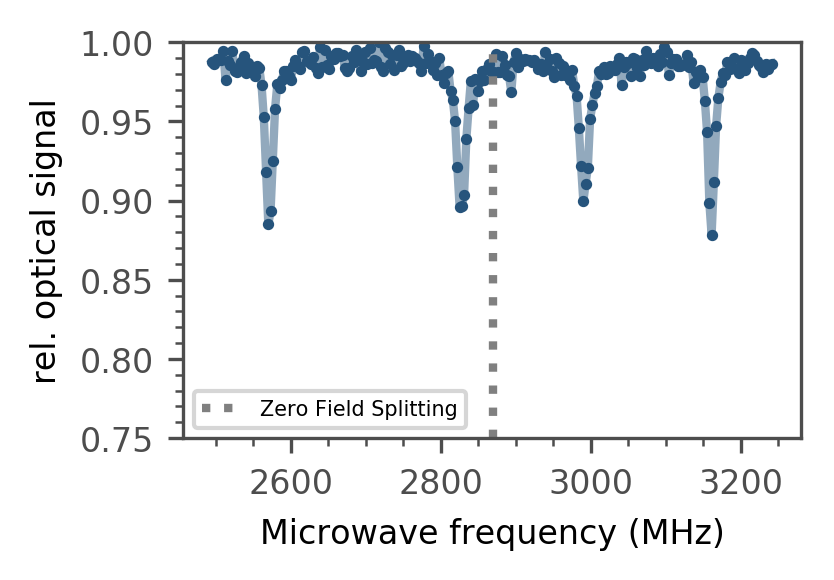

In [15]:
fname = common_params['data_path'] + r"\2023\10\20231020\PulsedMeasurement\odmr_100G_1" + "\\" \
        + "20231020-1130-39_fake_cwodmr_pulsed_measurement.dat"

try:
    fname = os.path.normpath(fname)
    copied = copy_to_path(fname)
    p_data = Tk_file.load_pulsed_result(fname)


    x = np.asarray(p_data['data']['tau'])
    y = p_data['data']['z1'] 
    y_normed = y/np.max(y)
    
    
    #plt.figure(figsize=(5.5,3.5))
    plt.figure(figsize=(3, 3*3/4.))
    
    #plt.autoscale(True)

    color = plt_settings.color('blue')
    #color = plt_settings.color('grey')
    
    plt.plot(x/1e6, y_normed, marker="", color=color, alpha=0.5, label='_no_legend')
    plt.scatter(x/1e6, y_normed, marker="o", color=color, label='_no_legend', 
                s=plt_settings.get_markersize('small', is_scatter=True))
    
    plt.axvline(2870, label='Zero Field Splitting', color='grey', linestyle=':')
    plt.ylabel("rel. optical signal")
    plt.xlabel("Microwave frequency (MHz)")
    
    plt.ylim([0.75,1.0])
    
    #plt.axvline(2571)
    #plt.axvline(3160)
    
    plt.legend(loc="lower left", prop={'size':5})


    plt.tight_layout(pad=0.95)
    plt_settings.savefig('odmr.png')
except:
    logger.exception("")

plt.show()


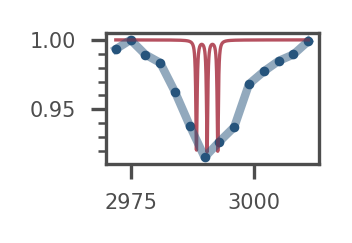

In [149]:
fname = common_params['data_path'] + r"\2023\10\20231020\PulsedMeasurement\odmr_100G_1" + "\\" \
        + "20231020-1130-39_fake_cwodmr_pulsed_measurement.dat"

try:
    fname = os.path.normpath(fname)
    copied = copy_to_path(fname)
    p_data = Tk_file.load_pulsed_result(fname)
    p_raw = [p_data]
    
    # fitting
    y_val_idx = None
    x_val = "Time"
    x_unit = "s"
    scale_fac_x = [1]
    scale_fac_y = [1, 1, 1]
    fit_on = 'z1'
    fit_meth = 'lor_dip_3x'
    #fit_meth = 'lor_dip_1x'
    fit_vals = ['None', 'None', 'None']
    fit_units = ['ns','MHz', 'MHz']
    fit_settings = None 
    calc_dxdy_fromto = [False, False, False]
    
    f_center = 2.9905e9
    df_hfs = 2.16e6
    df_fwhm = 0.15e6
    ampl = -0.08
    
    for idx, mes in enumerate(p_raw):
        mes['fit_edit_params'] = [lmfit.Parameter('offset', value=1, vary=False),
                                  lmfit.Parameter('l0_amplitude', value=ampl, vary=False),
                                  lmfit.Parameter('l0_center', value=f_center-df_hfs, vary=False),
                                  lmfit.Parameter('l0_sigma', value=df_fwhm, vary=False),
                                  lmfit.Parameter('l1_amplitude', value=ampl, vary=False),
                                  lmfit.Parameter('l1_center', value=f_center, vary=False),
                                  lmfit.Parameter('l1_sigma', value=df_fwhm, vary=False),
                                  lmfit.Parameter('l2_amplitude', value=ampl, vary=False),
                                  lmfit.Parameter('l2_center', value=f_center+df_hfs, vary=False),
                                  lmfit.Parameter('l2_sigma', value=df_fwhm, vary=False),
                                 ]
        mes['fit_settings'] = fit_settings

    #"""


    if fit_settings:
        for mes in p_raw:
            mes['fit_settings'] = fit_settings



    x = np.asarray(p_data['data']['tau'])
    y = p_data['data']['z1'] 
    # zoom 
    x_lim = [2970e6, 3012e6]
    x_zoom = x[(x>x_lim[0]) & (x < x_lim[1])]
    y_zoom = y[(x>x_lim[0]) & (x < x_lim[1])]
    x = np.asarray(x_zoom)
    y = np.asarray(y_zoom)
    
    y_normed = y/np.max(y)
    y = y_normed
    
    p_data['data'] = pd.DataFrame({'tau':x, 'z1': y})

    
    

    _, _, _, _, _ = pulsed_series_2_1d_fit_array(p_raw, 
                                            fit_meth=fit_meth, fit_on=fit_on, fit_vals=fit_vals,
                                            idx_var_x=y_val_idx, ordered_x=False)
    x_fit, y_fit = p_raw[0]['fit_values']['x'], p_raw[0]['fit_values']['y']
    
    
    #plt.figure(figsize=(5.5,3.5))
    #plt.figure(figsize=(3, 3*3/4.))
    plt.figure(figsize=(1, 1*0.82*3/4.))
    


    color = plt_settings.color('blue')
    color_fit = plt_settings.color('red')
    #color = plt_settings.color('grey')
    
    plt.plot(x_fit/1e6, y_fit, marker="", color=color_fit, alpha=0.8, label='_no_legend',
            linewidth=0.8)
    plt.plot(x/1e6, y, marker="", color=color, label='_no_legend', alpha=0.5)
    plt.scatter(x/1e6, y, marker="o", color=color, label='_no_legend', 
                s=plt_settings.get_markersize('medium', is_scatter=True))
    


    plt.xticks(fontsize=5, rotation=0)
    plt.yticks(fontsize=5, rotation=0)
    ax = plt.gca()
    ax.tick_params(axis='both',which='minor',bottom=False)
    
    plt.tight_layout(pad=0.95)
    plt_settings.savefig('odmr_hfs_zoom.png', 
                         frame_left_inch=0.27, frame_right_inch=0.02,
                         frame_top_inch=0.02, frame_bottom_inch=0.16)
    
    
    qdplotlogic.set_data(x, y, plot_index=0)
    
except:
    logger.exception("")

plt.show()


# NV Char

We fix offset of decays = 0 here.

## T2 HE

In [17]:
# Load hahn data

p_raw, x, y, fnames = [], [], [], []

inpath = common_params['data_path'] + r"\2023\11\20231116\PulsedMeasurement\hahn_echo_1"  

filter_strs = ['pulsed_measurement', '.dat']

try:
    fnames = Tk_file.list_mult_pulsed_mes(inpath, filter_strs=filter_strs, incl_subdir=False)

    for f in fnames:
        copy_to_path(f)
        p_i = Tk_file.load_pulsed_result(f)
        p_raw.append(p_i)
except:
    logger.exception()
        
data = Tk_file.load_pulsed_result(p_raw[0]['file'])


y_val_idx = 1
x_val = "Time"
x_unit = "s"
scale_fac_x = [1]
scale_fac_y = [1e9, 1e-6, 1e-6]
fit_on = 'delta'
fit_meth = 'decay_exp'
fit_vals = ['Lifetime', 'Offset', 'None']
fit_units = ['ns','MHz', 'MHz']
fit_settings = None #{'fit_range': np.linspace(-3e-6, 0e-6, 1000)}
calc_dxdy_fromto = [False, False, False]
#"""


#"""
for idx, mes in enumerate(p_raw):
    mes['fit_edit_params'] = [lmfit.Parameter('offset', value=0, vary=False)]
    mes['fit_settings'] = fit_settings

#"""


if fit_settings:
    for mes in p_raw:
        mes['fit_settings'] = fit_settings

try:
    x, y, y2, y3, dy = pulsed_series_2_1d_fit_array(p_raw, 
                                            fit_meth=fit_meth, fit_on=fit_on, fit_vals=fit_vals,
                                            idx_var_x=y_val_idx, ordered_x=True)
except:
    logger.exception("")
    

is_aligned = [abs(float(p['exp_params']['microwave_frequency'])-2.87e9) for p in p_raw]
is_aligned = [df > min(is_aligned) for df in is_aligned]
f"T2_he= {y[0]*1e6:.1f}, {y[1]*1e6:.1f},  {os.path.basename(fnames[0])}, {os.path.basename(fnames[1])}, aligned=({is_aligned[0]}, {is_aligned[1]})"

'T2_he= 75.1, 27.3,  20231116-1104-19_hahnecho_pulsed_measurement.dat, 20231116-1212-51_hahnecho_B_pulsed_measurement.dat, aligned=(True, False)'

0

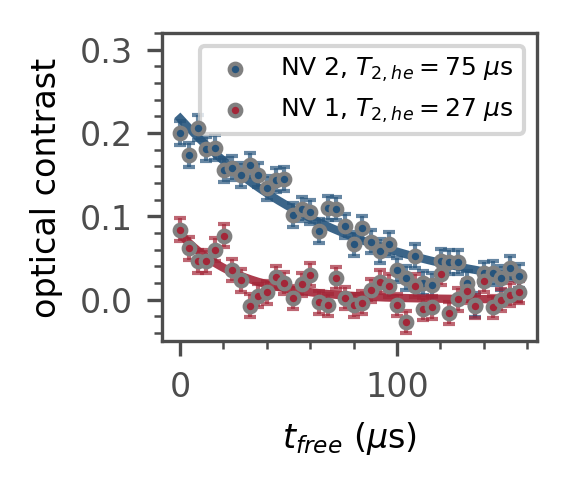

In [343]:
plot_mode = "delta"
offset = 0.
smooth_data = False

x_unit = r"$\mu$s"
#scale_fac_x = -2*16*1e6
#scale_fac_y = 0.5*1/0.08*7.62/15.7

scale_fac_x = 1e6
#scale_fac_y = 0.5*0.5*1/0.1008 #0.5*1/0.08*7.62/15.7
scale_fac_y = 1


try:

    labels = [#r'NV 2, $T_{2,he}=($' + f'{y[0]*1e6:.0f}' + r"$\pm$" + f'{dy[0]*1e6:.0f}' + r') $ \mu $s ', 
              #r'NV 1, $T_{2,he}=($' + f'{y[1]*1e6:.0f}' + r"$\pm$" + f'{dy[1]*1e6:.0f}' + r') $ \mu $s ',
              r'NV 2, $T_{2,he}=$' + f'{y[0]*1e6:.0f}' + r' $ \mu $s ', 
              r'NV 1, $T_{2,he}=$' + f'{y[1]*1e6:.0f}' + r' $ \mu $s ']
    #labels = ['he_a', 'he_b']
    
    for idx, mes in enumerate(p_raw):
        try:
            mes['plot_options'] = {'label': labels[idx]}
        except:
            fname = os.path.basename(mes['file'])
            mes['plot_options'] = {'label': fname}

    #plt.figure(figsize=(0.9*3, 0.9*2/3*3.5))  # paper
    plt.figure(figsize=(0.65*3, 0.85*2/3*3.5)) # thesis
    
    plot_multiple_1d(p_raw, n_datas=0.1, plot_err=True,
                     scale_fac_x=scale_fac_x, scale_fac_y=scale_fac_y)   # use n_datas to manipulse color cycle
    
    plt.ylim([-0.05, 0.32])
    
    plt.xlabel("$t_{free}$"+ r' ($\mu $s)')
    plt.ylabel("optical contrast")
    plt.legend()
    #plt_settings.savefig('T2_he.png')
    plt_settings.savefig('T2_he.png', frame_left_inch=0.6, frame_right_inch=0.1) # thesis
    
    plt.show()

except:
    logger.exception("")
0

## T2 XY8
<a id='val_t2_xy8'></a>

Note that XY8 is (a bit unconventionally) measured as n_order sweep instead of tau sweep.

In [89]:
# Load hahn data

p_raw, x, y, fnames = [], [], [], []

inpath = common_params['data_path'] + r"\2023\11\20231115\PulsedMeasurement\xy8_nsweep"
#inpath = common_params['data_path'] + r"\2023\11\20231116\PulsedMeasurement\hahn_echo_1"  

filter_strs = ['pulsed_measurement', '.dat']

try:
    fnames = Tk_file.list_mult_pulsed_mes(inpath, filter_strs=filter_strs, incl_subdir=False)

    for f in fnames:
        copy_to_path(f)
        p_i = Tk_file.load_pulsed_result(f)
        p_raw.append(p_i)
except:
    logger.exception()
        
data = Tk_file.load_pulsed_result(p_raw[0]['file'])


y_val_idx = 1
x_val = "Time"
x_unit = "s"
scale_fac_x = [1]
scale_fac_y = [1e9, 1e-6, 1e-6]
fit_on = 'delta'
fit_meth = 'decay_exp'
fit_vals = ['Lifetime', 'Offset', 'None']
fit_units = ['ns','MHz', 'MHz']
fit_settings = None #{'fit_range': np.linspace(-3e-6, 0e-6, 1000)}
calc_dxdy_fromto = [False, False, False]
#"""


#"""
for idx, mes in enumerate(p_raw):
    mes['fit_edit_params'] = [lmfit.Parameter('offset', value=0, vary=False)]
    mes['fit_settings'] = fit_settings

#"""


if fit_settings:
    for mes in p_raw:
        mes['fit_settings'] = fit_settings

try:
    x, y, y2, y3, dy = pulsed_series_2_1d_fit_array(p_raw, 
                                            fit_meth=fit_meth, fit_on=fit_on, fit_vals=fit_vals,
                                            idx_var_x=y_val_idx, ordered_x=True)
except:
    logger.exception("")
    
is_aligned = [abs(float(p['exp_params']['microwave_frequency'])-2.87e9) for p in p_raw]
is_aligned = [df > min(is_aligned) for df in is_aligned] 
f"T2_xy8= {y[0]*1e6:.1f}, {y[1]*1e6:.1f} ({1e6*dy[0]:.0f},{1e6*dy[1]:.0f}), aligned=({is_aligned[0]}, {is_aligned[1]})"

'T2_xy8= 476.0, 453.6 (30,58), aligned=(True, False)'

In [83]:
f"{os.path.basename(fnames[0])}, {os.path.basename(fnames[1])}"

'20231115-1657-10_xy8_tau=8e-07_nsweep_pulsed_measurement.dat, 20231115-1900-28_xy8_tau=8e-07_nsweep_pulsed_measurement.dat'

['NV 1, $T_{2,xy8}=($476$\\pm$30) $ \\mu $s ', 'NV 2, $T_{2,xy8}=($454$\\pm$58) $ \\mu $s ']

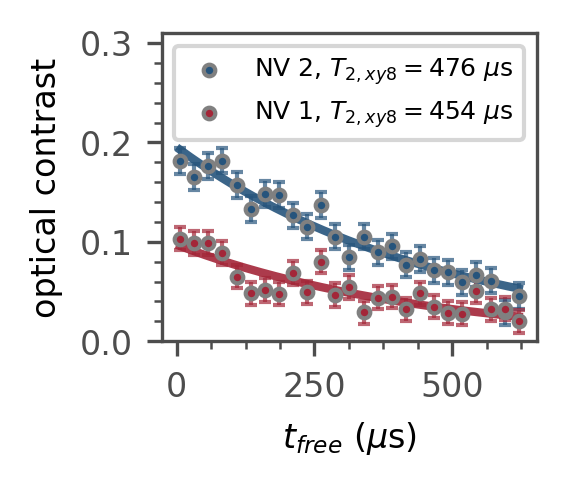

In [373]:
plot_mode = "delta"
offset = 0.
smooth_data = False

x_unit = r"$\mu$s"
#scale_fac_x = -2*16*1e6
#scale_fac_y = 0.5*1/0.08*7.62/15.7

scale_fac_x = 1e6
#scale_fac_y = 0.5*0.5*1/0.1008 #0.5*1/0.08*7.62/15.7
scale_fac_y = -1


try:

    labels_full = [r'NV 1, $T_{2,xy8}=($' + f'{y[0]*1e6:.0f}' + r"$\pm$" + f'{dy[0]*1e6:.0f}' + r') $ \mu $s ', 
              r'NV 2, $T_{2,xy8}=($' + f'{y[1]*1e6:.0f}' + r"$\pm$" + f'{dy[1]*1e6:.0f}' + r') $ \mu $s ']
    labels = [r'NV 2, $T_{2,xy8}=$' + f'{y[0]*1e6:.0f}' + r' $\mu $s ', 
              r'NV 1, $T_{2,xy8}=$' + f'{y[1]*1e6:.0f}' + r' $\mu $s ']
    #labels = ['he_a', 'he_b']
    
    for idx, mes in enumerate(p_raw):
        try:
            mes['plot_options'] = {'label': labels[idx]}
        except:
            fname = os.path.basename(mes['file'])
            mes['plot_options'] = {'label': fname}

    #plt.figure(figsize=(0.9*3, 0.9*2/3*3.5))     
    plt.figure(figsize=(0.65*3, 0.85*2/3*3.5)) # thesis
    
    
    plot_multiple_1d(p_raw, n_datas=0.1, plot_err=True,
                     scale_fac_x=scale_fac_x, scale_fac_y=scale_fac_y)   # use n_datas to manipulse color cycle
    
    #plt.ylim([0, 0.25])
    
    plt.xlabel("$t_{free}$"+ r' ($\mu $s)')
    plt.ylabel("optical contrast")
    plt.legend()
    plt.ylim([0,0.25]) # paper
    plt.ylim([0,0.31]) # thesis
    #plt_settings.savefig('T2.png') # paper
    plt_settings.savefig('T2.png', frame_left_inch=0.6, frame_right_inch=0.1) # thesis
    
    plt.show()

except:
    logger.exception("")
    
    
labels_full

## T2*

Problem: Due to a coupled spin 1/2 (most likely 13-C), Ramsey shows more than 3 lines in FFT. As we're only interested in the decay parameter, I hand tuned the initial parameter of the fit, in order to have reasonable agreement with the exp data and sine_4x model.

In [383]:
# Load Ramsey data

p_raw, x, y, fnames = [], [], [], []

inpath = common_params['data_path'] + r"\2023\10\20231020\PulsedMeasurement\ramsey_100G"
inpath = common_params['data_path'] + r"\2023\12\20231212\PulsedMeasurement\ramsey_1"

filter_strs = ['pulsed_measurement', '.dat']

try:
    fnames = Tk_file.list_mult_pulsed_mes(inpath, filter_strs=filter_strs, incl_subdir=False)

    for f in fnames:
        copy_to_path(f)
        p_i = Tk_file.load_pulsed_result(f)
        p_raw.append(p_i)
except:
    logger.exception()
        
data = Tk_file.load_pulsed_result(p_raw[0]['file'])


y_val_idx = 1
x_val = "Time"
x_unit = "s"
scale_fac_x = [1]
scale_fac_y = [1e9, 1e-6, 1e-6]
fit_on = 'delta'
fit_meth = 'sine_4x'
fit_vals = ['Lifetime', 'Offset', 'None']
fit_units = ['ns','MHz', 'MHz']
fit_settings = None #{'fit_range': np.linspace(-3e-6, 0e-6, 1000)}
calc_dxdy_fromto = [False, False, False]
#"""


#"""
for idx, mes in enumerate(p_raw):
    mes['fit_edit_params'] = [lmfit.Parameter('s1_frequency', value=400e3, vary=True),
                              lmfit.Parameter('s2_frequency', value=1.8e6, vary=True),
                              lmfit.Parameter('s3_frequency', value=2.2e6, vary=True),
                              lmfit.Parameter('s4_frequency', value=2.373e6, vary=True),
                              lmfit.Parameter('s1_phase', value=3.52, vary=True),
                              lmfit.Parameter('s2_phase', value=5.27, vary=True),
                              lmfit.Parameter('s3_phase', value=4.90, vary=True),
                              lmfit.Parameter('s4_phase', value=1.34, vary=True),
                              lmfit.Parameter('s1_amplitude', value=32.57e-3, vary=True),
                              lmfit.Parameter('s2_amplitude', value=27.57e-3, vary=True),
                              lmfit.Parameter('s3_amplitude', value=-8.05e-3, vary=True),
                              lmfit.Parameter('s4_amplitude', value=-41.77e-3, vary=True),
                              lmfit.Parameter('lifetime', value=2.2e-6, min=1.5e-6, max=2.6e-6, vary=True),
                              lmfit.Parameter('offset', value=0, vary=False),
                              lmfit.Parameter('beta', value=2, vary=False),
                              
                             ]
    mes['fit_settings'] = fit_settings

#"""


if fit_settings:
    for mes in p_raw:
        mes['fit_settings'] = fit_settings

try:
    x, y, y2, y3, dy = pulsed_series_2_1d_fit_array(p_raw, 
                                            fit_meth=fit_meth, fit_on=fit_on, fit_vals=fit_vals,
                                            idx_var_x=y_val_idx, ordered_x=False)
except:
    logger.exception("")
    
is_aligned = [abs(float(p['exp_params']['microwave_frequency'])-2.87e9) for p in p_raw]
is_aligned = [df > min(is_aligned) for df in is_aligned]
f"T2_xy8= {y[0]*1e6:.2f}, {y[1]*1e6:.2f},  {os.path.basename(p_raw[0]['file'])}, {os.path.basename(p_raw[1]['file'])}, aligned=({is_aligned[0]}, {is_aligned[1]})"

'T2_xy8= 2.37, 2.60,  20231212-1950-38_Ramsey_pulsed_measurement.dat, 20231213-1125-45_ramsey_B_pulsed_measurement.dat, aligned=(True, False)'

0

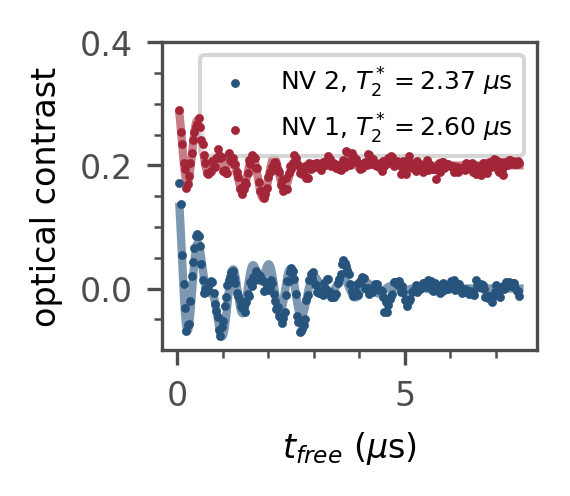

In [398]:
plot_mode = "delta"
offset = 0.2
smooth_data = False

x_unit = r"$\mu$s"
#scale_fac_x = -2*16*1e6
#scale_fac_y = 0.5*1/0.08*7.62/15.7

scale_fac_x = 1e6
#scale_fac_y = 0.5*0.5*1/0.1008 #0.5*1/0.08*7.62/15.7
scale_fac_y = -1


try:

    labels = [r'NV 2, $T_2^*=($' + f'{y[0]*1e6:.2f}' + r"$\pm$" + f'{dy[0]*1e6:.2f}' + r') $ \mu $s ', 
              r'NV 1, $T_2^*=($' + f'{y[1]*1e6:.2f}' + r"$\pm$" + f'{dy[1]*1e6:.2f}' + r') $ \mu $s ']
    labels = [r'NV 2, $T_2^*=$' + f'{y[0]*1e6:.2f}' + r' $\mu $s ', 
              r'NV 1, $T_2^*=$' + f'{y[1]*1e6:.2f}' + r' $\mu $s ']
    #labels = ['he_a', 'he_b']
    
    for idx, mes in enumerate(p_raw):
        try:
            mes['plot_options'] = {'label': labels[idx]}
        except:
            fname = os.path.basename(mes['file'])
            mes['plot_options'] = {'label': fname}

    #plt.figure(figsize=(0.9*3, 0.9*2/3*3.5))  # paper     
    #plt.figure(figsize=(5, 3))   # debug
    plt.figure(figsize=(0.65*3, 0.85*2/3*3.5)) # thesis
    
    facecolor = 'white'
    marker_style_blue = dict(s=plt_settings.get_markersize(is_scatter=True, size='small'),
                    marker='o',
                    color=plt_settings.color('blue'),
                    facecolor=facecolor,
                    linewidths=1,
                    edgecolor=plt_settings.color('blue'))
    marker_style_red = dict(s=plt_settings.get_markersize(is_scatter=True, size='small'),
                marker='o',
                color=plt_settings.color('red'),
                facecolor=facecolor,
                linewidths=1,
                edgecolor=plt_settings.color('red'))

    """
    plot_multiple_1d(p_raw, n_datas=0.1, 
                     scale_fac_x=scale_fac_x, scale_fac_y=scale_fac_y,
                     marker_size='small',#marker_size='s-medium',
                     offset=offset,
                     plot_err=plot_err, marker_style=marker_style, alpha=None)  
    """ 
    
    plot_multiple_1d(p_raw, n_datas=0.1, plot_err=False, 
                     marker_size='small', marker_style=[marker_style_blue, marker_style_red], 
                     alpha=None, alpha_line=0.6,
                     scale_fac_x=scale_fac_x, scale_fac_y=scale_fac_y, offset=offset)   # use n_datas to manipulse color cycle
    
    plt.ylim([-0.1, 0.4])
    
    plt.xlabel("$t_{free}$"+ r' ($\mu $s)')
    plt.ylabel("optical contrast")
    plt.legend() 
    plt_settings.savefig('T2star.png') # paper
    plt_settings.savefig('T2star.png', frame_left_inch=0.6, frame_right_inch=0.1) # thesis
    
    plt.show()

except:
    logger.exception("")
0

In [128]:
[el for key, el in p_raw[0]['fit_res'].items() if 'freq' in key]


[<Parameter 's1_frequency', value=618670.029915015 +/- 1.99e+04, bounds=[-inf:inf]>, <Parameter 's2_frequency', value=1778166.3964533969 +/- 1.16e+06, bounds=[-inf:inf]>, <Parameter 's3_frequency', value=1786076.3624520095 +/- 1.17e+06, bounds=[-inf:inf]>, <Parameter 's4_frequency', value=2382576.4697934566 +/- 1.82e+04, bounds=[-inf:inf]>]

In [52]:
x = p_raw[0]['data']['tau']
y = p_raw[0]['data']['z1']-p_raw[0]['data']['z2']

fft_x, fft_y = compute_ft(x_val=x,
                          y_val=y)

qdplotlogic.set_data(x, y, plot_index=0)
qdplotlogic.set_data(fft_x, fft_y, clear_old=False, plot_index=1)


0

0

# Benchmarking plots

In [79]:
from scipy.optimize import curve_fit

def order_list_of_dicts_by_values(list_of_dicts, order_key='label', order_list=[]):

  # Create a dictionary mapping each value in order_list to its index
  value_to_index = {v: i for i, v in enumerate(order_list)}

  # Define a custom key function that uses the value_to_index dictionary
  def key_func(d):
    value = d.get(order_key)  
    return value_to_index.get(value, float('inf'))  

  return sorted(list_of_dicts, key=key_func)

def order_list_all_duts(sims, order_list, dut_list, dut_id='-dut-'):
    
    sims_ordered = sims
    order_list_orig = cp.deepcopy(order_list)
    
    for dut in dut_list:
        order_list = [key.replace(dut_id, dut) for key in order_list_orig]
        #print(order_list)
    
        sims_ordered = order_list_of_dicts_by_values(sims_ordered, order_list=order_list,
                                             order_key='label')

    return sims_ordered, [r['label'] for r in sims_ordered]




data = [
    {"name": "Alice", "value": "C"},
    {"name": "Bob", "value": "A"},
    {"name": "Charlie", "value": "B"},
]

order = ['A', 'B']

ordered_data = order_list_of_dicts_by_values(data, order_key='value', order_list=order)
ordered_data

def extract_sims_2(sim, data_mode='delta', alt_middle_str='_pi', excl_label=['_std'], order_list=[]):
    # new format with decay per rabi frequency in seperate file,
    # no different error contributions
    
    data_keys = list(sim['data_raw'].keys())
    
    # if no alt_str given, dummy pairs of same index
    idx_pairs = [(i,i) for i,key in enumerate(data_keys)]
    if alt_middle_str is not None:
        idx_pairs = find_same_strings(data_keys, middle=alt_middle_str, prefix=None)

    sims = []
    
    for (id_0, id_pi) in idx_pairs:
        
        key_id_0 = data_keys[id_0]
        skip_label = False
        for excl in excl_label:
            if excl in key_id_0:
                skip_label = True
        if skip_label:
            continue
                
        key_id_pi = data_keys[id_pi]
        
        rabi = sim['data_raw']['rabi_freq']
        #x = sim['data_raw']['n_cliff_array']
        y = sim['data_raw'][key_id_0]

        if data_mode is 'z1':
            pass    
        elif data_mode is 'delta':
            y2 = sim['data_raw'][key_id_pi]
            y = y - y2
        else:
            raise ValueError
        
    
        rabi = np.asarray(rabi)
        y = np.asarray(y)
        sorted_indices = np.argsort(rabi)
        rabi = rabi[sorted_indices]
        y = y[sorted_indices]
    
        res = {'data': {'x': np.asarray(rabi), 'y': np.asarray(y)},
               'label': key_id_0}
        sims.append(res)
        

    sims_ordered = order_list_of_dicts_by_values(sims, order_list=order_list,
                                                 order_key='label')
  
    return sims_ordered, [r['label'] for r in sims_ordered]

def sims_add_spam(sims_rel, a_add_spam = 0.57, y0_add_spam = 0):

    sims_rel_spam = []

    for sim_dict in sims_rel:
        new_dict = cp.deepcopy(sim_dict)
        new_dict['data']['y'] = a_add_spam * np.asarray(sim_dict['data']['y']) + y0_add_spam

        sims_rel_spam.append(new_dict)
        
    return sims_rel_spam
    

def find_same_strings(strlist, prefix="", middle=None):
    
    common_str = ""
    if prefix != None and middle is None:
        func_check_unique = are_identical_except_prefix
        common_str = prefix
    elif prefix == None and middle is not None:
        func_check_unique = are_identical_except_middle
        common_str = middle
    else:
        raise ValueError
    
    
    def _unique(sequence):
        # make unique, while preserving order
        seen = set()
        return [x for x in sequence if not (x in seen or seen.add(x))]
    
    identical_pairs = []

    for i, string1 in enumerate(strlist):
        for j, string2 in enumerate(strlist):
            if i!=j and func_check_unique(string1, string2, common_str):
                if len(string1) > len(string2):
                    identical_pairs.append((j, i))
                else:
                    identical_pairs.append((i, j))
                
    return _unique(identical_pairs)    

def are_identical_except_middle(str1, str2, middle):

    parts1 = str1.split(middle)
    parts2 = str2.split(middle)
    
    # make sure 'middle'-containing string comes 2nd
    parts = [parts1, parts2]
    if len(parts1) > len(parts2):
        parts = [parts2, parts1]

    if not (len(parts[0]) == 1 and len(parts[1]) == 2):
        return False
    
    #print(parts)
    
    parts2 = parts[1][0] + parts[1][1]
    parts1 = parts[0][0]
    
    #print(parts1)
    #print(parts2)
    #return parts1, parts2
    
    return parts1 == parts2

def are_identical_except_prefix(str1, str2, prefix):
    if str1.startswith(prefix):
        str1 = str1.replace(prefix, "")
    if str2.startswith(prefix):
        str2 = str2.replace(prefix, "")
    
    return str1==str2

def raw_2_alt(sims, labels, data_mode='alt', alt_prefix='pi_'):
    
    if data_mode is None:
        return sims, labels
    
    idx_alts = find_same_strings(labels, alt_prefix)

    datas, labels_new = [], []

    for i, i_alt in idx_alts:
        data_new = cp.deepcopy(sims[i])
        if data_mode is 'delta':
            data_new['data']['y'] = sims[i]['data']['y'] - sims[i_alt]['data']['y']
        elif data_mode is 'z1':
            data_new['data']['y'] = sims[i]['data']['y'] 
        else:
            raise ValueError
        
        datas.append(data_new)
        labels_new.append(labels[i])

    if len(datas) != len(sims)/2:
        raise ValueError("Size of alternating data must match size of normal data")
    
    return datas, labels_new

def norm_on_2dref(z1s, z2s, refs=None):
    return (z1s-z2s)/refs
def norm_on_1st_col(z1s, z2s, refs=None):
    return (z1s-z2s)/(z1s-z2s)[:,[0]]

def norm_on_1st_col_avg_row(z1s, z2s, refs=None):
    means = np.tile(np.mean((z1s-z2s)[:,0:], axis=1), (len(x)-1,1)).T
    ref = (z1s-z2s)[:,[0]]
    
    return np.hstack((ref, means))/(z1s-z2s)[:,[0]]

def norm_on_1st_col_nonalt_avg_row(z1s, z2s, refs=None):
    means = np.tile(np.mean((1-z1s)[:,0:], axis=1), (len(x)-1,1)).T
    
    ref = (1-z2s)[:,[0]]
    return np.hstack((ref, means))/ref


def norm_on_1st_fix_rabi_col_avg_row(z1s, z2s, refs=None):
    idx_fix_rabi = 0#-1
    
    means = np.tile(np.mean((z1s-z2s)[:,0:], axis=1), (len(x)-1,1)).T
    ref = (z1s-z2s)[idx_fix_rabi,0]
    
    return np.hstack((ref, means))/ref


def avg_row(z1s, z2s, refs=None):
    means = np.tile(np.mean((z1s-z2s)[:,0:], axis=1), (len(x)-1,1)).T

    return means




def rename_strings(strings, replace_dict={}, exact_match=False):
  # Initialize an empty list to store the renamed strings
  renamed_strings = []

  # Iterate through the list of strings
  for string in strings:
    # Replace the strings in the dictionary
    for old_string, new_string in replace_dict.items():
        if exact_match:
            if old_string != string:
                continue
                
        string = string.replace(old_string, new_string)
  
    # Add the renamed string to the list
    renamed_strings.append(string)

  # Return the list of renamed strings
  return renamed_strings


def load_mathematica(fname):
    with open(fname,'r') as f:
        next(f)  # skip first line
        text=f.read()
        
    for rep in (('{','['),('}',']')):
        text=text.replace(rep[0],rep[1])
        
    array = eval(text)
    return array

def _load_2q_vs_rabi(folder):

    p_raw, x, y, fnames = [], [], [], []
    z1s, z2s = None, None

    filter_strs = ['pulsed_measurement', '.dat']

    fnames = Tk_file.list_mult_pulsed_mes(folder, filter_strs=filter_strs, incl_subdir=False)

    for f in fnames:
        p_i = Tk_file.load_pulsed_result(f)
        p_raw.append(p_i)
    
    #logger.info(f"{fnames[0]}")
    idx_var = -2  # None # for time ordered
    #Put onto 2d grid: Every row a single pulsed result
    x, y, z1s, z2s = pulsed_series_2_array(p_raw, idx_var_y=idx_var, ordered_y=False)
    refs = None

    t_rabis_1 = np.asarray([p['exp_params']['rabi_period'] for p in p_raw])
    t_rabis_2 = [np.asarray(p['exp_params']['rabi_period_mw_2'], dtype=float) for p in p_raw]
    omega_rabi = 1/((t_rabis_1+t_rabis_2)/2)
    y = omega_rabi
    
    return x, y, z1s, z2s, p_raw

def plot_2d_series_cut(x, y, z1s, z2s,
                       plot_mode='delta_norm', cut_mod='delta_norm', idx_cut_x=0, idx_cut_y=0,
                       lineplot=False, label='experiment', 
                       idx_datas=0):


    z1_norm = (z1s)/np.average(z1s, axis=1)[:,None]
    refs = None
    
    if not np.any(np.isnan(z2s[0])):
        if plot_mode == 'delta_norm':
            #delta_norm = (z1s-z2s)/np.average(z1s, axis=1)[:,None]
            delta_norm = norm_func(z1s, z2s, refs)
            #z2_norm = (z2s)/np.average(z2s, axis=1)[:,None]
            #plot_mode = "z2"
        elif plot_mode =='delta':
            delta_norm = z1s-z2s
        elif plot_mode == 'z2':
            delta_norm = z2s
        elif plot_mode == 'z1':
            delta_norm = z1s
    else:
        if plot_mode == 'z1_norm':
            z1_norm = (z1s)/np.average(z1s, axis=1)[:,None]
            delta_norm = z1_norm

    """
    #plt.figure(figsize=(5,3.5))
    
    if plot_mode == 'delta_norm' or plot_mode == 'delta':
        plt.figure(figsize=(9,4))
        plt.subplot(121)
        plt.title(f"{plot_mode}")
        plt.imshow(delta_norm, 
                   extent=extent, aspect='auto', origin='lower', cmap="plasma"
                  #,vmin=0.1
                  #,vmax=0.26
                  )

        if cut_mode == "delta_norm" or cut_mode == 'delta':
            plt.axvline(x[idx_cut_x]*scale_fac[0])
            plt.axhline(y[idx_cut_y]*scale_fac[1], color='red')

        plt.xlabel(plot_labels[0])
        plt.ylabel(plot_labels[1])
        plt.colorbar()

    #plt.ylim(6.6,10)

    plt.subplot(122)
    """
    """
    plt.title("z1")
    plt.imshow(z1s, 
               extent=extent, aspect='auto', origin='lower', cmap="plasma"
              #,vmin=0.85, vmax=1,
               #,vmax=1.02,
              )
    plt.xlabel(plot_labels[0])
    plt.ylabel(plot_labels[1])
    plt.xlim([extent[0],extent[1]])
    plt.ylim([extent[2],extent[3]])
    plt.colorbar()


    plt.tight_layout()
    plt.show()
    """

    for idx, line_slice in enumerate([(idx_cut_y, slice(None)),
                                      (slice(None), idx_cut_x)]):
        color = plt.cm.plasma((1-idx+idx_datas)/2)
        color = plt_settings.get_cmap(False)((1-idx+idx_datas)/(2))
        
        if idx is 0:
            x_axis = x
        elif idx is 1:
            x_axis = y
        else:
            raise ValueError

        # plot cuts
        if cut_mode == "delta_norm" or cut_mode == 'delta':
            zcut = delta_norm
        else:
            zcut = z1s
        #return zcut
        
        marker_style = plt_settings.marker_style(color, is_scatter=False)

        if idx == 1:
            #plt.figure(figsize=(5,3))

            #plt.subplot(111)
            x = x_axis*scale_fac[0+idx]
            y = zcut[line_slice[0], line_slice[1]]
            plt.plot(x, y,
                 label=label,
                 alpha=0.8, **marker_style, zorder=9)
            if lineplot:
                plt.plot(x_axis*scale_fac[0+idx], zcut[line_slice[0], line_slice[1]],
                        label='_no_legend',
                         color=color, alpha=0.8, marker='', zorder=9)

            plt.xlabel(plot_labels[0 + idx])
            plt.ylabel(plot_labels[2])
            plt.legend(loc='lower right')

            #plt.tight_layout()
            #plt.show() 
        
    return x, y




def calc_rel_errors(sims, labels, x_target=20, idx_x=None, epc_2q=0, n_cliff=1, rtol=1e-2,
                   convert_2_alpha=False, n_cliff_alpha=2, y0_alpha=0, a_alpha=1):
    # return x val assumes that all sims have same x axis! 
    y_cut = []
    
    y_2_al = lambda yn: yn
    if convert_2_alpha:
        # alpha is proportional to 1-EPC and thus best for giving error contribuitions
        y_2_al = lambda yn: yn_2_alpha(yn, n_cliff=n_cliff_alpha, 
                                       y0=y0_alpha, a=a_alpha)
    else:
        y0_alpha, a_alpha = 0, 1
    
    for s in sims:
        idx_cut = np.argmin(abs(x_target-s['data']['x']))
        if idx_x is not None:
            idx_cut = idx_x
        y_cut.append(s['data']['y'][idx_cut])
    
    y_full_sim = np.min(y_cut)
    f_t2 = (1-epc_2q)**n_cliff  # decoherent limited epc
    
    delta = 1 - y_2_al(f_t2*y_full_sim)    # perfect experiment: y= a + y0, alpha=1
    delta_bare = 1 - f_t2*y_full_sim

    if not np.isclose(np.max(y_cut), a_alpha*1+y0_alpha, rtol=rtol):
        logger.warning(f"perfect simulation= {np.max(y_cut)} far away from 1. Relative contribution might be correct anyway")

    rel_per_error = {}
    
    #rel_per_error['t2'] = epc_2q/(1-(1-epc_2q)*(1-delta))  
    rel_per_error['t2'] = (1-y_2_al(f_t2*a_alpha+y0_alpha))/delta # first correct decoherence free simulation, then get relative contribution
    
    """def calc_rel_errors(sims, labels, x_target=20, idx_x=None, epc_2q=0, n_cliff=1, rtol=1e-2,
                   convert_2_alpha=False, n_cliff_alpha=2, y0_alpha=0, a_alpha=1):
    # return x val assumes that all sims have same x axis! 
    y_cut = []
    
    y_2_al = lambda yn: yn
    if convert_2_alpha:
        # alpha is proportional to 1-EPC and thus best for giving error contribuitions
        y_2_al = lambda yn: yn_2_alpha(yn, n_cliff=n_cliff_alpha, 
                                       y0=y0_alpha, a=a_alpha)
    
    
    for s in sims:
        idx_cut = np.argmin(abs(x_target-s['data']['x']))
        if idx_x is not None:
            idx_cut = idx_x
        y_cut.append(s['data']['y'][idx_cut])
    
    y_full_sim = np.min(y_cut)
    f_t2 = (1-epc_2q)**n_cliff  # decoherent limited epc
    
    delta = 1 - y_2_al(f_t2*y_full_sim)    # perfect experiment: y= a + y0, alpha=1

    if not np.isclose(np.max(y_cut), 1, rtol=rtol):
        raise ValueError(f"perfect simulation= {np.max(y_cut)} far away from 1")

    rel_per_error = {}
    same functionialiy, more explicit
    for idx, y in enumerate(y_cut):
        key = labels[idx]

        if key == 'init_nuc_spin':
            rel_per_error['pol_n'] = f_t2*(y - y_full_sim)/delta
        if key == 'no_ctleak':
            rel_per_error['no_ct_leak'] = f_t2*(y - y_full_sim)/delta
        if key == 'hfoff': # before 'hf_off'
            rel_per_error['no_hfs'] = f_t2*(y - y_full_sim)/delta
        if key == 'hfoff_noctleak':
            rel_per_error['no_ct_leak_hfs'] = f_t2*(y - y_full_sim)/delta
            #rel_per_error['unattr'] =  (1-(1-epc_2q)*(y - y_full_sim))/delta
            rel_per_error['unattr'] = f_t2*1- rel_per_error['no_ct_leak_hfs']
            rel_per_error['unattr'] = (1-rel_per_error['t2']) - rel_per_error['no_ct_leak_hfs']
    
    """
    
    logger.debug(f"[{sims[0]['data']['x'][idx_cut]} MHz] Rel errors")
    for idx, y in enumerate(y_cut):
        key = labels[idx]
        
        for target_key, new_key in [('init_nuc_spin', 'pol_n'), ('no_ctleak', 'no_ct_leak'),
                            ('hfoff','no_hfs') , ('hfoff_noctleak', 'no_ct_leak_hfs')]:
            if key == target_key:
                rel_per_error[new_key] = abs(y_2_al(f_t2*y) - y_2_al(f_t2*y_full_sim))/delta
                logger.debug(f"{new_key} alpha= {abs(y_2_al(f_t2*y))}, alpha_full: {y_2_al(f_t2*y_full_sim)}, delta_full= {delta}")
                logger.debug(f"{new_key} y= {(f_t2*y)}, y_full: {(f_t2*y_full_sim)}, delta_full= {delta_bare}")
    
                
        if key == 'hfoff_noctleak':
            #rel_per_error['unattr'] =  (1-(1-epc_2q)*(y - y_full_sim))/delta
            #rel_per_error['unattr'] = f_t2*1- rel_per_error['no_ct_leak_hfs']
            rel_per_error['unattr'] = (1-rel_per_error['t2']) - rel_per_error['no_ct_leak_hfs']
    #"""


    rel_per_error['no_B_misal'] = rel_per_error['no_hfs'] - rel_per_error['pol_n']
    rel_per_error['unattr/combis'] = rel_per_error['no_ct_leak_hfs'] - (rel_per_error['no_hfs'] + rel_per_error['no_ct_leak'])
    
    
    return sims[0]['data']['x'][idx_cut], rel_per_error

def calc_rel_errors_per_rabi(sims, labels, n_cliff=1, epc_2q=0, rtol=1e-2,
                            convert_2_alpha=False, n_cliff_alpha=2, y0_alpha=0, a_alpha=1):

    rel_errors_per_rabi, rabis = [], []

    for idx in range(len(sims[0]['data']['x'])):
        omega, rel_errors = calc_rel_errors(sims, labels, idx_x=idx, epc_2q=epc_2q, n_cliff=n_cliff, rtol=rtol,
                                            convert_2_alpha=convert_2_alpha, n_cliff_alpha=n_cliff_alpha,
                                            y0_alpha=y0_alpha, a_alpha=a_alpha)
        summables_keys = ['pol_n', 'no_ct_leak', 'no_B_misal', 'unattr/combis', 'unattr', 't2']

        rel_errors_summable = {key: val for key, val in rel_errors.items() if key in summables_keys}
        rel_error_sum = np.sum(list(rel_errors_summable.values()))

        if not np.isclose(1, rel_error_sum) or rel_errors['unattr']<-rtol:
            raise ValueError(f"Errors don't sum up: {rel_error_sum}!=1. Unattr: {rel_errors['unattr']}")

        rel_errors_per_rabi.append(rel_errors_summable)
        rabis.append(omega)
    
    rabis = np.asarray(rabis)
    rel_errors_per_rabi = pd.DataFrame(rel_errors_per_rabi)
    rel_errors_per_rabi['x_mhz'] = rabis
    
    return rabis, rel_errors_per_rabi

def qiskit_coherence_limit(nQ=2, T1_list=None, T2_list=None, gatelen=0.1):
        """
        The error per gate (1-average_gate_fidelity) given by the T1,T2 limit.

        Args:
            nQ (int): Number of qubits (1 and 2 supported).
            T1_list (list): List of T1's (Q1,...,Qn).
            T2_list (list): List of T2's (as measured, not Tphi). If not given assume T2=2*T1 .
            gatelen (float): Length of the gate.

        Returns:
            float: coherence limited error per gate.
        Raises:
            ValueError: If there are invalid inputs
        """
        # pylint: disable = invalid-name

        T1 = np.array(T1_list)

        if T2_list is None:
            T2 = 2 * T1
        else:
            T2 = np.array(T2_list)

        if len(T1) != nQ or len(T2) != nQ:
            raise ValueError("T1 and/or T2 not the right length")

        coherence_limit_err = 0

        if nQ == 1:

            coherence_limit_err = 0.5 * (
                1.0 - 2.0 / 3.0 * np.exp(-gatelen / T2[0]) - 1.0 / 3.0 * np.exp(-gatelen / T1[0])
            )

        elif nQ == 2:

            T1factor = 0
            T2factor = 0

            for i in range(2):
                T1factor += 1.0 / 15.0 * np.exp(-gatelen / T1[i])
                T2factor += (
                    2.0
                    / 15.0
                    * (
                        np.exp(-gatelen / T2[i])
                        + np.exp(-gatelen * (1.0 / T2[i] + 1.0 / T1[1 - i]))
                    )
                )

            T1factor += 1.0 / 15.0 * np.exp(-gatelen * np.sum(1 / T1))
            T2factor += 4.0 / 15.0 * np.exp(-gatelen * np.sum(1 / T2))

            coherence_limit_err = 0.75 * (1.0 - T1factor - T2factor)

        else:
            raise ValueError("Not a valid number of qubits")

        return coherence_limit_err

def load_sim(fname, x_key=None, y_key=None):
    if '.npz' in fname:
        with np.load(fname) as data:
            col_keys = data.files

            #x, y = data[col_keys[0]], data[col_keys[1]] 
            data_sim = {key: data[key] for key in col_keys}
 
    else:
        raise ValueError
    
    if y_key is None:
        y_key = col_keys[1]
    if x_key is None:
        x_key = col_keys[0]

    sim_res = {'data': {}, 'info': {}, 'data_raw': data_sim}
    for idx, key in enumerate(col_keys):
        if 'Rabi' in key:
            sim_res['data']['x'] = data_sim[key]
        elif 'meas' in key:
              
            sim_res['data']['y'] = data_sim[y_key]
            
            if 'old' in y_key:
                sim_res['info']['B'] = 60
            elif 'new' in y_key:
                sim_res['info']['B'] = 100
        else:
            sim_res['data'][key] = data_sim[key]
            sim_res['data']['x'] = data_sim[x_key]
            sim_res['data']['y'] = data_sim[y_key]
    
    return sim_res

def combine_mes(p_datas, join_rots=False, drop_added_idxs=[]):
    # ATTENTION: yields fake/dummy meta data
    p_data = cp.deepcopy(p_datas[0])
    n_first = len(p_data['data'])
    
    datas = [p['data'] for p in p_datas]
    p_data['data'] =  pd.concat(datas, axis=0).reset_index()
    p_data_old_idx = pd.concat(datas, axis=0)
    
    # remove idxs (eg. norm data points) from all but first data
    if len(drop_added_idxs) > 0:
        idx_to_drop = [list(p_data['data'][p_data_old_idx.index == didx].index) for didx in drop_added_idxs]
        idx_to_drop = np.asarray([x for row in idx_to_drop for x in row])
        idx_to_drop = idx_to_drop[idx_to_drop >= n_first]
        #logger.info(f"{idx_to_drop}")

        p_data['data'].drop(idx_to_drop, inplace=True)
        p_data['data'].drop('index', axis=1, inplace=True)

    
    if join_rots:
        rots = [p['exp_params']['rotations'] for p in p_datas]
        rots_flat = [x for row in rots for x in row]
        p_data['exp_params']['rotations'] = rots_flat
        
        if len(drop_added_idxs) > 0:      
            p_data['exp_params']['rotations'] = [rot for idx, rot in enumerate(rots_flat) if idx not in idx_to_drop]

            
    return p_data

#test = combine_mes(p_datas, True, [0])
#len(test['data']), len(test['exp_params']['rotations'])

def plot_rb_t2_limit(epc, x=None, ampl=1, y0=0):
    if x is None:
        x = np.linspace(0,100,1000)
    else:
        x = np.linspace(np.min(x), np.max(x), 100)
    y = _rb_fit_func_1(x, 1-epc, ampl, y0) 
    plt.plot(x, y, linewidth=3, marker='', linestyle='dashed', color=plt_settings.color('red'), label=r"$T_2$ limit")

def plot_nrep_t2_limit(t2, xy8_order=1, tau1=800e-9, x=None, ampl=1, y0=0):
    if x is None:
        x = np.linspace(0,100,1000)
    else:
        x = np.linspace(np.min(x), np.max(x), 100)
        
    p = np.exp(-xy8_order*8*tau1/t2)
    
    y = _rb_fit_func_1(x, p, ampl, y0) 
    plt.plot(x, y, marker='', linestyle='dashed', color=plt_settings.color('red'), label=r"$T_2$ limit")
  

def decay_2_epc(tau_decay, dtau=0, n_qubits=1):
    # 'alpha' naming like in qiskit, in paper: exp decay paramaeter p
    alpha = np.exp(-1/(tau_decay))
    d_alpha = np.exp(-1/(tau_decay))*1/(tau_decay)**2*dtau # todo: is linear error propagation clever for this transformation?
    
    # for nrep like data
    epc = (1-alpha)
    d_epc = d_alpha
    if n_qubits != 0:
        # for rb like data
        epc = (2**(n_qubits)-1)/(2**n_qubits)*epc
        d_epc = (2**(n_qubits)-1)/2**n_qubits*(d_epc)
    
    
    info_dict = {}
    info_dict['d_epc'] = d_epc
    info_dict['alpha'] = alpha
    info_dict['d_alpha'] = d_alpha
             
    return epc, info_dict


def yn_2_alpha(yn, n_cliff=2, y0=0, a=1):
    alpha = np.power((yn-y0)/a, 1/n_cliff)
    return alpha

def yn_2_epc(yn, n_cliff=2, y0=0,  a=1, n_qubits=2):
    alpha = yn_2_alpha(yn, n_cliff, y0, a)
    epc = (2**n_qubits-1)/2**n_qubits * (1-alpha)
    
    return epc

def calc_t2_to_epg(t2, xy8_order=1, tau1=800e-9, n_qubits=2):
    # given an experimental T2 with a given xy8 order
    # calculate a epg assuming that it's a clifford like experiment
    # todo: how does this compare to qiskit.rb_verif.coherence_limit
    
    lifetime = t2/(xy8_order*8*tau1)
    
    return decay_2_epc(lifetime, n_qubits=n_qubits)

def calc_t2_to_pepg(t2, xy8_order=1, tau1=800e-9):
    # given an experimental T2 with a given xy8 order
    # calculate a epg assuming that it's a repetitive experiment with single exponential decay
    # todo: how does this compare to qiskit.rb_verif.coherence_limit
    
    t_gate = xy8_order*8*tau1
    
    return (1-np.exp(-t_gate/t2))




def calc_fidelity_interleaved(alpha_normal, alpha_interleaved, n_qubits=1):
    # fit decay parameter "alpha" (qiskit) = "p" (Magesan, PRL, 2012)
    
    d = 2**n_qubits
    
    # variables names like in original Magesan 
    p = alpha_normal
    p_c = alpha_interleaved
    
    r = (d-1)*(1-p_c/p)/d
    
    e_1 = (d - 1) * (np.abs(p-p_c)/ p + (1 - p)) / d
    e_2 = 2 * ((d**2 - 1)*(1 - p)) / (p * d**2) + 4*np.sqrt(1-p)*np.sqrt(d**2 - 1) / p
    e = np.min([e_1, e_2])
               
    ret_dict = {'epc': r, 'e': e}
               
    return ret_dict

def mean_over_idxs(p_data, idxs, z_mode='delta'):
    if z_mode is 'delta':
        delta =  p_data['data']['z1'] - p_data['data']['z2']
    
    idxs = [i if i>=0 else len(p_data['data'])+i for i in idxs] 
    
    return np.mean(delta[idxs])

def _rb_fit_func_1(m, p, a, b):
    # 1st order, see Mageson paper
    return a * p**m + b

def _rb_fit_func_2(m, p, a, b, c):
    # higher order, see Mageson paper
    return a * p**m + c*(m-1)*p**(m-2)  + b

def fit_rand_bench_manual(p_data, n_qubits=2, fit_func=_rb_fit_func_2):
    x = p_data['data']['tau']
    z = delta_or_z1(p_data)
    
    init_guess = [0.98, 0.5, 0.5, 0.5]
    fit_bounds = ((0, 0, 0, 0), (1, 2, 1, 2))
    fit_params, pcov = curve_fit(f=fit_func,
                                 xdata=x,
                                 ydata=z,
                                 p0=init_guess,
                                 bounds=fit_bounds)
    fit_errors = np.sqrt(np.diag(pcov))
    
    fit_res = {'EPC_alpha': {'value': fit_params[0], 'error': fit_errors[0]},
               'Amplitude 1': {'value': fit_params[1], 'error': fit_errors[1]},
               'Amplitude 2': {'value': fit_params[3], 'error': fit_errors[3]},
               'Offset': {'value': fit_params[2], 'error': fit_errors[2]}}
    
    add_fit_eval(p_data, fit_res, fit_func)
    
    alpha = fit_res['EPC_alpha']['value']
    dalpha = fit_res['EPC_alpha']['error']
    
    epc = (2**(n_qubits)-1)/(2**n_qubits)*(1-alpha)
    d_epc = (2**(n_qubits)-1)/2**n_qubits*(dalpha)
    
    fit_res.update({'EPC': {'value': epc, 'error': d_epc}})
    p_data['fit_res'] = fit_res
    
    return fit_res

def add_fit_eval(p_data, fit_res=None, fit_func=None):
    
    settings = None
    if 'fit_settings' in p_data.keys():
        settings = p_data['fit_settings']
    
    x = p_data['data']['tau']
    x_min, x_max = np.min(x), np.max(x)
    x_domain = np.linspace(x_min, x_max,  1000)
    
    if settings:
        if 'fit_range' in settings.keys():
            x_domain = settings['fit_range']
    
    fit_params = [val['value'] for val in fit_res.values()]
    y = fit_func(x_domain, *fit_params)
    
    p_data['fit_values'] = {'x': x_domain, 'y': y}


def count_tol(arr, atol=0.):
    unique_elements = np.unique(arr)
    count_list = [(x, np.sum(np.abs(arr - x) <= atol)) for x in unique_elements]
    return count_list

def unique_tol(arr, atol=0):
    arr = np.asarray(arr)
    unique_elements = [arr[0]]
    for x in arr[1:]:
        if not any(np.allclose(x, y, atol=atol) for y in unique_elements):
            unique_elements.append(x)
    return np.array(unique_elements)


def plot_bench_data(p_data_in, annotate_vals=None, split_before=None, split_idx_start=0, lineplot=False, n_qubits=1,
                   idx_plot=None, plot_err=False, perform_fit=True, z_ref=None, idx_zref=None, mask_idxs=[],
                   idx_datas=0, n_datas=1, labels=None, calc_mean_datapoint=False, color_fit=None):
    
    def _get_label(idx_pd):
        init = None
        try:
            [p_d['exp_params']['rotations'].pop(idx) for idx in mask_idxs]
            init = [i for i in extract_init_from_rots(p_d['exp_params']['rotations'][0], split_before=split_before)] # all datapoints should have same init
            init_str = [i.name for i in init]
            vec0, vec1, idx = init_2_state(init)
            label = qubits_2_str(vec0, vec1)
            #init = f"{init}" + f" -> {label}"
            label = f"{label}"
                        
        except Exception as e:
            logger.warning(f"Couldnt convert init= {init}: {str(e)}")
            label = '/na'
            #logger.exception(f"In {init}")
        
        try:
            if labels != None:
                label = labels[idx_pd]
        except:
            label = '/na'

        return label
    
    try:
        p_data = cp.deepcopy(p_data_in)  # use returned object if added (eg fit res) data is needed
        p_d_fit = p_data
        
        if fit_on is 'delta':
            delta =  p_data['data']['z1'] - p_data['data']['z2']
            if plot_err:
                ddelta = np.sqrt(p_data['data']['std1']**2+p_data['data']['std2']**2)
            
            y_scale = 1/z_ref if z_ref else 1
            if idx_zref != None:
                # todo: use function norm_on_delta()
                z_ref = delta[idx_zref] 
                y_scale = 1/z_ref
                if len(mask_idxs) != 0:
                    mask_idxs = [i if i>=0 else len(p_data['data'])+i for i in mask_idxs]  # handle negative idx
                    p_data['data'] = p_data['data'].drop(mask_idxs)
                    p_data['exp_params']['rotations'] = [r for i, r in enumerate(p_data['exp_params']['rotations']) if i not in mask_idxs]

                    delta = delta.drop(mask_idxs)
                    if plot_err:
                        ddelta = ddelta.drop(mask_idxs)
                    # manually fix fit range including the deleted ref datapoint
                    fit_settings = {'fit_range': np.linspace(0, np.max(p_data['data']['tau']), 1000)}
                    if 'fit_settings' in p_data.keys():
                        p_data['fit_settings'].update(fit_settings) 
                    else:
                        p_data['fit_settings'] = fit_settings

                        
                    #logger.info(f"New data: {p_data['data']}")
                #logger.info(f"z_ref= {z_ref}")
                
            p_data['data']['delta'] = y_scale*delta
            if plot_err:
                p_data['data']['ddelta'] = y_scale*ddelta


        # Add fit result to plot
        #p_datas = split_pdata_into_inits(p_data, split_before=split_before,
        #                                     idx_start=split_idx_start)
        if split_before == False:
            p_datas = [p_data]
        else:
            p_datas = split_pdata_into_inits(p_data, split_before=split_before,
                                             idx_start=split_idx_start)
            if idx_plot != None:
                if type(idx_plot) == slice:
                    p_datas = p_datas[idx_plot]
                elif type(idx_plot) == list:
                    p_datas = [p for i, p in enumerate(p_datas) if i in idx_plot]
                else:
                    raise ValueError
        #p_datas = split_pdata_into_inits(p_data, split_before=split_before, idx_start=1)[:]
        
        
        if calc_mean_datapoint:
            n_tau_per_point = count_tol(p_data['data']['tau'], 1e-1)
            n_ignore_start = len([val for val, n in n_tau_per_point if n==1])
            
            tau = p_data['data']['tau']
            tau_mean = unique_tol(tau[n_ignore_start:], atol=1e-1)
            n_per_tau = len(p_data['data']['tau'][n_ignore_start:]) / len(tau)
            try:
                data_mean = [np.mean(ar) for ar in np.split(p_data['data'][fit_on][n_ignore_start:], len(tau_mean))]
            except:
                raise ValueError(f"Couldn't calc mean. n_per_tau= {n_tau_per_point}, n_ignore={n_ignore_start}, len= {len(p_data['data'][fit_on][n_ignore_start:])}")
            #logger.info(f"len(tau)= {len(tau_mean)}, data {len(data_mean)}: tau_mean= {tau_mean}, data= {data_mean}")
        
        if perform_fit:
            # repeat fit on subset of data
            p_d_fit = combine_mes(p_datas)
            
            if calc_mean_datapoint:
                
                p_d_fit_mean = cp.deepcopy(p_d_fit)
                p_d_fit_mean['data'] = pd.DataFrame(columns=p_d_fit_mean['data'].columns)
                p_d_fit_mean['data']['tau'] = tau_mean
                p_d_fit_mean['data'][fit_on] = data_mean
                p_d_fit_mean['data']['z1'] = [np.nan]*len(data_mean)
                
                #logger.info(f"Fit on mean: tau_mean= {p_d_fit_mean['data']['tau']}, data= {p_d_fit_mean['data'][fit_on]}")
                fit_rand_bench(p_d_fit_mean, n_qubits=n_qubits)
                
                p_d_fit_mean['data'] = p_d_fit['data']  # restore non-average data
                p_d_fit = p_d_fit_mean
            else:
                fit_rand_bench(p_d_fit, n_qubits=n_qubits)

        marker = itertools.cycle(('D', 'o', '^', '>', 'v','s','<')) 
        [next(marker) for _ in range(2*idx_datas)]
                
        for idx, p_d in enumerate(p_datas):
            #color = plt.cm.plasma((idx+idx_datas)/(len(p_datas)*n_datas))
            color = plt_settings.get_cmap(False)((idx+idx_datas)/(len(p_datas)*n_datas))
            if len(p_datas) > 5:
                color = plt_settings.get_cmap(True)((idx+idx_datas)/(len(p_datas)*n_datas))
            color_mark = color
            label = _get_label(idx)

            #plt.scatter(p_d['data']['tau'], p_d['data'][fit_on], label=f'{init}', color=color)

            if calc_mean_datapoint:
                mark = next(marker)
                plt.scatter(tau_mean, data_mean, color=color,
                            marker=mark, s=plt_settings.get_markersize(is_scatter=True),
                            alpha=0.9, label=label, zorder=10)    
                color_mark = 'grey'
                label = _get_label(idx + 1)
                
                plt.scatter(p_d['data']['tau'], p_d['data'][fit_on], label=label, #label='_no_legend',
                        edgecolors=None, linewidth=0, 
                        color=color_mark, marker=next(marker), s=plt_settings.get_markersize('small', is_scatter=True),
                        alpha=0.5, zorder=1) # alpha=0.5,marker=''

                
            if plot_err:
                ddelta = p_d['data']['ddelta']
                
                mark = next(marker)
                marker_err_style = plt_settings.marker_style(color, is_scatter=False, is_err=True) 
                plt.errorbar(p_d['data']['tau'], p_d['data'][fit_on], yerr=ddelta,
                             alpha=0.9, label='_no_legend', 
                             **marker_err_style,
                             markersize=0,
                             linestyle='', zorder=1)
                plt.scatter(p_d['data']['tau'], p_d['data'][fit_on],
                             color=color, alpha=1, label=label,
                             marker=mark, s=plt_settings.get_markersize('s-medium', True), zorder=10)

            if lineplot:
                plt.plot(p_d['data']['tau'], p_d['data'][fit_on], 
                         color=color, marker='', alpha=0.5, label='_no_legend') 
                
            if not plot_err and not calc_mean_datapoint:
                plt.scatter(p_d['data']['tau'], p_d['data'][fit_on], label=label,
                           color=color, marker=next(marker), s=plt_settings.get_markersize(is_scatter=True),
                            alpha=0.5, zorder=1)


        if perform_fit:
            if color_fit is None:
                color_fit = color
                
            show_fit_vals = [key for key in p_d_fit['fit_res'].keys() if key[0].isupper()]
            if annotate_vals == None:
                annotate_vals = show_fit_vals
            res_str = "" 
            for val in show_fit_vals:
                if str(val) in annotate_vals:
                    res_str += f"{val}= {p_d_fit['fit_res'][val]['value']:.3e} " + r"$\pm$"+  f" {p_d_fit['fit_res'][val]['error']:.3e}\n"

            plt.plot(p_d_fit['fit_values']['x'], p_d_fit['fit_values']['y'], color=color_fit,
                     alpha=0.5, linewidth=3, marker='', label=f'Fit')
            y_a = 0.98 - (idx_datas/n_datas)*0.5
            plt.annotate(res_str, xy=(0.98,y_a), xycoords='axes fraction', color='grey',
                         va='top', ha='right', fontsize=6)

        plt.xlabel("n_rep ()")
        plt.xlabel("Clifford length")
        if z_ref:
            plt.ylabel(r"$|\langle \Psi |0 \rangle |^2$")
        else:
            plt.ylabel("z1-z2")

        plt.legend(loc="lower left")
        #plt.legend(prop={'size': 8}, bbox_to_anchor=(-0.3,1.0))
        #plt.tight_layout()
        #plt.savefig(savepath + 'test.png', dpi=300)
        
        return p_d_fit
        
    except:
        logger.exception("")

0

0

## 1Q RB 



For EPC-> EPG: Native gates per clifford length 1.97 for 1Q RB. (Analyse in generate_rb.ipynb)
ATTENTION: Need to fit the offset of the fit manually.
This offset is best taken from a baseline measurement that's included at the last n taus.

baseline= 0.1094. Offset= 0.1094 fixed to this?
EPC= 0.0101, EPG= 0.0051


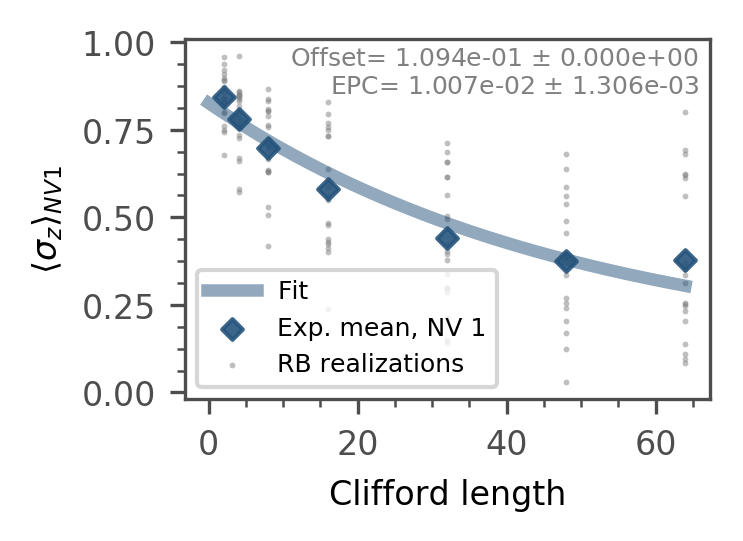

In [3731]:
fname = common_params['data_path'] + r"\2023\09\20230926\PulsedMeasurement\rb_1q_oc=20230926_1_1" + "\\" \
        + "20230926-1054-10_rand_benchmark_pulsed_measurement.dat"
fname = common_params['data_path'] + r"\2023\09\20230926\PulsedMeasurement\rb_1q_bare_2" + "\\" \
        + "20230926-1232-33_rand_benchmark_pulsed_measurement.dat"
        #+ "20220510-1721-54_ramsey_crosstalk_ampl2=150.0mV_pulsed_measurement.dat" 
gpc = 1.97 # rb_1q_20230213
        
split_before = False
fit_on = 'delta'
perform_fit = True
calc_mean_datapoint = True
mask_last_n = 20

"""       
p_data, split_before=split_before, split_idx_start=1, lineplot=False,
                                     n_qubits=2, perform_fit=perform_fit, 
                                     idx_zref=0, mask_ref=True,
                                     idx_datas=idx_f, n_datas=2,
                                     labels=labels[idx_f],
                                     annotate_vals=['EPC', 'Lifetime', 'Offset']        
"""        
     
try:
    plt.figure(figsize=(0.7*3.5, 0.75*3.5*2./3.))
    
    fname = os.path.normpath(fname)
    copy_to_path(fname)
    p_data = Tk_file.load_pulsed_result(fname)
    
    y_baseline = mean_over_idxs(p_data, list(range(-mask_last_n,0)))
    p_data = plot_bench_data(p_data, #annotate_vals=['Offset', 'EPC'], 
                             annotate_vals=['EPC', 'Offset'], 
                            idx_zref=0, mask_idxs=[0] + list(range(-mask_last_n,0)),
                            labels = ['Exp. mean, NV 1', 'RB realizations'],
                            perform_fit=perform_fit, split_before=split_before,
                            calc_mean_datapoint=calc_mean_datapoint)
    
    
    epc = p_data['fit_res']['EPC']['value']
    offset = p_data['fit_res']['offset'].value
    print(f"baseline= {y_baseline:.4f}. Offset= {offset:.4f} fixed to this?")
    print(f"EPC= {epc:.4f}, EPG= {epc/gpc:.4f}")
    #plt.axhline(y_baseline, label=f"baseline= {y_baseline:.4f}", alpha=0.3)
    #plt.legend()
    
    plt.ylabel(r'$\langle \sigma_z \rangle_{NV1}$')
    
except:
    logger.exception("")

plt_settings.savefig('rb_1q_A.png', frame_top_inch=0.15, frame_right_inch=0.15,
                     frame_left_inch=0.55, frame_bottom_inch=0.4)
plt.show()

In [1700]:
p_data['fit_res']['offset'].value

0.0951

baseline= 0.0951. Offset= 0.0951 fixed to this?
EPC= 0.0093, EPG= 0.0047


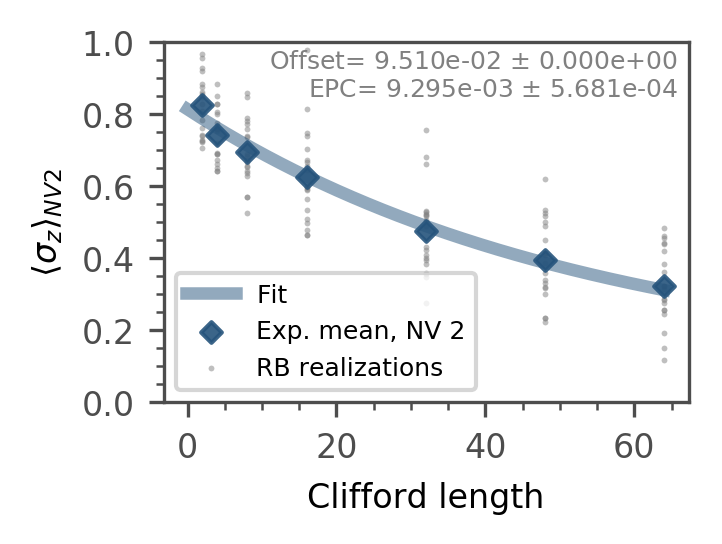

In [3848]:
fname = common_params['data_path'] + r"\2023\09\20230926\PulsedMeasurement\rb_1q_oc=20230926_1_1" + "\\" \
        + "20230926-1109-13_rand_benchmark_pulsed_measurement.dat"
fname = common_params['data_path'] + r"\2023\09\20230926\PulsedMeasurement\rb_1q_bare_2" + "\\" \
        + "20230926-1221-25_rand_benchmark_pulsed_measurement.dat"
gpc = 1.97     

try:
    fname = os.path.normpath(fname)
    p_data = Tk_file.load_pulsed_result(fname)
except:
    logger.exception("")

split_before = False
fit_on = 'delta'
perform_fit = True
calc_mean_datapoint = True
mask_last_n = 20

plt.figure(figsize=(0.7*3.5, 0.75*3.5*2./3.))

y_baseline = mean_over_idxs(p_data, list(range(-mask_last_n,0)))
p_data = plot_bench_data(p_data,# annotate_vals=['Offset', 'EPC'], 
                         annotate_vals=['EPC', 'Offset'], 
                        idx_zref=0, mask_idxs=[0] + list(range(-mask_last_n,0)),
                        labels = ['Exp. mean, NV 2', 'RB realizations'],
                        perform_fit=perform_fit, split_before=split_before,
                        calc_mean_datapoint=calc_mean_datapoint)

epc = p_data['fit_res']['EPC']['value']
offset = p_data['fit_res']['offset'].value
print(f"baseline= {y_baseline:.4f}. Offset= {offset:.4f} fixed to this?")
print(f"EPC= {epc:.4f}, EPG= {epc/gpc:.4f}")

plt.ylim([0.0,1])
plt.ylabel(r'$\langle \sigma_z \rangle_{NV2}$')


plt_settings.savefig('rb_1q_B.png', frame_top_inch=0.15, frame_right_inch=0.15,
                     frame_left_inch=0.55, frame_bottom_inch=0.4)
plt.show()

For EPC-> EPG: Native gates per clifford length 11.51.

0.08107682600985933

In [394]:
# OLD ???
fname = common_params['data_path'] + r"\2023\09\20230926\PulsedMeasurement\rb_1q_oc=20230926_1_1" + "\\" \
        + "20230926-1130-44_rand_benchmark_2Q_noCNOT_pulsed_measurement.dat"
fname =common_params['data_path'] + r"\2023\09\20230926\PulsedMeasurement\rb_1q_bare_2" + "\\" \
        + "20230926-1243-27_rand_benchmark_1q_pulsed_measurement.dat"
gpc = 11.51      

try:
    fname = os.path.normpath(fname)
    p_data = Tk_file.load_pulsed_result(fname)
except:
    logger.exception("")

split_before = False
fit_on = 'delta'
perform_fit = True
calc_mean_datapoint = True
mask_last_n = 20

y_baseline = mean_over_idxs(p_data, list(range(-mask_last_n,0)))
p_data = plot_bench_data(p_data, annotate_vals=['Offset', 'EPC'], 
                idx_zref=0, mask_idxs=[0] + list(range(-mask_last_n,0)),
                labels = ['NV B'],
                perform_fit=perform_fit, split_before=split_before)

print(f"baseline= {y_baseline:.4f}. Offset fixed to this?")
epc = p_data['fit_res']['EPC']['value']
print(f"EPC= {epc:.4f}, EPG= {epc/gpc:.4f}")

plt.tight_layout()
plt.savefig(savepath + 'rb_1q_B.png', dpi=300)
plt.show()

baseline= -0.0097. Offset fixed to this?
EPC= 0.0808, EPG= 0.0070


## 2Q Repetitive benchmarking

Need to manually fix:
- the fit offset= 0 in pgui. Note that the resulting EPC is only slighlty different!
- Lifetime sometimtes to ensure convergence in last plot. 


pEPG:
- is calculated from a single exponential decay model (1-pEPG) = exp(-t_gate/mean(T2)). Not by EPC formula that includes a dependency on n_qubit 2^n-1/2^n. This is handled consitently for both the pEPG_T2 limit and the pEPGs extracted from fits.

In [87]:
# as defined in Genkos sim, analysis notebook
init_nv1 = [TomoRotations.none, TomoRotations.ux180_on_1,
            TomoRotations.uy90_on_1, TomoRotations.uy90min_on_1,
            TomoRotations.ux90min_on_1, TomoRotations.ux90_on_1]
init_nv2 = [TomoRotations.none, TomoRotations.ux180_on_2,
            TomoRotations.uy90_on_2, TomoRotations.uy90min_on_2,
            TomoRotations.ux90min_on_2, TomoRotations.ux90_on_2]

inits = list(itertools.product(init_nv1, init_nv2))
list(inits)

# todo: check correct inits
slice_groups = [(0,1), (-6, -5), (17,18)]

inits[slice_groups[0][0]], inits[slice_groups[1][0]], inits[slice_groups[2][0]]


((<TomoRotations.none: 0>, <TomoRotations.none: 0>), (<TomoRotations.ux90_on_1: 1>, <TomoRotations.none: 0>), (<TomoRotations.uy90_on_1: 3>, <TomoRotations.ux90_on_2: 2>))

[98.92, 19.325877, 37.2]

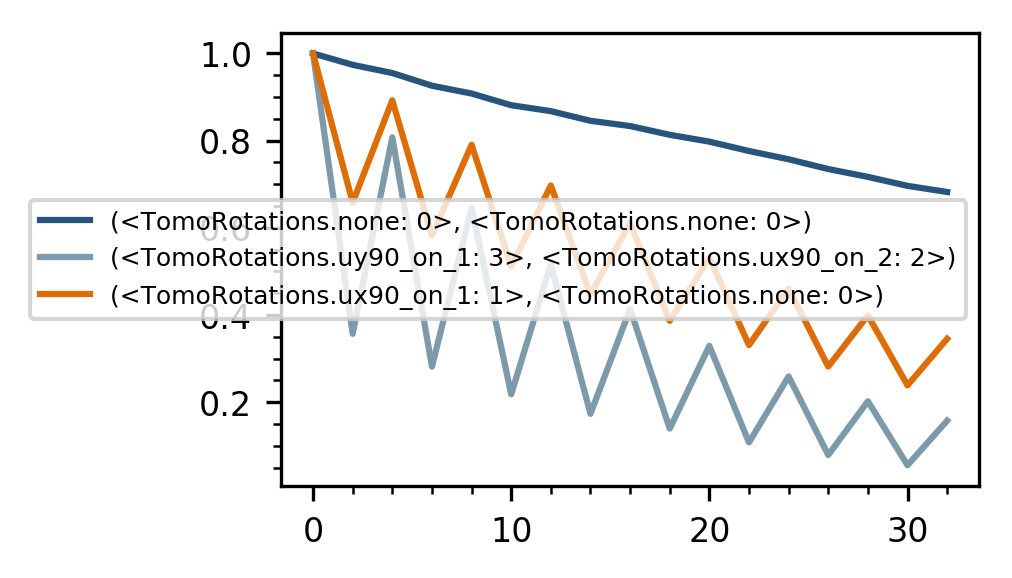

In [103]:
# Simulation data genko
# todo: exp data is normalized on joint contrast datapoint. Good idea?

fname = common_params['data_path'] + r"\2023\11\20231115\SimulationGenko\20231218_sim_charge_100G" + "\\" \
    + r"fluorescence_100_G_NV1_Sin1_XY8y_o_16_t_0.8_a_1_NV2_Sin1_XY8y_o_16_t_0.8_a_1_MW1_Sin1_XY8y_none_t_0.8_a_none_o_16_charge_1.m"
fname = common_params['data_path'] + r"\2023\11\20231115\SimulationGenko\20231220_sim_charge_alternating_100G"  + "\\" \
    + r"fluorescence_100_G_NV1_Sin1_XY8y_o_32_t_0.8_a_1_NV2_Sin1_XY8y_o_32_t_0.8_a_1_MW1_Sin1_XY8y_none_t_0.8_a_none_o_32_charge_1.m"

n_inits = 36
slice_groups = [(0,1), (20,21), (4, 5)]
slice_groups = [(0,1), (17,18),  (-6, -5)]


new_range = [-1, 1]
original_range = [-1, 1]
tau_n_decay = [98.92, 19.325877, 37.20] 
#tau_n_decay = [np.inf, np.inf, np.inf] 


copy_to_path(fname)
data_sim = load_mathematica(fname)
interp_func = scipy.interpolate.interp1d(original_range, new_range, kind='linear', fill_value='extrapolate')
interp_func = lambda x: np.asarray(x) #2*np.asarray(x)-1

col_keys = list(range(0, 36))
#data_sim = pd.DataFrame(np.asarray(data_sim), columns=col_keys)
#data_sim = pd.DataFrame(data_sim)


#np.asarray(data_sim).shape
cols = []
xs = []
for idx_state in range(0, n_inits):
    cols.append(np.asarray(data_sim)[idx_state,:,1])
    xs.append(np.asarray(data_sim)[idx_state,:,0])

all_same_x = all([np.array_equal(a, b) for a,b in zip(xs, xs[1:])])
if not all_same_x:
    raise ValueError

x_sim = xs[0]

#y_decay = np.vstack([np.exp(-x_sim/150)]*n_inits).T
ys_sim = [pd.DataFrame(np.asarray(cols).T).iloc[:, slice_groups[0][0]:slice_groups[0][1]],
          pd.DataFrame(np.asarray(cols).T).iloc[:, slice_groups[1][0]:slice_groups[1][1]],
          pd.DataFrame(np.asarray(cols).T).iloc[:, slice_groups[2][0]:slice_groups[2][1]]]
          
ys_sim = [interp_func(y) for y in ys_sim]
#ys_sim = [np.asarray(y) for y in ys_sim]
ys_sim = [y.flatten()*np.exp(-x_sim/tau_n_decay[idx]) for idx, y in enumerate(ys_sim)]


plt.figure(figsize=(3,2))

plt.plot(x_sim, ys_sim[0], color=plt_settings.color('blue'), label=f"{inits[slice_groups[0][0]]}")
plt.plot(x_sim, ys_sim[1], color=plt_settings.color('bluelight'), label=f"{inits[slice_groups[1][0]]}")
plt.plot(x_sim, ys_sim[2], color=plt_settings.color('orange'), label=f"{inits[slice_groups[2][0]]}")

plt.legend()
plt.show()

tau_n_decay

In [65]:
ys_sim[2]

array([1.   , 0.661, 0.898, 0.587, 0.799, 0.517, 0.712, 0.46 , 0.637,
       0.409, 0.565, 0.357, 0.494, 0.307, 0.43 , 0.263, 0.377])

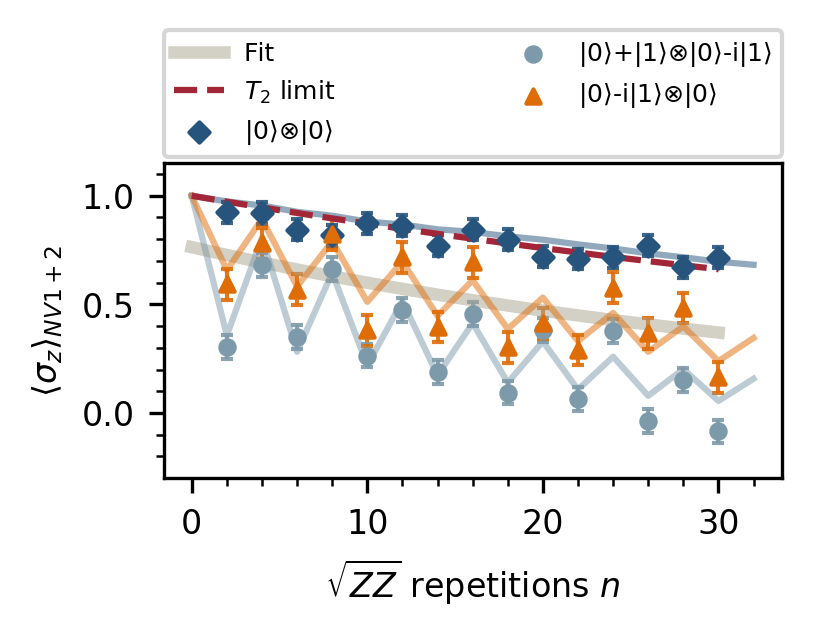

In [259]:
#plt.rcParams.update(params)

#fname = r"E:\Data\2023\06\20230602\PulsedMeasurement\nrep_cphase_3" + "\\" \
#        + "20230603-1141-07_rand_benchmark_pulsed_measurement.dat"
    
#fname = r"E:\Data\2023\10\20231009\PulsedMeasurement\nrep_cphase_1"  + "\\" \
#        + "20231009-1045-08_rand_benchmark_pulsed_measurement.dat"

fname = common_params['data_path'] + r"\2023\10\20231009\PulsedMeasurement\nrep_cphase_1"  + "\\" \
        + "20231009-1030-46_rand_benchmark_pulsed_measurement.dat"

#fname = r"E:\Data\2023\10\20231011\PulsedMeasurement\nrep_cphase_2"  + "\\" \
#        + "20231011-2221-42_rand_benchmark_pulsed_measurement.dat"
        #+ "20231011-1348-40_rand_benchmark_pulsed_measurement.dat" 
        #+ "20231011-1511-41_rand_benchmark_pulsed_measurement.dat"
       
fname = common_params['data_path'] + r"\2023\10\20231016\PulsedMeasurement\nrep_cphase_tau_cnot=-267ns_2" + "\\" \
    + "20231016-2051-31_rand_benchmark_pulsed_measurement.dat"
    
folder = common_params['data_path'] + r"\2023\10\20231017\PulsedMeasurement\nrep_cphase_tau_cnot=-280ns_2" 

fnames = Tk_file.list_mult_pulsed_mes(folder, filter_strs=['measurement.dat'], incl_subdir=False)
fnames = fnames[::-1]

    
       

split_before = TomoRotations.c2phase1_dd
fit_on = 'delta'
calc_mean_datapoint = False
plot_errbar = True
z_ref = 0.278
idx_zref = 0
t2_limit = None 
t2_limit = np.mean(common_params['t2_xy8'])

n_mod_filter = None #0 #2
n_per_group = [(4,4),(9,1),(4,1)]
n_per_group = [(8,8),(8,8),(4,4)]
n_per_group = [(8,1),(8,1),(4,1)]
#n_per_group = [(16,1),(4,1),(4,1)]   # (n_total), (n_to_show)
n_per_group = [(20,20),(4,4),(4,4)]   # (n_total), (n_to_show)
idxs_plot = [slice(0,n_per_group[0][1]),
            slice(n_per_group[0][0],n_per_group[0][0]+n_per_group[1][1]),
            slice(n_per_group[0][0]+n_per_group[1][0],n_per_group[0][0]+n_per_group[1][0]+n_per_group[2][1])]
idxs_plot = [slice(0,8,1),
            slice(0,32,1),
            slice(0,32,1)]
idxs_plot = [[0, 20, 28],
            slice(0,32,1),
            slice(0,32,1)]

if idx_zref != None:
    z_ref = None
    
try:
    p_datas = []
    for fname in fnames:
        fname = os.path.normpath(fname)
        
        copy_to_path(fname)
        p_data = Tk_file.load_pulsed_result(fname)
        if p_data['exp_params'] is None:
            continue
        p_datas.append(p_data)
    
    p_data = combine_mes(p_datas, join_rots=True, drop_added_idxs=[idx_zref])
    
    if n_mod_filter is not None:
        p_data['data'] = p_data['data'].where(((n_mod_filter + np.round(p_data['data']['tau']))%4==0) | (np.round(p_data['data']['tau'])==0))
        p_data['data'] = p_data['data'].dropna()
except:
    logger.exception("")




try:
    plt.figure(figsize=(3,3.5*3/5))
    plot_bench_data(p_data,  split_before=split_before, 
                    split_idx_start=0, mask_idxs=[0],
                    #annotate_vals=['EPC', 'Lifetime','Offset'],
                    lineplot=False, plot_err=plot_errbar,
                    annotate_vals=[],
                    idx_plot=idxs_plot[0],
                    z_ref=z_ref, idx_zref=idx_zref,
                    fit_color=plt_settings.color('grey'))
    
    for idx, y_sim in enumerate(ys_sim):
        plt.plot(x_sim, y_sim, label="_no_legend", # label=f"tau_n= {tau_n_decay[idx]}", 
                 marker="", color=plt_settings.get_cmap(False)(idx/3), alpha=0.5)
    
    if t2_limit is not None:
        ampl_exp =  1 #1.04 #p_data['fit_res']['Amplitude']['value']
        #plot_rb_t2_limit(epc_t2_limit, x=p_data['data']['tau'].append(pd.Series([0])),
        #                 y0=y_baseline, ampl=ampl_exp)
        plot_nrep_t2_limit(t2_limit, x=p_data['data']['tau'].append(pd.Series([0])),
                         y0=0, ampl=ampl_exp)
        
    #plt.legend(prop={'size': 12}, bbox_to_anchor=(-0.25,1.0))
    plt.legend(ncol=2, loc='lower left',
               bbox_to_anchor=(0., 1.02, 1., .102),
               mode="expand", borderaxespad=0.,
              )
    
    plt.xlabel(r"$\sqrt{ZZ}$ repetitions $n$")
    plt.ylabel(r'$\langle \sigma_z \rangle_{NV1+2}$')
    plt.ylim([-0.3, 1.15])

    plt_settings.savefig('nrep_cphase_1', frame_top_inch=0.5)
    plt.show()
     
    raise
    plt.figure(figsize=(8,8))
    plot_bench_data(p_data,  split_before=split_before, 
                    split_idx_start=0, mask_idxs=[0],
                    #annotate_vals=['EPC', 'Lifetime','Offset'],
                    annotate_vals=[],
                    lineplot=True, plot_err=plot_errbar,
                    idx_plot=idxs_plot[1], z_ref=z_ref, idx_zref=idx_zref)
                   # idx_plot=[4,20], z_ref=z_ref, idx_zref=idx_zref)
    if t2_limit is not None:
        ampl_exp =  1.0 #p_data['fit_res']['Amplitude']['value']
        #plot_rb_t2_limit(epc_t2_limit, x=p_data['data']['tau'].append(pd.Series([0])),
        #                 y0=y_baseline, ampl=ampl_exp)
        plot_nrep_t2_limit(t2_limit, x=p_data['data']['tau'].append(pd.Series([0])),
                         y0=0, ampl=ampl_exp)    
    
    #plt.legend(prop={'size': 12}, bbox_to_anchor=(-0.25,1.0))
    plt.legend(bbox_to_anchor=(-0.25,1.0), prop={'size': 8})
    #plt.xlabel(r"$CRZ^{\pi/2}$ repetitions")
    plt.xlabel(r"$CPhase$ repetitions $n$")
    
    plt.tight_layout(pad=0.55)
    plt.savefig(plt_settings.get_savepath('nrep_cphase_2'), dpi=300)
    plt.show()
    
    plt.figure(figsize=(8,8))
    plot_bench_data(p_data, split_before=split_before, 
                    split_idx_start=0, mask_idxs=[0],
                    #annotate_vals=['EPC', 'Lifetime','Offset'],
                    annotate_vals=[],
                    idx_plot=idxs_plot[2],
                    lineplot=True, plot_err=plot_errbar,
                    z_ref=z_ref, idx_zref=idx_zref)
                    #idx_plot=[20,36], z_ref=z_ref, idx_zref=idx_zref)
    if t2_limit is not None:
        ampl_exp =  1.0 #p_data['fit_res']['Amplitude']['value']
        #plot_rb_t2_limit(epc_t2_limit, x=p_data['data']['tau'].append(pd.Series([0])),
        #                 y0=y_baseline, ampl=ampl_exp)
        plot_nrep_t2_limit(t2_limit, x=p_data['data']['tau'].append(pd.Series([0])),
                         y0=0, ampl=ampl_exp) 
    #plt.legend(prop={'size': 12}, bbox_to_anchor=(-0.25,1.0))
    
    
    plt.legend(bbox_to_anchor=(-0.25,1.0), prop={'size': 8})
    plt.xlabel(r"$CPhase$ repetitions")
    #plt.xlabel(r"$CRZ^{\pi/2}$ repetitions")

    
    plt.tight_layout(pad=0.55)
    plt.savefig(plt_settings.get_savepath('nrep_cphase_3'), dpi=300)
    plt.show()
    
    plt.rcParams.update(default_params)
    
except:
    logger.exception("")

In [712]:
p_data['exp_params']['rotations'][idxs_plot[0][2+0]]
#p_data['exp_params']['rotations'][idxs_plot[0][1]]
#p_data['exp_params']['rotations'][idxs_plot[0][2]]

[<TomoRotations.ux180_on_2: 12>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.ux180_on_2: 12>]

### pEPG for all inits

ATTENTION: Need to manually fix exp_decay=0! Lifetime [10-inf]

In [2600]:
raise NormallyNoNeeded

# filter out a single n_mod
p_data = Tk_file.load_pulsed_result(fname)
p_data

n_mod = 2
if n_mod is not None:
    p_data['data'] = p_data['data'].where(((n_mod + np.round(p_data['data']['tau']))%4==0) | (np.round(p_data['data']['tau'])==0))
    p_data['data'] = p_data['data'].dropna()
    
p_i = plot_bench_data(p_data,  split_before=split_before, split_idx_start=1, annotate_vals=['EPC', 'Offset'],
                            lineplot=True, idx_plot=[5,5+1],  z_ref=z_ref, idx_zref=idx_zref)
#p_i['exp_params']['rotations']

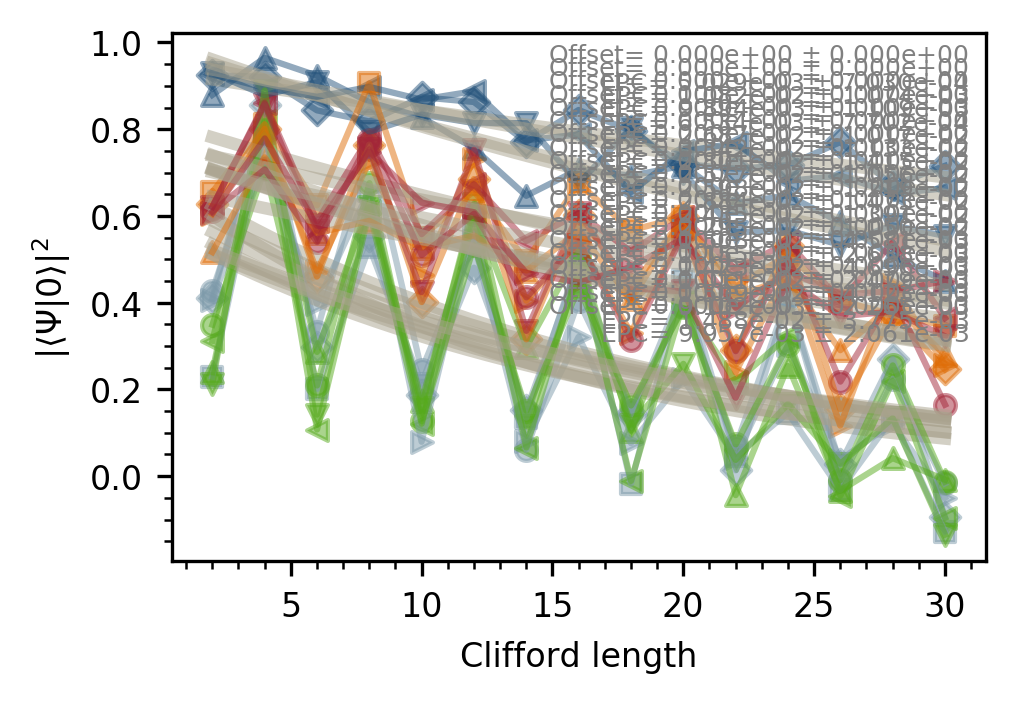

In [263]:
n_inits = 4+16#+16  #17
fit_val = 'Lifetime'  # 'EPC'
fit_val = 'EPC'
fit_val = 'pEPG'  # assumes n_qubits=0 in decay_2_epc


folder = common_params['data_path'] + r"\2023\10\20231017\PulsedMeasurement\nrep_cphase_tau_cnot=-280ns_2" 

fnames = Tk_file.list_mult_pulsed_mes(folder, filter_strs=['measurement.dat'], incl_subdir=False)
fnames = fnames[::-1]

res = {'epc': [], 'depc': [], 'lifetime': [], 'n_mod':[], 'x': [], 'x_npi90': [],
       'init_state':[], 'init_state_str': []}
try:
    p_datas = []
    for fname in fnames:
        fname = os.path.normpath(fname)
        p_data = Tk_file.load_pulsed_result(fname)
        if p_data['exp_params'] is None:
            continue
        p_datas.append(p_data)
    
    for n_mod in [None]:#[None, 0, 2]:
        for i in range(n_inits):
            # filter
            #if i not in range(4+8,4+8+8):
            #    continue
            logger.debug(f"[{i}] n_mod= {n_mod}")
            
            p_data = combine_mes(cp.deepcopy(p_datas), join_rots=True, drop_added_idxs=[idx_zref])
    
            if n_mod is not None:
                p_data['data'] = p_data['data'].where(((n_mod + np.round(p_data['data']['tau']))%4==0) | (np.round(p_data['data']['tau'])==0))
                p_data['data'] = p_data['data'].dropna()
            
            p_i = plot_bench_data(p_data,  split_before=split_before, split_idx_start=1, annotate_vals=['EPC', 'Offset'],
                            idx_plot=slice(i,i+1),  z_ref=z_ref, idx_zref=idx_zref,
                            lineplot=True, idx_datas=i, n_datas=n_inits, n_qubits=1)
                            # todo: better: # split_idx_start=0, mask_idxs=[0]?
                
            res['epc'].append(p_i['fit_res'][fit_val]['value'])
            res['depc'].append(p_i['fit_res'][fit_val]['error'])
            res['lifetime'].append(p_i['fit_res']['Lifetime']['value'])
       
            # TODO: for n_mod!=None, extract_init will fail!
            # count n(pi90) pulses
            init = [i for i in extract_init_from_rots(p_i['exp_params']['rotations'][0], split_before=split_before)]
            pi90_inits = [TomoRotations.ux90_on_1, TomoRotations.uy90_on_1, TomoRotations.ux90_on_2, TomoRotations.uy90_on_2]
            x = np.sum([init.count(i) for i in pi90_inits])
            res['x_npi90'].append(x)
            
            # init_state label
            vec0, vec1, idx = init_2_state(init)
            state_str = qubits_2_str(vec0, vec1)
            
            res['n_mod'].append(n_mod)
            res['x'].append(i)
            res['init_state_str'].append(state_str)
            res['init_state'].append(init)

except:
    logger.exception("")
    
#plt.legend()
ax = plt.gca()
ax.get_legend().remove()


plt.show()

res = pd.DataFrame(res)

In [2516]:
epg_limit_1 = calc_t2_to_epg(t2_limit, n_qubits=2)[0]   # used in paper v0.1
epg_limit_2 = calc_t2_to_epg(t2_limit, n_qubits=1)[0]
epg_limit_3 = calc_t2_to_pepg(t2_limit)  # better guess, no assumptions on Clifford gates



epg_limit_1, epg_limit_2, epg_limit_3

(0.01025186831776978, 0.006834578878513187, 0.013669157757026484)

In [2438]:
idxs_plot[0][2]

28

In [2531]:
# lifetimes of examplary init states in plot, requires all n_inits = 36 input states to be plotted
idx_plot = [0, 20, 28]
idx_plot = [0, 10, 12]


res[['init_state', 'lifetime']].iloc[idx_plot]

#res[['lifetime','init_state']]

                                           init_state   lifetime
0                                [TomoRotations.none]  98.917472
10  [TomoRotations.uy90min_on_1, TomoRotations.uy9...  20.029043
12                       [TomoRotations.ux90min_on_1]  32.652493

In [2417]:
t2_limit, epg_limit

(0.000465, 0.013669157757026484)

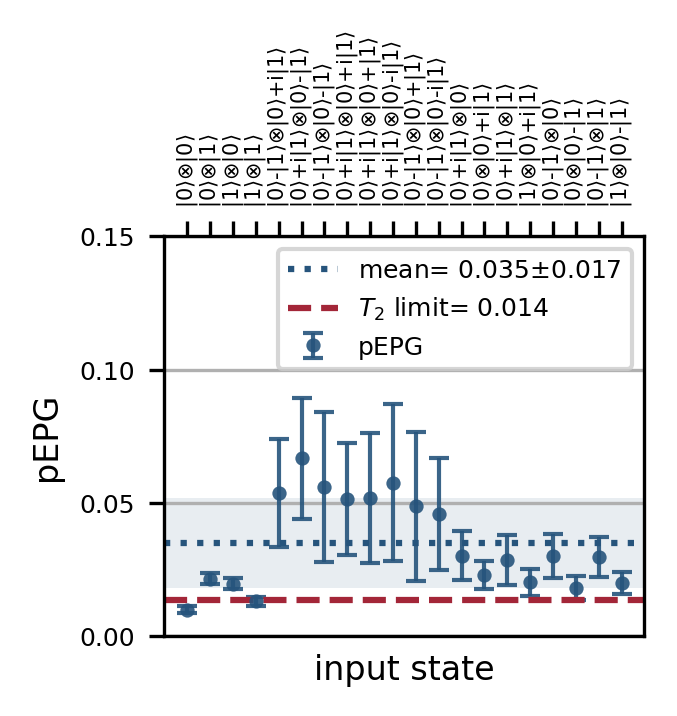

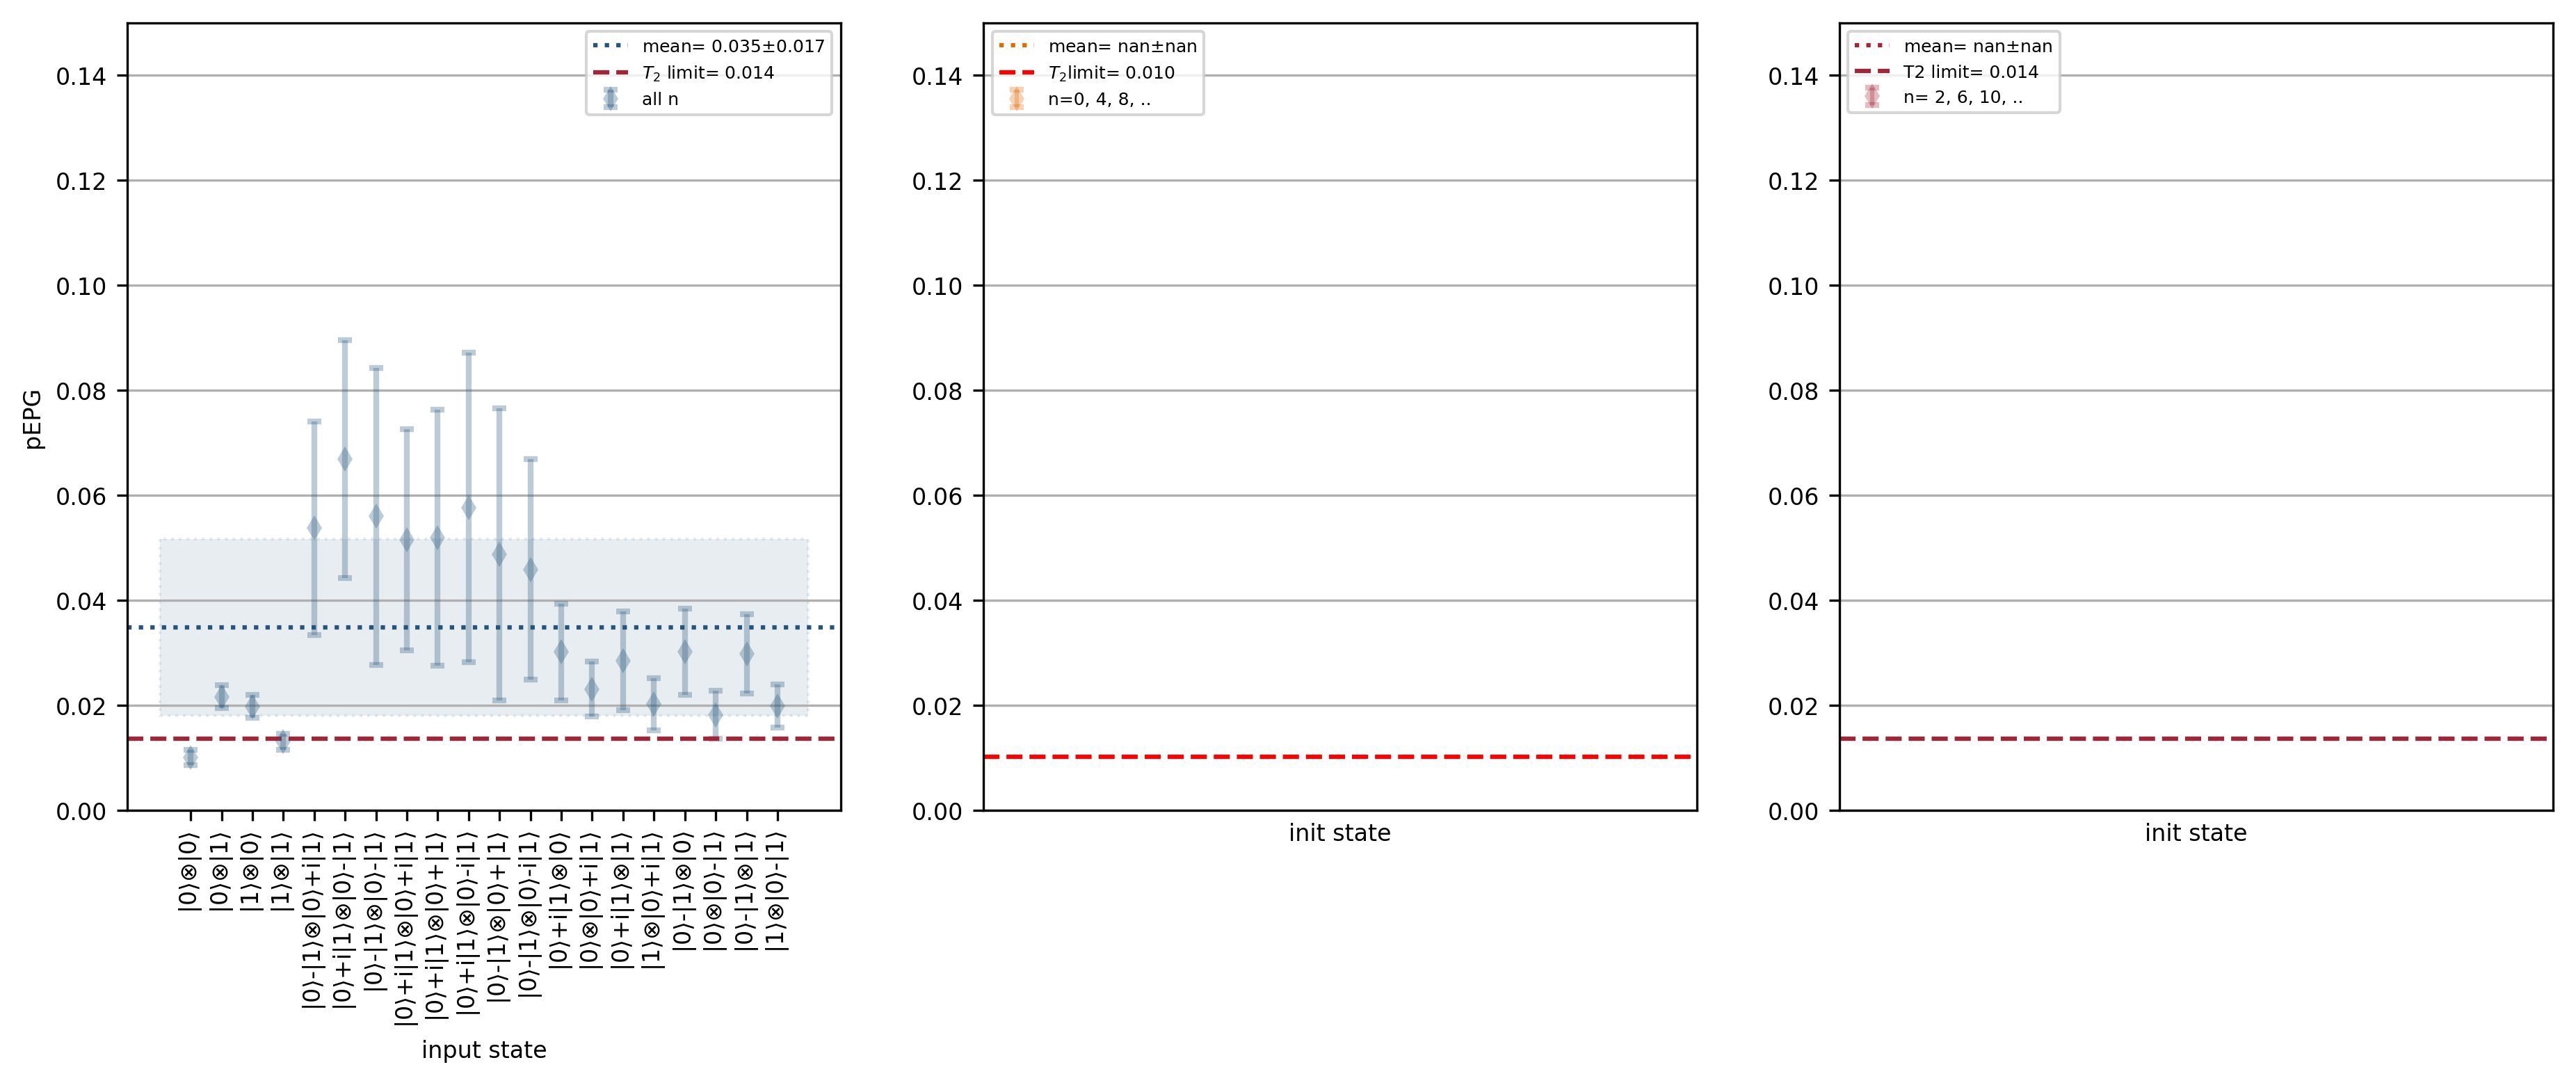

In [335]:
# todo: check wheter can use x axis from res_0 for all plots
# all n


#ylim = [0,125]
ylim = [0,0.15]
#ylim = None
xlim =  range(0,n_inits)
xlim =  [0-1, n_inits-1+1]

#xlim = range(0,n_inits)
#xlim = range(12,20)
t2_limit = None
t2_limit = np.mean(common_params['t2_xy8'])


# Todo: might break due to grid for lifetime (not EPC)


try:
    
    
    res_0 = res[res['n_mod'].isna()]
    res_1 = res.where(res['n_mod'] == 0.)
    res_1 = res_1.dropna()
    res_2 = res.where(res['n_mod'] == 2.)
    res_2 = res_2.dropna()
    
    plt.figure(figsize=(2.4,3.5*2/3))
    plt.errorbar(res_0['x'], res_0['epc'], yerr=res_0['depc'],
                 capthick=1, linewidth=1,
                 linestyle="", color=plt_settings.color('blue'), label="pEPG",
                 markersize=plt_settings.get_markersize('medium'),
                 marker="o", #marker="D",
                 alpha=0.9)
    mean_epg = np.mean(res_0['epc'])
    std_epg = np.std(res_0['epc'])

    plt.axhline(mean_epg, color=plt_settings.color('blue'), linestyle=":", label=f'mean= {mean_epg:.3f}'+r'$\pm$'+f'{std_epg:.3f}')
    if t2_limit is not None:
        epg_limit = calc_t2_to_pepg(t2_limit)
        plt.axhline(epg_limit,
                    color=plt_settings.color('red'), linestyle="dashed", label=r"$T_2$" + f" limit= {epg_limit:.3f}")
    plt.fill_between(xlim, np.mean(res_0['epc'])-np.std(res_0['epc']), np.mean(res_0['epc'])+np.std(res_0['epc']),
                     color=plt_settings.color('blue'), alpha=0.1, linewidth=0) # linestyle=":"

    plt.xlabel("input state")
    plt.ylabel("pEPG")
    plt.yticks(fontsize=6)
    #plt.ylabel(f"{fit_val}")
    
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    plt.legend(loc="upper right")
    plt.xticks(res_0['x'], res_0['init_state_str'], fontsize=5, rotation='vertical')
    ax = plt.gca()
    ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    ax.xaxis.set_minor_locator(plt.NullLocator())
    #ax.yaxis.set_minor_locator(plt.MultipleLocator(base=25))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(base=50))
    ax.yaxis.set_major_locator(plt.MultipleLocator(base=0.05))
    plt.grid(which='both', axis='y')
    
    plt.tight_layout()
    plt_settings.savefig('nrep_epg_vs_init', frame_left_inch=0.6, frame_bottom_inch=0.3,
                         frame_top_inch=0.7, frame_right_inch=0.2)
    
    
    
    # Supplement: mod(4) with subplots
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.errorbar(res_0['x'], res_0['epc'], yerr=res_0['depc'], 
                 capthick=2, linewidth=2,
                 linestyle="", color=plt_settings.color('blue'), label="all n", marker="d", alpha=0.3)
    mean_epg = np.mean(res_0['epc'])
    std_epg = np.std(res_0['epc'])

    plt.axhline(mean_epg, color=plt_settings.color('blue'), linestyle=":", label=f'mean= {mean_epg:.3f}'+r'$\pm$'+f'{std_epg:.3f}')
    if t2_limit is not None:
        epg_limit = calc_t2_to_pepg(t2_limit)
        plt.axhline(epg_limit,
                    color=plt_settings.color('red'), linestyle="dashed", label=r"$T_2$" + f" limit= {epg_limit:.3f}")
    plt.fill_between(xlim, np.mean(res_0['epc'])-np.std(res_0['epc']), np.mean(res_0['epc'])+np.std(res_0['epc']),
                     color=plt_settings.color('blue'), linestyle=":", alpha=0.1)

    plt.xlabel("input state")
    plt.ylabel("pEPG")
    plt.ylabel(f"{fit_val}")

    if ylim is not None:
        plt.ylim(ylim)
    plt.legend(loc="upper right")
    plt.xticks(res_0['x'], res_0['init_state_str'], fontsize=8, rotation='vertical')
    ax = plt.gca()
    ax.xaxis.set_minor_locator(plt.NullLocator())
    ax.yaxis.set_minor_locator(plt.MultipleLocator(base=25))
    plt.grid(which='both', axis='y')



    plt.subplot(132)
    plt.errorbar(res_1['x'], res_1['epc'], yerr=res_1['depc'], linestyle="", capthick=2,
                 color=plt_settings.color('orange'), label="n=0, 4, 8, ..", marker="d",  alpha=0.3)
    mean_epg = np.mean(res_1['epc'])
    std_epg = np.std(res_1['epc'])
    plt.axhline(mean_epg, color=plt_settings.color('orange'), linestyle=":", label=f'mean= {mean_epg:.3f}'+r'$\pm$'+f'{std_epg:.3f}')
    if t2_limit is not None:
        epg_limit = calc_t2_to_epg(t2_limit, n_qubits=2)[0]
        plt.axhline(epg_limit,
                    color='red', linestyle="dashed", label=r"$T_2$" + f"limit= {epg_limit:.3f}")

    plt.fill_between(xlim, np.mean(res_1['epc'])-np.std(res_1['epc']), np.mean(res_1['epc'])+np.std(res_1['epc']),
                     color=plt_settings.color('orange'), linestyle=":", alpha=0.1)

    plt.xlabel("init state")
    plt.xticks(res_2['x'], res_0['init_state_str'], fontsize=8, rotation='vertical')
    ax = plt.gca()
    ax.xaxis.set_minor_locator(plt.NullLocator())
    ax.yaxis.set_minor_locator(plt.MultipleLocator(base=25))
    plt.grid(which='both', axis='y')

    if ylim is not None:
        plt.ylim(ylim)
    plt.legend(loc="upper left")



    plt.subplot(133)
    plt.errorbar(res_2['x'], res_2['epc'], yerr=res_2['depc'], linestyle="", capthick=2,
                 color=plt_settings.color('red'), label="n= 2, 6, 10, ..",  marker="d",  alpha=0.3)
    mean_epg = np.mean(res_2['epc'])
    std_epg = np.std(res_2['epc'])
    plt.axhline(mean_epg, color=plt_settings.color('red'), linestyle=":", label=f'mean= {mean_epg:.3f}'+r'$\pm$'+f'{std_epg:.3f}')
    if t2_limit is not None:
        epg_limit = calc_t2_to_pepg(t2_limit)
        plt.axhline(epg_limit,
                    color=plt_settings.color('red'), linestyle="dashed", label=f"T2 limit= {epg_limit:.3f}")
    plt.fill_between(xlim, np.mean(res_2['epc'])-np.std(res_2['epc']), np.mean(res_2['epc'])+np.std(res_2['epc']),
                     color=plt_settings.color('red'), linestyle="dashed", alpha=0.1)

    plt.xticks(res_2['x'], res_0['init_state_str'], fontsize=8, rotation='vertical')
    ax = plt.gca()
    ax.xaxis.set_minor_locator(plt.NullLocator())
    ax.yaxis.set_minor_locator(plt.MultipleLocator(base=25))
    plt.grid(which='both', axis='y')

    plt.xlabel("init state")

    if ylim is not None:
        plt.ylim(ylim)
    plt.legend(loc="upper left")

except:
    logger.exception("")
    
#plt.tight_layout()
plt.show()

In [348]:
std_epg

49229.45795208508

In [163]:
# histogram
plt.figure()
N, bins, patches = plt.hist(res['epc'], bins=15)

for i in range(0,3):
    patches[i].set_facecolor('b')
for i in range(3,8):    
    patches[i].set_facecolor('r')
for i in range(8, len(patches)):
    patches[i].set_facecolor('black')
    
plt.show()

In [141]:
res['epc']

[]


quick n dirty injection of Charge-init data for Fedor. Get data from other PostProcess.ipynb, n_phots=9

In [449]:
p_inject = p_mess[9]
p_inject['data'] = pd.DataFrame(p_inject['data'])

rotations = '<TomoRotations.ux90_on_1: 1>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.ux90_on_1: 1>; <TomoRotations.ux90_on_1: 1>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.ux90min_on_1: 7>; <TomoRotations.ux90_on_1: 1>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.ux90_on_1: 1>; <TomoRotations.ux90_on_1: 1>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.ux90_on_1: 1>'

p_inject['exp_params'] = {'rotations':None}
p_inject['exp_params']['rotations'] = rotations

#p_inject['exp_params']['rotations']

'<TomoRotations.ux90_on_1: 1>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.ux90_on_1: 1>; <TomoRotations.ux90_on_1: 1>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.ux90min_on_1: 7>; <TomoRotations.ux90_on_1: 1>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.ux90_on_1: 1>; <TomoRotations.ux90_on_1: 1>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.ux90_on_1: 1>'

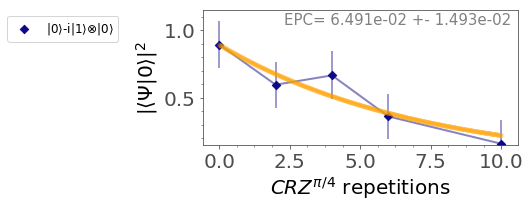

In [158]:
plt.rcParams.update(params)

fname = common_params['data_path'] + r"\2023\06\20230602\PulsedMeasurement\nrep_cphase_3" + "\\" \
        + "20230603-1141-07_rand_benchmark_pulsed_measurement.dat"
try:
    fname = os.path.normpath(fname)
    p_data = Tk_file.load_pulsed_result(fname)
except:
    logger.exception("")

p_data['data'] = p_inject['data']
p_data['exp_params']['rotations'] = p_inject['exp_params']['rotations']
    
split_before = TomoRotations.c2phase1_dd
fit_on = 'delta'
perform_fit = True
calc_mean_datapoint = False
z_ref = 0.372302

plot_bench_data(p_data, annotate_vals=['EPC'], split_before=split_before, split_idx_start=0, lineplot=True,
        idx_plot=[0,1], plot_err=True)
plt.legend(prop={'size': 12}, bbox_to_anchor=(-0.25,1.0))
plt.xlabel(r"$CRZ^{\pi/4}$ repetitions")
plt.ylim([0.15, 1.15])

plt.tight_layout()
plt.savefig(savepath + r'\\20230622_nrep_cphase_5_pcs_1.png', dpi=300)
plt.show()


plt.rcParams.update(default_params)



In [383]:
savepath + '\20230622_nrep_cphase_5_pcs_1.png'

'C:\\Users\\Setup3-PC\\Desktop\\_poster_figs\x8230622_nrep_cphase_5_pcs_1.png'

## 2Q RB(n_cliff=fix) vs Rabi

In [728]:
0

0

(array([0.    , 2.0019, 2.002 , 2.0021, 2.0022, 2.0023, 2.0024, 2.0025,
       2.0026, 2.0027, 2.0028, 2.0029, 2.003 , 2.0031, 2.0032, 2.0033,
       2.0034, 2.0035, 2.0036, 2.0037]), array([0.04423797, 0.04383754, 0.05188169, 0.07076313, 0.09720052,
       0.12601593, 0.15857476, 0.19256901, 0.22844018, 0.263463  ,
       0.29964823, 0.33377013, 0.36712923, 0.39913853, 0.42788509,
       0.45476606, 0.48184266, 0.50464526, 0.52438558, 0.54605496,
       0.56322817, 0.57921584, 0.59528268, 0.60883729, 0.62058989,
       0.63300734]))

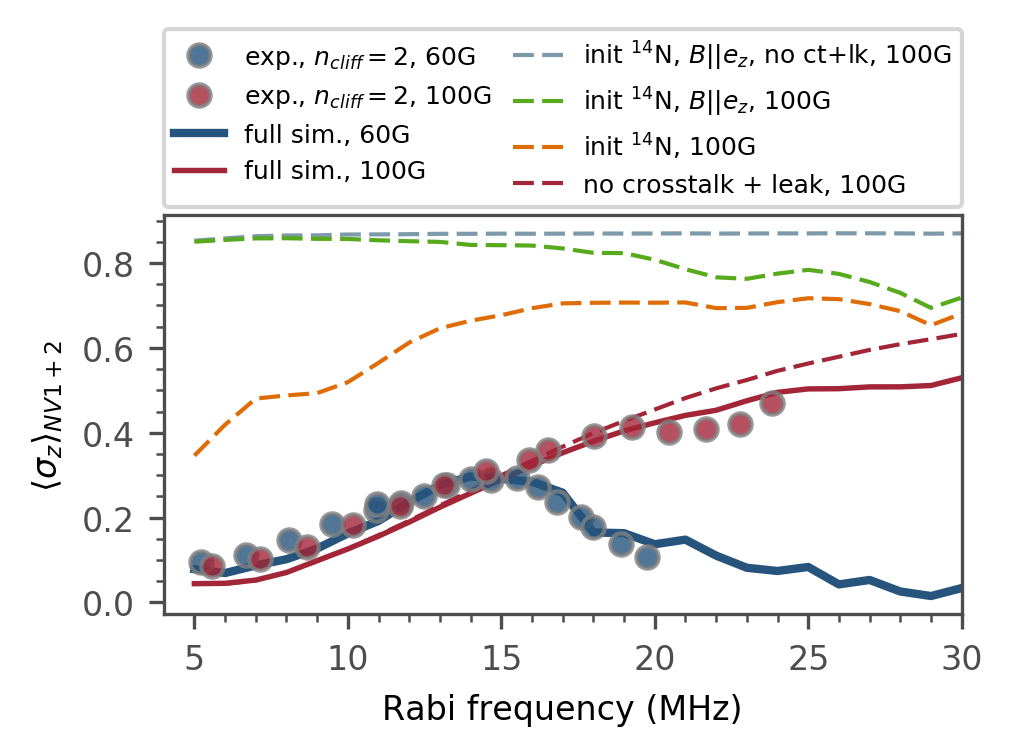

In [99]:
# new simdata 20240305

scale_fac = [1, 1e-6]

plot_labels = ["tau2 (ns)", "tau1 "]
plot_labels = ["n_rand", "p_scale", "|00> pop. RB"]
plot_labels = ["n_rand", "Rabi frequency (MHz)", r"$|\langle \Psi |0 \rangle |^2$"]
plot_labels = ["n_rand", "Rabi frequency (MHz)", r"Survival probability"]



idx_cut_y = 1
n_per_cliff = 19  # only take data at n_cliff= 1
n_cliff_target = 2
idx_cut_x = -1
plot_mode = "delta_norm"  # 'delta_norm'
#plot_mode = "delta"  # 'delta_norm'
#plot_mode = "z1"
norm_func = norm_on_2dref
norm_func = norm_on_1st_col
norm_func = norm_on_1st_col_avg_row
#norm_func = avg_row

cut_mode = "delta"
cut_mode = "delta_norm"
alternating_prefix = 'pi_'
alternating_mode = 'delta'
#alternating_mode = 'z1'


y0_rb_per_field = [1.144, 0.871]
if alternating_mode == 'z1':
    y0_rb_per_field = [1.144, 0.871]
    
name_per_field = ["60G", "100G"]
#name_per_field = [r"$B_1$", r"$B_2$"]

try:
    plt.figure(figsize=(3.5,2.5)) # paper
    #plt.figure(figsize=(4,3)) # debug

    # 60 G data
    folder = common_params['data_path'] + r"\2023\09\20230914\PulsedMeasurement\rb_2q_vs_rabi_3"
    folder = common_params['data_path'] + r"\2023\12\20231214\PulsedMeasurement\old_mag_setting_60G_1\rb_2q_vs_rabi_ncliff=2_1"
    folder = common_params['data_path'] + r"\2023\12\20231219\PulsedMeasurement\rb_2q_vs_rabi_60G_fixRefRabi_1"
    #folder = r"E:\Data\2023\12\20231213\PulsedMeasurement\new_mag_setting_30G_3\rb_2q_vs_rabi_30G_new_2"
    
    #copy_to_path(folder)
    x, y, z1s, z2s, p_raw = _load_2q_vs_rabi(folder)  
    # debug only
    #z2s[:,:] = 0#-z2s
    #z1s[:,:] = 0
    #z1s = 4*z1s - 3.5 
    #z2s =  -4*z2s + 3.5 
    
    data_slice = [1, 1+n_per_cliff]
    data_slice = [1+(n_cliff_target-1)*n_per_cliff, 1+(n_cliff_target-1)*n_per_cliff+n_per_cliff]   # mask data at higher n_cliff
    
    #x = x[data_slice[0]:data_slice[1]]
    x = np.concatenate((x[0:1], x[data_slice[0]:data_slice[1]]))
    if not np.all(np.abs(x[1:] - np.mean(x[1:])) <= 0.1):
        raise ValueError(f"Slicing went wrong, x= {x}")
    #z1s, z2s = z1s[:,data_slice[0]:data_slice[1]], z2s[:,data_slice[0]:data_slice[1]]
    z1s = np.concatenate((z1s[:, 0:1], z1s[:, data_slice[0]:data_slice[1]]), axis=1)
    z2s = np.concatenate((z2s[:, 0:1], z2s[:, data_slice[0]:data_slice[1]]), axis=1)
        

    extent = [x[0]*scale_fac[0], x[-1]*scale_fac[0], y[0]*scale_fac[1], y[-1]*scale_fac[1]]
    x_plot_1, y_plot_1 = plot_2d_series_cut(x, y, z1s, z2s, 
                       idx_cut_x=1, label=r"exp., $n_{cliff}=" + f"{n_cliff_target}$, " + name_per_field[0])
    y_min_60g, y_max_60g = np.min(y_plot_1), np.max(y_plot_1)
    
    # 100 G data
    plot_exp_100g = True
    folder = common_params['data_path'] + r"\2023\10\20231017\PulsedMeasurement\rb_2q_vs_rabi_calib_deer_dd=0.5,0.5_3"
    folder = common_params['data_path'] + r"\2023\11\20231124\PulsedMeasurement\rb_2q_vs_rabi_2"
    folder = common_params['data_path'] + r"\2023\12\20231201\PulsedMeasurement\rb2q_vs_rabi_swappedNV_1"
    folder = common_params['data_path'] + r"\2023\12\20231201\PulsedMeasurement\rb2q_vs_rabi_swappedNV_2"
    folder = common_params['data_path'] + r"\2023\12\20231204\PulsedMeasurement\rb_2q_swappedNV_vs_rabi_3"
    folder = common_params['data_path'] + r"\2023\12\20231205\PulsedMeasurement\rb_2q_swappedNV_n_cliff=4_4"
    folder = common_params['data_path'] + r"\2023\12\20231220\PulsedMeasurement\rb_2q_100G_fixRefRabis_2"
    
    copy_to_path(folder)
    x, y, z1s, z2s, p_raw = _load_2q_vs_rabi(folder)    

    #data_slice = [1, 1+n_per_cliff]
    data_slice = [1+(n_cliff_target-1)*n_per_cliff, 1+(n_cliff_target-1)*n_per_cliff+n_per_cliff]   # mask data at higher n_cliff
    
    #x = x[data_slice[0]:data_slice[1]]
    x = np.concatenate((x[0:1], x[data_slice[0]:data_slice[1]]))
    if not np.all(np.abs(x[1:] - np.mean(x[1:])) <= 0.1):
        raise ValueError(f"Slicing went wrong, x= {x}")
    #z1s, z2s = z1s[:,data_slice[0]:data_slice[1]], z2s[:,data_slice[0]:data_slice[1]]
    z1s = np.concatenate((z1s[:, 0:1], z1s[:, data_slice[0]:data_slice[1]]), axis=1)
    z2s = np.concatenate((z2s[:, 0:1], z2s[:, data_slice[0]:data_slice[1]]), axis=1)
    
    if plot_exp_100g:
        x_plot_2, y_plot_2 = plot_2d_series_cut(x, y, z1s, z2s,
                           plot_mode=plot_mode, cut_mod=cut_mode, 
                           lineplot=False, idx_datas=2,
                           idx_cut_x=1, label=r"exp., $n_{cliff}=" + f"{n_cliff_target}$, " + name_per_field[1])
        y_min_100g, y_max_100g = np.min(y_plot_2), np.max(y_plot_2)


    # Simulations
    inpath = common_params['data_path'] + r"\2023\10\20231030\simulation_julich\20231219_swappedNVs_ncliff=2_alt\rb_ncliff=2"
    
    inpath_60g = common_params['data_path'] +  r"\2023\10\20231030\simulation_julich\20240306_rb_full_geo_3\rb_ncliff=2_60G"
    inpath_100g = common_params['data_path'] + r"\2023\10\20231030\simulation_julich\20240306_rb_full_geo_3\rb_ncliff=2_100G"
    
    inpath_60g = common_params['data_path'] +  r"\2023\10\20231030\simulation_julich\20240307_rb_full_all_geos_4\pp_d\04a - Randomized Benchmarking\rb_ncliff=2_60G"
    inpath_100g = common_params['data_path'] + r"\2023\10\20231030\simulation_julich\20240307_rb_full_all_geos_4\pp_d\04a - Randomized Benchmarking\rb_ncliff=2_100G"
    
    
    
    fnames = Tk_file.list_mult_pulsed_mes(inpath, filter_strs=['.npz'], incl_subdir=False)
    labels = [os.path.basename(f) for f in fnames]
    labels = [f.replace(".npz","") for f in labels]
    
    
    sims_60g, sims_100g = [], []
    
    for idx_b, path in enumerate([inpath_60g, inpath_100g]):
        copy_to_path(path)
        fnames = Tk_file.list_mult_pulsed_mes(path, filter_strs=['.npz'], incl_subdir=False)
        
        for f in fnames:
            if idx_b == 0:
                sims_60g.append(load_sim(f))
            elif idx_b == 1:
                sims_100g.append(load_sim(f))
    
   
   
    
    sims_60g_raw, sims_100g_raw = sims_60g, sims_100g
    _, labels_raw = extract_sims_2(sims_60g[0], data_mode=alternating_mode)
    sims_60g, labels_alt = extract_sims_2(sims_60g[0],   data_mode=alternating_mode,
                                          excl_label=['_std','meas_mean_init_nuc_spin+no_ctleak','Azz_off'], 
                                          order_list= ['meas_mean',  'meas_mean_hfoff+noctleak', 'meas_mean_hfoff', 'meas_mean_init_nuc_spin', 'meas_mean_no_ctleak'])
    sims_100g, labels_alt = extract_sims_2(sims_100g[0], data_mode=alternating_mode,
                                          excl_label=['_std','meas_mean_init_nuc_spin+no_ctleak', 'Azz_off'],
                                          order_list= ['meas_mean',  'meas_mean_hfoff+noctleak', 'meas_mean_hfoff', 'meas_mean_init_nuc_spin', 'meas_mean_no_ctleak'])
    sims_100g_z1, _ = extract_sims_2(sims_100g_raw[0], data_mode='z1',
                                          excl_label=['_std','meas_mean_init_nuc_spin+no_ctleak', 'Azz_off'],
                                          order_list= ['meas_mean',  'meas_mean_hfoff+noctleak', 'meas_mean_hfoff', 'meas_mean_init_nuc_spin', 'meas_mean_no_ctleak'])
    
    

    
    labels = labels_alt
    
    # rename labels for nice plotting
    rule_rename = {"meas_mean": "full_sim",}
    labels = rename_strings(labels, rule_rename, exact_match=True)
    
    rule_replace = {"meas_mean_": "",
                   "+":"_"}
    labels = rename_strings(labels, rule_replace, exact_match=False)
    
    
    rule_rename = {'hfoff_noctleak': "init ${}^{14}$N, $B || e_z$, no ct+lk",
               'hfoff': "init ${}^{14}$N, $B || e_z$",
               'init_nuc_spin': 'init ${}^{14}$N', 'full_sim': 'full sim.', 
               'no_ctleak': 'no crosstalk + leak'}
    labels_plot = rename_strings(labels, rule_rename, exact_match=False)
    
     # 60 G sim
    plot_only_exp_sim = True
    
    for idx, s in enumerate(sims_60g):
        label = labels_plot[idx] + ", " + name_per_field[0] 
        
        target_range = [-1,1]
        sim_range = [-1,1]  if alternating_mode is 'delta' else [0,1]
        y = _norm_sim_2_exp(s['data']['y'], rb_y0=y0_rb_per_field[0],
                           orig_range=sim_range, new_range=target_range)
        
        
        color = plt_settings.get_cmap(False)((idx)/(len(sims_60g)))
        is_exp_sim = 'full' in label
        linestyle = 'solid' if is_exp_sim else 'dotted'
        color = plt_settings.color('blue') if is_exp_sim else color
        
        if not plot_only_exp_sim or (plot_only_exp_sim and is_exp_sim):
            plt.plot(s['data']['x'], y, label=label, marker="",
                     linestyle=linestyle, color=color)
    
    # 100 G sim
    plot_sim_100g = True
    plot_only_exp_sim = False
    for idx, s in enumerate(sims_100g):
        if plot_sim_100g:
            label = labels_plot[idx] + ", " + name_per_field[1] 
            
            target_range = [-1,1]
            sim_range = [-1,1]  if alternating_mode is 'delta' else [0,1]
            y = _norm_sim_2_exp(s['data']['y'], rb_y0=y0_rb_per_field[1],
                           orig_range=sim_range, new_range=target_range)

            color = plt_settings.get_cmap(False)((idx)/(len(sims_100g)))
            is_exp_sim = 'full' in label
            linestyle = 'solid' if is_exp_sim else (0, (5,2))

            linewidth = 1.3 if is_exp_sim else 1.0
            
            color = plt_settings.color('red') if is_exp_sim else color

            if not plot_only_exp_sim or (plot_only_exp_sim and is_exp_sim):
                plt.plot(s['data']['x'], y, label=label, 
                         marker="", linestyle=linestyle, color=color, linewidth=linewidth)
    
    

    plt.xlim([4, 30])
    #plt.ylim([-0.05,0.8])
    #plt.ylim([-0.5,0.8])
    #plt.ylim([0.0,1])
    
    #plt.yscale("log")
    #plt.ylim([0.05,0.9])
    
    plt.ylabel(r'$\langle \sigma_z \rangle_{NV1+2}$')
    
    #plt.annotate(f"norm sim: y'={y0_rb_per_field}*y", 
    #             xy=(0.98,0.12), xycoords='axes fraction', color='grey',
    #             va='top', ha='right', fontsize=6)

    #plt.legend(loc='lower center', prop={'size': 4}).set_zorder(100)
    #plt.legend(loc='lower center').set_zorder(100)
    
    plt.legend(ncol=2, loc='lower left',
              bbox_to_anchor=(0., 1.02, 1., .102),
               mode="expand", borderaxespad=0.,
              )
    
    
    plt_settings.savefig('rb_2q_vs_rabi.png', frame_top_inch=0.62)
    plt.show()
except:
    logger.exception("")
    
x,y

#### old sim data

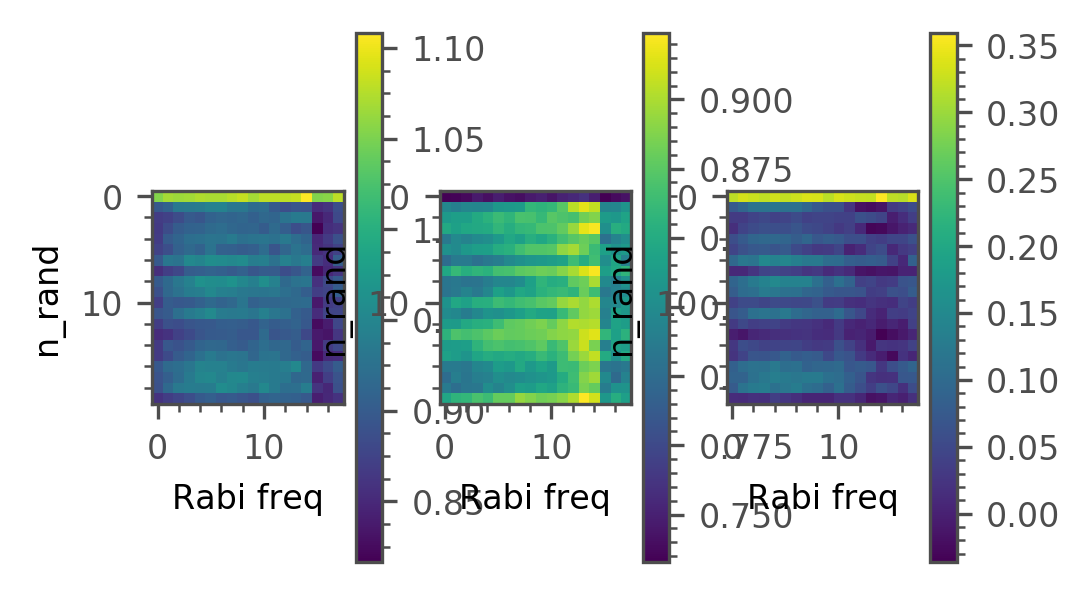

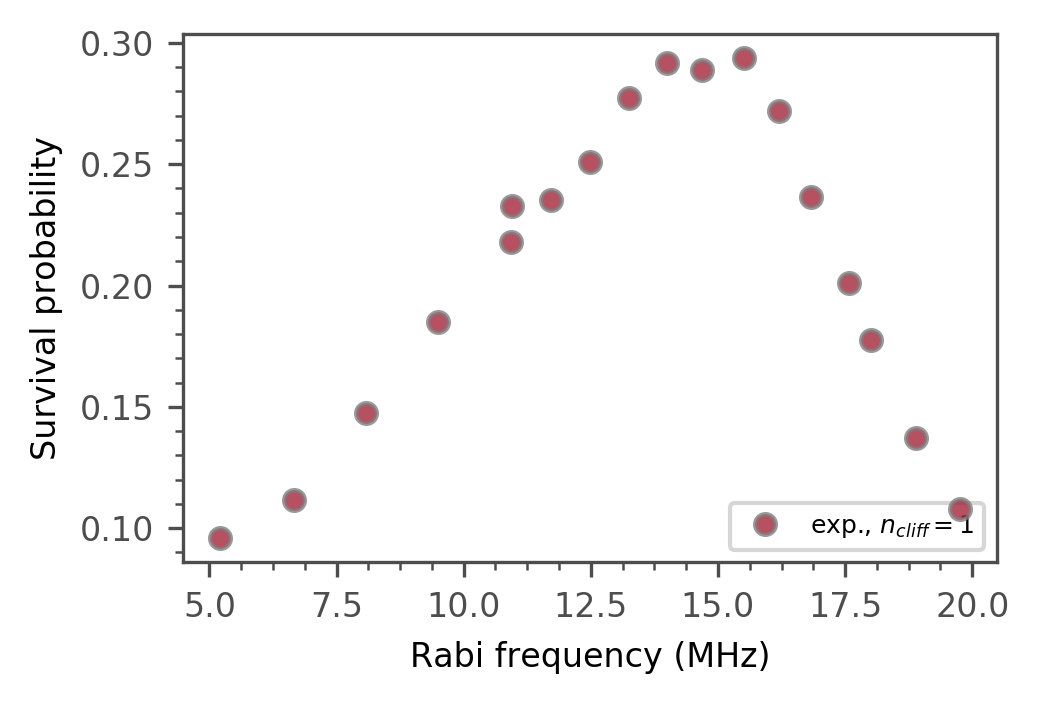

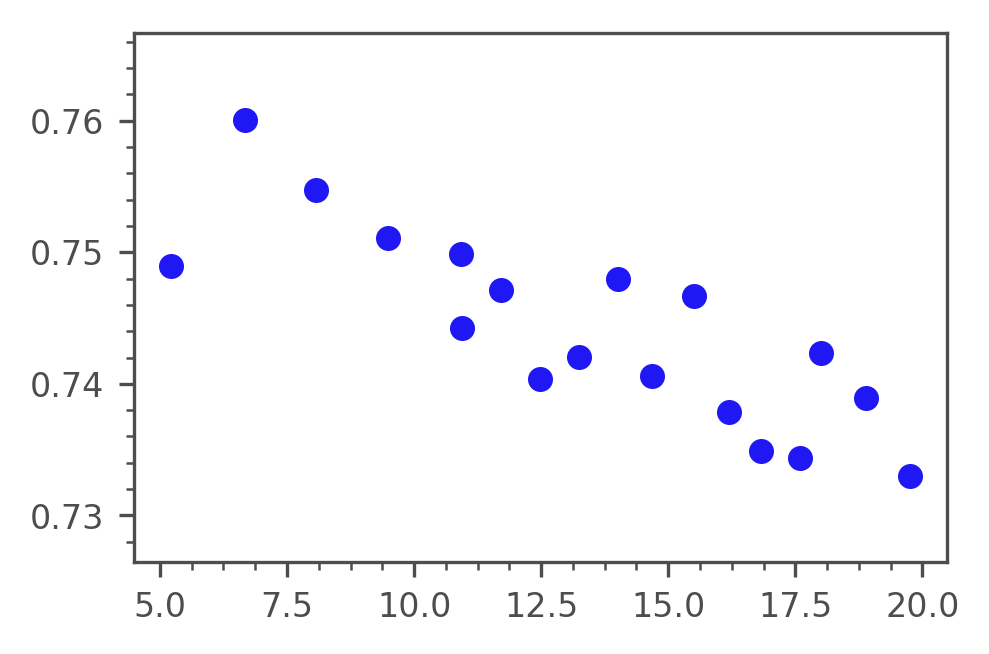

In [91]:
idx_cut_y = 1
n_cliff_target = 2
n_per_cliff = 19  # only take data at n_cliff= 1
idx_cut_x = -1
plot_mode = "delta_norm"  # 'delta_norm'
cut_mode = "delta_norm"
norm_func = norm_on_1st_col_avg_row
#norm_func = norm_on_1st_col_nonalt_avg_row
#norm_func = norm_on_1st_fix_rabi_col_avg_row

scale_fac = [1, 1e-6]

try:


    folder = common_params['data_path'] + r"\2023\11\20231124\PulsedMeasurement\rb_2q_vs_rabi_2"
    folder = common_params['data_path'] + r"\2023\12\20231201\PulsedMeasurement\rb2q_vs_rabi_swappedNV_2"
    folder = common_params['data_path'] + r"\2023\12\20231213\PulsedMeasurement\new_mag_setting_30G_3\rb_2q_vs_rabi_30G_new_2"
    folder = common_params['data_path'] + r"\2023\12\20231214\PulsedMeasurement\old_mag_setting_60G_1\rb_2q_vs_rabi_ncliff=2_1"
    folder = common_params['data_path'] + r"\2023\12\20231219\PulsedMeasurement\rb_2q_vs_rabi_60G_fixRefRabi_1"
    
    x, y, z1s, z2s, p_raw = _load_2q_vs_rabi(folder)  
    #z1s[:,:] = 0
    #z2s[:,:] = 0#-z2s
  
    data_slice = [1+(n_cliff_target-1)*n_per_cliff, 1+(n_cliff_target-1)*n_per_cliff+n_per_cliff]   # mask data at higher n_cliff

    #x = x[data_slice[0]:data_slice[1]]
    x = np.concatenate((x[0:1], x[data_slice[0]:data_slice[1]]))
    if not np.all(np.abs(x[1:] - np.mean(x[1:])) <= 0.1):
        raise ValueError(f"Slicing went wrong, x= {x}")
    
        
    z1s = np.concatenate((z1s[:, 0:1], z1s[:, data_slice[0]:data_slice[1]]), axis=1)
    z2s = np.concatenate((z2s[:, 0:1], z2s[:, data_slice[0]:data_slice[1]]), axis=1)
  
    plt.subplot(131)
    plt.imshow(z1s.T)
    plt.ylabel("n_rand")
    plt.xlabel("Rabi freq")
    plt.colorbar()
    
    plt.subplot(132)
    plt.imshow(z2s.T)
    plt.ylabel("n_rand")
    plt.xlabel("Rabi freq")
    plt.colorbar()
    
    plt.subplot(133)
    plt.imshow(z1s.T-z2s.T)
    plt.ylabel("n_rand")
    plt.xlabel("Rabi freq")
    plt.colorbar()
    plt.show()

    #x, y, z1s, z2s, p_raw = _load_2q_vs_rabi(folder)     
    x_plot, y_plot = plot_2d_series_cut(x, y, z1s, z2s,
                       plot_mode=plot_mode, cut_mod=cut_mode, 
                       lineplot=False, idx_datas=2, 
                       idx_cut_x=1, label=r"exp., $n_{cliff}=1$")
    
    #plt.ylim([-0., 0.3])
    
    y_min_100g, y_max_100g = np.min(y_plot), np.max(y_plot)

except:
    logger.exception("")
    
plt.show()

z_norm_on = z2s[:,0]#-z2s[:,0]
plt.scatter(x_plot, z_norm_on)
plt.show()

#plt.plot(z1s[:,0])
#plt.show()



(array([0.    , 2.0019, 2.002 , 2.0021, 2.0022, 2.0023, 2.0024, 2.0025,
       2.0026, 2.0027, 2.0028, 2.0029, 2.003 , 2.0031, 2.0032, 2.0033,
       2.0034, 2.0035, 2.0036, 2.0037]), array([0.03805856, 0.03532084, 0.05013729, 0.07253157, 0.09832238,
       0.13036859, 0.16312206, 0.19809505, 0.23227058, 0.26972699,
       0.30746024, 0.34444426, 0.38113078, 0.41259806, 0.44774374,
       0.47722983, 0.50170883, 0.52734534, 0.54869663, 0.56880136,
       0.5897646 , 0.60733772, 0.62271944, 0.63840253, 0.65097427,
       0.66473389]))

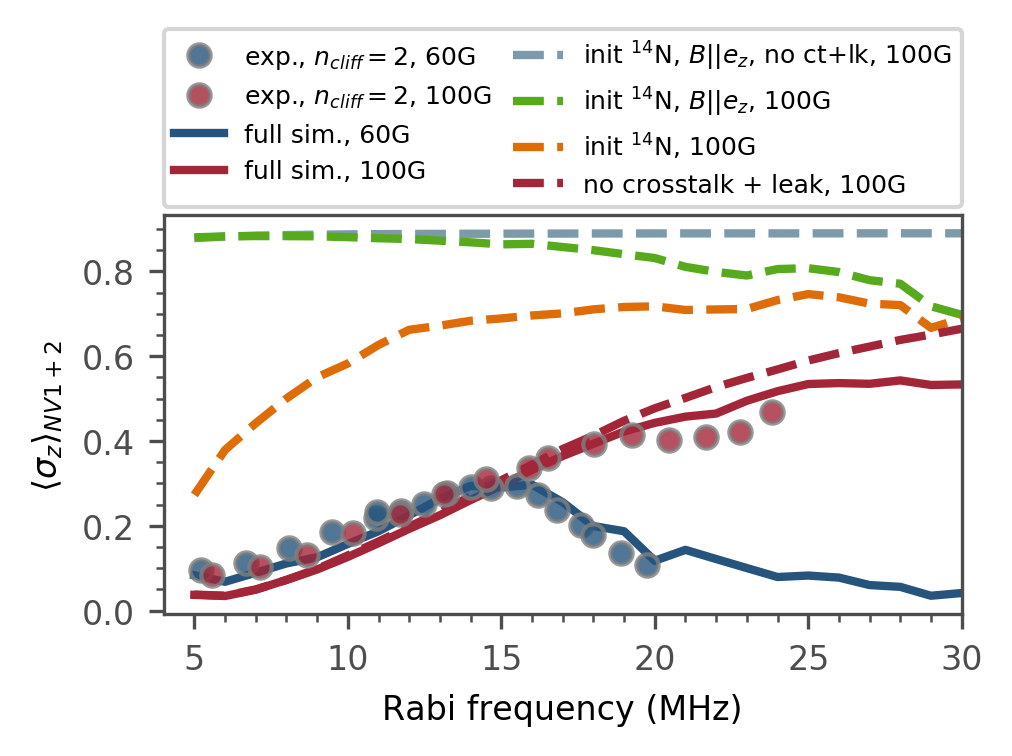

In [95]:

scale_fac = [1, 1e-6]

plot_labels = ["tau2 (ns)", "tau1 "]
plot_labels = ["n_rand", "p_scale", "|00> pop. RB"]
plot_labels = ["n_rand", "Rabi frequency (MHz)", r"$|\langle \Psi |0 \rangle |^2$"]
plot_labels = ["n_rand", "Rabi frequency (MHz)", r"Survival probability"]



idx_cut_y = 1
n_per_cliff = 19  # only take data at n_cliff= 1
n_cliff_target = 2
idx_cut_x = -1
plot_mode = "delta_norm"  # 'delta_norm'
#plot_mode = "delta"  # 'delta_norm'
#plot_mode = "z1"
norm_func = norm_on_2dref
norm_func = norm_on_1st_col
norm_func = norm_on_1st_col_avg_row
#norm_func = avg_row

cut_mode = "delta"
cut_mode = "delta_norm"
alternating_prefix = 'pi_'
alternating_mode = 'delta'
#alternating_mode = 'z1'

y0_rb_per_field = [1.2, 0.75]
y0_rb_per_field = [1.2, 0.823]
y0_rb_per_field = [1, 1]
y0_rb_per_field = [1.11, 0.89]
if alternating_mode == 'z1':
    y0_rb_per_field = [1.11, 0.89]
    
name_per_field = ["60G", "100G"]
#name_per_field = [r"$B_1$", r"$B_2$"]

try:
    plt.figure(figsize=(3.5,2.5)) # paper
    #plt.figure(figsize=(4,3)) # debug

    # 60 G data
    folder = common_params['data_path'] + r"\2023\09\20230914\PulsedMeasurement\rb_2q_vs_rabi_3"
    folder = common_params['data_path'] + r"\2023\12\20231214\PulsedMeasurement\old_mag_setting_60G_1\rb_2q_vs_rabi_ncliff=2_1"
    folder = common_params['data_path'] + r"\2023\12\20231219\PulsedMeasurement\rb_2q_vs_rabi_60G_fixRefRabi_1"
    #folder = r"E:\Data\2023\12\20231213\PulsedMeasurement\new_mag_setting_30G_3\rb_2q_vs_rabi_30G_new_2"
    
    copy_to_path(folder)
    x, y, z1s, z2s, p_raw = _load_2q_vs_rabi(folder)  
    # debug only
    #z2s[:,:] = 0#-z2s
    #z1s[:,:] = 0
    #z1s = 4*z1s - 3.5 
    #z2s =  -4*z2s + 3.5 
    
    data_slice = [1, 1+n_per_cliff]
    data_slice = [1+(n_cliff_target-1)*n_per_cliff, 1+(n_cliff_target-1)*n_per_cliff+n_per_cliff]   # mask data at higher n_cliff
    
    #x = x[data_slice[0]:data_slice[1]]
    x = np.concatenate((x[0:1], x[data_slice[0]:data_slice[1]]))
    if not np.all(np.abs(x[1:] - np.mean(x[1:])) <= 0.1):
        raise ValueError(f"Slicing went wrong, x= {x}")
    #z1s, z2s = z1s[:,data_slice[0]:data_slice[1]], z2s[:,data_slice[0]:data_slice[1]]
    z1s = np.concatenate((z1s[:, 0:1], z1s[:, data_slice[0]:data_slice[1]]), axis=1)
    z2s = np.concatenate((z2s[:, 0:1], z2s[:, data_slice[0]:data_slice[1]]), axis=1)
        

    extent = [x[0]*scale_fac[0], x[-1]*scale_fac[0], y[0]*scale_fac[1], y[-1]*scale_fac[1]]
    x_plot_1, y_plot_1 = plot_2d_series_cut(x, y, z1s, z2s, 
                       idx_cut_x=1, label=r"exp., $n_{cliff}=" + f"{n_cliff_target}$, " + name_per_field[0])
    y_min_60g, y_max_60g = np.min(y_plot_1), np.max(y_plot_1)
    
    # 100 G data
    plot_exp_100g = True
    folder = common_params['data_path'] + r"\2023\10\20231017\PulsedMeasurement\rb_2q_vs_rabi_calib_deer_dd=0.5,0.5_3"
    folder = common_params['data_path'] + r"\2023\11\20231124\PulsedMeasurement\rb_2q_vs_rabi_2"
    folder = common_params['data_path'] + r"\2023\12\20231201\PulsedMeasurement\rb2q_vs_rabi_swappedNV_1"
    folder = common_params['data_path'] + r"\2023\12\20231201\PulsedMeasurement\rb2q_vs_rabi_swappedNV_2"
    folder = common_params['data_path'] + r"\2023\12\20231204\PulsedMeasurement\rb_2q_swappedNV_vs_rabi_3"
    folder = common_params['data_path'] + r"\2023\12\20231205\PulsedMeasurement\rb_2q_swappedNV_n_cliff=4_4"
    folder = common_params['data_path'] + r"\2023\12\20231220\PulsedMeasurement\rb_2q_100G_fixRefRabis_2"
    
    copy_to_path(folder)
    x, y, z1s, z2s, p_raw = _load_2q_vs_rabi(folder)    

    #data_slice = [1, 1+n_per_cliff]
    data_slice = [1+(n_cliff_target-1)*n_per_cliff, 1+(n_cliff_target-1)*n_per_cliff+n_per_cliff]   # mask data at higher n_cliff
    
    #x = x[data_slice[0]:data_slice[1]]
    x = np.concatenate((x[0:1], x[data_slice[0]:data_slice[1]]))
    if not np.all(np.abs(x[1:] - np.mean(x[1:])) <= 0.1):
        raise ValueError(f"Slicing went wrong, x= {x}")
    #z1s, z2s = z1s[:,data_slice[0]:data_slice[1]], z2s[:,data_slice[0]:data_slice[1]]
    z1s = np.concatenate((z1s[:, 0:1], z1s[:, data_slice[0]:data_slice[1]]), axis=1)
    z2s = np.concatenate((z2s[:, 0:1], z2s[:, data_slice[0]:data_slice[1]]), axis=1)
    
    if plot_exp_100g:
        x_plot_2, y_plot_2 = plot_2d_series_cut(x, y, z1s, z2s,
                           plot_mode=plot_mode, cut_mod=cut_mode, 
                           lineplot=False, idx_datas=2,
                           idx_cut_x=1, label=r"exp., $n_{cliff}=" + f"{n_cliff_target}$, " + name_per_field[1])
        y_min_100g, y_max_100g = np.min(y_plot_2), np.max(y_plot_2)


    # Simulations
    inpath = r"E:\Data\2023\10\20231030\simulation_julich\20231122_rb_updates\n_cliff=1_vs_rabi"
    inpath = r"E:\Data\2023\10\20231030\simulation_julich\20231123_correctTransitions\n_cliff=1_vs_rabi"
    inpath = r"E:\Data\2023\10\20231030\simulation_julich\20231129_correctTransitions+Contrast\rb_ncliff=1"
    inpath = r"E:\Data\2023\10\20231030\simulation_julich\20231204_swappedNVs\02-12-2023_goodXY8_sym\rb_ncliff=1"
    inpath = common_params['data_path'] + r"\2023\10\20231030\simulation_julich\20231206_swappedNVs_ncliff=2\rb_ncliff=2"
    inpath = common_params['data_path'] + r"\2023\10\20231030\simulation_julich\20231219_swappedNVs_ncliff=2_alt\rb_ncliff=2"
    
    #copy_to_path(inpath)
    fnames = Tk_file.list_mult_pulsed_mes(inpath, filter_strs=['.npz'], incl_subdir=False)
    
    idx_orders = [4,2,1,3,0,5] 
    idx_orders = [0,2,1,3,4,5] 
    idx_orders = idx_orders + list(range(max(idx_orders)+1, len(fnames)))

    fnames = [fn for fn, order in sorted(zip(fnames, idx_orders), key=lambda pair: pair[1])]
    
    
    rule_replace = {"rand_bench_ncliff=1_": "",
                    "rb_ncliff=1_": "",
                    ".npz": "",
                    "rand_bench_ncliff=1": "full_sim",
                    "rb_ncliff=1": "full_sim",
                    "rand_bench_ncliff=2_": "",
                    "rand_bench_ncliff=2": "full_sim",
                    "rb_ncliff=2_": "",
                    "rb_ncliff=2": "full_sim",}
                    
    #labels = [os.path.basename(f).replace("rand_bench_ncliff=1_","").replace(".npz","").replace("rand_bench_ncliff=1","full sim") for f in fnames]
    labels = [os.path.basename(f) for f in fnames]
    labels = rename_strings(labels, rule_replace)
    labels = [el if not el=='pi' else 'pi_full_sim' for el in labels] # special case not handled by rule_replace
    
    rule_rename = {'hfoff_noctleak': "init ${}^{14}$N, $B || e_z$, no ct+lk",
                   'hfoff': "init ${}^{14}$N, $B || e_z$",
                   'init_nuc_spin': 'init ${}^{14}$N', 'full_sim': 'full sim.', 
                   'no_ctleak': 'no crosstalk + leak'}
   
    
    
    sims_60g, sims_100g = [], []
    # 60 G sim
    plot_only_exp_sim = True
    
    for f in fnames:
        #pass
        sims_60g.append(load_sim(f, y_key='meas_old'))
        sims_100g.append(load_sim(f, y_key='meas_new'))
    
    # convert to alternating, if simulation data with additional pi pulses available
    sims_60g_raw, sims_100g_raw = sims_60g, sims_100g
    labels_raw = labels
    sims_60g, labels_alt = raw_2_alt(sims_60g, labels, 
                            data_mode=alternating_mode, alt_prefix=alternating_prefix)
    sims_100g, labels_alt = raw_2_alt(sims_100g, labels, 
                            data_mode=alternating_mode, alt_prefix=alternating_prefix)
    sims_100g_z1, labels_z1 = raw_2_alt(sims_100g_raw, labels,   # for error contributions in cell below
                            data_mode='z1')
    labels = labels_alt
    labels_plot = rename_strings(labels, rule_rename)
    
    for idx, s in enumerate(sims_60g):
        label = labels_plot[idx] + ", " + name_per_field[0] 
        
        target_range = [-1,1]
        sim_range = [-1,1]  if alternating_mode is 'delta' else [0,1]
        y = _norm_sim_2_exp(s['data']['y'], rb_y0=y0_rb_per_field[0],
                           orig_range=sim_range, new_range=target_range)
        
        
        color = plt_settings.get_cmap(False)((idx)/(len(sims_60g)))
        is_exp_sim = 'full' in label
        linestyle = 'solid' if is_exp_sim else 'dotted'
        color = plt_settings.color('blue') if is_exp_sim else color
        
        if not plot_only_exp_sim or (plot_only_exp_sim and is_exp_sim):
            plt.plot(s['data']['x'], y, label=label, marker="",
                     linestyle=linestyle, color=color)
    
    # 100 G sim
    plot_sim_100g = True
    plot_only_exp_sim = False
    for idx, s in enumerate(sims_100g):
        if plot_sim_100g:
            label = labels_plot[idx] + ", " + name_per_field[1] 
            
            target_range = [-1,1]
            sim_range = [-1,1]  if alternating_mode is 'delta' else [0,1]
            y = _norm_sim_2_exp(s['data']['y'], rb_y0=y0_rb_per_field[1],
                           orig_range=sim_range, new_range=target_range)

            color = plt_settings.get_cmap(False)((idx)/(len(sims_100g)))
            is_exp_sim = 'full' in label
            linestyle = 'solid' if is_exp_sim else 'dashed'
            #linestyle = 'solid'
            
            color = plt_settings.color('red') if is_exp_sim else color

            if not plot_only_exp_sim or (plot_only_exp_sim and is_exp_sim):
                plt.plot(s['data']['x'], y, label=label, 
                         marker="", linestyle=linestyle, color=color)
    
    
    plot_old_sim = False
    if plot_old_sim:
        fname = common_params['data_path'] + r"\2023\10\20231030\simulation_julich" + "\\" \
            + r"rand_bench_ncliff=1.npz"
            # + r"20231030_simFerlemann_cphase_vs_rabi.csv"

        if '.npz' in fname:
            data_sim = np.load(fname)
            x, y = data_sim['Rabi_freq'], -data_sim['meas_old'] +0.1 # -data_sim['meas_old'] +0.1
            #['', 'meas_old', 'meas_new']

        y = y/np.max(y) # norm to 1
        y = y*y_max_60g # align with max of exp data

        plt.plot(x,y, marker="", color=plt_settings.color('bluelight'), label="Sim, 60 G, y'=-(y + 0.1)*y_exp_max/y_sim_max")
    
    plt.xlim([4, 30])
    #plt.ylim([-0.05,0.8])
    #plt.ylim([-0.5,0.8])
    #plt.ylim([0.0,1])
    
    #plt.yscale("log")
    #plt.ylim([0.05,0.9])
    
    plt.ylabel(r'$\langle \sigma_z \rangle_{NV1+2}$')
    
    #plt.annotate(f"norm sim: y'={y0_rb_per_field}*y", 
    #             xy=(0.98,0.12), xycoords='axes fraction', color='grey',
    #             va='top', ha='right', fontsize=6)

    #plt.legend(loc='lower center', prop={'size': 4}).set_zorder(100)
    #plt.legend(loc='lower center').set_zorder(100)
    
    plt.legend(ncol=2, loc='lower left',
              bbox_to_anchor=(0., 1.02, 1., .102),
               mode="expand", borderaxespad=0.,
              )
    
    
    #plt_settings.savefig('rb_2q_vs_rabi.png', frame_top_inch=0.62)
    plt.show()
except:
    logger.exception("")
    
x,y

### optimize norm factor for simulation

Simulation doesn't account for SPAM. So norm simulation by free parameter a.
Minimize a, such that the delta(sim, exp) becomes minimal.

In [2057]:
labels, idx

(['full_sim', 'hfoff_noctleak', 'hfoff', 'init_nuc_spin', 'no_ctleak'], 0)

('delta', [-1, 1], [-1, 1])

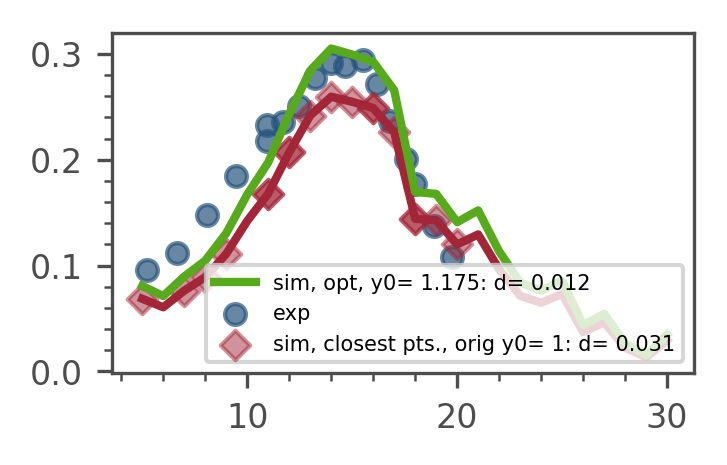

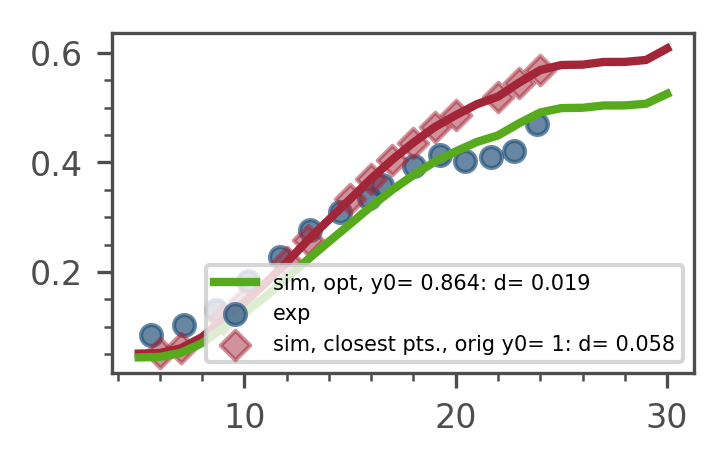

In [103]:
idx = labels.index('hfoff_noctleak')#labels_raw.index('hfoff_noctleak')
idx = labels.index('full_sim')
#x_sim, y_sim_raw = sims_60g[idx]['data']['x'], sims_60g[idx]['data']['y']
#x_exp, y_exp = x_plot_1, y_plot_1

#x_sim, y_sim_raw = sims_100g[idx]['data']['x'], sims_100g[idx]['data']['y']
#x_exp, y_exp = x_plot_2, y_plot_2


def find_close_data(x1, y1, x2, y2):
    assert len(x1) <= len(x2)
    
    close_x2, close_y2 = [], []
    
    for i, x_1 in enumerate(x1):
        idx_min = np.argmin(abs(x_1-x2))
        
        close_x2.append(x2[idx_min])
        close_y2.append(y2[idx_min])
        
    return np.asarray(close_x2), np.asarray(close_y2)

def calc_distance(x1, y1, x2, y2):
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

import scipy.optimize as opt
def optimize(func_obj, a_guess, *params_const):
    optimizer = opt.minimize(fun=func_obj,
                             args=params_const,
                             x0=a_guess)
    
    return optimizer.x[0]


def calc_delta_sim_exp(a, *args):
    x_sim = args[0]
    y_sim = args[1]
    x_exp = args[2]
    y_exp = args[3]
    
    x_sim_c, y_sim_c = find_close_data(x_exp, y_exp, x_sim, y_sim)
    # real distances in x, y
    #dists = calc_distance(x_sim_c, a*y_sim_c, x_exp, y_exp)**2
    
    # this is equivalent, since closes datapoints already taken
    # however, more pronounced since we drop the x distance, that we can't change anymore
    dists = calc_distance(x_sim_c, a*y_sim_c, x_sim_c, y_exp)**2

    #print(dists)
    
    return np.sum(dists)



for j, sims in enumerate([sims_60g, sims_100g]):
        
    idx = labels.index('hfoff_noctleak')#labels_raw.index('hfoff_noctleak')
    idx = labels.index('full_sim')
    x_sim, y_sim_raw =  sims[idx]['data']['x'],  sims[idx]['data']['y']
    if j==0:
        x_exp, y_exp = x_plot_1, y_plot_1
    else:
         x_exp, y_exp = x_plot_2, y_plot_2
        

    target_range = [-1,1]
    sim_range = [-1,1]  if alternating_mode is 'delta' else [0,1]
    y_sim_orig = _norm_sim_2_exp(y_sim_raw, rb_y0=1, orig_range=sim_range, new_range=target_range)
    x_sim_c, y_sim_c = find_close_data(x_exp, y_exp, x_sim, y_sim_orig)
    dist_orig = calc_delta_sim_exp(1, x_sim, y_sim_orig, x_exp, y_exp)

    plt.figure(figsize=(2.5,1.5))
    plt.scatter(x_exp, y_exp, label='exp',
                color=plt_settings.color('blue'), alpha=0.7)

    plt.plot(x_sim, y_sim_orig, marker="", color=plt_settings.color('red'))
    plt.scatter(x_sim_c, y_sim_c, label=f'sim, closest pts., orig y0= 1: d= {dist_orig:.3f}',
                color=plt_settings.color('red'), marker='D', alpha=0.5)

    y_opt = optimize(calc_delta_sim_exp, 0.5, x_sim, y_sim_orig, x_exp, y_exp)
    

    y_sim_opt = _norm_sim_2_exp(y_sim_raw, rb_y0=y_opt, orig_range=sim_range, new_range=target_range)
    dist_opt = calc_delta_sim_exp(y_opt, x_sim, y_sim_orig, x_exp, y_exp)
    
    plt.plot(x_sim, y_sim_opt, label=f'sim, opt, y0= {y_opt:.3f}: d= {dist_opt:.3f}',
             marker="", color=plt_settings.color('green'))
    plt.legend(prop={'size':5})
    
    
plt.show()

alternating_mode, sim_range, target_range

In [2060]:
sims_60g[0]['data'], y_sim_raw

({'x': array([ 5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17.,
       18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28., 29., 30.]), 'y': array([0.535, 0.527, 0.536, 0.544, 0.546, 0.562, 0.572, 0.586, 0.597,
       0.605, 0.59 , 0.575, 0.52 , 0.463, 0.457, 0.398, 0.409, 0.4  ,
       0.383, 0.377, 0.373, 0.37 , 0.366, 0.366, 0.35 , 0.36 ])}, array([0.535, 0.527, 0.536, 0.544, 0.546, 0.562, 0.572, 0.586, 0.597,
       0.605, 0.59 , 0.575, 0.52 , 0.463, 0.457, 0.398, 0.409, 0.4  ,
       0.383, 0.377, 0.373, 0.37 , 0.366, 0.366, 0.35 , 0.36 ]))

### error sources + fidelities
 


Details of norming:
While we're taking alternating data in the experiment and also simulate this in the plot above, this is dangerous for error contributions.
As the alternating readout pi pulse is only applied on one transition, taking the difference is canceling some (or even all?) of the leakage effect!
To have a fairer picture, when giving absolute fidelities and contributions, we directly extract from the simulation without any subtraction / alternation.

In [2120]:
[os.path.basename(f).replace('fidelity_comparison_old',"full_sim_old") for f in fnames]

['fid_hfoff_noctleak_old.npz', 'fid_hfoff_noctleak_new.npz', 'fid_hf_off_new.npz', 'fid_hf_off_old.npz', 'fid_init_nuc_spin_new.npz', 'fid_init_nuc_spin_old.npz', 'fid_new.npz', 'fid_no_ctleak_new.npz', 'fid_no_ctleak_old.npz']

In [2054]:
labels_f = [os.path.basename(f).replace('fidelity_comparison_old',"full_sim_old") for f in fnames]
labels_f = [l.replace('fidelity_comparison_new',"full_sim_new") for l in labels_f]
labels_f = [l.replace('fid_new', "full_sim") for l in labels_f]
labels_f = [l.replace('fid_', "") for l in labels_f]
labels_f = [l.replace('.npz','').replace('fidelity_comparison_',"") for l in labels_f]
labels_f

['hfoff_noctleak_new', 'hfoff_noctleak_old', 'hf_off_new', 'hf_off_old', 'init_nuc_spin_new', 'init_nuc_spin_old', 'full_sim', 'no_ctleak_new', 'no_ctleak_old', 'old']

In [517]:
ATTENTION: increased rtol = 2%

['decoherence', 'init $^{14}$N+$B || e_z$', 'init $^{14}$N', 'no ct.+leak.', 'full sim']

In [335]:
sims_rel = sims_100g_z1
rabi_target_mhz = 30

rabi_mhz, rel_errors = calc_rel_errors(sims_rel, labels, x_target=rabi_target_mhz,
                                       n_cliff=n_cliff, epc_2q=epc_t2_limit,
                                       convert_2_alpha=False, n_cliff_alpha=n_cliff_alpha,
                                       a_alpha=a_rb, y0_alpha=0)



sims_100g_z1[2], labels_f[2]

summables_keys = ['pol_n', 'no_ct_leak', 'no_B_misal', 'unattr/combis', 'unattr', 't2']
summable_dict = {key: val for key, val in rel_errors.items() if key in summables_keys}

summable_dict

{'t2': 0.10108672525370205, 'unattr': 0.0006114691158626284, 'pol_n': 0.3492677494075905, 'no_ct_leak': 0.40311828579019626, 'no_B_misal': 0.005410611768778717, 'unattr/combis': 0.14050515866386992}

(24.0, {'t2': 0.09667779809834563, 'unattr': 0.002520600734359002, 'pol_n': 0.49401014231386503, 'no_ct_leak': 0.16642403967089595, 'no_B_misal': 0.14665396830605076, 'unattr/combis': 0.09371345087648364}, 1.0)

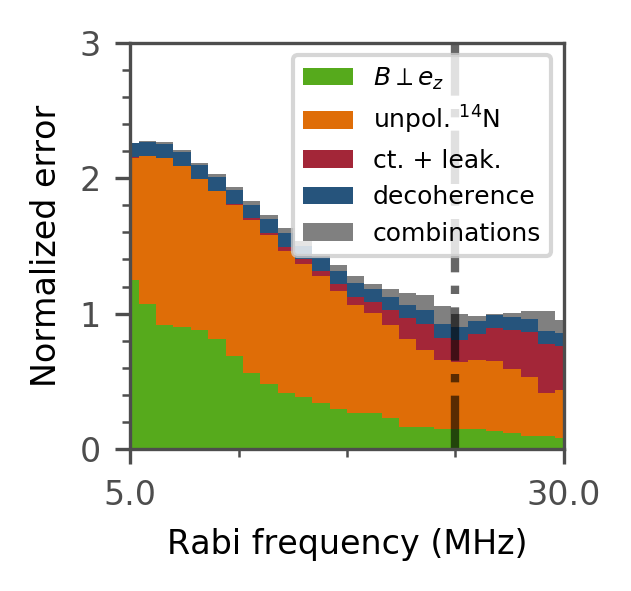

In [107]:
import matplotlib.gridspec as gridspec
from matplotlib.ticker import AutoMinorLocator, FixedLocator
import matplotlib.ticker as ticker


rabi_target_mhz = 23.7 # Mhz
conv_2_alpha = True
# a_rb actually doesn't matter
# it transforms first the spam free simulation to y_n, then y_n to a epc
a_rb = 0.57  
n_cliff_alpha = 2
n_cliff = 1   # take coherence part at n_cliff=1, only decoherence depends on n_cliff (see supplement)


#epc_t2_limit = 0.022  # from generate_rb.ipynb 20231130
#epg_t2_limit = 0.012  # from generate_rb.ipynb 20231130

t_gate_2q = common_params['xy8_order_2q'] *8*common_params['tau1_2q']
t_gate_1q = np.mean([common_params['t_rabi_opt']/4 + common_params['t_rabi_opt']/2]) 
epc_t2_limit = coherence_epc_limit_simple(t_gate_1q, t_gate_2q, common_params['rb_gpc'], np.mean(common_params['t2_xy8']))
epg_t2_limit = coherence_epg_limit_simple(t_gate_2q, np.mean(common_params['t2_xy8']))
epg_1q_t2_limit = coherence_epg_limit_simple(t_gate_1q, np.mean(common_params['t2_xy8']))
#epc_t2_limit = 0


plt.figure(figsize=(3.5*0.58, 2.2)) 

# relative errors, normalized to error @ rabi_target
try:
    # usually take z1 to not underestimate leakage that is mitigated in alt_mode=delta
    sims_rel = sims_100g
    sims_rel = sims_100g_z1
    
    
    if conv_2_alpha:
        sims_rel = sims_add_spam(sims_rel, a_add_spam=a_rb, y0_add_spam=0)
    
    x_rabis_mhz, rel_errors_per_rabi = calc_rel_errors_per_rabi(sims_rel, labels, 
                                                                epc_2q=epc_t2_limit, n_cliff=n_cliff,
                                                                convert_2_alpha=conv_2_alpha, n_cliff_alpha=n_cliff_alpha,
                                                                a_alpha=a_rb, y0_alpha=0)
    # re-order for plotting
    #rel_errors_per_rabi = rel_errors_per_rabi[['x_mhz', 't2', 'no_B_misal',  'no_ct_leak',
    #                                           'pol_n', 'unattr/combis', 'unattr'  ]]
    rel_errors_per_rabi = rel_errors_per_rabi[['x_mhz', 'no_B_misal', 'pol_n', 'no_ct_leak',
                                           't2',  'unattr/combis', 'unattr'  ]]
    #rel_errors_per_rabi = rel_errors_per_rabi[[  'x_mhz', 'unattr','t2', ,'pol_n',
    #                                   'no_ct_leak', 'no_B_misal', 'unattr/combis']]
    rel_errors_per_rabi_raw = rel_errors_per_rabi
    rel_errors_per_rabi = rel_errors_per_rabi.rename(columns={'no_B_misal': r'$B \perp e_z$', 
                                                              'no_ct_leak': 'ct. + leak.',
                       'pol_n': r'unpol. $^{14}$N', 'unattr/combis':'combinations', 't2': 'decoherence'})
    
 

    grid = gridspec.GridSpec(1, 1)
    ax =  plt.subplot(grid[0])
        
    
    #ax = plt.subplot(121)
    #ax =  plt.subplot2grid((2, 2), (1, 0), colspan=1)


    
    n_contrib = 6
    #colors = [plt_settings.get_cmap(False)(i) for i in range(n_contrib)]
    colors = [plt_settings.color('green'),
             plt_settings.color('orange'),
             plt_settings.color('red'),
             plt_settings.color('blue'),
             'grey',
             ]
    

    rel_errors_per_rabi = rel_errors_per_rabi.drop('x_mhz', axis=1)
    rel_errors_per_rabi = rel_errors_per_rabi.drop('unattr', axis=1)
    idx_rabi_target = np.argmin(abs(rabi_target_mhz - x_rabis_mhz))
    
    idx_full = labels.index('full_sim')
    sim_full = sims_rel[idx_full]
    sim_alpha_full = yn_2_alpha(sim_full['data']['y'], n_cliff=2, y0=0, a=a_rb)
    sim_alpha_rel_full = sim_alpha_full/np.max(sim_alpha_full)
    #sim_alpha_rel_full = sim_alpha_full/sim_alpha_full[idx_rabi_target]
    #sim_err_rel_full = (1-sim_alpha_full)/np.min((1-sim_alpha_full))
    sim_err_rel_full = (1-sim_alpha_full)/(1-sim_alpha_full[idx_rabi_target])
    
    x_ticks = np.linspace(0, len(x_rabis_mhz)-1, 2)
    new_range = [min(x_rabis_mhz), max(x_rabis_mhz)]
    original_range = [0, len(x_rabis_mhz)-1]
    interp_func = scipy.interpolate.interp1d(original_range, new_range, kind='linear', fill_value='extrapolate')
    interp_func_inv = scipy.interpolate.interp1d(new_range, original_range, kind='linear', fill_value='extrapolate')




    rel_errors_env_per_rabi = pd.DataFrame(rel_errors_per_rabi.values.T*(sim_err_rel_full)).T
    rel_errors_env_per_rabi.columns= rel_errors_per_rabi.columns

    ax = rel_errors_env_per_rabi.plot(kind='bar',stacked=True,# x='x',  
                                  align='center', width=1, color=colors, ax=ax)

    plt.xticks(x_ticks, rotation=0)
    ax.set_xticklabels(interp_func(x_ticks))

    plt.xlabel("Rabi frequency (Mhz)")
    plt.ylabel("rel. error contribution")
    

    plt.ylim([0,3])
    #plt.ylim([0,10])
    plt.xlim([0, 25])



    plt.xticks(x_ticks, rotation=0)
    ax.set_xticklabels(interp_func(x_ticks))
    #ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.2))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.axvline(interp_func_inv(rabi_target_mhz), 
                linestyle="dashdot", color='black', alpha=0.6,
                # linestyle=(0, (1,1)),, label='experiment'
                label='_no_lenged' 
               )

    plt.xlabel("Rabi frequency (MHz)")
    plt.ylabel("Normalized error")
    
   
    # without split error contrib plot
    #plt.legend(ncol=2, loc='lower left', prop={'size': 6},
    #           bbox_to_anchor=(-0.55, 1.1, 1.57, .15),
    #           mode="expand", borderaxespad=0.)
    plt.legend()
   
    
except:
    logger.exception("")
    



#plt.legend()
#plt.legend(ncol=2, loc='lower left', prop={'size': 6},
#               bbox_to_anchor=(-0.55, 1.1, 1.57, .102),
#               mode="expand", borderaxespad=0.)
#



plt_settings.savefig('err_sources.png',
                     frame_left_inch=0.45,
                     frame_top_inch=0.295, )
plt.show()


rabi_mhz, rel_errors = calc_rel_errors(sims_rel, labels, x_target=rabi_target_mhz,
                                       n_cliff=n_cliff, epc_2q=epc_t2_limit,
                                       convert_2_alpha=conv_2_alpha, n_cliff_alpha=n_cliff_alpha,
                                       a_alpha=a_rb, y0_alpha=0)



summables_keys = ['pol_n', 'no_ct_leak', 'no_B_misal', 'unattr/combis', 'unattr', 't2']
summable_dict = {key: val for key, val in rel_errors.items() if key in summables_keys}
rabi_mhz, summable_dict, np.sum(list(summable_dict.values()))

[0][0] full sim.
[1][1] only $T_2$
[2][2] init. $^{14}$N+$B || e_z$
[3][3] init. $^{14}$N
[4][4] no ct.+leak.


['full sim.', 'only $T_2$', 'init. $^{14}$N+$B || e_z$', 'init. $^{14}$N', 'no ct.+leak.', 'pi_1', 'pi_1_only $T_2$', 'pi_1_init. $^{14}$N+$B || e_z$', 'pi_1_init. $^{14}$N', 'pi_1_no ct.+leak.', 'pi_0', 'pi_0_only $T_2$', 'pi_0_init. $^{14}$N+$B || e_z$', 'pi_0_init. $^{14}$N', 'pi_0_no ct.+leak.', 'pihalf_1', 'pihalf_1_only $T_2$', 'pihalf_1_init. $^{14}$N+$B || e_z$', 'pihalf_1_init. $^{14}$N', 'pihalf_1_no ct.+leak.', 'pihalf_0', 'pihalf_0_only $T_2$', 'pihalf_0_init. $^{14}$N+$B || e_z$', 'pihalf_0_init. $^{14}$N', 'pihalf_0_no ct.+leak.']

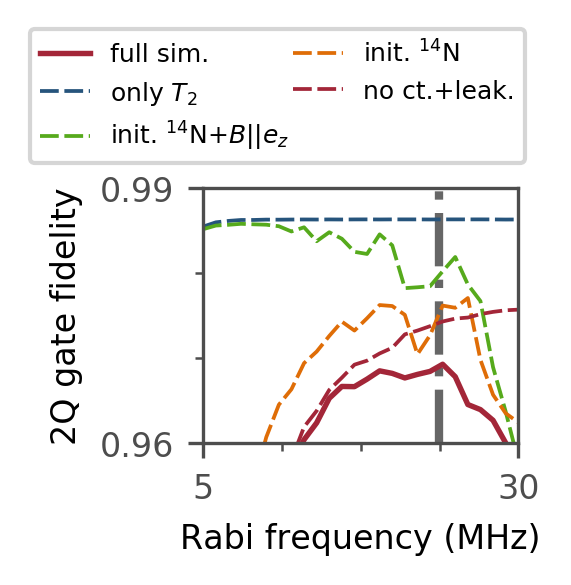

In [111]:
plt.figure(figsize=(3.5*0.5,2.2))
# fidelities
#plt.subplot(122)
#ax =  plt.subplot2grid((2, 2), (0, 1), rowspan=2)
ax =  plt.subplot(111) 
dut_gate = 'sqrtzz'
#dut_gate = 'pi_1'

dut_gates = ['pihalf_0', 'pihalf_1', 'pi_0', 'pi_1', 'sqrtzz']
order_list = ['fid_-dut-', 'fid_-dut-_hfoff+noctleak', 
                            'fid_-dut-_hfoff', 'fid_-dut-_init_nuc_spin',
                            'fid_-dut-_no_ctleak']

#inpath_60g = common_params['data_path'] +  r"\2023\10\20231030\simulation_julich\20240307_rb_full_all_geos_4\pp_d\04a - Randomized Benchmarking\rb_ncliff=2_60G"
inpath_100g = common_params['data_path'] + r"\2023\10\20231030\simulation_julich\20240307_rb_full_all_geos_4\pp_a\03a - Rabi vs Gate fidelities\fid_comparison100G"


#copy_to_path(inpath)
fnames = Tk_file.list_mult_pulsed_mes(inpath, filter_strs=['.npz'], incl_subdir=False)
#labels = [os.path.basename(f) for f in fnames]
#labels = [f.replace(".npz","") for f in labels]


sims_f_60g, sims_f_100g = [], []

for idx_b, path in enumerate([inpath_60g, inpath_100g]):
    fnames = Tk_file.list_mult_pulsed_mes(path, filter_strs=['.npz'], incl_subdir=False)

    for f in fnames:
        if idx_b == 0:
            sims_f_60g.append(load_sim(f))
        elif idx_b == 1:
            sims_f_100g.append(load_sim(f))




sims_f_60g_raw, sims_f_100g_raw = sims_f_60g, sims_f_100g
_, labels_f_raw = extract_sims_2(sims_f_100g[0], data_mode=alternating_mode)
sims_f_60g, _ = extract_sims_2(sims_f_60g[0],   data_mode='z1', alt_middle_str=None,
                                      excl_label=['_std','rabi_freq', 'init_nuc_spin+no_ctleak', 'Azz_off'])
sims_f_60g, _ = order_list_all_duts(sims_f_60g, order_list, dut_gates)

sims_f_100g, labels_f = extract_sims_2(sims_f_100g[0], data_mode='z1',  alt_middle_str=None,
                                      excl_label=['_std','rabi_freq', 'init_nuc_spin+no_ctleak', 'Azz_off'])
sims_f_100g, labels_f = order_list_all_duts(sims_f_100g, order_list, dut_gates)


rule_replace = {"fid_": "",
                "+":"_"}
labels_f = rename_strings(labels_f, rule_replace, exact_match=False)


rule_rename = { 
                dut_gate + "_": "",
               'hfoff_noctleak': r'only $T_2$',
               'hfoff': r'init. $^{14}$N+$B || e_z$',
               'init_nuc_spin': r'init. $^{14}$N',
               'full_sim': 'full sim.', 
               'no_ctleak': 'no ct.+leak.'}

labels_f_plot = rename_strings(labels_f, rule_rename, exact_match=False)
rule_rename = { dut_gate: "full sim."}

labels_f_plot = rename_strings(labels_f_plot, rule_rename, exact_match=True)



plt.axvline(rabi_target_mhz, 
            label='_no_legend', linestyle="dashdot", color="black", alpha=0.6,
            zorder=1)

i_per_dut = 0
for idx, s in enumerate(sims_f_100g):
    label_raw = s['label']
    
    if dut_gate not in label_raw:
        continue
        
    label = labels_f_plot[idx]
    x_mhz = s['data']['x']
    
    y = s['data']['y']*(1-epg_t2_limit)   # other pulses also there!

    
    is_exp_sim = 'full' in label
    linestyle = 'solid' if is_exp_sim else (0, (5,1.5))
    alpha = 1 #if is_exp_sim else 0.8
    linewidth = 1.3 if is_exp_sim else 0.9
    color = plt_settings.get_cmap(False)((i_per_dut)/(5))
    color = plt_settings.color('blue') if i_per_dut==1 else color
    color = plt_settings.color('red') if is_exp_sim else color
    
    print(f"[{idx}][{i_per_dut}] {label}")
    i_per_dut += 1
    plt.plot(x_mhz, y, label=label, 
             marker="", linestyle=linestyle, color=color, alpha=alpha,
             markersize=2, linewidth=linewidth)
    
    ax = plt.gca()
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))

handles, labels_f_plot_2 = plt.gca().get_legend_handles_labels()
order = [0,1,2,3,4]

plt.legend([handles[idx] for idx in order],[labels_f_plot_2[idx] for idx in order],
           ncol=2, loc='lower left', prop={'size': 6},
           bbox_to_anchor=(-0.55, 1.1, 1.57, .102),
           mode="expand", borderaxespad=0.)


plt.xlabel("Rabi frequency (MHz)")
plt.ylabel(f"Gate fidelity: {dut_gate.replace('fid_','')}")
plt.ylabel(f"2Q gate fidelity")

plt.yticks([0.96, 0.99])
plt.xticks([min(x_rabis_mhz), max(x_rabis_mhz)])
plt.ylim([0.96,0.99])
plt.xlim([5,30])


plt_settings.savefig('err_fidelities_2q.png', 
                     frame_left_inch=0.6,
                     frame_right_inch=0.1,
                     frame_top_inch=0.8)
plt.show()


labels_f_plot

In [139]:
rabi_target_mhz

23.7

In [195]:
idx_r = np.argmin(abs(sims_f_100g[0]['data']['x']-rabi_target_mhz))
idx_full_sim = 0
idx_noctleak = 4
idx_alb = 2

f_full = (1-epg_t2_limit)*sims_f_100g[idx_full_sim]['data']['y'][idx_r]
f_noctleak = (1-epg_t2_limit)*sims_f_100g[idx_noctleak]['data']['y'][idx_r]
f_alignedb = (1-epg_t2_limit)*sims_f_100g[idx_alb]['data']['y'][idx_r]
#f_test = (1-epg_t2_limit)*sims_f_100g[4]['data'][-1], labels_f[4]


print(f"{labels_f[idx_full_sim]} gate fidelity at {rabi_target_mhz} MHz: {f_full}")
print(f"{labels_f[idx_noctleak]} gate fidelity: {f_noctleak}")
print(f"{labels_f[idx_alb]} gate fidelity: {f_alignedb}")


sqrtzz gate fidelity at 23.7 MHz: 0.9692840182753809
sqrtzz_no_ctleak gate fidelity: 0.9743153953153701
sqrtzz_hfoff gate fidelity: 0.9802226722068984


#### older data

In [2234]:
err_key = 'unattr'
errs_unattr = []

for omega_r_mhz in np.linspace(5,25,10):
    rabi_mhz, rel_errors = calc_rel_errors(sims_100g, labels, x_target=omega_r_mhz, epc_2q=epc_t2_limit)

    summables_keys = ['pol_n', 'no_ct_leak', 'no_B_misal', 'unattr/combis', 'unattr', 't2']
    summable_dict = {key: val for key, val in rel_errors.items() if key in summables_keys}
    errs_unattr.append(summable_dict[err_key])
    
np.asarray(errs_unattr)*100

array([1.06977163, 0.5330081 , 0.343729  , 0.21726902, 0.18555076,
       0.14465357, 0.12122797, 0.09031985, 0.08099879, 0.08201269])

'no ct.+leak. gate fidelity at 23.7 MHz: 0.9785164777843447'

In [443]:
f_noctleak, f_alignedb
labels_f, dut_gates

(['only decoherence', 'no HFS', 'init 14-N', 'full sim', 'no crosstalk + leak'], {'fid_pihalf_0': array([0.90009838, 0.92865647, 0.94624397, 0.95791054, 0.96495679,
       0.96965791, 0.97341119, 0.97681082, 0.97932349, 0.98006088,
       0.97887229, 0.97607526, 0.97183031, 0.96610671, 0.95892768,
       0.95057945, 0.94155434, 0.93222904, 0.92296449, 0.91398145,
       0.90533351]), 'fid_pihalf_1': array([0.90006631, 0.92870085, 0.94683372, 0.95796704, 0.96526882,
       0.9716068 , 0.97660057, 0.97969444, 0.98048162, 0.97875203,
       0.97488611, 0.96928112, 0.96202399, 0.95306011, 0.94241106,
       0.93040628, 0.91745925, 0.90403577, 0.89052337, 0.87715716,
       0.86420352]), 'fid_pi_0': array([0.75097778, 0.815213  , 0.85750437, 0.8860129 , 0.90573256,
       0.91930912, 0.92916984, 0.93557604, 0.93941933, 0.94226516,
       0.94418624, 0.94483558, 0.94354883, 0.94044157, 0.93647469,
       0.93220713, 0.92783274, 0.92372192, 0.92020354, 0.91724999,
       0.91453969]), 'fid_pi

[20][0] full sim.
[21][1] only $T_2$
[22][2] init. $^{14}$N+$B || e_z$
[23][3] init. $^{14}$N
[24][4] no ct.+leak.
[15][0] full sim.
[16][1] only $T_2$
[17][2] init. $^{14}$N+$B || e_z$
[18][3] init. $^{14}$N
[19][4] no ct.+leak.
[10][0] full sim.
[11][1] only $T_2$
[12][2] init. $^{14}$N+$B || e_z$
[13][3] init. $^{14}$N
[14][4] no ct.+leak.
[5][0] full sim.
[6][1] only $T_2$
[7][2] init. $^{14}$N+$B || e_z$
[8][3] init. $^{14}$N
[9][4] no ct.+leak.
[0][0] full sim.
[1][1] only $T_2$
[2][2] init. $^{14}$N+$B || e_z$
[3][3] init. $^{14}$N
[4][4] no ct.+leak.


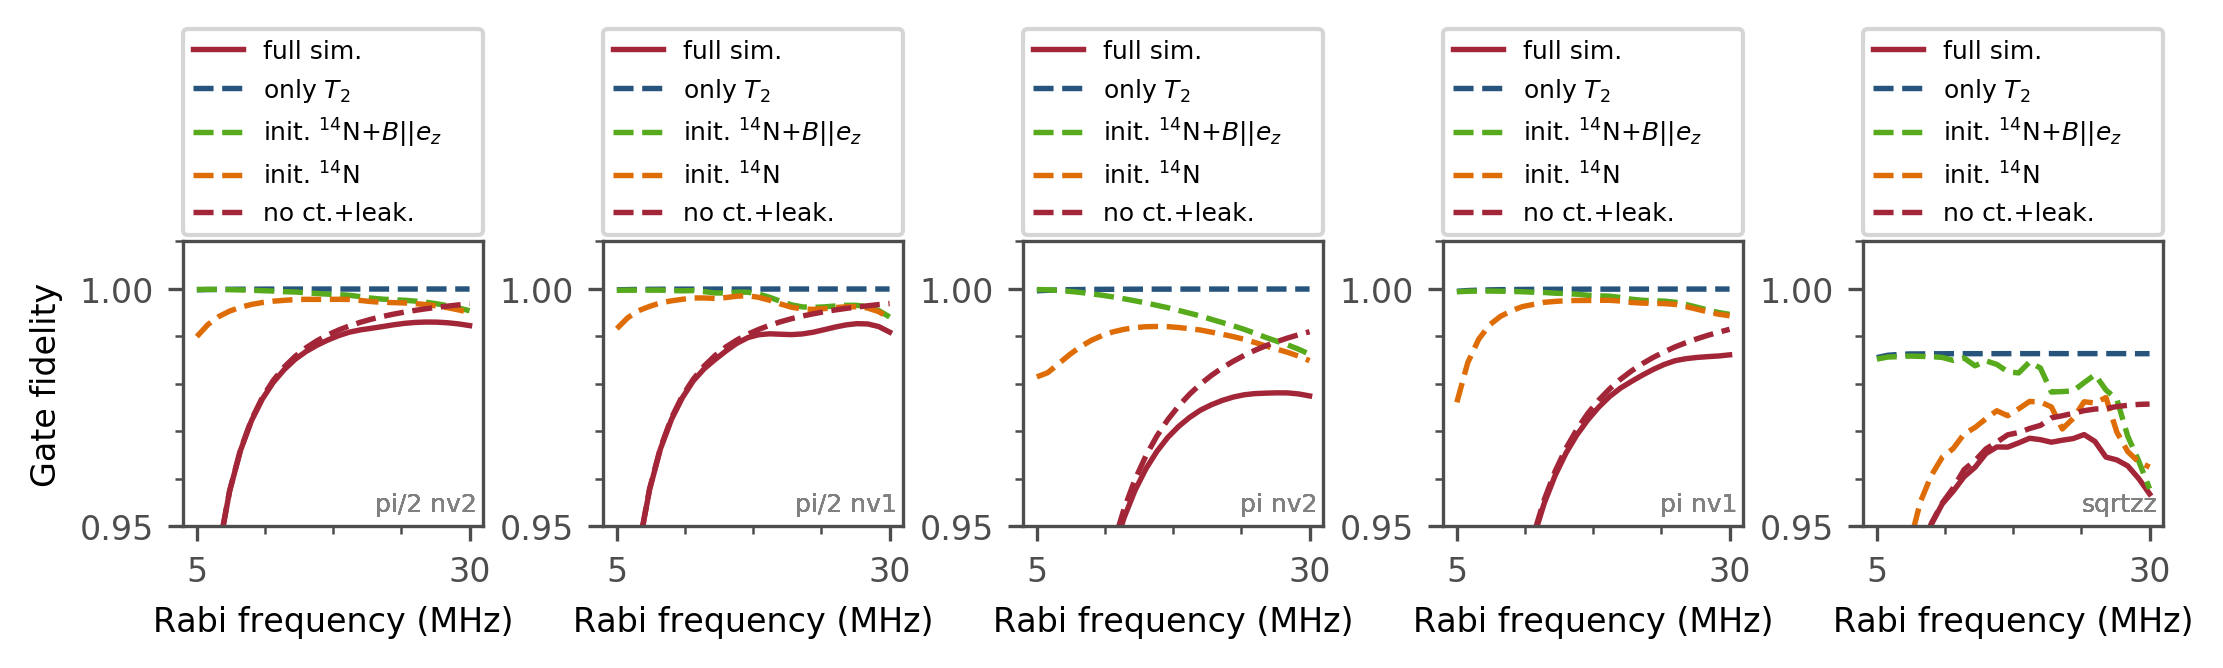

In [115]:

# Florian: _0: aligned NV
labels_dut = [d.replace("_1", " nv1") for d in dut_gates]
labels_dut = [d.replace("_0", " nv2") for d in labels_dut]
labels_dut = [d.replace("fid_", "") for d in labels_dut]
labels_dut = [d.replace("half", "/2") for d in labels_dut]


plt.figure(figsize=(7.3,2.3))
    
    
for idx_plot, dut_gate in enumerate(dut_gates):
    n_plots = len(dut_gates)
    plt.subplot(f'1{n_plots}{idx_plot+1}')
    label_dut = labels_dut[idx_plot]
    
    i_per_dut = 0
    for idx, s in enumerate(sims_f_100g):
        label_raw = s['label']

        if dut_gate not in label_raw:
            continue
        
        
        
       
        
        rule_rename = {dut_gate + "_": ""}
        labels_f_plot = rename_strings(labels_f_plot, rule_rename, exact_match=False)
        rule_rename = {dut_gate: "full sim."}
        labels_f_plot = rename_strings(labels_f_plot, rule_rename, exact_match=True)
          
        label = labels_f_plot[idx]
        
        x_mhz = s['data']['x']

        if 'sqrtzz' in dut_gate:
            y = s['data']['y']*(1-epg_t2_limit)   # other pulses also there!
        else:
            y = s['data']['y']*(1-epg_1q_t2_limit)



        is_exp_sim = 'full' in label
        linestyle = 'solid' if is_exp_sim else 'dashed'
        color = plt_settings.get_cmap(False)((i_per_dut)/(5))
        color = plt_settings.color('blue') if i_per_dut==1 else color
        color = plt_settings.color('red') if is_exp_sim else color

        
        print(f"[{idx}][{i_per_dut}] {label}")
        plt.plot(x_mhz, y, label=label, 
                 marker="", linestyle=linestyle, color=color,
                 markersize=2, linewidth=1.3)
        
        i_per_dut += 1

        
        if idx_plot is 0:
            plt.ylabel(f"Gate fidelity")
            
        
        plt.annotate(rf"{label_dut}", 
                 xy=(0.98,0.12), xycoords='axes fraction', color='grey',
                 va='top', ha='right', fontsize=6)
        
        plt.xlabel("Rabi frequency (MHz)")
        plt.yticks([0.95, 1.00])
        plt.xticks([min(x_rabis_mhz), max(x_rabis_mhz)])
        plt.ylim([0.95,1.01])
        
        ax = plt.gca()
        ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))
        
        plt.legend(ncol=1, loc='lower left',
               bbox_to_anchor=(0., 1.02, 1., .102),
               mode="expand", borderaxespad=0.,
              )
        
plt.subplots_adjust(wspace=0.4, hspace=0)
plt_settings.savefig('err_fidelities_all.png', 
                     frame_left_inch=0.6,
                     frame_right_inch=0.1,
                     frame_top_inch=0.8)

plt.show()

In [4986]:

#rel_per_error['pol_n'] + rel_per_error['no_ct_leak'] + rel_per_error['no_B_misal'] + rel_per_error['unattr/combis']

rabi_target_mhz = 22 # Mhz
_, rel_errors = calc_rel_errors(sims_100g, labels, x_target=rabi_target_mhz, epc_2q=0.02)
# these rel sources should sum up to 1
summables_keys = ['pol_n', 'no_ct_leak', 'no_B_misal', 'unattr/combis', 'unattr', 't2']
rel_errors_summable = {key: [val] for key, val in rel_errors.items() if key in summables_keys}

rel_errors, np.sum(list(rel_errors_summable.values()))

In [3120]:
# caluclate relative error contribution at all rabi frequencies

calc_rel_errors_per_rabi(sims_100g, labels)

(array([ 5.   ,  6.053,  7.105,  8.158,  9.211, 10.263, 11.316, 12.368,
       13.421, 14.474, 15.526, 16.579, 17.632, 18.684, 19.737, 20.789,
       21.842, 22.895, 23.947, 25.   ]),     no_B_misal  no_ct_leak    ...      unattr/combis      x_mhz
0     0.382127    0.006403    ...           0.009702   5.000000
1     0.291362    0.008742    ...           0.010792   6.052632
2     0.212078    0.009606    ...           0.015158   7.105263
3     0.179655    0.008278    ...           0.021671   8.157895
4     0.180074    0.002839    ...           0.035693   9.210526
5     0.181334    0.000000    ...           0.049318  10.263158
6     0.176159    0.000000    ...           0.061254  11.315789
7     0.180994    0.000000    ...           0.082559  12.368421
8     0.190167    0.004707    ...           0.093976  13.421053
9     0.181775    0.013219    ...           0.112781  14.473684
10    0.181112    0.024836    ...           0.136315  15.526316
11    0.197463    0.037936    ...           0.14

In [2961]:
pd.DataFrame([labels, y_cut]).T

                         0         1
0                 full sim  0.825728
1           hfoff_noctleak  0.999478
2  hfoff_noctleak_twicedip  0.998445
3                   hf_off  0.944025
4            init_nuc_spin   0.90972
5                no_ctleak  0.846828

In [2928]:
new_range = [5, 25]
original_range = [0, 19]
interp_func = scipy.interpolate.interp1d(original_range, new_range, kind='linear', fill_value='extrapolate')

interp_func(x_ticks)

array([ 5., 10., 15., 20., 25.])

In [1844]:
# OlD: single sims

# Simulation data
fname = common_params['data_path'] + r"\2023\10\20231030\simulation_julich" + "\\" \
        + r"rand_bench_ncliff=1.npz"

do_strech = False

if '.npz' in fname:
    data_sim = np.load(fname)
    x, y = data_sim['Rabi_freq'], -data_sim['meas_old'] +0.1
    #['', 'meas_old', 'meas_new']
    
data_sim['meas_old']

array([-0.117, -0.116, -0.146, -0.198, -0.257, -0.317, -0.375, -0.42 ,
       -0.445, -0.46 , -0.44 , -0.391, -0.324, -0.257, -0.214, -0.174,
       -0.08 , -0.017,  0.017,  0.024])

In [ ]:
# Simulation data genko
fname = common_params['data_path'] + r"\2023\11\20231115\SimulationGenko\sim_ampl_scan" + "\\" \
    + r"NV1_Sin1_XY8amplTy_o_1_t_0.8_ampl_0.3-2_NV2_Sin1_XY8amplTy_o_1_t_0.8_MW1_Sin1_MW1scan_t_0.8_o_1_hyper_1_cross_1.m"
data_sim = load_mathematica(fname)
data_sim = pd.DataFrame(data_sim, columns=['rel. Rabi freq', 'z'])


data_sim

In [ ]:
# OlD: single sims

# Simulation data
fname = common_params['data_path'] + r"\2023\10\20231030\simulation_julich" + "\\" \
        + r"rand_bench_ncliff=1.npz"
    # + r"20231030_simFerlemann_cphase_vs_rabi.csv"
do_strech = False

if '.csv' in fname:
    data_sim = pd.read_csv(fname, header=1, usecols=[0,1,4,5])
    data_sim = data_sim.dropna(how='all')
    x, y = data_sim['Rabi (MHz)'], data_sim['Fidelity (avg)']
if '.npz' in fname:
    data_sim = np.load(fname)
    x, y = data_sim['Rabi_freq'], -data_sim['meas_old'] +0.1
    #['', 'meas_old', 'meas_new']

y = y/np.max(y) # norm to 1
y = y*y_max_60g # align with max of exp data

#plt.plot(x,y, marker="", color=plt_settings.color('bluelight'), label="Sim, 60 G")

if do_strech:
    new_range = [y_min_60g, y_max_60g]
    original_range = [np.min(y), np.max(y)]
    interp_func = scipy.interpolate.interp1d(original_range, new_range, kind='linear', fill_value='extrapolate')

    plt.plot(x,interp_func(y),color=plt_settings.color('blue'),   label="Sim, 60 G, linear streched",
            marker="",)
plt.legend(loc='lower right')

# Simulation data, 100 G
if '.csv' in fname:
    x, y = data_sim['Rabi (MHz).1'], data_sim['Fidelity (avg).1']
if '.npz' in fname:
    x, y = data_sim['Rabi_freq'], -data_sim['meas_new'] + 0.1

y = y/np.max(y) # norm to 1
y = y*y_max_100g # align with max of exp data

#plt.plot(x,y, marker="", color=plt_settings.color('orange'), label="Sim, 100 G", zorder=2)


if do_strech:
    new_range = [y_min_100g, y_max_100g]
    original_range = [np.min(y), np.max(y)]

    interp_func = scipy.interpolate.interp1d(original_range, new_range, kind='linear', fill_value='extrapolate')

    plt.plot(x,interp_func(y),color=plt_settings.color('red'),   label="Sim, 100 G, linear streched",
            marker="",)


# EPC Simulation data
fname = common_params['data_path'] + r"\2023\10\20231030\simulation_julich\20231113_rb_vs_rabi" + "\\" \
        + r"rand_bench_rabi_vs_epc.npz"

data_sim = np.load(fname)
x, y_60g = data_sim['rabi_freq'], 1-data_sim['epc_old']
y_100g = 1-data_sim['epc_new']

#y_60g = y_60g/np.max(y_100g) # norm to 1
#y_60g = y_60g*y_max_100g#y_max_60g # align with max of exp data

#y_100g = y_100g/np.max(y_100g) # norm to 1
#y_100g = y_100g*y_max_100g # align with max of exp data

plt.legend(loc='lower right')

#ax = plt.gca()
#ax2 = ax.twinx()
#plt.ylabel("Simulated 1-EPC")
#plt.plot(x,y_100g, linestyle=":", marker="", color=plt_settings.color('red'), label='sim EPC, 100 G')
#plt.plot(x,y_60g, linestyle=":", marker="", color=plt_settings.color('blue'), label='sim EPC, 60 G')


# Simulation data genko
fname = common_params['data_path'] + r"\2023\11\20231115\SimulationGenko\sim_ampl_scan" + "\\" \
    + r"NV1_Sin1_XY8amplTy_o_1_t_0.8_ampl_0.3-2_NV2_Sin1_XY8amplTy_o_1_t_0.8_MW1_Sin1_MW1scan_t_0.8_o_1_hyper_1_cross_1.m"
data_sim = load_mathematica(fname)
data_sim = pd.DataFrame(data_sim, columns=['rel. Rabi freq', 'z'])

x_rabi = data_sim['rel. Rabi freq']* 15
y = data_sim['z']
y = y/np.max(y) # norm to 1
y = y*y_max_60g # align with max of exp data

do_strech = False

#plt.plot(x_rabi, y, marker='', label="Sim, 60 G")
if do_strech:
    new_range = [y_min_60g, y_max_60g]
    original_range = [np.min(y), np.max(y)]
    interp_func = scipy.interpolate.interp1d(original_range, new_range, kind='linear', fill_value='extrapolate')

    plt.plot(x_rabi,interp_func(y),color=plt_settings.color('blue'),   label="Sim, 60 G, linear streched",
            marker="",)
#plt.ylim([0.05,1.05])
#plt.yscale("log")   

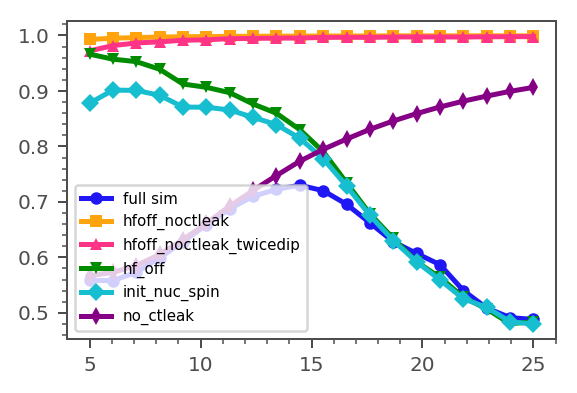

In [1883]:
inpath = common_params['data_path'] + r"\2023\10\20231030\simulation_julich\20231122_rb_updates\n_cliff=1_vs_rabi"
fnames = Tk_file.list_mult_pulsed_mes(inpath, filter_strs='npz', incl_subdir=False)

fnames
labels = [os.path.basename(f).replace("rand_bench_ncliff=1_","").replace(".npz","").replace("rand_bench_ncliff=1","full sim") for f in fnames]


fname = fnames[0]



sims = []

for f in fnames:
    sims.append(load_sim(f))

#sim_res['data']['y'] = _norm_sim_2_exp(sim_res['data']['y'])
    
    
#y = y/np.max(y) # norm to 1
#y = y*y_max_100g # align with max of exp data

#plt.plot(x,y, marker="", color=plt_settings.color('orange'), label="Sim, 100 G", zorder=2)
    
for idx, s in enumerate(sims):
    plt.plot(s['data']['x'], s['data']['y'], label=labels[idx])
    
plt.legend()
plt.show()

In [1667]:
col_keys

['Rabi_freq', 'meas_old', 'meas_new']

In [1604]:



data_sim = load_mathematica(fname)
pd.DataFrame(data_sim, columns=['rel. Rabi freq', 'z'])

    rel. Rabi freq         z
0              0.3  0.919289
1              0.4  0.963340
2              0.5  0.978318
3              0.6  0.983626
4              0.7  0.983132
5              0.8  0.982356
6              0.9  0.979565
7              1.0  0.982468
8              1.1  0.956075
9              1.2  0.913035
10             1.3  0.888453
11             1.4  0.876042
12             1.5  0.863628
13             1.6  0.874703
14             1.7  0.905952
15             1.8  0.917941
16             1.9  0.891512
17             2.0  0.845130

0

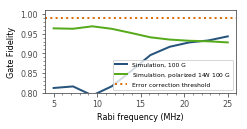

In [257]:
fname = common_params['data_path'] + r"\2023\10\20231030\simulation_julich\20231113_rb_vs_rabi" + "\\" \
            + r"rand_bench_rabi_vs_epc.npz"

data_sim = np.load(fname)

#data_sim = data_sim.dropna(how='all')
x, y_60g = data_sim['rabi_freq'], 1-data_sim['epc_old']
y_100g = 1.1*(1-data_sim['epc_new'])
y_perfect = 0.3*(1.95+1+data_sim['epc_new'])


plt.figure(figsize=(3.5,1.8))

plt.plot(x,y_100g, marker="", label='Simulation, 100 G', color=plt_settings.color('blue'))
plt.plot(x,y_perfect, marker="", label=r'Simulation, polarized $14N$ 100 G', color=plt_settings.color('green'))
#plt.plot(x,y_60g, marker="", label='sim EPC, 60 G')
plt.axhline(0.99, linestyle=":", color=plt_settings.color('orange'), 
            label="Error correction threshold")
#plt.axhline(0.995, linestyle=":", color=plt_settings.color('red'), 
#            label="T2 limit")


plt.ylim([0.8, 1.01])
#plt.yscale("log")   

plt.xlabel('Rabi frequency (MHz)')
plt.ylabel('Gate Fidelity')

plt.legend(loc='lower right')


plt_settings.savefig('F_sim_vs_rabi.png', frame_top_inch=0.1)
plt.show()

0

### Gate fidelity vs B

(['fid'], ['$\\sqrt{ZZ}$ gate fidelity, full sim., $T_2=\\infty$'])

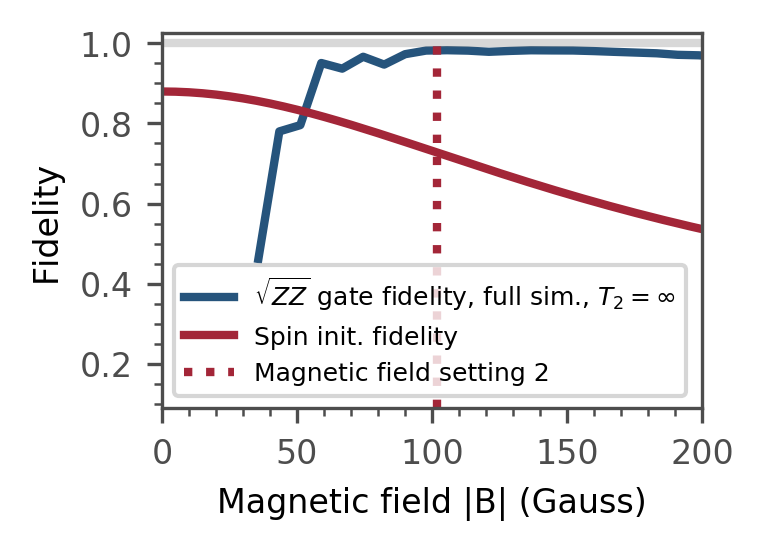

In [863]:
fname = fnames[0]
fname

'E:\\Data\\2023\\10\\20231030\\simulation_roberto\\20240114_init_error/init_fidel_tentienne_values_fid_ms=1.txt'

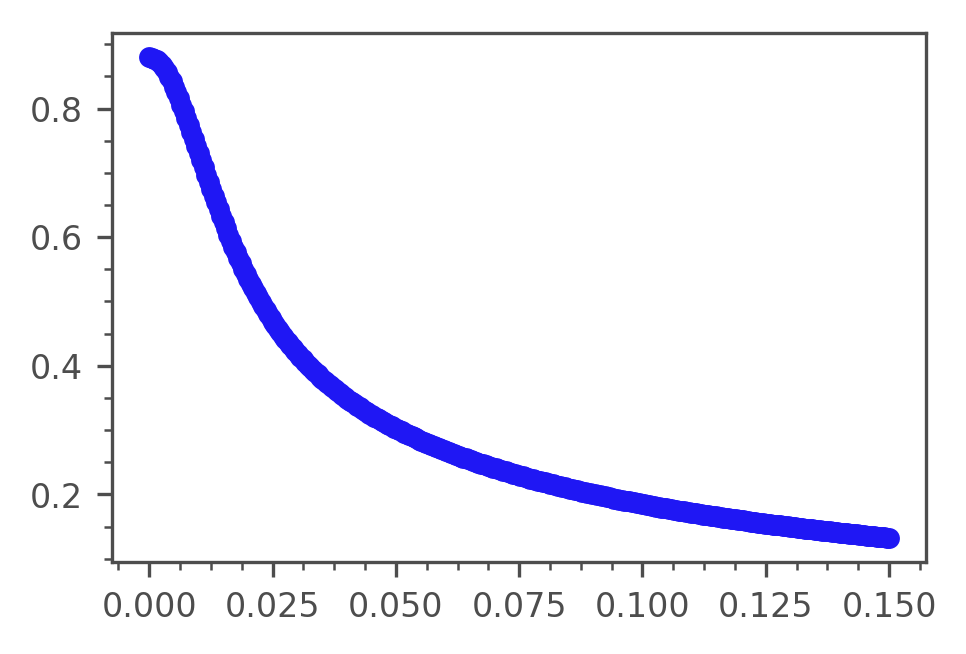

## 2Q Randomized benchmarking

Need to manuall fix decay_exp fit:
    - Lifetime, vary between 0-2.
    - Fix Offset= 0.

For EPC-> EPG, use qiskit::calculate_2q_epg function in generate_rb.ipynb. Lifetime (x-axis cliffords): 2.3
Note: 

In [826]:
#qiskit_coherence_limit


t_gate_2q = common_params['xy8_order_2q'] *8*common_params['tau1_2q']
t_gate_1q = np.mean([common_params['t_rabi_opt']/4 + common_params['t_rabi_opt']/2]) 

coherence_epc_limit_simple(t_gate_1q, t_gate_2q, common_params['rb_gpc'], np.mean(common_params['t2_xy8']))
coherence_epg_limit_simple(t_gate_2q, np.mean(common_params['t2_xy8']))

0.013669157757026484

In [829]:
coherence_epg_limit_simple(t_gate_2q, 1e-3)

0.006379563620851014

baseline= 0.0004. Fit Offset= 0.0000 fixed to this?
Mean Rabi= 23.65744026496333 MHz
EPC= 0.1496+-0.0272, EPG= 0.1496
EPC_T2= 0.0252

E:\Data\2023\12\20231201\PulsedMeasurement\rb_2q_swappedNV_2\20231201-2258-34_rand_benchmark_1q_B_pulsed_measurement.dat


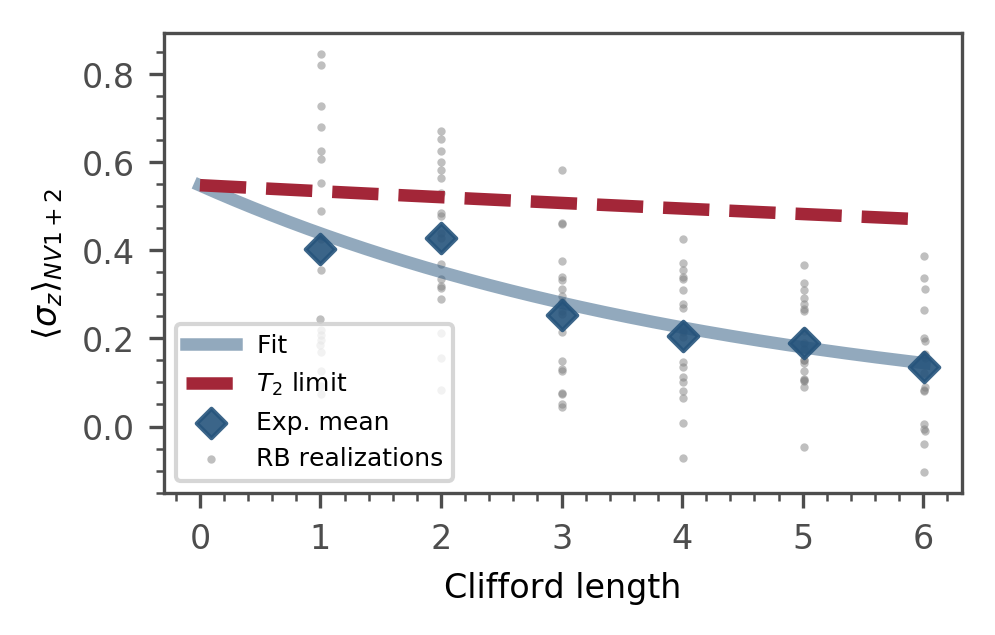

In [199]:

fname = common_params['data_path'] + r"\2023\09\20230922\PulsedMeasurement\rb_2q_interleaved_bare_gateset_5" + "\\" \
        + "20230922-1542-12_rand_benchmark_1q_pulsed_measurement.dat"

fname =  common_params['data_path'] + r"\2023\09\20230926\PulsedMeasurement\rb_2q_bare_3" + "\\" \
        + "20230926-1412-35_rand_benchmark_1q_pulsed_measurement.dat"
#fname =  r"E:\Data\2023\10\20231004\PulsedMeasurement\rb_2q_2" + "\\" \
#        + "20231004-1226-19_rand_benchmark_1q_pulsed_measurement.dat"
#fname = r"E:\Data\2023\10\20231004\PulsedMeasurement\rb_2q_interleaved_3" + "\\" \
#        + "20231004-1239-47_rand_benchmark_1q_pulsed_measurement.dat"



#folder = r"E:\Data\2023\10\20231006\PulsedMeasurement\rb_2q_oc_1"
#folder = r"E:\Data\2023\09\20230925\PulsedMeasurement\rb_2q_interleaved_gateset_oc_2"
folder = r"E:\Data\2023\10\20231017\PulsedMeasurement\rb_2q_vs_rabi_calib_deer_dd=0.5,0.5_3\calib_y_axis"
folder = r"E:\Data\2023\10\20231017\PulsedMeasurement\rb_2q_tau_cnot=-280ns_1"
folder = common_params['data_path'] + r"\2023\10\20231017\PulsedMeasurement\rb_2q_vs_rabi_fullDecays_4"
folder = common_params['data_path'] + r"\2023\12\20231201\PulsedMeasurement\rb_2q_swappedNV_2"

#folder = r"E:\Data\2023\09\20230914\PulsedMeasurement\rb_2q_decomp=ferlemann_opt1Qs_1"

copy_to_path(folder)
fnames = Tk_file.list_mult_pulsed_mes(folder, filter_strs=['measurement.dat'], incl_subdir=False)

fname = fnames[0]
#fname = fnames[2]
    
epc = 1
gpc = 1
    
    
try:
        
    fname = os.path.normpath(fname)
    p_data = Tk_file.load_pulsed_result(fname)
    
    #p_data['fit_settings'] = {'fit_func_nonqudi': _rb_fit_func_2}

    split_before = False
    fit_on = 'delta'
    perform_fit = True
    calc_mean_datapoint = True
    mask_last_n = 20       # if tail measurement is included only!
    #mask_last_n = 0
        
    p_data['fit_edit_params'] = [lmfit.Parameter('offset', value=0, vary=False),
            lmfit.Parameter('amplitude', value=0.1, min=0, max=1, vary=True),
            lmfit.Parameter('lifetime', value=1, min=0.5, max=10, vary=True)]
    
    #epc_t2_limit = 0.022   # 20231130 from generate_rb.ipnybv
    t_gate_2q = common_params['xy8_order_2q'] *8*common_params['tau1_2q']
    t_gate_1q = np.mean([common_params['t_rabi_opt']/4 + common_params['t_rabi_opt']/2]) 
    epc_t2_limit = coherence_epc_limit_simple(t_gate_1q, t_gate_2q, 
                                              common_params['rb_gpc'], np.mean(common_params['t2_xy8']))

    

    y_baseline = mean_over_idxs(p_data, list(range(-mask_last_n,0)))
    #y_baseline = 0 if y_baseline == np.nan else y_baseline
    
    #plt.figure(figsize=(3.5,2.2))
    p_data = plot_bench_data(p_data, split_before=split_before, lineplot=False,
                    n_qubits=2, idx_zref=0, mask_idxs=[0] + list(range(-mask_last_n,0)),
                    perform_fit=perform_fit,
                    #annotate_vals=['EPC'],
                    annotate_vals=[],
                    labels = [r'Exp. mean', 'RB realizations'],
                    color_fit=plt_settings.color('blue'),
                    #labels = [r'Exp, Mean, $\Omega_{1/2}=$(21.2, 22.4 MHz)', 'Exp RB realizations'],
                    calc_mean_datapoint=calc_mean_datapoint)
    
    
    omega_rabi_mhz = 1e-6*1/np.mean([float(p_data['exp_params']['rabi_period_mw_2']), p_data['exp_params']['rabi_period']])
    offset = p_data['fit_res']['offset'].value
    print(f"baseline= {y_baseline:.4f}. Fit Offset= {offset:.4f} fixed to this?")
    epc = p_data['fit_res']['EPC']['value']
    depc = p_data['fit_res']['EPC']['error']
    ampl_exp =  p_data['fit_res']['Amplitude']['value']
    
    print(f"Mean Rabi= {omega_rabi_mhz} MHz")
    print(f"EPC= {epc:.4f}+-{depc:.4f}, EPG= {epc/gpc:.4f}") 
    print(f"EPC_T2= {epc_t2_limit:.4f}")  
    
    if epc_t2_limit is not None:
        plot_rb_t2_limit(epc_t2_limit, x=p_data['data']['tau'].append(pd.Series([0])),
                         y0=y_baseline, ampl=ampl_exp)


    plt.xlabel("Clifford length")
    plt.ylabel("Survival probability")
    plt.ylabel(r'$\langle \sigma_z \rangle_{NV1+2}$')
    
    
    # Simulation data
    plot_sim = False
    if plot_sim:
        fname = common_params['data_path'] + r"\2023\10\20231030\simulation_julich" + "\\" \
            + r"20231113_rand_bench_decay_20MHz.npz"

        if '.npz' in fname:
            data_sim = np.load(fname)
            x, y = data_sim['n_cliff'], -data_sim['meas_mean'] 
            scale_y = 0.499/0.7965  # from decay fits: ampl_exp / ampl_sim
            p_sim = {'file': '/na_0', 'data':  pd.DataFrame({'tau': x, 'z1': scale_y*y, 'z2': np.zeros(len(y))})}
            p_sim['fit_settings'] = {'fit_range': np.linspace(0, np.max(p_sim['data']['tau']), 1000)}

            #['', 'meas_old', 'meas_new']
        #plt.plot(x,y, label="Sim")
        p_sim = plot_bench_data(p_sim, split_before=False, lineplot=False,
                        n_qubits=2, perform_fit=perform_fit, calc_mean_datapoint=False,
                        idx_datas=1, n_datas=2, color_fit=plt_settings.color('blue'),
                        annotate_vals=['EPC'],
                        labels = [f'Sim, scale={scale_y:.2f}, ' +  r'$\Omega_{1/2}=$ 20 MHz'])
    
    # plt.legend(prop={'size': 6}, loc='lower left')
    #plt.legend(loc='upper right')
    plt.legend(loc='lower left')
    #plt.legend(prop={'size': 8}, bbox_to_anchor=(-0.3,1.0))
    
    #plt.ylim([-0.6,0.8])
    
except:
    logger.exception("")


print(f"\n{fname}")




plt_settings.savefig('rb_2q.png', frame_top_inch=0.2, frame_bottom_inch=0.6)


plt.show()



#plot_bench_data(p_data, split_before=split_before, split_idx_start=1, lineplot=False,
#               idx_zref=0, n_qubits=2, mask_ref=True)

#plt.show()

### EPGs
<a id='val_f_2q'></a>

In [407]:
epc

0.14957372678600878

In [211]:
# EPC -> EPG
# new, without qiskit and number of 1q gates
# solely from EPC definition

gpc_2q = common_params['rb_gpc']
gpc_2q_nocnot = common_params['rb_2q_nocnot_gpc']
gpc_1q = common_params['rb_1q_gpc']

def estimate_epg_2q(epc_2q, epc_2q_nocnot, n2q_per_cliff=1.8):
    # (1-EPC_mes) = (1-EPG_1q)^n1q* (1-EPG_2q)^n2q
    # (1-EPG_1q)^n1q == (1-EPC_1q)

    return 1 - np.power((1-epc_2q)/(1-epc_2q_nocnot), 1/n2q_per_cliff)

def estimate_epg_1g(epc_2q_nocnot, n1q_per_cliff=10.5):
    return 1 - np.power((1-epc_2q_nocnot), 1/n1q_per_cliff)
    

# 2q EPC
epc_mes = 0.1496   # epc, cell above
depc_mes = 0.0272  # depc  

# 2q_noCNOT EPC from mes below
# 1q fidelity from 2Q_noCNOT to include free evolution
epc_2q_nocnot = 0.0847   # 20231202, swappedNV
depc_2q_nocnot = 0.0131   # 20231202, swappedNV

epc_1q_nv1 = 1.007e-2
depc_1q_nv1 = 1.306e-3
epc_1q_nv2 = 9.295e-3
depc_1q_nv2 = 5.682e-4

epg_cphase = estimate_epg_2q(epc_mes, epc_2q_nocnot, gpc_2q['cx'])
epg_1q = estimate_epg_1g(epc_2q_nocnot, gpc_2q_nocnot['1q'])
epg_1q_nv1 = estimate_epg_1g(epc_1q_nv1, gpc_1q['1q'])
epg_1q_nv2 = estimate_epg_1g(epc_1q_nv2, gpc_1q['1q'])

# error bound to left and right
# in theory could be assymetric, but turns out to be very close to each other
# => below we conservativly take the max
epg_cphase_d2 = estimate_epg_2q(epc_mes+depc_mes, epc_2q_nocnot, gpc_2q['cx'])
epg_cphase_d1 = estimate_epg_2q(epc_mes-depc_mes, epc_2q_nocnot, gpc_2q['cx'])

# error propagation
# sqrt(ZZ) 
epg_cphase_d = []
for d_mes in [+depc_mes, -depc_mes]:
    for d_nocnot in [depc_2q_nocnot, -depc_2q_nocnot]:
        epg_i =  estimate_epg_2q(epc_mes+d_mes, epc_2q_nocnot+d_nocnot, gpc_2q['cx'])
        epg_cphase_d.append(epg_i)

# 1q nv1 
epg_1q_nv1_d = []
for d_mes in [+depc_1q_nv1, -depc_1q_nv1]:
    epg_i = estimate_epg_1g(epc_1q_nv1+d_mes, gpc_1q['1q'])
    epg_1q_nv1_d.append(epg_i)
    
# 1q nv2
epg_1q_nv2_d = []
for d_mes in [+depc_1q_nv2, -depc_1q_nv2]:
    epg_i = estimate_epg_1g(epc_1q_nv2+d_mes, gpc_1q['1q'])
    epg_1q_nv2_d.append(epg_i)

# 1q avg., effective
# TODO double check errors on EPC_1q and EPG_1q
epg_1q_d = []
for d_mes in [+depc_2q_nocnot, -depc_2q_nocnot]:
    epg_i = estimate_epg_1g(epc_2q_nocnot+d_mes, gpc_2q_nocnot['1q'])
    epg_1q_d.append(epg_i)
    
epg_cphase_d, epg_1q_nv1_d = np.asarray(epg_cphase_d), np.asarray(epg_1q_nv1_d)
epg_1q_nv2_d, epg_1q_d = np.asarray(epg_1q_nv2_d), np.asarray(epg_1q_d)

depg_cphase = max(abs(epg_cphase_d-epg_cphase))
depg_nv1 = max(abs(epg_1q_nv1_d-epc_1q_nv1))
depg_nv2 = max(abs(epg_1q_nv2_d-epc_1q_nv2))
depg_1q = max(abs(epg_1q_d-epg_1q))

# OLD, manual
#epg_1q_nv1_d1 = estimate_epg_1g(epc_1q_nv1+depc_1q_nv1, gpc_1q['1q'])
#epg_1q_nv1_d2 = estimate_epg_1g(epc_1q_nv1-depc_1q_nv1, gpc_1q['1q'])
#epg_1q_nv2_d1 = estimate_epg_1g(epc_1q_nv2+depc_1q_nv2, gpc_1q['1q'])
#epg_1q_nv2_d2 = estimate_epg_1g(epc_1q_nv2-depc_1q_nv2, gpc_1q['1q'])

#epg_1q_d1 = estimate_epg_1g(epc_2q_nocnot+depc_2q_nocnot, gpc_2q_nocnot['1q'])
#epg_1q_d2 = estimate_epg_1g(epc_2q_nocnot-depc_2q_nocnot, gpc_2q_nocnot['1q'])


#depg_cphase = np.max([abs(epg_cphase_d1-epg_cphase), abs(epg_cphase_d2-epg_cphase)])
#depg_nv1 = np.max([abs(epg_1q_nv1_d1-epc_1q_nv1), abs(epg_1q_nv1_d2-epc_1q_nv1)])
#depg_nv2 = np.max([abs(epg_1q_nv2_d1-epc_1q_nv2), abs(epg_1q_nv2_d2-epc_1q_nv2)])
#depg_1q = np.max([abs(epg_1q_d2-epg_1q), abs(epg_1q_d1-epg_1q)])


print(f"Avg 1-EPC_1q: {epc_2q_nocnot}")
print(f"Avg EPG 1q: {epg_1q:.4f}+-{depg_1q:.4f}, {100*(1-epg_1q):.4f}+-{100*depg_1q:.4f}")
print(f"EPG_1q_nv1: {epg_1q_nv1:.4f}+-{depg_nv1:.4f}, {100*(1-epg_1q_nv1):.4f}+-{100*depg_nv1:.4f}")
print(f"EPG_1q_nv2: {epg_1q_nv2:.4f}+-{depg_nv2:.4f}, {100*(1-epg_1q_nv2):.4f}+-{100*depg_nv2:.4f}")

print(f"EPG(sqrt(ZZ)) = {epg_cphase:.3f}+-{depg_cphase:.3f}, {100*(1-epg_cphase):.3f}+-{100*depg_cphase:.3f}")

Avg 1-EPC_1q: 0.0847
Avg EPG 1q: 0.0077+-0.0012, 99.2340+-0.1242
EPG_1q_nv1: 0.0051+-0.0056, 99.4873+-0.5609
EPG_1q_nv2: 0.0047+-0.0049, 99.5268+-0.4853
EPG(sqrt(ZZ)) = 0.040+-0.025, 95.997+-2.479


In [459]:
np.asarray(epg_1q_nv1_d)-epc_1q_nv1


array([-0.00427618, -0.00560937])

In [419]:
depg_cphase, depg_nv1, depg_nv2, depg_1q

Traceback (most recent call last):
  File "C:\Users\Setup3-PC\Desktop\qudi\logic\jupyterkernel\qzmqkernel.py", line 679, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-419-d9e1f1ff611b>", line 1, in <module>
    depg_cphase, depg_nv1, depg_nv2, depg_1q
NameError: name 'depg_nv1' is not defined


In [1013]:
gpc_2q, gpc_1q, gpc_2q_nocnot

({'cx': 1.8, '1q': 10.53}, {'1q': 1.969}, {'1q': 11.51})

## 1Q by 2Q no CNOT

baseline= 0.0023. Offset= 0.0000 fixed to this?
EPC= 0.0847 +- 0.0131, EPG= 0.0847
E:\Data\2023\12\20231202\PulsedMeasurement\rb_2q_noCNOT_swappedNV_1\20231202-1301-01_rand_benchmark_1q_B_pulsed_measurement.dat


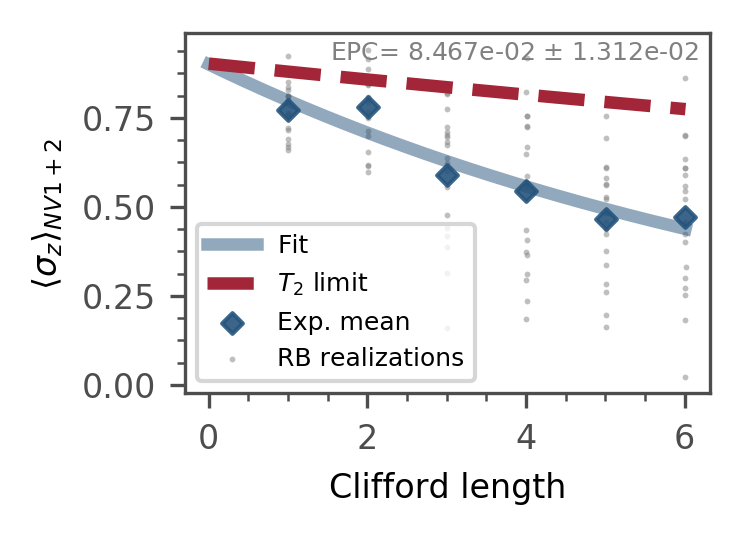

In [3743]:


folder = common_params['data_path'] + r"\2023\12\20231201\PulsedMeasurement\rb_2q_swappedNV_2"
folder = common_params['data_path'] + r"\2023\12\20231202\PulsedMeasurement\rb_2q_noCNOT_swappedNV_1"

fnames = Tk_file.list_mult_pulsed_mes(folder, filter_strs=['measurement.dat'], incl_subdir=False)

fname = fnames[0]
#fname = fnames[2]
    
epc = 1
gpc = 1
    
    
try:
    plt.figure(figsize=(0.7*3.5, 0.75*3.5*2./3.))
    
    fname = os.path.normpath(fname)
    p_data = Tk_file.load_pulsed_result(fname)
    
    #p_data['fit_settings'] = {'fit_func_nonqudi': _rb_fit_func_2}

    split_before = False
    fit_on = 'delta'
    perform_fit = True
    calc_mean_datapoint = True
    mask_last_n = 20       # if tail measurement is included only!
    #mask_last_n = 0
    #epc_t2_limit = 0.022   # 20231130 from generate_rb.ipnybv
    t_gate_2q = common_params['xy8_order_2q'] *8*common_params['tau1_2q']
    t_gate_1q = np.mean([common_params['t_rabi_opt']/4 + common_params['t_rabi_opt']/2]) 
    epc_t2_limit = coherence_epc_limit_simple(t_gate_1q, t_gate_2q, common_params['rb_gpc'], np.mean(common_params['t2_xy8']))
        
    p_data['fit_edit_params'] = [lmfit.Parameter('offset', value=0, vary=False),
            lmfit.Parameter('amplitude', value=0.1, min=0, max=1, vary=True),
            lmfit.Parameter('lifetime', value=1, min=0.5, max=10, vary=True)]
    

    y_baseline = mean_over_idxs(p_data, list(range(-mask_last_n,0)))
    #y_baseline = 0 if y_baseline == np.nan else y_baseline
    
    #plt.figure(figsize=(3.5,2.2))
    p_data = plot_bench_data(p_data, split_before=split_before, lineplot=False,
                    n_qubits=2, idx_zref=0, mask_idxs=[0] + list(range(-mask_last_n,0)),
                    perform_fit=perform_fit,
                    annotate_vals=['EPC'],
                    #annotate_vals=[],
                    labels = [r'Exp. mean', 'RB realizations'],
                    #labels = [r'Exp, Mean, $\Omega_{1/2}=$(21.2, 22.4 MHz)', 'Exp RB realizations'],
                    calc_mean_datapoint=calc_mean_datapoint)

    epc = p_data['fit_res']['EPC']['value']
    depc = p_data['fit_res']['EPC']['error']
    offset = p_data['fit_res']['offset'].value
    print(f"baseline= {y_baseline:.4f}. Offset= {offset:.4f} fixed to this?")
    ampl_exp =  p_data['fit_res']['Amplitude']['value']
    
    print(f"EPC= {epc:.4f} +- {depc:.4f}, EPG= {epc/gpc:.4f}")    
    
    if epc_t2_limit is not None:
        plot_rb_t2_limit(epc_t2_limit, x=p_data['data']['tau'].append(pd.Series([0])),
                         y0=y_baseline, ampl=ampl_exp)


    plt.xlabel("Clifford length")
    plt.ylabel("Survival probability")
    plt.ylabel(r'$\langle \sigma_z \rangle_{NV1+2}$')
    
    
    # Simulation data
    plot_sim = False
    if plot_sim:
        fname = common_params['data_path'] + r"\2023\10\20231030\simulation_julich" + "\\" \
            + r"20231113_rand_bench_decay_20MHz.npz"

        if '.npz' in fname:
            data_sim = np.load(fname)
            x, y = data_sim['n_cliff'], -data_sim['meas_mean'] 
            scale_y = 0.499/0.7965  # from decay fits: ampl_exp / ampl_sim
            p_sim = {'file': '/na_0', 'data':  pd.DataFrame({'tau': x, 'z1': scale_y*y, 'z2': np.zeros(len(y))})}
            p_sim['fit_settings'] = {'fit_range': np.linspace(0, np.max(p_sim['data']['tau']), 1000)}

            #['', 'meas_old', 'meas_new']
        #plt.plot(x,y, label="Sim")
        p_sim = plot_bench_data(p_sim, split_before=False, lineplot=False,
                        n_qubits=2, perform_fit=perform_fit, calc_mean_datapoint=False,
                        idx_datas=1, n_datas=2, 
                        annotate_vals=['EPC'],
                        labels = [f'Sim, scale={scale_y:.2f}, ' +  r'$\Omega_{1/2}=$ 20 MHz'])
    
    # plt.legend(prop={'size': 6}, loc='lower left')
    #plt.legend(loc='upper right')
    plt.legend(loc='lower left')
    #plt.legend(prop={'size': 8}, bbox_to_anchor=(-0.3,1.0))
    
    #plt.ylim([-0.6,0.8])
    
except:
    logger.exception("")


print(f"{fname}")
    
plt_settings.savefig('rb_2q_noCNOT.png', frame_top_inch=0.15, frame_right_inch=0.15,
                     frame_left_inch=0.55, frame_bottom_inch=0.4)
plt.show()



#plot_bench_data(p_data, split_before=split_before, split_idx_start=1, lineplot=False,
#               idx_zref=0, n_qubits=2, mask_ref=True)

#plt.show()

## 2Q RB interleaved

In [65]:


f_i0

In [1177]:
folder = r"E:\Data\2023\09\20230922\PulsedMeasurement\rb_2q_interleaved_bare_gateset_5"
folder = r"E:\Data\2023\09\20230922\PulsedMeasurement\rb_wq_interleaved_gateset_oc_6"
folder = r"E:\Data\2023\09\20230925\PulsedMeasurement\rb_2q_interleaved_gateset_bare_1"
folder = r"E:\Data\2023\09\20230926\PulsedMeasurement\rb_2q_bare_3"
folder = r"E:\Data\2023\10\20231012\PulsedMeasurement\rb_2q_interleaved_3"
folder = common_params['data_path'] + r"\2023\10\20231017\PulsedMeasurement\rb_2q_vs_rabi_fullDecays_4"
#folder = r"E:\Data\2023\09\20230927\PulsedMeasurement\rb_2Q_interleave_gateset_oc=20230926_1"
#folder = r"E:\Data\2023\10\20231004\PulsedMeasurement\rb_2q_interleaved_3"
#folder = r"E:\Data\2023\09\20230925\PulsedMeasurement\rb_2q_interleaved_gateset_oc_2"
fnames = Tk_file.list_mult_pulsed_mes(folder, filter_strs=['measurement.dat'], incl_subdir=False)
fnames

['E:\\Data\\2023\\10\\20231017\\PulsedMeasurement\\rb_2q_vs_rabi_fullDecays_4/20231018-2150-18_rand_benchmark_pscale=0.91_idx=0_pulsed_measurement.dat', 'E:\\Data\\2023\\10\\20231017\\PulsedMeasurement\\rb_2q_vs_rabi_fullDecays_4/20231018-2300-59_rand_benchmark_pscale=0.78_idx=1_pulsed_measurement.dat', 'E:\\Data\\2023\\10\\20231017\\PulsedMeasurement\\rb_2q_vs_rabi_fullDecays_4/20231019-0011-41_rand_benchmark_pscale=0.65_idx=2_pulsed_measurement.dat', 'E:\\Data\\2023\\10\\20231017\\PulsedMeasurement\\rb_2q_vs_rabi_fullDecays_4/20231019-0122-22_rand_benchmark_pscale=0.53_idx=3_pulsed_measurement.dat', 'E:\\Data\\2023\\10\\20231017\\PulsedMeasurement\\rb_2q_vs_rabi_fullDecays_4/20231019-0233-08_rand_benchmark_pscale=0.40_idx=4_pulsed_measurement.dat']

In [114]:
fname_normal = r"E:\Data\2023\09\20230920\PulsedMeasurement\rb_2q_interleaved_2"  + "\\" \
              + "20230920-0952-57_rand_benchmark_pulsed_measurement.dat"  # bare
fname_i = r"E:\Data\2023\09\20230920\PulsedMeasurement\rb_2q_interleaved_2"  + "\\" \
        + "20230920-0946-17_rand_benchmark_pulsed_measurement.dat"  # bare
  
fname_normal =  r"E:\Data\2023\09\20230920\PulsedMeasurement\rb_2q_interleaved_2"  + "\\" \
        +  "20230920-1557-21_rand_benchmark_pulsed_measurement.dat"  # oc
fname_i =  r"E:\Data\2023\09\20230920\PulsedMeasurement\rb_2q_interleaved_2"  + "\\" \
        +  "20230920-1656-35_rand_benchmark_pulsed_measurement.dat"  # oc
    
fname_normal =  r"E:\Data\2023\09\20230921\PulsedMeasurement\rb_2q_interleaved_1" + "\\" \
          + "20230921-0922-24_rand_benchmark_pulsed_measurement.dat"
fname_i =  r"E:\Data\2023\09\20230921\PulsedMeasurement\rb_2q_interleaved_1" + "\\" \
        + "20230921-0941-18_rand_benchmark_pulsed_measurement.dat"
    
fname_normal =  r"E:\Data\2023\09\20230921\PulsedMeasurement\rb_2q_interleaved_1" + "\\" \
          + "20230921-1027-17_rand_benchmark_pulsed_measurement.dat"
fname_i =  r"E:\Data\2023\09\20230921\PulsedMeasurement\rb_2q_interleaved_1" + "\\" \
        + "20230921-1125-24_rand_benchmark_pulsed_measurement.dat"
    
fname_normal =  r"E:\Data\2023\09\20230922\PulsedMeasurement\rb_2q_interleaved_oc_1" + "\\" \
          + "20230922-0841-32_rand_benchmark_pulsed_measurement.dat"
fname_i =  r"E:\Data\2023\09\20230922\PulsedMeasurement\rb_2q_interleaved_oc_1" + "\\" \
        + "20230922-0932-30_rand_benchmark_pulsed_measurement.dat"

fname_normal =  r"E:\Data\2023\09\20230922\PulsedMeasurement\rb_2q_interleaved_oc_scaleRabi=1.0_2" + "\\" \
          + "20230922-1001-34_rand_benchmark_pulsed_measurement.dat"
fname_i =  r"E:\Data\2023\09\20230922\PulsedMeasurement\rb_2q_interleaved_oc_scaleRabi=1.0_2" + "\\" \
        + "20230922-0951-28_rand_benchmark_pulsed_measurement.dat"
    
fname_normal = common_params['data_path'] + r"\2023\09\20230922\PulsedMeasurement\rb_2q_interleaved_bare_gateset_5" + "\\" \
        + "20230922-1542-12_rand_benchmark_1q_pulsed_measurement.dat"
fname_i =  common_params['data_path'] + r"\2023\09\20230922\PulsedMeasurement\rb_2q_interleaved_bare_gateset_5" + "\\" \
        + "20230922-1554-21_rand_benchmark_1q_interleave=rx180_on1_pulsed_measurement.dat"
    
Tk_string.params_from_str(fname_i, keys=['interleave'], extractor=lambda x: x.split("pulsed")[0])

{'interleave': 'rx180_on1_'}

In [1179]:

fname_normal = fnames[0]

#for fname_i in fnames[1:3]:
for fname_i in fnames[1:2]:
    alphas = []
    gate_str = Tk_string.params_from_str(fname_i, keys=['interleave'], 
                                         extractor=lambda x: x.split("_pulsed")[0])['interleave']
    labels = [['RB 2Q'], [f'i= {gate_str}']]
    
    for idx_f, fname in enumerate([fname_normal, fname_i]):
        try:
            fname = os.path.normpath(fname)
            p_data = Tk_file.load_pulsed_result(fname)

            split_before = False
            fit_on = 'delta'
            perform_fit = True
            calc_mean_datapoint = True
            mask_last_n = 20

            #p_data['fit_settings'] = {'fit_func_nonqudi': _rb_fit_func_2}
            y_baseline = mean_over_idxs(p_data, list(range(-mask_last_n,0)))
            print(f"baseline= {y_baseline:.4f}. Offset fixed to this?")
            
            p_data = plot_bench_data(p_data, split_before=split_before, lineplot=False,
                                     n_qubits=2, perform_fit=perform_fit, 
                                     idx_zref=0, mask_idxs=[0] + list(range(-mask_last_n,0)),
                                     idx_datas=idx_f, n_datas=2,
                                     labels=labels[idx_f],
                                    #)
                                     annotate_vals=['EPC', 'Lifetime', 'Offset'])

            if 'fit_res' in p_data.keys():
                alphas.append(p_data['fit_res']['EPC_alpha']['value'])
            else:
                print("Fit failed")
            
        except:
            logger.exception("")
        plt.show()
       
    #print(f"Debug: {alphas}")  
    f_i = calc_fidelity_interleaved(alphas[0], alphas[1], n_qubits=2)                  
    
    print(f"[{gate_str}]: epc= {f_i['epc']:.3f} (e={f_i['e']:.3f})") # from a= {alphas}") 
    #plt.title(os.path.basename(fname)[17:], fontsize=10)
    #plt.title(os.path.basename(fname)[35:], fontsize=15)
    plt.title(f"{gate_str}: epc= {f_i['epc']:.3f} (e={f_i['e']:.3f})", fontsize=15)
    
    plt.show()
    
    

Traceback (most recent call last):
  File "C:\Users\Setup3-PC\Desktop\qudi\logic\jupyterkernel\qzmqkernel.py", line 679, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1179-1dc815169e93>", line 7, in <module>
    gate_str = Tk_string.params_from_str(fname_i, keys=['interleave'], extractor=lambda x: x.split("_pulsed")[0])['interleave']
KeyError: 'interleave'


In [363]:
alphas

[0.7751472834685706, 0.6078814248256446]

In [119]:
fnames

['E:\\Data\\2023\\09\\20230926\\PulsedMeasurement\\rb_2q_bare_3/20230926-1412-35_rand_benchmark_1q_pulsed_measurement.dat', 'E:\\Data\\2023\\09\\20230926\\PulsedMeasurement\\rb_2q_bare_3/20230926-1506-54_rand_benchmark_1q_interleave=cphase_pulsed_measurement.dat']

# DEER plots

In [50]:

0

0

## Normalize to Rabi contrast


Data is taken without reference data point. Instead, we're comparing with a seperatly taken Rabi measurement. Both measurements must have the same readout power, laser power and laser polarization.
Then the normalization is done automatically:
1. Load Rabi and Deer measurement (z1). Find the ratio between z1 contrasts.
2. Load Deer measurement (delta). Norm to an oscillation from sigma= -0.5 to 0.5, then multiply with the contrast ration in (1).

OLD:
    - with readout window of 400 ns
    - data 20230609 deer_dd: Contrast on z1 of 7.2+- 1.2 % => ampl on delta=  67m => 0.1075 % per ampl
    - data 20230609 rabi_A: Contrast of z1 of 15.7 +- 0.4 %, rabi_B: z1 of 13.6 +- 0.6 %.
    
    - ampl_delta of 71m = 7.62 % contrast. => For y_scale we first norm the maximum datapoint to sigma=0.5 Then we apply the normalization onto y_scale= 7.62/15.7  (reading only NV A)
    

(16.902384250192938, 10.486628004805532, 0.6204230036177191)

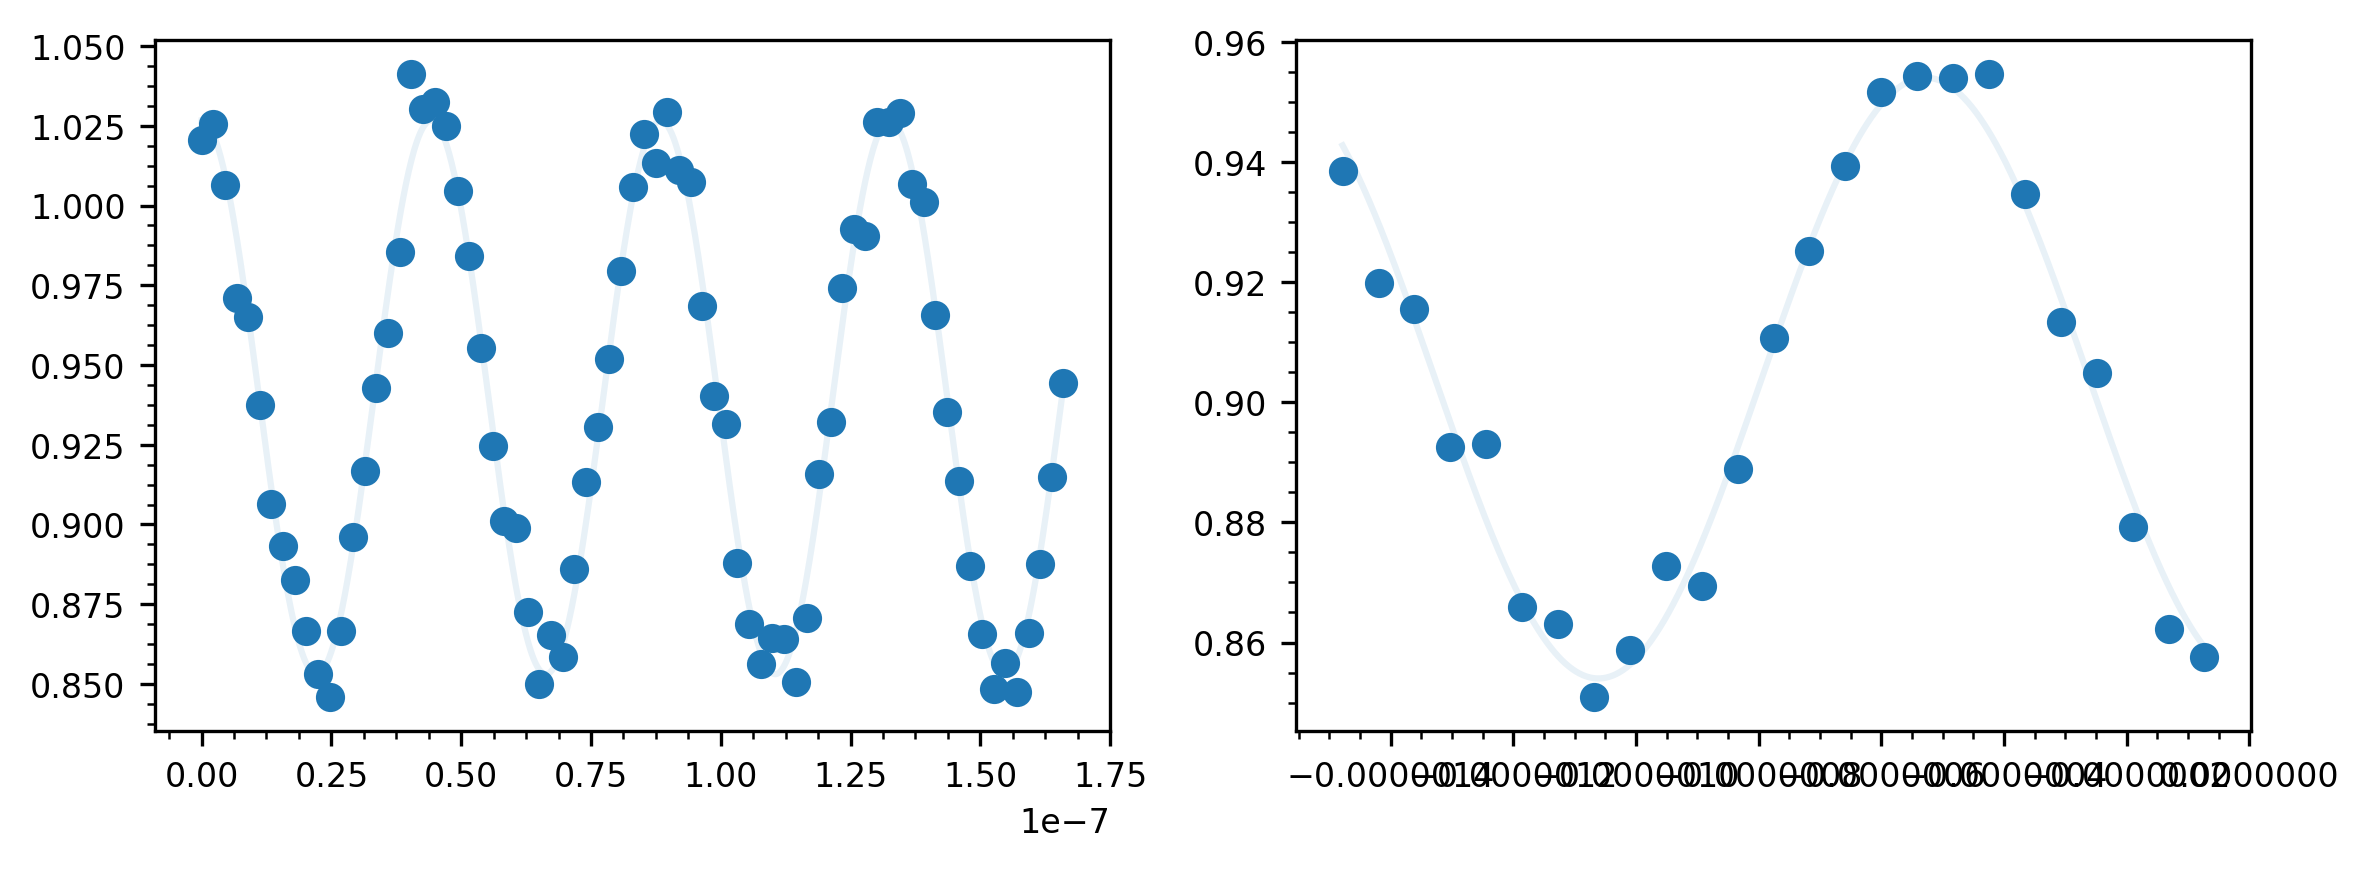

In [33]:
inpath_refrabi = common_params['data_path'] + r"\2023\10\20231018\PulsedMeasurement\deer_dd_tau_tau1=3000ns_1\rabi_contr\20231018-1335-46_rabi_shaped_A_pulsed_measurement.dat"
inpath_deer = common_params['data_path'] + r"\2023\10\20231018\PulsedMeasurement\deer_dd_tau_tau1=3000ns_1\read_phi=0\20231018-1259-20_deer_dd_XY8-1_init=0.5_0.0_read=0.5,0.0_readph=0_pulsed_measurement.dat"

# debug only
#inpath_refrabi = common_params['data_path'] + r"\2023\12\20231201\PulsedMeasurement\rb2q_vs_rabi_swappedNV_2\calib\20231202-1054-33_rabi_fine_pscale=0.97_idx=18_pulsed_measurement.dat"



p_raw = []

try:
    fnames = [inpath_refrabi, inpath_deer]

    for f in fnames:
        p_i = Tk_file.load_pulsed_result(f)
        copied = copy_to_path(f)
        p_raw.append(p_i)
except:
    logger.exception()
        
# Perform sine fit, ATTENTION: atm no fit_edit_params -> need to manually fix Sine Lifetime = 1
y_val_idx = 1
x_val = "Time"
x_unit = "s"
scale_fac_x = [1]
scale_fac_y = [1e9, 1e-6, 1e-6]
fit_on = 'z1'
fit_meth = 'sine'
fit_vals = ['Period', 'Position 1', 'None']
fit_units = ['ns','MHz', 'MHz']
fit_settings = None
calc_dxdy_fromto = [False, False, False]
#"""

f_expect = [20e6, 0.95e6]

#"""
for idx, mes in enumerate(p_raw):
    mes['fit_settings'] = fit_settings
    mes['fit_edit_params'] = [lmfit.Parameter('offset', value=1, vary=True),
            lmfit.Parameter('amplitude', value=40e-3, min=10e-3, max=2, vary=True),
            lmfit.Parameter('frequency', value=f_expect[idx], min=0, max=2*f_expect[idx], vary=True),
            lmfit.Parameter('beta', value=1, vary=False),
            lmfit.Parameter('lifetime', value=np.inf, vary=False),
            lmfit.Parameter('phase', value=4.7, vary=True)]
#"""


try:
    x, y, y2, y3, dy = pulsed_series_2_1d_fit_array(p_raw, 
                                            fit_meth=fit_meth, fit_on=fit_on, fit_vals=fit_vals,
                                            idx_var_x=y_val_idx, ordered_x=True)
except:
    logger.exception("")

contr_z1_rabi = p_raw[0]['fit_res']['Contrast']['value']
contr_z1_deer = p_raw[1]['fit_res']['Contrast']['value']

plt.figure(figsize=(8,3))
plt.subplot(121)
x, y = p_raw[0]['data']['tau'], p_raw[0]['data']['z1']
x_fit, y_fit = p_raw[0]['fit_values']['x'], p_raw[0]['fit_values']['y']
plt.plot(x_fit, y_fit, alpha=0.1)
plt.scatter(x, y)

plt.subplot(122)
x, y = p_raw[1]['data']['tau'], p_raw[1]['data']['z1']
x_fit, y_fit = p_raw[1]['fit_values']['x'], p_raw[1]['fit_values']['y']
plt.plot(x_fit, y_fit, alpha=0.1)
plt.scatter(x, y)

plt.tight_layout()
plt.show()


contr_z1_rabi, contr_z1_deer, contr_z1_deer/contr_z1_rabi

In [35]:
p_raw[0]['fit_res']['Contrast']['error']

0.31456933003224413

## Read_phase=0, sig_y

<a id='val_deer'></a>

In [725]:
int(1/(2))

0

In [663]:
plt_settings.color('red')

(0.6392156862745098, 0.14901960784313725, 0.2196078431372549, 1.0)

In [659]:
plt_settings.get_cmap(False)(1/0.2)

(0.6392156862745098, 0.14901960784313725, 0.2196078431372549, 1.0)

In [37]:
# Load deer data

p_raw, x, y, fnames = [], [], [], []
#inpath = r"E:\Data\2023\06\20230609\PulsedMeasurement\deer_dd_tau_inits_1\read_ph=0"
inpath = common_params['data_path'] + r"\2023\10\20231018\PulsedMeasurement\deer_dd_tau_tau1=3000ns_1\read_phi=0"

filter_strs = ['pulsed_measurement', '.dat']

try:
    fnames = Tk_file.list_mult_pulsed_mes(inpath, filter_strs=filter_strs, incl_subdir=False)

    for f in fnames:
        p_i = Tk_file.load_pulsed_result(f)
        copied = copy_to_path(f)
        p_raw.append(p_i)
except:
    logger.exception()
        
data = Tk_file.load_pulsed_result(p_raw[0]['file'])
control_qubit_state = [int("init=0.5_1.0" in f) for f in fnames]


# Perform sine fit, ATTENTION: atm no fit_edit_params -> need to manually fix Sine Lifetime = 1
y_val_idx = 1
x_val = "Time"
x_unit = "s"
scale_fac_x = [1]
scale_fac_y = [1e9, 1e-6, 1e-6]
fit_on = 'delta'
fit_meth = 'sine'
fit_vals = ['Period', 'Position 1', 'None']
fit_units = ['ns','MHz', 'MHz']
fit_settings = {'fit_range': np.linspace(-3e-6, 0e-6, 1000)}
calc_dxdy_fromto = [False, False, False]
#"""


f_expect = [0.95e6, 0.95e6]

#"""
for idx, mes in enumerate(p_raw):
    mes['fit_settings'] = fit_settings
    mes['fit_edit_params'] = [lmfit.Parameter('offset', value=1, vary=True),
            lmfit.Parameter('amplitude', value=40e-3, min=10e-3, max=2, vary=True),
            lmfit.Parameter('frequency', value=f_expect[idx], min=0, max=2*f_expect[idx], vary=True),
            lmfit.Parameter('beta', value=1, vary=False),
            lmfit.Parameter('lifetime', value=np.inf, vary=False),
            lmfit.Parameter('phase', value=4.7, vary=True)]
#"""


if fit_settings:
    for mes in p_raw:
        mes['fit_settings'] = fit_settings

try:
    x, y, y2, y3, dy = pulsed_series_2_1d_fit_array(p_raw, 
                                            fit_meth=fit_meth, fit_on=fit_on, fit_vals=fit_vals,
                                            idx_var_x=y_val_idx, ordered_x=True)
except:
    logger.exception("")
    
ampl_delta_deer = p_raw[0]['fit_res']['Amplitude']['value']
f_deer_0 = mes['fit_res']['Frequency']['value']/(8*mes['exp_params']['dd_order'])
df_deer_0 = mes['fit_res']['Frequency']['error']/(8*mes['exp_params']['dd_order'])
tau_2_zz = common_params['tau2_zz']

f"DEER frequency: {1e-3*f_deer_0} +- {1e-3*df_deer_0} kHz, ampl: {ampl_delta_deer}"

'DEER frequency: 119.75576392449781 +- 1.0266530499285136 kHz, ampl: 0.10080389486342713'

In [73]:
f"tau2_zz= {1e9*tau_2_zz:.2f} +- {1e9*df_deer_0/f_deer_0*tau_2_zz:.2f} ns, "  +  \
f"t_gate: {1e6*8*tau_2_zz:.2f} +- {1e6*8*df_deer_0/f_deer_0*tau_2_zz:.2f} us, " +  \
f"t_gate_min: {1e6*1/(2*f_deer_0):.2f} us"

'tau2_zz= 271.10 +- 2.32 ns, t_gate: 2.17 +- 0.02 us, t_gate_min: 4.18 us'

0

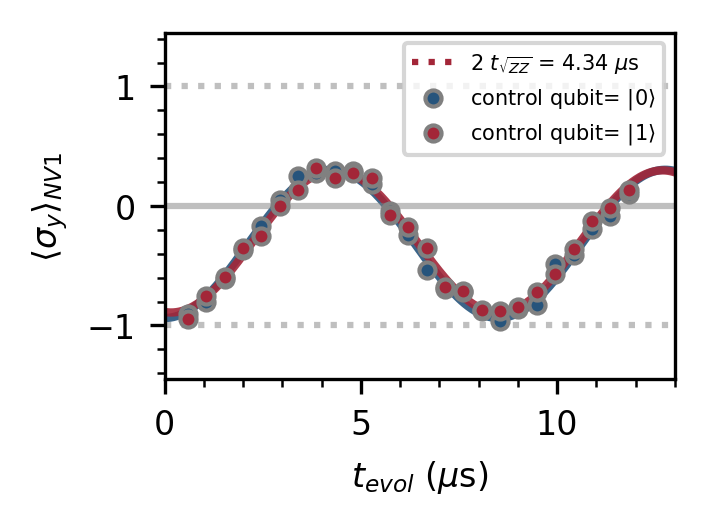

In [49]:
try:
    plot_mode = "delta"
    offset = 0.
    smooth_data = False

    x_unit = r"$\mu$s"
    #scale_fac_x = -2*16*1e6
    #scale_fac_y = 0.5*1/0.08*7.62/15.7

    scale_fac_x = -8*1e6
    #scale_fac_y = 0.5*0.5*1/0.1008 #0.5*1/0.08*7.62/15.7
    scale_fac_y = 1/ampl_delta_deer * contr_z1_deer/contr_z1_rabi 




    labels = [r'control qubit= $|$' + f'{control_qubit_state[0]}' + r'$\rangle$', 
              r'control qubit= $|$' + f'{control_qubit_state[1]}' + r'$\rangle$']

    for idx, mes in enumerate(p_raw):
        mes['plot_options'] = {'label': labels[idx]}


    plt.figure(figsize=(0.9*3, 0.9*2/3*3.5))       
    plot_multiple_1d(p_raw, n_datas=0.1, 
                     scale_fac_x=scale_fac_x, scale_fac_y=scale_fac_y)   # use n_datas to manipulse color cycle

    plt.axvline(2*scale_fac_x*tau_2_zz, label=r'2 $t_{\sqrt{ZZ}}$ ' + f'= {-2*scale_fac_x*tau_2_zz:.2f} {x_unit}',
                color=plt_settings.color('red'), linestyle=":")
    plt.axhline(0, color='grey', alpha=0.5)
    plt.axhline(1, color='grey', alpha=0.5, linestyle=":")
    plt.axhline(-1, color='grey', alpha=0.5, linestyle=":")
    

    plt.ylabel(r'$\langle \sigma_y \rangle_{NV1}$')
    
    plt.legend(loc='upper right', prop={'size': 5}, ncol=1)
    #plt.legend(prop={'size': 11})
    #plt.ylim([-1.25, 1.25])
    plt.ylim([-1.45, 1.45])
    plt.xlim([0,13])

    plt_settings.savefig('deer_sig_y.png')
    plt.show()

except:
    logger.exception("")
0

## Read_phase=90, sig_x

In [223]:
p_raw, x, y, fnames = [], [], [], []
inpath = r"E:\Data\2023\06\20230609\PulsedMeasurement\deer_dd_tau_inits_1\read_ph=90"
inpath = common_params['data_path'] + r"\2023\10\20231018\PulsedMeasurement\deer_dd_tau_tau1=3000ns_1\read_phi=90"

filter_strs = ['pulsed_measurement', '.dat']

try:
    fnames = Tk_file.list_mult_pulsed_mes(inpath, filter_strs=filter_strs, incl_subdir=False)
    fnames = fnames[::-1]
    
    for f in fnames:
        p_i = Tk_file.load_pulsed_result(f)
        copied = copy_to_path(f)
        
        p_raw.append(p_i)
except:
    logger.exception()

f_expect = [0.95e6, 0.95e6]

#"""
for idx, mes in enumerate(p_raw):
    mes['fit_settings'] = fit_settings
    mes['fit_edit_params'] = [lmfit.Parameter('offset', value=1, vary=True),
            lmfit.Parameter('amplitude', value=40e-3, min=10e-3, max=2, vary=True),
            lmfit.Parameter('frequency', value=f_expect[idx], min=0, max=2*f_expect[idx], vary=True),
            lmfit.Parameter('beta', value=1, vary=False),
            lmfit.Parameter('lifetime', value=np.inf, vary=False),
            lmfit.Parameter('phase', value=4.7, vary=True)]
#"""

    
control_qubit_state = [int("init=0.5_1.0" in f) for f in fnames]


# Perform sine fit, ATTENTION: atm no fit_edit_params -> need to manually fix Sine Lifetime = 1
y_val_idx = 1
x_val = "Time"
x_unit = "s"
scale_fac_x = [1]
scale_fac_y = [1e9, 1e-6, 1e-6]
fit_on = 'delta'
fit_meth = 'sine'
fit_vals = ['Period', 'Position 1', 'None']
fit_units = ['ns','MHz', 'MHz']
fit_settings = {'fit_range': np.linspace(-1500e-9,500e-9,1000)}
calc_dxdy_fromto = [False, False, False]
#"""

if fit_settings:
    for mes in p_raw:
        mes['fit_settings'] = fit_settings

        
x, y, y2, y3, dy = pulsed_series_2_1d_fit_array(p_raw, 
                                        fit_meth=fit_meth, fit_on=fit_on, fit_vals=fit_vals,
                                        idx_var_x=y_val_idx, ordered_x=True)

ampl_delta_deer = p_raw[0]['fit_res']['Amplitude']['value']
f_deer_90 = mes['fit_res']['Frequency']['value']/(8*mes['exp_params']['dd_order'])
df_deer_90 = mes['fit_res']['Frequency']['error']/(8*mes['exp_params']['dd_order'])
f"DEER frequency: {1e-3*f_deer_90} +- {1e-3*df_deer_90} kHz", control_qubit_state

#1/(4*f_deer_90)

('DEER frequency: 115.74424000316476 +- 2.265818755420653 kHz', [1, 0])

0

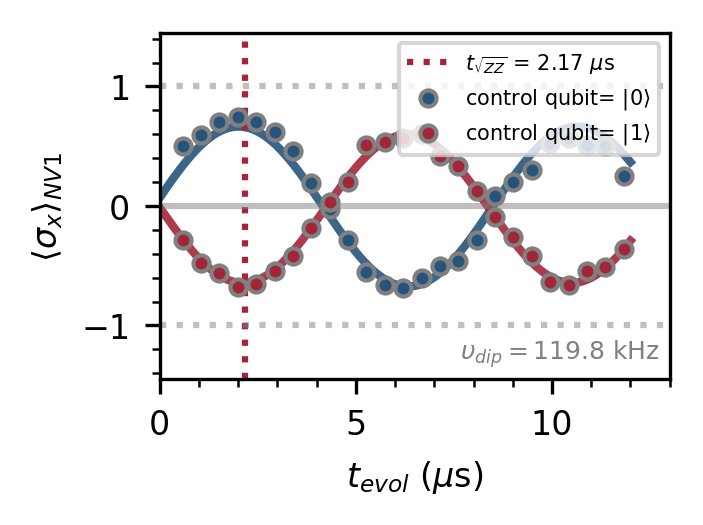

In [63]:
try:
    plot_mode = "delta"
    offset = 0.
    smooth_data = False

    x_unit = r"$\mu$s"
    scale_fac_x = -8*1e6
    #scale_fac_y = 0.5*1/0.08*7.62/15.7
    scale_fac_y = 1/ampl_delta_deer * contr_z1_deer/contr_z1_rabi 


    labels = [r'control qubit= $|$' + f'{control_qubit_state[0]}' + r'$\rangle$', 
              r'control qubit= $|$' + f'{control_qubit_state[1]}' + r'$\rangle$']
    #labels = ["",""]
    for idx, mes in enumerate(p_raw):
        mes['plot_options'] = {'label': labels[idx]}

    
    plt.figure(figsize=(0.9*3, 0.9*2/3*3.5))   
    plot_multiple_1d(p_raw[::-1], n_datas=0.1, 
                     scale_fac_x=scale_fac_x, scale_fac_y=scale_fac_y)

    #"""
    fig = plt.gcf()

    plt.axvline(scale_fac_x*tau_cnot, label=r'$t_{\sqrt{ZZ}}$ ' + f'= {-scale_fac_x*tau_2_zz:.2f}  {x_unit}',
                color=plt_settings.color('red'), linestyle=":")
    plt.axhline(0, color='grey', alpha=0.5)
    plt.axhline(1, color='grey', alpha=0.5, linestyle=":")
    plt.axhline(-1, color='grey', alpha=0.5, linestyle=":")
    
    plt.annotate(r"$\upsilon_{dip}= $"+ f"{f_deer_0/1e3:.1f}" + " kHz", xy=(0.98,0.12), xycoords='axes fraction', color='grey',
             va='top', ha='right', fontsize=6)

    plt.ylabel(r'$\langle \sigma_x \rangle_{NV1}$')
    plt.legend(loc='upper right', prop={'size': 5}, ncol=1).set_zorder(99)
    #plt.legend(prop={'size': 11})

    plt.ylim([-1.45, 1.45])
    plt.xlim([0,13])

    plt_settings.savefig('deer_sig_x.png')
    plt.show()

except:
    logger.exception("")
0

In [811]:
plt_settings.get_savepath('deer_sig_x.png')

'C:\\Users\\Setup3-PC\\Desktop\\_poster_figs\\\\deer_sig_x.png'

## Calib tau_cnot

Above, we worked in t_evol space and with long tau1/n_rep=1. For calibrating the gate, taking shorter tau1= 800 ns with n_rep=4 > 1 is better.

In [2353]:
p_raw[0]['exp_params'].keys()

{'"experiment': [[None]], 'name': 'deer_dd_tau', 'microwave_frequency': 2570990000.0, 'microwave_amplitude': 0.4368, 'rabi_period': 4.71345242588351e-08, 'dd_type': [[None, None, None, None, None, None, None, None]], 'dd_order': 4, 'num_of_points': 15, 'tau_start': -3.761895604395604e-07, 'tau_step': 2.4577717948717945e-08, 'f_mw_2': '2990840000.0', 'rabi_period_mw_2': '4.438647332587021e-08', 'ampl_mw_2': '0.30576000000000003', 'read_phase_deg': 0, 'tau1': 8e-07, 'measurement_time': 300, 'optimize_time': 3600, 'alternating': False, 'add_gate_ch': '', 'pulse_envelope': [[None]], 'tau2_rel_to_pi1': False, 'start_pix_on_1': 0, 'init_pix_on_1': 0.5, 'init_pix_on_2': 0.5, 'end_pix_on_1': 0.5, 'read_pix_on_2': 0.5, 'end_pix_on_2': 1, 'savetag': 'deer_dd_XY8-4_init=0.5_0.5_read=0.5_0.5_readph=0_pscale=0.91', 'fit_experiment': 'sine', 'fit_parameter': 'Period', 'fit_edit_params': [[None, None, None, None, None, None]], 'update_parameters': [[None]], 'optimize_func_toggle_pause': [[[]]], 'type

In [ ]:
init = p_d['exp_params']['rotations'][0]
                              
init_str = [i.name for i in init]
vec0, vec1, idx = init_2_state(init)

In [147]:
p_raw, x, y, fnames = [], [], [], []
#inpath = r"E:\Data\2023\06\20230609\PulsedMeasurement\deer_dd_tau_inits_1\read_ph=90"

# nicer plot
inpath = common_params['data_path'] + r"\2023\10\20231018\PulsedMeasurement\deer_dd_tau1=800ns_2"
# source for common['calib_tau2']
#inpath = common_params['data_path'] + r"\2023\12\20231201\PulsedMeasurement\rb2q_vs_rabi_swappedNV_2\calib\duplicate_for_plotting"


filter_strs = ['pulsed_measurement', '.dat']

f_expect = [3e6, 3e6]


try:
    fnames = Tk_file.list_mult_pulsed_mes(inpath, filter_strs=filter_strs, incl_subdir=False)
    #fnames = fnames[::-1]
    
    for f in fnames:
        p_i = Tk_file.load_pulsed_result(f)
        p_raw.append(p_i)
except:
    logger.exception()

control_qubit_state = [int("init=0.5_1.0" in f) for f in fnames]
#control_qubit_state = [r"$\vert 0 \rangle$-i$\vert 1 \rangle$ $\otimes $",
#                       ]



y_val_idx = 1
x_val = "Time"
x_unit = "s"
scale_fac_x = [1]
scale_fac_y = [1e9, 1e-6, 1e-6]
fit_on = 'z1'
fit_meth = 'sine'
fit_vals = ['Period', 'Position 1', 'None']
fit_units = ['ns','MHz', 'MHz']
fit_settings = {'fit_range': np.linspace(-500e-9,500e-9,1000)}
calc_dxdy_fromto = [False, False, False]
#"""

try:

    #"""
    for idx, mes in enumerate(p_raw):
        mes['fit_settings'] = fit_settings
        mes['fit_edit_params'] = [lmfit.Parameter('offset', value=1, vary=True),
                lmfit.Parameter('amplitude', value=40e-3, min=10e-3, max=2, vary=True),
                lmfit.Parameter('frequency', value=f_expect[idx], min=0, max=2*f_expect[idx], vary=True),
                lmfit.Parameter('beta', value=1, vary=False),
                lmfit.Parameter('lifetime', value=np.inf, vary=False),
                lmfit.Parameter('phase', value=4.7, vary=True)]
    #"""



    x, y, y2, y3, dy = pulsed_series_2_1d_fit_array(p_raw, 
                                            fit_meth=fit_meth, fit_on=fit_on, fit_vals=fit_vals,
                                            idx_var_x=y_val_idx, ordered_x=True)

except:
    logger.exception("")
    
ampl_delta_deer = p_raw[0]['fit_res']['Amplitude']['value']
f_deer = mes['fit_res']['Frequency']['value']/(1*8*mes['exp_params']['dd_order'])
df_deer = mes['fit_res']['Frequency']['error']/(1*8*mes['exp_params']['dd_order'])
f"DEER frequency: {1e-3*f_deer} +- {1e-3*df_deer} kHz", control_qubit_state

#1/(4*f_deer)

('DEER frequency: 116.74509488418815 +- 0.8427261805944488 kHz', [0])

In [3407]:
labels
#control_qubit_state[0]

['input state: $\\vert 0 \\rangle$-i$\\vert 1 \\rangle$ $\\otimes $ $\\vert 0 \\rangle$-i$\\vert 1 \\rangle$', '']

             tau        z1      std1
0  -3.761896e-07  0.886167  0.007436
1  -3.516118e-07  0.844992  0.007220
2  -3.270341e-07  0.792436  0.006926
3  -3.024564e-07  0.744150  0.006660
4  -2.778787e-07  0.726239  0.006572
5  -2.533010e-07  0.730049  0.006606
6  -2.287233e-07  0.771901  0.006834
7  -2.041455e-07  0.816104  0.007071
8  -1.795678e-07  0.868756  0.007339
9  -1.549901e-07  0.894760  0.007452
10 -1.304124e-07  0.910691  0.007565
11 -1.058347e-07  0.877098  0.007368
12 -8.125695e-08  0.830836  0.007118
13 -5.667923e-08  0.789204  0.006883
14 -3.210151e-08  0.752555  0.006734

'tau_calib: -2.711e-07, t_calib=-4.3376e-06, dt_calib= 3.131102925200129e-08'

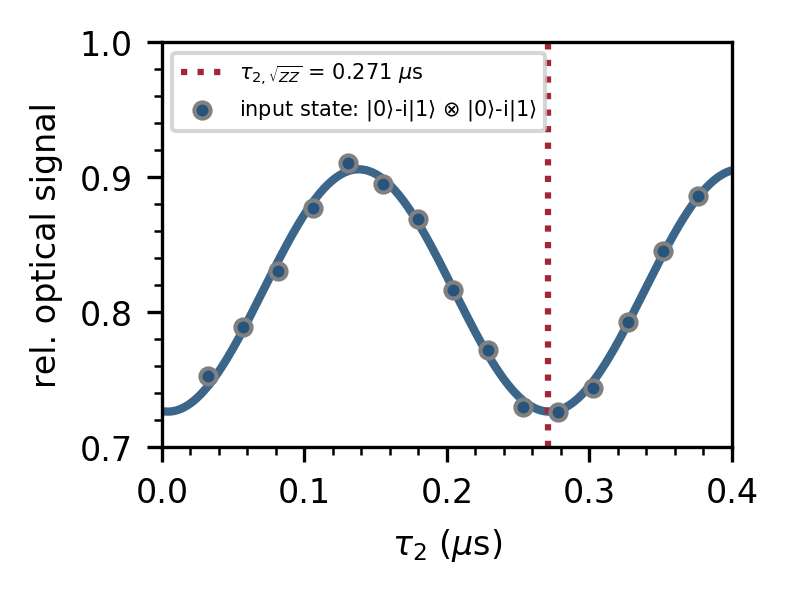

In [150]:

plot_mode = "z1"
offset = 0.
smooth_data = False

x_unit = r"$\mu$s"
scale_fac_x = -1e6
scale_fac_y = 1 #0.5*1/ampl_delta_deer * contr_z1_deer/contr_z1_rabi 


#labels = [r"control qubit= " + control_qubit_state[0], ""]
labels = [r"input state: $\vert 0 \rangle$-i$\vert 1 \rangle$ $\otimes $ $\vert 0 \rangle$-i$\vert 1 \rangle$", ""]

for idx, mes in enumerate(p_raw):
    mes['plot_options'] = {'label': labels[idx]}

plt.figure(figsize=(0.9*3, 0.9*2/3*3.5))
plot_multiple_1d(p_raw, plot_mode=plot_mode,
                scale_fac_x=scale_fac_x, scale_fac_y=scale_fac_y)

#"""
fig = plt.gcf()
#tau_cnot = -1/f_deer/(2*8)/4
tau_cnot = common_params['tau2_zz']  # deer calib @ Rabi= 22.98 MHz (settings close to EPC mes), 20231202-1131-45
#tau_cnot = scale_fac_x*0.5*-212e-9

plt.axvline(scale_fac_x*tau_cnot, label=r'$\tau_{2,\sqrt{ZZ}}$ ' + f'= {scale_fac_x*tau_cnot:.3f} {x_unit}',
            color=plt_settings.color('red'), linestyle=":")
#plt.axhline(0, color='grey', alpha=0.5)

plt.xlabel(r'$\tau_2$' + f" ({x_unit})")
plt.ylabel(r'$\sigma_x$')
plt.ylabel(r'rel. optical signal')
plt.legend(loc='upper left', prop={'size': 5}, ncol=1)

#plt.ylim([-0.5,0.5])
plt.xlim([0., 0.4])
plt.ylim([0.7, 1])

plt.tight_layout()
plt_settings.savefig('suppl_deer_calib.png',
                    frame_top_inch=0.2, frame_right_inch=0.1)
plt.show()

# the calibration point is found from the minimum point (see auto rand_bench script)
# we estimate the error just from the relative error on the frequency

qdplotlogic.set_data(p_raw[0]['data']['tau'], p_raw[0]['data']['z1'], plot_index=0)

f"tau_calib: {tau_cnot}, t_calib={2*8*tau_cnot}, dt_calib= {abs(df_deer/f_deer*2*8*tau_cnot)}"


# Post selected mes

Load multiple listfiles

In [9]:
def avg_chunked_pmes(p_mess_chunked, n_thresh_idx=0):
    
    p_single = []
    
    z1_sum, z2_sum, delta_sum = [],[],[]
    dz1_sum, dz2_sum = [], []
    
    for idx, p_per_n in enumerate(p_mess_chunked):
        try:
            z1 = p_per_n[n_thresh_idx]['data']['z1'] 
            z2 = p_per_n[n_thresh_idx]['data']['z2'] 
            dz1 = p_per_n[n_thresh_idx]['data']['dz1'] 
            dz2 = p_per_n[n_thresh_idx]['data']['dz2'] 
            taus = p_per_n[n_thresh_idx]['data']['tau'] 
        except IndexError:
            logger.warning(f"No phots for chunk idx= {idx}, n_thresh= {n_thresh_idx}")
            z1 = np.zeros(len(p_per_n[0]['data']['z1']))
            z2 = z1
            dz1, dz2 = z1, z1
            taus = p_per_n[0]['data']['tau'] 

        
        delta = (z1-z2) 
        ddelta = np.sqrt(dz1**2+dz2**2)

        z1_sum.append(z1)
        z2_sum.append(z2)
        dz1_sum.append(dz1)
        dz2_sum.append(dz2)
        delta_sum.append(z1-z2)

        p_single.append({'data': {'tau': taus, 'z1': z1, 'z2': z2, 'dz1': dz1, 'dz2': dz1,
                                  'delta': delta, 'ddelta': ddelta},
                         'infos': p_per_n[n_thresh_idx]['infos']})
    
    dz1_sum, dz2_sum = np.asarray(dz1_sum), np.asarray(dz2_sum)
    
    # Average over accepted chunks
    n = len(p_mess_chunked)
    z1_avg = np.nansum(z1_sum, axis=0)/n
    z2_avg = np.nansum(z2_sum, axis=0)/n
    #dz1_avg = np.sum(dz1_sum**2, axis=0)/np.sum(z1_sum, axis=0)*z1_avg
    #dz2_avg = np.sum(dz2_sum**2, axis=0)/np.sum(z2_sum, axis=0)*z2_avg
    dz1_avg = np.sqrt(np.nansum(dz1_sum**2, axis=0))/n
    dz2_avg = np.sqrt(np.nansum(dz2_sum**2, axis=0))/n
    delta_avg = z1_avg - z2_avg
    ddelta_avg = np.sqrt(dz1_avg**2+dz2_avg**2)
    
    p_mes = {}
    p_mes['data'] = {'tau': taus, 'z1': z1_avg, 'z2': z2_avg, 'dz1': dz1_avg, 'dz2': dz1_avg,
                     'delta': delta_avg, 'ddelta': ddelta_avg}
        
    return p_mes, p_single
  


def hist_find_lambdas(data_raw, t_read):


    # all arrival times per laser
    t_arrive = post_select(data_raw, t_red=t_read,
                           t_read=t_read,
                           t_bin=400e-12, 
                           n_thresh=0)
    t_arrive = t_arrive[0]

    t_arrive = [t for t in t_arrive if not any(t==np.asarray([-1]))]
    n_phots_per_laser = np.asarray([len(t[t!=0]) for t in t_arrive])


    phot_info_dict = {'t_arrive': t_arrive, 'n_phots_per_laser': n_phots_per_laser}


    y_hist, x_hist = np.histogram(n_phots_per_laser, bins=np.max(n_phots_per_laser), density=True)
    x_hist = x_hist[:-1]



    l_mes = {'data': {'type': 'photon_histogram'},
             'infos': phot_info_dict,
             't_cinit': t_read}  
    l_mes['data'].update({'tau': x_hist, 'z1': y_hist})

    l_mes['fit_edit_params'] = [lmfit.Parameter('p0_mu', value=1.0, min=0, max=20, vary=True),
                                lmfit.Parameter('p1_mu', value=2.2, min=0, max=20, vary=True),
                                lmfit.Parameter('p2_mu', value=4.5, min=0, max=20, vary=True),
                                lmfit.Parameter('p0_amplitude', value=0.3, min=0, max=10, vary=True),
                                lmfit.Parameter('p1_amplitude', value=0.3, min=0, max=10, vary=True),
                                lmfit.Parameter('p2_amplitude', value=0.3, min=0, max=10, vary=True)]
    do_fit(l_mes, fit_y='z1', fit_method='poisson_3x', edit_params=l_res['fit_edit_params'])
    
    l_mes['fit_res']['nv_min_ratio'], ratio_details = calc_nv_min_ratio(l_mes, ratio_at_least_1min=False)
    l_mes['fit_res']['d_nv_min_ratio'] = ratio_details['d_ratio_nv-']
    l_mes['fit_res']['contrast_read'] = ratio_details['lambdas'][0]/ratio_details['lambdas'][-1]
    l_mes['fit_res']['d_contrast_read'] = l_res['fit_res']['contrast_read']*np.sqrt((ratio_details['d_lambdas'][0]/ratio_details['lambdas'][0])**2 + (ratio_details['d_lambdas'][-1]/ratio_details['lambdas'][-1])**2)
    
    
    mus = {key: val for key, val in l_mes['fit_res'].items() if 'mu' in key}
    
    return mus, l_mes
    

def hist_post_selected(data_raw, t_pcs, t_read, n_thresh=0, lambdas=None):
    
    # divide the orange laser in a charge-init (pcs) and read charge part
    t_hist = t_read

    # all arrival times per laser
    t_arrive = post_select(data_raw, t_red=t_pcs,
                           t_read=t_hist,
                           t_bin=400e-12, 
                           n_thresh=n_thresh)
    t_arrive = t_arrive[0]
    t_arrive = [t for t in t_arrive if not any(t==np.asarray([-1]))]

    n_phots_per_laser = np.asarray([len(t[t!=0]) for t in t_arrive])


    phot_info_dict = {'n_thresh':n_thresh, 't_arrive': t_arrive, 'n_phots_per_laser': n_phots_per_laser}


    y_hist, x_hist = np.histogram(n_phots_per_laser, bins=np.max(n_phots_per_laser), density=True)
    x_hist = x_hist[:-1]

    

    l_mes = {'data': {'type': 'photon_histogram'},
             'infos': phot_info_dict,
             't_cinit': t_pcs, 't_hist':t_hist}  
    l_mes['data'].update({'tau': x_hist, 'z1': y_hist})

    fix_lambdas = True
    if lambdas is None:
        fix_lambdas = False
        mu0 = 0.5
        mu1 = 2
        mu2 = 4
    else:
        mu0 = lambdas['p0_mu'].value
        mu1 = lambdas['p1_mu'].value
        mu2 = lambdas['p2_mu'].value

        
    
    l_mes['fit_edit_params'] = [lmfit.Parameter('p0_mu', value=mu0, min=0, max=20, vary=not fix_lambdas),
                                lmfit.Parameter('p1_mu', value=mu1, min=0, max=20, vary=not fix_lambdas),
                                lmfit.Parameter('p2_mu', value=mu2, min=0, max=20, vary=not fix_lambdas),
                                lmfit.Parameter('p0_amplitude', value=0.3, min=0, max=10, vary=True),
                                lmfit.Parameter('p1_amplitude', value=0.3, min=0, max=10, vary=True),
                                lmfit.Parameter('p2_amplitude', value=0.3, min=0, max=10, vary=True)]
    do_fit(l_mes, fit_y='z1', fit_method='poisson_3x', edit_params=l_mes['fit_edit_params'])

    l_mes['fit_res']['nv_min_ratio'], ratio_details = calc_nv_min_ratio(l_mes, ratio_at_least_1min=False)
    l_mes['fit_res']['d_nv_min_ratio'] = ratio_details['d_ratio_nv-']
    l_mes['fit_res']['contrast_read'] = ratio_details['lambdas'][0]/ratio_details['lambdas'][-1]
    l_mes['fit_res']['d_contrast_read'] = l_res['fit_res']['contrast_read']*np.sqrt((ratio_details['d_lambdas'][0]/ratio_details['lambdas'][0])**2 + (ratio_details['d_lambdas'][-1]/ratio_details['lambdas'][-1])**2)
    
    return l_mes

def load_listfile_data(inpath, slice_files=None, incl_subdir=False):
    
    if slice_files == None:
        slice_files = slice(0,None,1)
    
    filter_strs = ['.lst']
    #filter_strs += ['rabi']

    n_data_bits = 28
    header_length = 74

    fnames = []
    try:
        fnames = Tk_file.list_mult_pulsed_mes(inpath, filter_strs=filter_strs, incl_subdir=incl_subdir)
        fnames = sorted(fnames, key=os.path.getctime) # todo: remove, oved to TK
    except:
        logger.exception("")
        
    logger.debug(f"Files to load: {[os.path.basename(f) for f in fnames]}")
    data_raw = []

    for idx_f, fname in enumerate(fnames[slice_files]):
        try:
            fname = os.path.abspath(fname)
            logger.debug(f"[{idx_f}] Loading list file: {fname}")
            res = qdyne_conventional_extraction(fname, all_counts=True, lines_to_read=None, # lines_to_read=int(40e6), # 5e5 
                                               headerlength=header_length, n_mask_bits=n_data_bits)


            res = set_hist_pdata(res)
            data_raw.append(res)
        except:
            logger.exception("")
            raise
        
    return data_raw


def extract_pmes_pcs(data_raw, n_threshs, t_orange=None, t_read=None, t_norm=None, idx_reference=None, taus=None):
    # extract a pulsed measurement of form PL vs tau from listfile(s)
    t_bin = 400e-12
    
    try:
        p_mess = []
        for n in n_threshs:
            # all arrival times per laser
            t_arrive = post_select(data_raw, t_red=t_orange, t_read=[t_read[0], None],
                            t_bin=t_bin, 
                            n_thresh=n)
            t_arrive_orange = post_select(data_raw, t_read=t_orange, n_thresh=0, t_bin=t_bin)
            t_arrive_orange = [item for sublist in t_arrive_orange for item in sublist] # flatten
            
            # arrival times per tau
            t_arrive_per_tau = collapse_single_lasers(t_arrive, n_taus=len(taus), alternating=True)

            # debug, from a single file
            #t_arrive_per_tau = collapse_single_lasers([t_arrive[1]], n_taus=n_taus, alternating=True)
            phots_sum = np.sum([len(tau) for tau in t_arrive_per_tau])
            phots_orange = np.sum([arr.size for arr in t_arrive_orange])

            # PL signal per tau
            pl = [t_arrive_2_spin_state(t_arr, 
                                          t_analyse=t_read,
                                          t_norm=t_norm,
                                          t_bin=t_bin) for t_arr in t_arrive_per_tau]
            #phots_orange = np.sum([t_arrive_2_phots(t_arr, 
            #                              t_window=t_orange,
            #                              t_bin=t_bin) for t_arr in t_arrive_per_tau])
            
            y_pl = [el[0] for el in pl]
            dy_pl = [el[1] for el in pl]
            infos = [el[2] for idx, el in enumerate(pl)]

            phot_info_dict = {'n_thresh':n, 'n_photons': phots_sum, 'photons_per_tau': infos,
                             'n_photons_orange': phots_orange}

            z1, z2 = np.asarray(y_pl[::2]), np.asarray(y_pl[1::2])
            dz1, dz2 = np.asarray(dy_pl[::2]), np.asarray(dy_pl[1::2])
            
            # todo: still need idx_reference here? Can also use during plotting
            if idx_reference == 0:
                ref = z1[0]-z2[0]
                z1,z2,dz1,dz2 = z1[1:]/ref, z2[1:]/ref, dz1[1:]/ref, dz2[1:]/ref # todo: check
                taus_i = taus[1:]
            else:
                taus_i = taus

            p_mes = {'data': {'z1': z1, 'z2': z2, 'tau': taus_i, 'dz1': dz1,  'dz2': dz2},
                     'infos': phot_info_dict}  # todo: proper tau


            p_mess.append(p_mes)
    except:
        logger.exception("")
    return p_mess


def extract_pmes_chunked(data_raw, n_threshs, taus, t_cinit_red, t_analyse, t_norm):

    # analyse every listfile in data_raw on it's own and append, if condition met
    func_accept_chunk = {'n_thresh': 9, '_func': lambda idx, z1, z2, infos: True}

    p_mess_chunks = []  # all chunks
    for idx, data in enumerate(data_raw):
        p_mess_i = extract_pmes_pcs(data, n_threshs,  taus=taus,
                     t_orange=t_cinit_red, t_read=t_analyse, t_norm=t_norm)

        use_chunk = False
        if func_accept_chunk != None:
            n_target = func_accept_chunk['n_thresh']
            for p_mes in p_mess_i:
                n_mes = p_mes['infos']['n_thresh']
                if n_target == n_mes:
                    z1, z2 = p_mes['data']['z1'], p_mes['data']['z2']
                    infos = p_mes['infos']
                    use_chunk = func_accept_chunk['_func'](idx, z1, z2, infos)

        [p_mes['infos'].update({'idx_chunk':  idx}) for p_mes in p_mess_i]
        [p_mes['infos'].update({'n_chunks' :len(data_raw)}) for p_mes in p_mess_i]
        [p_mes['infos'].update({'use_chunk' :use_chunk}) for p_mes in p_mess_i]

        p_mess_chunks.append(p_mess_i)
        
    return p_mess_chunks
0

0

In [32]:
0

0

## Post selected DEER

In [95]:
0

0

### Read_phase=0, sig_y (assymetric)

In [11]:
#path = common_params['data_path'] + r"\2023\11\20231107\deer_dd_0.5,0_phase=0_pcs_1"

# oil obj
path = common_params['data_path'] + r"\2023\12\20231221\deer_dd_0.5_0_pcs_p=12mw+od2_1"

# can get the extraction params from _pulsed_measurement.dat
t_analyze_green = 280e-9

#t_cinit_red = [0.21e-3, 18.9e-3]
#t_analyse = [0.0189473, 0.0189473 + t_analyze_green]
#t_norm = [t_analyse[0]+2e-6, t_analyse[1]+2.5e-6]


# oil obj
t_cinit_red = [0.1e-3, 4.52e-3]
t_cinit_red = [0.1e-3, 4.0e-3]     # optimized t_pcs for nice deer_sigy oscillation


t_analyse = [0.0045473, 0.0045473 + t_analyze_green]
t_norm = [t_analyse[0]+2e-6, t_analyse[1]+2.5e-6]




n_threshs= list(range(0,13))


#taus = np.asarray([-4e-07, -3.7066666666666665e-07, -3.413333333333333e-07, -3.12e-07, -2.8266666666666666e-07, -2.5333333333333327e-07, -2.2399999999999997e-07, -1.9466666666666664e-07, -1.653333333333333e-07, -1.3599999999999995e-07, -1.0666666666666662e-07, -7.733333333333328e-08, -4.7999999999999953e-08, -1.8666666666666622e-08, 1.066666666666671e-08])
taus = np.asarray([-1.479e-06, -1.381e-06, -1.284e-06, -1.186e-06, -1.088e-06, -9.908e-07, -8.932e-07, -7.956e-07, -6.980e-07, -6.004e-07, -5.028e-07, -4.052e-07, -3.076e-07, -2.100e-07, -1.124e-07])
# with ref
taus = np.asarray([-4.21131624e-06, -1.47869250e-06, -1.38109879e-06, -1.28350509e-06, -1.18591139e-06, -1.08831768e-06, -9.90723975e-07, -8.93130270e-07, -7.95536565e-07, -6.97942860e-07, -6.00349155e-07, -5.02755450e-07, -4.05161745e-07, -3.07568040e-07, -2.09974335e-07, -1.12380630e-07])

try:
    copy_to_path(path)
    # for the paper data, data inside "continue" has way lower contrast, so don't load 
    data_raw_ps = load_listfile_data(inpath=path, incl_subdir=False) 
except:
    logger.exception("")
    
len(data_raw_ps)

72

In [153]:
n_threshs= list(range(0,13))


In [1121]:
# debug only
raise
t_cinit_red = [0.1e-3, 4.52e-3]  # assym @n_thresh= 9:
t_cinit_red = [0.1e-3, 4.02e-3]  # assym @n_thresh= 9: 0.191
t_cinit_red = [0.1e-3, 3.75e-3]  # assym @n_thresh= 9: 0.210
t_cinit_red = [0.1e-3, 3.88e-3]  # assym @n_thresh= 9:


t_cinit_red

[0.0001, 0.00388]

In [1907]:
[data_raw_ps[0]['debug_raw_data'][0:10]], [data_raw[0]['debug_raw_data'][0:10]]

([array([       0,    96166,  3898278, 19393456, 19682016, 47365538,
              0,    96117,   107540,  8437119])], [array([       0,    96166,  3898278, 19393456, 19682016, 47365538,
              0,    96117,   107540,  8437119])])

In [187]:
import time

filter_strs = ['.lst']
birth_time = os.path.getctime

fnames = []
try:
    fnames = Tk_file.list_mult_pulsed_mes(path, filter_strs=filter_strs, incl_subdir=True)
    fnames = sorted(fnames, key=birth_time) # todo: remove, oved to TK
except:
    logger.exception("")
    
#[(os.path.basename(f), time.ctime(birth_time(f))) for f in fnames]

In [1388]:
del(data_raw_ps)

#### chunked analysis

Finding the right chunks shouldn't be needed here. Can be run in PostProcess_qudiplotter.ipynb. Then continue with a chunk index filter here.

In [692]:
raise NormallyNotNeeded

121

In [35]:
raise NormallyNotNeeded
# this is used to generate chunks that are analyzeable with different filter conditions

p_mess_chunks = extract_pmes_chunked(data_raw_ps, n_threshs, taus, t_cinit_red, t_analyse, t_norm) 


In [39]:
# filtering only needed for data with air objective
filter_chunks = False   
p_mess_chunked = p_mess_chunks

if filter_chunks:
    idx_accept = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 17, 18, 19, 20, 21, 22, 23, 25, 26, 28, 29, 30, 31, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68, 69, 70, 71]
    
    p_mess_chunked = [p for idx, p in enumerate(p_mess_chunks) if idx in idx_accept]
    
len(p_mess_chunked), len(p_mess_chunks)

(121, 121)

In [43]:
raise NormallyNotNeeded
# use normal analysis

p_mess = []
try:
    for n_th in n_threshs:

        p_avg, p_all = avg_chunked_pmes(p_mess_chunked, n_thresh_idx=n_th)
        #p_avg = fit_avg_pmes(p_avg)
        p_mess.append(p_avg)
except:
    logger.exception("")
        
p_mess_per_folder = [{'file': data_raw_ps[0]['file'], 'p_mess': p_mess}]
len(p_mess)

12

#### normal anaylsis

In [1911]:
len(data_raw_ps)

72

For the paper, we analyzed possible chunk filters from Postprocess_qudiplotter.ipynb. Essentially, later data seems to show way loss contrast, possibly caused by drifting of optics or dirt in the oil. Thus, we exclude loading of subfolders (-> later date in continued), but can use `filter_chunks=False` here.


In [157]:
# Sum all photons first

p_mess = [] 
filter_chunks = False # 

if filter_chunks:
    chunks_accept_filter = [0,1]
    data_raw_ps_filtered = [d for idx,d in enumerate(data_raw_ps) if idx in chunks_accept_filter]
else:
    data_raw_ps_filtered = [d for idx,d in enumerate(data_raw_ps) if True]


try:
    p_mess = extract_pmes_pcs(data_raw_ps_filtered, n_threshs,  taus=taus,
                     t_orange=t_cinit_red, t_read=t_analyse, t_norm=t_norm)
except:
    logger.exception("")
    

p_mess_per_folder = [{'file': data_raw_ps[0]['file'], 'p_mess': p_mess}]

len(data_raw_ps_filtered), len(p_mess)

(72, 13)

In [159]:
len(data_raw_ps_filtered), len(p_mess), n_threshs

(72, 13, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

In [31]:
# SLICE only every dataset
raise # do you really want to do this?
mask_idxs = [0]

try:
    for p_idx in p_mess_per_folder:
        for p in p_idx['p_mess']:
            p_new = pd.DataFrame(p['data'])
            p['data'] = p_new.drop(mask_idxs)
except:
    logger.exception("")
    
0

Traceback (most recent call last):
  File "C:\Users\Setup3-PC\Desktop\qudi\logic\jupyterkernel\qzmqkernel.py", line 679, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-a8799127149a>", line 2, in <module>
    raise # do you really want to do this?
RuntimeError: No active exception to reraise


#### norm + plot

In [161]:
# NORM every post selected pulsed result (in all folders)

idx_zref = 0
mask_idxs = [0]

try:
    for p_idx in p_mess_per_folder:
        for i, p in enumerate(p_idx['p_mess']):
            p_norm = norm_on_delta(p['data'], idx_zref=0, mask_idxs=[0])
            #p_norm = norm_on_delta(p['data'], idx_zref=0) # debug only
            p['data'] = p_norm
            #if i == 9:
            #    break
except:
    logger.exception("")
    
0

0

In [163]:
# load pulsed result files that correspond to the listfiles laded above

fname_p = common_params['data_path'] + r"\2023\10\20231027\deer_dd_psc_1"  + "\\" \
            + r"20231027-0840-41_deer_dd_XY8-1_init=0.5_0.0_read=0.5,0.0_readph=0_fci_pulsed_measurement.dat"
fname_p = common_params['data_path'] + r"\2023\12\20231221\deer_dd_0.5_0_pcs_p=12mw+od2_1" + "\\" \
            + r"20231224-1907-57_deer_dd_XY8-1_init=0.5_0.0_read=0.5,0.0_readph=0_fci_pulsed_measurement.dat"
    
paths_pulsed = [fname_p] 

p_datas = []
for fname in paths_pulsed:
    
    #copy_to_path(fname)  # should be copied above already when loading .lst files
    fname = os.path.normpath(fname)
    p_data = Tk_file.load_pulsed_result(fname)
    
    p_datas.append(cp.deepcopy(p_data))
    
len(p_datas)

1

In [107]:
len(p_mess_i[9])

6

In [167]:
# take meta data from 'normal' pulsed result
# get data from post selected list files

idx_nthresh = 12

try:
    for idx, p in enumerate(p_mess_per_folder):
        p_mess_i = p['p_mess']
        
        
        p_inject = cp.deepcopy(p_mess_i[idx_nthresh])

        #p_inject['data'].pop('delta_norm', None)  # todo: probably only needed, if no z_ref
        p_inject['data']['std1'] = p_inject['data']['dz1']
        p_inject['data']['std2'] = p_inject['data']['dz2']

        p_inject['data'] = pd.DataFrame(p_inject['data'])
        
        p.update({'data_pcs_inject': p_inject})
        # make p_mess fitable
        for jdx, n in enumerate(n_threshs):
            p_mess_i[jdx].update({'file': p_datas[idx]['file']})
            p_mess_i[jdx].update({'date': p_datas[idx]['date']})
        
    # inject into every p_data
    for idx, p in enumerate(p_datas):
        p_inject = p_mess_per_folder[idx]['data_pcs_inject']
        p_datas[idx]['data'] = p_inject['data']
        #p['exp_params']['rotations'] = p_inject['exp_params']['rotations']

except:
    logger.exception("")

f"{len(p_datas)}, n_thresh= {n_threshs[idx_nthresh]}"

'1, n_thresh= 12'

In [169]:
# Perform fit
# ATTENTION: Fix lifetime=1 and frequency = 960 kHz (from non-pcs DEER)

y_val_idx = 1
x_val = "Time"
x_unit = "s"
scale_fac_x = [1]
scale_fac_y = [1e9, 1e-6, 1e-6]
fit_on = 'delta'
fit_meth = 'sine'
fit_vals = ['Period', 'Position 1', 'None']
fit_units = ['ns','MHz', 'MHz']
fit_settings = {'fit_range': np.linspace(-2e-6, 1e-6, 1000)}
#fit_settings = {}
calc_dxdy_fromto = [False, False, False]
#"""



f_deer_expect = 0.958e6  # from non-pcs deer_y
#f_deer_expect = 0.910e6  
phi_deer_expect = 4.834
phi_deer_expect = 5.14418
f_deer_fix = False
phi_deer_fix = False


if fit_settings:
    for mes in p_datas:
        mes['fit_settings'] = fit_settings

        mes['fit_edit_params'] = [lmfit.Parameter('offset', value=0, vary=True),
                lmfit.Parameter('amplitude', value=0.7, min=10e-3, max=2, vary=True),
                lmfit.Parameter('frequency', value=f_deer_expect, min=0, max=2*f_deer_expect, vary=not f_deer_fix),
                lmfit.Parameter('beta', value=1, vary=False),
                lmfit.Parameter('lifetime', value=np.inf, vary=False),
                lmfit.Parameter('phase', value=phi_deer_expect, vary=not phi_deer_fix)]



try:
    x, y, y2, y3, dy = pulsed_series_2_1d_fit_array(p_datas, 
                                            fit_meth=fit_meth, fit_on=fit_on, fit_vals=fit_vals,
                                            idx_var_x=y_val_idx, ordered_x=True)
    
    x, y, y2, y3, dy = pulsed_series_2_1d_fit_array(p_mess_per_folder[0]['p_mess'], 
                                        fit_meth=fit_meth, fit_on=fit_on, fit_vals=fit_vals,
                                        idx_var_x=None, ordered_x=False)
except:
    logger.exception("")

0

0

In [171]:
ampl_i = p_datas[0]['fit_res']['amplitude'].value
off_i = p_datas[0]['fit_res']['offset'].value

off_i/ampl_i

-0.2087009107064432

Plot

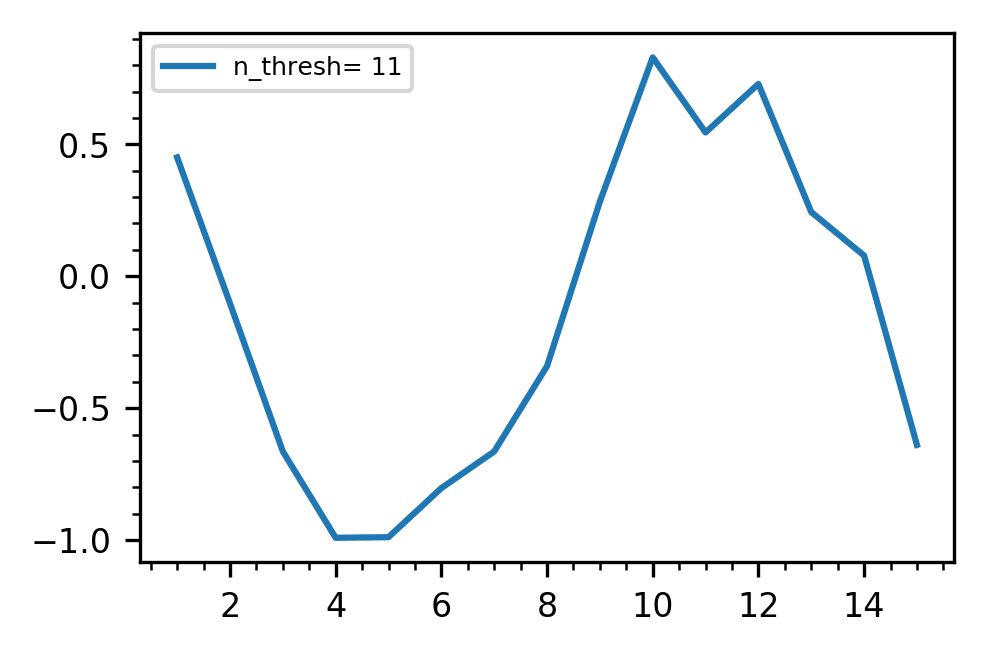

In [137]:
plt.plot(p_mess[9]['data']['delta'], label=f"n_thresh= {n_threshs[idx_nthresh]}")
plt.legend()

plt.show()

Traceback (most recent call last):
  File "C:\Users\Setup3-PC\Desktop\qudi\logic\jupyterkernel\qzmqkernel.py", line 679, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-87-2054848fa51e>", line 1, in <module>
    ampl_i = p_datas[0]['fit_res']['amplitude'].value
KeyError: 'fit_res'


0

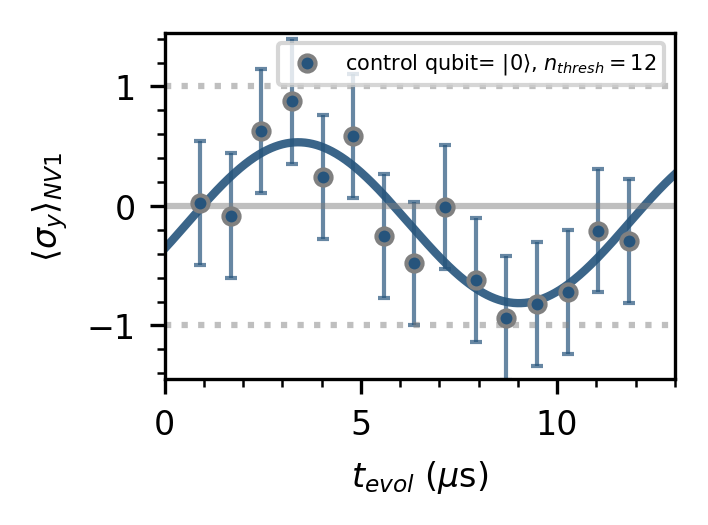

In [173]:

plot_mode = "delta"
offset = 0.
smooth_data = False

x_unit = r"$\mu$s"
#scale_fac_x = -2*16*1e6
#scale_fac_y = 0.5*1/0.08*7.62/15.7

scale_fac_x = -1*8*1e6
#scale_fac_x = 1
# if normed on first datapoint, make sure that full contrast axis= [-0.5, 0.5] 
scale_fac_y = 1   #1 #0.5*1/ampl_delta_deer * contr_z1_deer/contr_z1_rabi 

try:

    labels = [r'control qubit= $| 0 \rangle$, $n_{thresh}=$'+f"{n_threshs[idx_nthresh]}",
              r'control qubit= $|1 \rangle$']
    for idx, mes in enumerate(p_datas):
        mes['plot_options'] = {'label': labels[idx]}

    plt.figure(figsize=(0.9*3, 0.9*2/3*3.5))   
    plot_multiple_1d(p_datas, n_datas=0.1, plot_err=True,  # use n_datas to manipulse color cycle
                     scale_fac_x=scale_fac_x, scale_fac_y=scale_fac_y,
                     color=plt_settings.color('blue'))   

    #tau_cnot = 2*scale_fac_x*-272e-9
    #tau_cnot = -1/f_deer/(2*8)/4
    #tau_cnot = -272e-9

    #plt.axvline(2*scale_fac_x*tau_cnot, label=r'2 $t_{CPhase}$ ' + f'= {2*scale_fac_x*tau_cnot:.2f} {x_unit}',
    #            color=plt_settings.color('red'), linestyle=":")
    plt.axhline(0, color='grey', alpha=0.5)
    plt.axhline(1, color='grey', alpha=0.5, linestyle=":")
    plt.axhline(-1, color='grey', alpha=0.5, linestyle=":")
    

    plt.legend(loc='upper right', prop={'size': 5}, ncol=1)
    #plt.legend(prop={'size': 11})
    plt.ylim([-1.45, 1.45])
    plt.xlim([-2e-6,0])
    plt.xlim([0,13])
    
    #plt.grid()
    plt.ylabel(r'$\langle \sigma_y \rangle_{NV1}$')

    plt_settings.savefig('deer_sig_y_pcs.png')
    #plt.savefig(plt_settings.get_savepath('deer_sig_x_pcs.png'), dpi=300)
    plt.show()

except:
    logger.exception("")
0

In [392]:
plt_settings.color('red')

(0.6392156862745098, 0.14901960784313725, 0.2196078431372549, 1.0)

In [231]:
ampl_i = p_datas[0]['fit_res']['amplitude'].value
off_i = p_datas[0]['fit_res']['offset'].value

off_i/ampl_i, ampl_i, off_i

(-0.18110157235090496, 0.5407776173934009, -0.097935676802121)

In [1772]:
plt.figure()
plt.savefig(plt_settings.get_savepath('deer_sig_y_pcs.png'), dpi=300)

#### Assymetry vs n_thresh

0

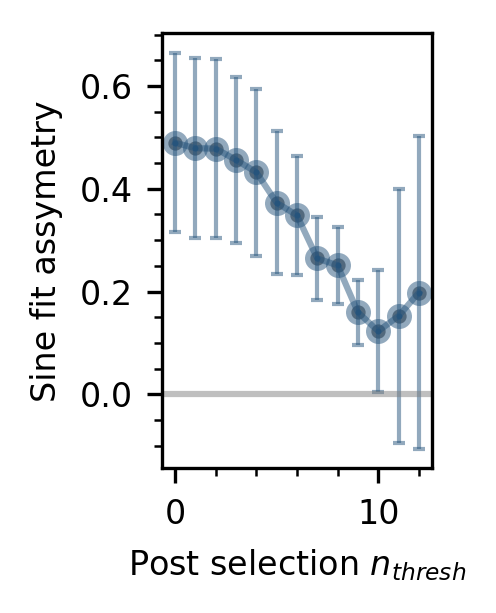

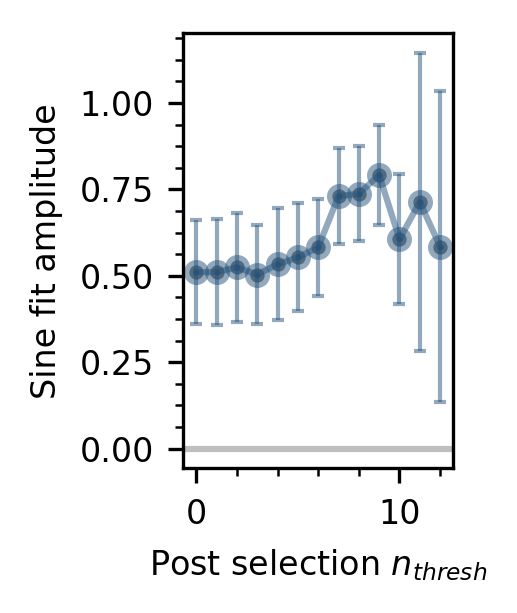

In [175]:

fit_on = 'delta'

p_mess = p_mess_per_folder[0]['p_mess']

try:

    ns = len(n_threshs)
    
    y0, y1 = [],[]
    dy0, dy1 = [],[]
    
    for idx, n in enumerate(n_threshs):
        p_mes = p_mess[idx]
        
        # Calculate metric
        if fit_on is not None:
            off_i, doff_i = p_mes['fit_res']['Offset']['value'], p_mes['fit_res']['Offset']['error']
            ampl_i, dampl_i = p_mes['fit_res']['Amplitude']['value'], p_mes['fit_res']['Amplitude']['error']
            doffampl_i = abs(off_i/ampl_i*np.sqrt((doff_i/off_i)**2 + (dampl_i/ampl_i)**2))
            #doffampl_i = 0
            #lifetime_i, dlifetime_i = p_mes['fit_res']['Lifetime']['value'], p_mes['fit_res']['Lifetime']['error']
        
            y0.append(abs(off_i/ampl_i))
            #y0.append(off_i)
            dy0.append(doffampl_i)
            y1.append(ampl_i)
            dy1.append(dampl_i)
        
        else:
            #y0.append(0)
            #dy0.append(0)
            y1.append(0)
            dy1.append(0)
            
            y0.append(delta[1])
            dy0.append(ddelta[1])

     # assymetry
    plt.figure(figsize=(1.7, 2.7/3*2/3*3.5)) 
   
    
    color = plt_settings.color('blue')
    marker_style = plt_settings.marker_style(color, is_scatter=True)
    marker_err_style = plt_settings.marker_style(color, is_scatter=False, is_err=True)

    plt.errorbar(n_threshs, y0, dy0, alpha=0.5,
                **marker_err_style)
    plt.scatter(n_threshs, y0, alpha=1, **marker_style)
    
    plt.axhline(0, color='grey', alpha=0.5)
    #plt.ylim([-0.2, 0.75 ])
    #plt.grid()
    
    plt.xlabel(r"Post selection $n_{thresh}$")
    plt.ylabel("Sine fit assymetry")

    plt_settings.savefig('deer_pcs_fits_vs_nthresh.png', frame_right_inch=0.2, frame_left_inch=0.6,
                                                         frame_top_inch=0.15, frame_bottom_inch=0.5)

    # Amplitude
    plt.figure(figsize=(1.7, 2.7/3*2/3*3.5))     
    
    plt.errorbar(n_threshs, y1, dy1, alpha=0.5,
                **marker_err_style)
    plt.scatter(n_threshs, y1, alpha=1, **marker_style)
    
    plt.axhline(0, color='grey', alpha=0.5)
    #plt.ylim([-0.2, 0.75 ])
    #plt.grid()
    
    plt.xlabel(r"Post selection $n_{thresh}$")
    plt.ylabel("Sine fit amplitude")

    plt_settings.savefig('deer_pcs_ampls_vs_nthresh.png', frame_right_inch=0.2, frame_left_inch=0.6,
                                                         frame_top_inch=0.15, frame_bottom_inch=0.5)
except:
    logger.exception("")

plt.show()

0

In [179]:
idx_n = -3
n_threshs, n_threshs[idx_n], y0[idx_n], dy0[idx_n]

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 10, 0.12279749898976737, 0.11909082979244662)

OLD
About scale_y:
    - with readout window of 400 ns
    - data 20230609 deer_dd: Contrast on z1 of 7.2+- 1.2 % => ampl on delta=  67m 
    - data 20230609 rabi_A: Contrast of z1 of 15.7 +- 0.4 %, rabi_B: z1 of 13.6 +- 0.6 %.
    - data psc_1: amplitude for n_thresh=12: 0.134
    - we have to assume (never measured) the Rabi contrast of a charge init Rabi.
    For a charge init F= 100% and a singleNV norml F= 70%, the contrast increase would be 1.43x.
    So we take as a reference Rabi contrast the measured joint contrast of 1.43x(15.7+13.6)= 41.9 %. With the above (linear) relation between ampl_delta and contrast on z1:
    - ampl_delta of 133.8m = 14.38 % contrast. => For y_scale we first norm the maximum datapoint to sigma=0.5 Then we apply the normalization onto y_scale= 14.38/41.9
    
About scale_tau:
    - In experiment: we vary tau2 from center auf pi pulses on tau1.
    - For the reader, it's simpler to do effective evolution time. For the most negative tau in a deer_dd experiment, this corresponds to maximum effective evolution over 2x abs(tau), since our tau=0 is the center.
    - Thus for deer_dd_tau measurements with only negative tau axis, we can just multiply -2 to the axis. Then, the decoupling order is added.
    - ATTENTION: The rabi frequencies changed compared to the (green only) DEER measurements 20230609. Also dd_order is 2 vs 4. I thus rescaled here the tau axis by an additional emperical factor 0.7x
    
About deer_f:
    - In pcs_1 data, frequency is : 3.33 MHz. x(-2)*32= 53.5 kHz. Mind the rescaling.

In [887]:
# OLD, manual plotting for different n_thresh
#raise OLD
p_mess = p_mess_per_folder[0]['p_mess']

idx_reference = None
fit_again_meth = 'sine'#'decay_exp'
fit_on = None #'delta'

f_deer_expect = 1e6

try:
    scale_tau = -0.7*  2*32*1e6
    scale_y = 1/0.2*0.5*14.38/41.9
    
    #taus = abs(taus[::-1])
    ns = len(n_threshs)
    plt.figure(figsize=(12,4*ns))
    
    color = plt.cm.plasma(0)
    
    y0, dy0 = [],[]
    y1, dy1 = [], []
    n_plot_cols = 2 if idx_reference==None else 3
    n_plot_cols = 1
    
    for idx, n in enumerate(n_threshs):
        p_mes = p_mess[idx]
        
        z1, z2 = scale_y*p_mess[idx]['data']['z1'], scale_y*p_mess[idx]['data']['z2']
        delta = z1 - z2
        dz1, dz2 = scale_y*p_mess[idx]['data']['dz1'], scale_y*p_mess[idx]['data']['dz2']
        ddelta = np.sqrt(dz1**2+dz2**2)
        z_normed = (z1-z2)/(z1-z2)[idx_reference]
        p_mess[idx]['data']['delta_norm'] = z_normed 
        
        # another fit here (faster than above)
        if fit_again_meth == 'decay_exp':
            p_mes['fit_edit_params'] = [lmfit.Parameter('offset', value=0, vary=False),
                        lmfit.Parameter('amplitude', value=0.1, min=0, max=1, vary=True),
                        lmfit.Parameter('lifetime', value=1, min=0.2, max=10, vary=True)]
            #p_mes['fit_edit_params'] = None
            fit_settings = {}
            if idx_reference==0:
                fit_settings = {'slice_data': slice(1,None)}
        elif fit_again_meth == 'sine':
            fit_settings = {}
            p_mes['fit_edit_params'] = [lmfit.Parameter('offset', value=0, vary=True),
                            lmfit.Parameter('amplitude', value=0.1, min=10e-3, max=1, vary=True),
                            lmfit.Parameter('frequency', value=f_deer_expect, min=0, max=2*f_deer_expect, vary=False),
                            lmfit.Parameter('beta', value=1, vary=False),
                            lmfit.Parameter('lifetime', value=np.inf, vary=False)]
 
        
        if fit_again_meth != None:
            fit_on = 'delta_norm' if idx_reference==0 else 'delta' 
            do_fit(p_mes, fit_y=fit_on, fit_method=fit_again_meth,
                   edit_params=p_mes['fit_edit_params'], settings=fit_settings)
        
        
        # plot data

        
        # Calculate metric
        x_fit, y_fit = None, None
        if fit_on is not None:
            x_fit, y_fit = p_mes['fit_values']['x'], scale_y*p_mes['fit_values']['y']
        
        
            off_i, doff_i = p_mes['fit_res']['Offset']['value'], p_mes['fit_res']['Offset']['error']
            ampl_i, dampl_i = p_mes['fit_res']['Amplitude']['value'], p_mes['fit_res']['Amplitude']['error']
            doffampl_i = abs(off_i/ampl_i*np.sqrt((doff_i/off_i)**2 + (dampl_i/ampl_i)**2))
            #doffampl_i = 0
            #lifetime_i, dlifetime_i = p_mes['fit_res']['Lifetime']['value'], p_mes['fit_res']['Lifetime']['error']
        
            y0.append(off_i/ampl_i)
            dy0.append(doffampl_i)
            y1.append(ampl_i)
            dy1.append(dampl_i)
        
            #y0.append(ampl_i)
            #dy0.append(dampl_i)
            #y1.append(lifetime_i)
            #dy1.append(dlifetime_i)

            #y0.append(np.sum(z_normed[1::2])-np.sum(z_normed[2::2]))
            #y0.append((z1-z2)[0])
            #dy0.append(0)
            #dy0.append(np.sqrt(2)*ddelta[0])
            #y0.append(np.sum(z_normed[2::2]))
        else:
            #y0.append(0)
            #dy0.append(0)
            y1.append(0)
            dy1.append(0)
            
            y0.append(delta[1])
            dy0.append(ddelta[1])

        n_phots = p_mes['infos']['n_photons']
        n_phots_ref = p_mess[0]['infos']['n_photons']
        
        if n_plot_cols > 1:
            plt.subplot(ns,n_plot_cols,(n_plot_cols*idx)+1)

            plt.gca().set_title(f"n_thresh= {n}, phots= {100*n_phots/n_phots_ref:.1f}%")
            plt.plot(scale_tau*taus, z1, marker='o', linestyle=':', color=color, alpha=0.35)
            plt.plot(scale_tau*taus, z2, marker='o', linestyle=':', color='green', alpha=0.35)
            plt.scatter(scale_tau*taus, z1, marker='o', s=15, color=color, alpha=0.9) #line
            plt.scatter(scale_tau*taus, z2, marker='o', s=15, color='green', alpha=0.9) #line
            plt.errorbar(scale_tau*taus, z1, yerr=dz1, linestyle='', color=color, alpha=0.4)
            plt.errorbar(scale_tau*taus, z2, yerr=dz2, linestyle='', color='green', alpha=0.4)
            plt.grid()
            #plt.xlabel(r"$t$ (ns)")
            #plt.xlabel("reps ()")
            plt.xlabel(r"$t_{evol}$ ($\mu$s)")
            #plt.xlabel(r"$\tau$ (ns)")
        
        plt.subplot(ns,n_plot_cols,(n_plot_cols*idx+1)+1)
        if fit_on == 'delta':
            if x_fit is not None:
                plt.plot(scale_tau*x_fit, y_fit,  color='orange', linewidth=3, alpha=0.9)#, label=f'off/ampl= {off_i/ampl_i:.2f} +- {doffampl_i:.2f}')

        
        plt.plot(scale_tau*taus, delta, marker='', linestyle=':', color=color, alpha=0.35) #linestyle=':',
        plt.scatter(scale_tau*taus, delta, marker='o', s=15, color=color, alpha=0.9) #linestyle=':',
        plt.errorbar(scale_tau*taus, delta, yerr=ddelta, marker='', linestyle='', color=color, alpha=0.4)
        
        
        plt.legend()
        plt.grid()
        plt.xlabel(r"$t_{evol}$ ($\mu$s)")
        #plt.xlabel(r"$\tau$ (ns)")
        #plt.xlabel("reps ()")
        #plt.ylabel("z1-z2")
        plt.ylabel(r"$\sigma_y$")
        
        if idx_reference != None:
            plt.subplot(ns,n_plot_cols,(n_plot_cols*idx+1)+2)
            
            #plt.plot(scale_tau*x_fit, y_fit,  color='orange')#, label=f'off/ampl= {off_i/ampl_i:.2f} +- {doffampl_i:.2f}')
            plt.plot(scale_tau*taus, z_normed, marker='o', linestyle=':', color=color, alpha=0.35)
            plt.scatter(scale_tau*taus, z_normed,  marker='o', s=15, color=color, alpha=0.9)
            plt.errorbar(scale_tau*taus, z_normed, yerr=ddelta/(z1-z2)*z_normed, linestyle='', color=color, alpha=0.4)
            if fit_on == 'delta_norm':
                if x_fit is not None:
                    plt.plot(scale_tau*x_fit, y_fit,  color='orange', linewidth=3, alpha=0.9)#, label=f'off/ampl= {off_i/ampl_i:.2f} +- {doffampl_i:.2f}')

            plt.legend()
            plt.grid()
            plt.xlabel("tau (us)")
            plt.xlabel("reps ()")
            plt.ylabel("delta_norm")

    plt.tight_layout()
    plt.savefig(plt_settings.get_savepath('deer_pcs.png'), dpi=300)
    plt.show()

    plt.figure(figsize=(12,4))
    plt.subplot(121)
    plt.grid()
    plt.errorbar(n_threshs, y0, dy0, color=color, alpha=0.15)
    plt.scatter(n_threshs, y0, color=color, alpha=1)
    #plt.ylim([-4,1])
    #plt.ylim([-0.1,0.25])
    #plt.ylim([-0.2, 0.4])
    plt.xlabel(r"$n_{thresh}$")
    plt.ylabel("offset/amplitude")
    #plt.ylabel("z1-z2")
    #plt.ylabel("z[0]-z[1]")
    #plt.ylabel("delta[1]")
    #plt.ylabel("amplitude")
    #plt.title("Dip depth (sum z[0::2]-z[1::2])")
    #plt.title("Contrast (sum z[0::2])")


    plt.subplot(122)
    plt.errorbar(n_threshs, y1, dy1, color=color, alpha=0.15)
    plt.scatter(n_threshs, y1, color=color, alpha=1)
    plt.xlabel(r"$n_{thresh}$")
    plt.ylabel("amplitude")
    #plt.ylabel("Lifetime")
    #plt.ylim([0,20])

except:
    logger.exception("")
        


plt.figure(figsize=(4,5))
plt.subplot(211)
plt.errorbar(n_threshs, y0, dy0, color=color, alpha=0.15)
plt.scatter(n_threshs, y0, color=color, alpha=1)
plt.ylim([-1,0.5])
plt.xlabel(r"$n_{thresh}$")
plt.ylabel("offset/amplitude")
#plt.title("Dip depth (sum z[0::2]-z[1::2])")
#plt.title("Contrast (sum z[0::2])")


plt.subplot(212)
plt.errorbar(n_threshs, y1, dy1, color=color, alpha=0.15)
plt.scatter(n_threshs, y1, color=color, alpha=1)
plt.xlabel(r"$n_{thresh}$")
plt.ylabel("amplitude")
#plt.ylim([0,0.2])

plt.tight_layout()
plt.savefig(plt_settings.get_savepath('deer_pcs_ampl_vs_nthresh.png'), dpi=300)
plt.show()

0

### Read_phase=90, sig_x (symmetric)

In [28]:
path = common_params['data_path'] + r"\2023\11\20231110\deer_dd_pcs_phi=90_2"
# oil obj, but bad data
#path = r"E:\Data\2023\12\20231221\deer_dd_0.5_0_pcs_phi=90_p=12mw+od2_2"

# can get the extraction params from _pulsed_measurement.dat
t_analyze_green = 300e-9

t_cinit_red = [0.05e-3, 18.9e-3]   # for using with n_rep=9
#t_cinit_red = [0.05e-3, 16.5e-3]   # for using with n_rep=8

#t_analyse = [18.9758e-3, 18.9758e-3+t_analyze_green] # deer_dd
#t_norm = [t_analyse[0]+2e-6, t_analyse[1]+2.5e-6]
t_analyse = [0.0189473, 0.0189473 + t_analyze_green]
t_norm = [t_analyse[0]+2e-6, t_analyse[1]+2.5e-6]



# oil obj
# data seems bad
#t_cinit_red = [0.1e-3, 4.52e-3]

#t_analyse = [0.0045473, 0.0045473 + t_analyze_green]
#t_norm = [t_analyse[0]+2e-6, t_analyse[1]+2.5e-6]





n_threshs= list(range(0,12))


#taus = np.asarray([-4e-07, -3.7066666666666665e-07, -3.413333333333333e-07, -3.12e-07, -2.8266666666666666e-07, -2.5333333333333327e-07, -2.2399999999999997e-07, -1.9466666666666664e-07, -1.653333333333333e-07, -1.3599999999999995e-07, -1.0666666666666662e-07, -7.733333333333328e-08, -4.7999999999999953e-08, -1.8666666666666622e-08, 1.066666666666671e-08])
taus = np.asarray([-1.479e-06, -1.381e-06, -1.284e-06, -1.186e-06, -1.088e-06, -9.908e-07, -8.932e-07, -7.956e-07, -6.980e-07, -6.004e-07, -5.028e-07, -4.052e-07, -3.076e-07, -2.100e-07, -1.124e-07])
# with ref
taus = np.asarray([-4.21131624e-06, -1.47869250e-06, -1.38109879e-06, -1.28350509e-06, -1.18591139e-06, -1.08831768e-06, -9.90723975e-07, -8.93130270e-07, -7.95536565e-07, -6.97942860e-07, -6.00349155e-07, -5.02755450e-07, -4.05161745e-07, -3.07568040e-07, -2.09974335e-07, -1.12380630e-07])

try:
    copy_to_path(path)
    data_raw_ps_90 = load_listfile_data(inpath=path, incl_subdir=True) #, slice_files=slice(0,2,1))
except:
    logger.exception("")
    
len(data_raw_ps_90)

72

In [454]:
t_cinit_red = [0.05e-3, 18.9e-3] 

n_threshs, t_cinit_red

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [5e-05, 0.0189])

In [1016]:
len(data_raw_ps_90)

In [457]:
p_mess_chunks = extract_pmes_chunked(data_raw_ps_90, n_threshs, taus, t_cinit_red, t_analyse, t_norm) 


In [460]:
# disable chunk filter for paper DEER symetric
filter_chunks = False

p_mess_chunked = p_mess_chunks

if filter_chunks:
    chunks_accept_filter = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]
  
    p_mess_chunked = [p for idx, p in enumerate(p_mess_chunks) if idx in chunks_accept_filter]
    
len(p_mess_chunked), len(p_mess_chunks)

(72, 72)

In [463]:
p_mess = []

# take average over all chunks 
try:
    for n_th in n_threshs:

        p_avg, p_all = avg_chunked_pmes(p_mess_chunked, n_thresh_idx=n_th)
        #p_avg = fit_avg_pmes(p_avg)
        p_mess.append(p_avg)
except:
    logger.exception("")
        
p_mess_per_folder = [{'file': data_raw_ps_90[0]['file'], 'p_mess': p_mess}]
len(p_mess)

12

In [469]:
# Normal analysis: Sum all photons first, exclude bad chunks
# Should be equivalent to the code above with filter_chunks = False

raise # Use chunked analysis

p_mess = [] 
filter_chunks = True

if filter_chunks:
    chunks_accept_filter = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]
    data_raw_ps_filtered = [d for idx,d in enumerate(data_raw_ps) if idx in chunks_accept_filter]
else:
    data_raw_ps_filtered = [d for idx,d in enumerate(data_raw_ps) if True]


try:
    p_mess = extract_pmes_pcs(data_raw_ps_filtered, n_threshs,  taus=taus,
                     t_orange=t_cinit_red, t_read=t_analyse, t_norm=t_norm)
except:
    logger.exception("")
    

p_mess_per_folder = [{'file': data_raw_ps[0]['file'], 'p_mess': p_mess}]

len(data_raw_ps_filtered), len(p_mess)

Traceback (most recent call last):
  File "C:\Users\Setup3-PC\Desktop\qudi\logic\jupyterkernel\qzmqkernel.py", line 679, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-469-51c7b4678548>", line 3, in <module>
    raise # Use chunked analysis
RuntimeError: No active exception to reraise


In [185]:
len(p_mess_per_folder)

1

In [472]:
# NORM every post selected pulsed result (in all folders)

idx_zref = 0
mask_idxs = [0]

try:
    for p_idx in p_mess_per_folder:
        for p in p_idx['p_mess']:
            p_norm = norm_on_delta(p['data'], idx_zref=0, mask_idxs=[0])
            p['data'] = p_norm
except:
    logger.exception("")
    
0

0

In [475]:
# load pulsed result files that correspond to the listfiles laded above

fname_p = common_params['data_path'] + r"\2023\10\20231027\deer_dd_psc_1"  + "\\" \
            + r"20231027-0840-41_deer_dd_XY8-1_init=0.5_0.0_read=0.5,0.0_readph=0_fci_pulsed_measurement.dat"

    
paths_pulsed = [fname_p]

p_datas = []
for fname in paths_pulsed:

    fname = os.path.normpath(fname)
    p_data = Tk_file.load_pulsed_result(fname)
    
    p_datas.append(cp.deepcopy(p_data))
    
len(p_datas)

1

In [490]:
# take meta data from 'normal' pulsed result
# get data from post selected list files

idx_nthresh = 9

try:
    for idx, p in enumerate(p_mess_per_folder):
        p_mess_i = p['p_mess']
        
        
        p_inject = cp.deepcopy(p_mess_i[idx_nthresh])

        #p_inject['data'].pop('delta_norm', None)  # todo: probably only needed, if no z_ref
        p_inject['data']['std1'] = p_inject['data']['dz1']
        p_inject['data']['std2'] = p_inject['data']['dz2']

        p_inject['data'] = pd.DataFrame(p_inject['data'])
        
        p.update({'data_pcs_inject': p_inject})
        # make p_mess fitable
        for jdx, n in enumerate(n_threshs):
            p_mess_i[jdx].update({'file': p_datas[idx]['file']})
            p_mess_i[jdx].update({'date': p_datas[idx]['date']})
        
    # inject into every p_data
    for idx, p in enumerate(p_datas):
        p_inject = p_mess_per_folder[idx]['data_pcs_inject']
        p_datas[idx]['data'] = p_inject['data']
        #p['exp_params']['rotations'] = p_inject['exp_params']['rotations']

except:
    logger.exception("")

f"{len(p_datas)}, n_thresh= {n_threshs[idx_nthresh]}"

'1, n_thresh= 9'

In [493]:
# Perform fit
# ATTENTION: Fix lifetime=1 and frequency = 960 kHz (from non-pcs DEER)

y_val_idx = 1
x_val = "Time"
x_unit = "s"
scale_fac_x = [1]
scale_fac_y = [1e9, 1e-6, 1e-6]
fit_on = 'delta'
fit_meth = 'sine'
fit_vals = ['Period', 'Position 1', 'None']
fit_units = ['ns','MHz', 'MHz']
fit_settings = {'fit_range': np.linspace(-2e-6, 1e-6, 1000)}
#fit_settings = {}
calc_dxdy_fromto = [False, False, False]
#"""



f_deer_expect = 0.958e6  # from non-pcs deer_y
#f_deer_expect = 0.910e6  
phi_deer_expect = 4.834
phi_deer_expect = 5.14418
f_deer_fix = False
phi_deer_fix = False


if fit_settings:
    for mes in p_datas:
        mes['fit_settings'] = fit_settings

        mes['fit_edit_params'] = [lmfit.Parameter('offset', value=0, vary=True),
                lmfit.Parameter('amplitude', value=0.7, min=10e-3, max=2, vary=True),
                lmfit.Parameter('frequency', value=f_deer_expect, min=0, max=2*f_deer_expect, vary=not f_deer_fix),
                lmfit.Parameter('beta', value=1, vary=False),
                lmfit.Parameter('lifetime', value=np.inf, vary=False),
                lmfit.Parameter('phase', value=phi_deer_expect, vary=not phi_deer_fix)]



try:
    x, y, y2, y3, dy = pulsed_series_2_1d_fit_array(p_datas, 
                                            fit_meth=fit_meth, fit_on=fit_on, fit_vals=fit_vals,
                                            idx_var_x=y_val_idx, ordered_x=True)
    
    x, y, y2, y3, dy = pulsed_series_2_1d_fit_array(p_mess_per_folder[0]['p_mess'], 
                                        fit_meth=fit_meth, fit_on=fit_on, fit_vals=fit_vals,
                                        idx_var_x=None, ordered_x=False)
except:
    logger.exception("")

0

0

0

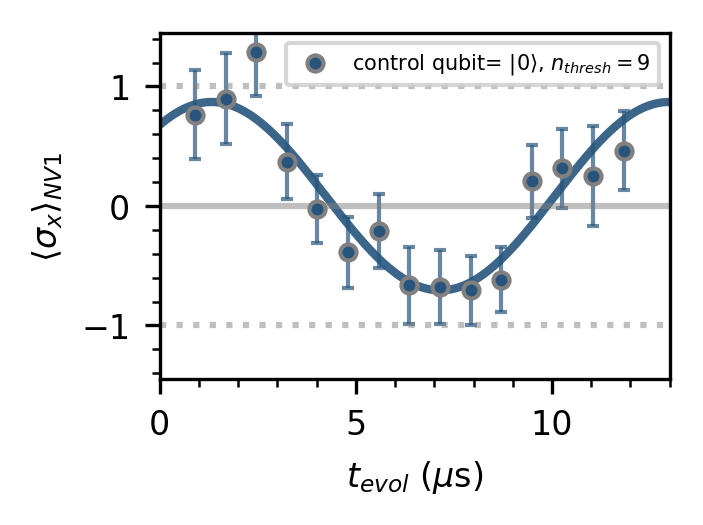

In [496]:

plot_mode = "delta"
offset = 0.
smooth_data = False

x_unit = r"$\mu$s"
#scale_fac_x = -2*16*1e6
#scale_fac_y = 0.5*1/0.08*7.62/15.7

scale_fac_x = -1*8*1e6
#scale_fac_x = 1
# if normed on first datapoint, make sure that full contrast axis= [-0.5, 0.5] 
scale_fac_y = 1   #1 #0.5*1/ampl_delta_deer * contr_z1_deer/contr_z1_rabi 

try:

    labels = [r'control qubit= $| 0 \rangle$, $n_{thresh}=$'+f"{n_threshs[idx_nthresh]}",
              r'control qubit= $|1 \rangle$']
    for idx, mes in enumerate(p_datas):
        mes['plot_options'] = {'label': labels[idx]}

    plt.figure(figsize=(0.9*3, 0.9*2/3*3.5))   
    plot_multiple_1d(p_datas, n_datas=0.1, plot_err=True,  # use n_datas to manipulse color cycle
                     scale_fac_x=scale_fac_x, scale_fac_y=scale_fac_y,
                     color=plt_settings.color('blue'))   

    #tau_cnot = 2*scale_fac_x*-272e-9
    #tau_cnot = -1/f_deer/(2*8)/4
    #tau_cnot = -272e-9

    #plt.axvline(2*scale_fac_x*tau_cnot, label=r'2 $t_{CPhase}$ ' + f'= {2*scale_fac_x*tau_cnot:.2f} {x_unit}',
    #            color=plt_settings.color('red'), linestyle=":")
    plt.axhline(0, color='grey', alpha=0.5)
    plt.axhline(1, color='grey', alpha=0.5, linestyle=":")
    plt.axhline(-1, color='grey', alpha=0.5, linestyle=":")
    
    
    plt.legend(loc='upper right', prop={'size': 5}, ncol=1)
    #plt.legend(prop={'size': 11})
    plt.ylim([-1.45, 1.45])
    #plt.xlim([-2e-6,0])
    plt.xlim([0,13])
    
    #plt.grid()
    plt.ylabel(r'$\langle \sigma_x \rangle_{NV1}$')

    plt_settings.savefig('deer_sig_x_pcs.png')
    plt.show()

except:
    logger.exception("")
0

## Post selected nrep cphase

In [495]:
# load listfiles (mind same order as pulsed results below!)
paths = [common_params['data_path'] + r"\2023\10\20231028\nrep_cphase_group=2_3",
         common_params['data_path'] + r"\2023\10\20231027\nrep_cphase_group=3_2",
         common_params['data_path'] + r"\2023\11\20231113\nrep_cphase_group=1_4"]

#paths = [r"E:\Data\2024\01\20240102\nrep_cphase_pcs_group=2_2",
#         r"E:\Data\2024\01\20240102\nrep_cphase_pcs_group=3_1",
#        ]


n_threshs= list(range(0,12))
n_threshs= [0,5,6,7,8,9,10,11]

# can get the extraction params from _pulsed_measurement.dat
t_analyze_green = 280e-9

#t_cinit_red = [0.14e-3, 18.9e-3]
#t_analyse = [19.02435e-3, 19.02435e-3 + t_analyze_green] # nrep 
#t_norm = [t_analyse[0]+1.5e-6, t_analyse[1]+2.5e-6]

t_cinit_red = [0.21e-3, 18.9e-3]

#t_analyse = [18.9758e-3, 18.9758e-3+t_analyze_green] # deer_dd
t_analyse = [19.10133e-3, 19.10133e-3+t_analyze_green] # nrep_cphase
t_norm = [t_analyse[0]+2e-6, t_analyse[1]+2.5e-6]

# oil obj
#t_cinit_red = [0.21e-3, 4.5e-3]

#t_analyse = [0.00470134, 0.00470134 + t_analyze_green]
#t_norm = [t_analyse[0]+2e-6, t_analyse[1]+2.5e-6]



#taus = np.asarray([0, 2, 4, 6, 10])
taus = np.arange(0,32,2)


datas_raw = []

for path in paths:
    try:
        copy_to_path(path)
        #data_raw = load_listfile_data(inpath=path, incl_subdir=True, slice_files=slice(0,3,1))
        data_raw = load_listfile_data(inpath=path, incl_subdir=True)   # slice for faster, fewer data
        datas_raw.append(cp.deepcopy(data_raw))
    except:
        logger.exception("")
    
[len(d) for d in datas_raw], taus, f"n_tresh= {n_threshs}"

([99, 141, 46], array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]), 'n_tresh= [0, 5, 6, 7, 8, 9, 10, 11]')

In [487]:
[len(d) for d in datas_raw], taus, f"n_tresh= {n_threshs}"

([], array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]), 'n_tresh= [0, 5, 6, 7, 8, 9, 10, 11]')

In [2144]:
#n_threshs = [0,9,10,11]
#n_threshs= list(range(8,12))
#n_threshs= [0,5,6,7,8,9,10,11]
raise

n_threshs= list(range(0,12))
n_threshs= [0,5,6,7,8,9,10,11]

# can get the extraction params from _pulsed_measurement.dat
t_analyze_green = 280e-9

#t_cinit_red = [0.14e-3, 18.9e-3]
#t_analyse = [19.02435e-3, 19.02435e-3 + t_analyze_green] # nrep 
#t_norm = [t_analyse[0]+1.5e-6, t_analyse[1]+2.5e-6]

t_cinit_red = [0.21e-3, 18.9e-3]

#t_analyse = [18.9758e-3, 18.9758e-3+t_analyze_green] # deer_dd
t_analyse = [19.10133e-3, 19.10133e-3+t_analyze_green] # nrep_cphase
t_norm = [t_analyse[0]+2e-6, t_analyse[1]+2.5e-6]


n_threshs, t_cinit_red, t_analyse, t_norm

([0, 5, 6, 7, 8, 9, 10, 11], [0.00021, 0.0189], [0.01910133, 0.019101609999999998], [0.019103329999999998, 0.019104109999999997])

In [499]:
#t_cinit_red = [0.21e-3, 18.9e-3]   # here for testing only


# perform post selection (slow!)
p_mess_per_folder = []

chunk_acc_filters = [None, 
                    [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 26, 27, 28, 29, 30, 31, 34, 35, 36, 37, 38, 39, 40, 41, 43, 45, 46, 47, 49, 50, 51, 52, 53, 54, 57],
                    None]

#chunk_acc_filters = [None, 
#                    None,
#                    None]

try:
    for idx, data in enumerate(datas_raw):
        p_mess = [] 
        file = data[0]['file']
        
        data_filtered = [d for idx,d in enumerate(data) if True]
        if chunk_acc_filters[idx] is not None:
            data_filtered = [d for jdx,d in enumerate(data) if jdx in chunk_acc_filters[idx]]
               
        p_mess = extract_pmes_pcs(data_filtered, n_threshs, 
                         t_orange=t_cinit_red, t_read=t_analyse, t_norm=t_norm, taus=taus)

        p_mess_per_folder.append({'file': file, 'p_mess': p_mess})

except:
    logger.exception("")
len(p_mess)

8

In [507]:
len(datas_raw), len(p_mess), t_cinit_red

(3, 8, [0.00021, 0.0189])

In [511]:
# load pulsed result files that correspond to the listfiles laded above

fname_group_2 = common_params['data_path'] + r"\2023\10\20231028\nrep_cphase_group=2_3\nrep_cphase_group=2_continued_4"  + "\\" \
            + r"20231103-1409-02_rand_benchmark_pulsed_measurement.dat"
fname_group_3 = common_params['data_path'] + r"\2023\10\20231027\nrep_cphase_group=3_2" + "\\" \
            + r"20231028-1925-27_rand_benchmark_pulsed_measurement.dat"
fname_group_1 = common_params['data_path'] + r"\2023\11\20231113\nrep_cphase_group=1_4" + "\\" \
            + r"20231115-1427-02_rand_benchmark_pulsed_measurement.dat"
    
    

    
paths_pulsed = [fname_group_2, fname_group_3, fname_group_1]
#paths_pulsed = [fname_group_2, fname_group_3]
#paths_pulsed = [fname_group_3]


p_datas = []
for fname in paths_pulsed:

    fname = os.path.normpath(fname)
    p_data = Tk_file.load_pulsed_result(fname)
    
    p_datas.append(cp.deepcopy(p_data))
    
len(p_datas)

3

In [515]:
len(p_mess_per_folder)

3

In [519]:
# take meta data from 'normal' pulsed result
# get data from post selected list files

idx_nthresh = [9,8,5]
idx_nthresh = [5,4,3]
#idx_nthresh = [0,0]#,5]


try:
    for idx, p in enumerate(p_mess_per_folder):
        p_mess_i = p['p_mess']

        p_inject = cp.deepcopy(p_mess_i[idx_nthresh[idx]])
        
        try:
            p_inject['data'].pop('delta_norm', None)
        except:
            pass
        p_inject['data']['std1'] = p_inject['data']['dz1']
        p_inject['data']['std2'] = p_inject['data']['dz2']

        p_inject['data'] = pd.DataFrame(p_inject['data'])
        
        rotations = p_datas[idx]['exp_params']['rotations']
        #rotations = '<TomoRotations.ux90_on_1: 1>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.ux90_on_1: 1>; <TomoRotations.ux90_on_1: 1>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.ux90min_on_1: 7>; <TomoRotations.ux90_on_1: 1>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.ux90_on_1: 1>; <TomoRotations.ux90_on_1: 1>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.c2phase1_dd: 23>, <TomoRotations.ux90_on_1: 1>'
        #rotations = [[TomoRotations.none],[ TomoRotations.ux90_on_1, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.ux90_on_1],[ TomoRotations.ux90_on_1, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.ux90min_on_1],[ TomoRotations.ux90_on_1, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.ux90_on_1],[ TomoRotations.ux90_on_1, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.ux90min_on_1],[ TomoRotations.ux90_on_1, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.ux90_on_1],[ TomoRotations.ux90_on_1, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.ux90min_on_1],[ TomoRotations.ux90_on_1, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.ux90_on_1],[ TomoRotations.ux90_on_1, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.ux90min_on_1],[ TomoRotations.ux90_on_1, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.ux90_on_1],[ TomoRotations.ux90_on_1, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.ux90min_on_1],[ TomoRotations.ux90_on_1, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.ux90_on_1],[ TomoRotations.ux90_on_1, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.ux90min_on_1],[ TomoRotations.ux90_on_1, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.ux90_on_1],[ TomoRotations.ux90_on_1, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.ux90min_on_1],[ TomoRotations.ux90_on_1, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.c2phase1_dd, TomoRotations.ux90_on_1]]

        p_inject['exp_params'] = {'rotations': rotations}


        p.update({'data_pcs_inject': p_inject})
        
    # inject into every p_data
    for idx, p in enumerate(p_datas):
        p_inject = p_mess_per_folder[idx]['data_pcs_inject']
        p_datas[idx]['data'] = p_inject['data']
        p_datas[idx]['exp_params']['rotations'] = p_inject['exp_params']['rotations']

except:
    logger.exception("")

f"n_thresh= {[n_threshs[idx] for idx in idx_nthresh]}"

'n_thresh= [9, 8, 7]'

In [655]:
len(p_datas)
#p_datas[2]['exp_params']['rotations']

3

[200.8, 12.55, 20.11]

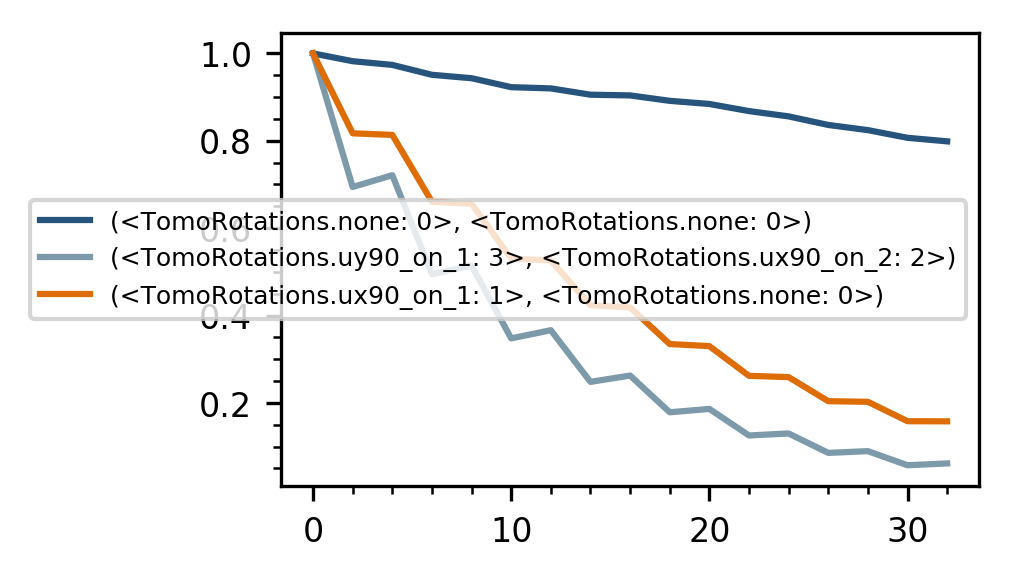

In [539]:
# Simulation data Genko
# charge F is given per NV. F(NV-)= 91 % in sim => F(NV-,NV-)= 83% 

# Simulation data genko
# todo: exp data is normalized on joint contrast datapoint. Good idea?

fname = common_params['data_path'] + r"\2023\11\20231115\SimulationGenko\20231220_sim_charge_alternating_100G"  + "\\" \
     + r"fluorescence_100_G_NV1_Sin1_XY8y_o_32_t_0.8_a_1_NV2_Sin1_XY8y_o_32_t_0.8_a_1_MW1_Sin1_XY8y_none_t_0.8_a_none_o_32_charge_nv=0.91_1.m"
#    + r"fluorescence_100_G_NV1_Sin1_XY8y_o_32_t_0.8_a_1_NV2_Sin1_XY8y_o_32_t_0.8_a_1_MW1_Sin1_XY8y_none_t_0.8_a_none_o_32_charge_1.m"

        
n_inits = 36
slice_groups = [(0,1), (20,21), (4, 5)]
slice_groups = [(0,1), (17,18),  (-6, -5)]


new_range = [-1, 1]
original_range = [-1, 1]
tau_n_decay = [200.8, 12.55, 20.11]   # from epg extraction below
#tau_n_decay = [0.8*tau for tau in tau_n_decay] 
#tau_n_decay = [np.inf, np.inf, np.inf] 

copy_to_path(fname)
data_sim = load_mathematica(fname)

interp_func = scipy.interpolate.interp1d(original_range, new_range, kind='linear', fill_value='extrapolate')
interp_func = lambda x: np.asarray(x) #2*np.asarray(x)-1

col_keys = list(range(0, 36))
#data_sim = pd.DataFrame(np.asarray(data_sim), columns=col_keys)
#data_sim = pd.DataFrame(data_sim)


#np.asarray(data_sim).shape
cols = []
xs = []
for idx_state in range(0, n_inits):
    cols.append(np.asarray(data_sim)[idx_state,:,1])
    xs.append(np.asarray(data_sim)[idx_state,:,0])

all_same_x = all([np.array_equal(a, b) for a,b in zip(xs, xs[1:])])
if not all_same_x:
    raise ValueError

x_sim = xs[0]

#y_decay = np.vstack([np.exp(-x_sim/150)]*n_inits).T
ys_sim = [pd.DataFrame(np.asarray(cols).T).iloc[:, slice_groups[0][0]:slice_groups[0][1]],
          pd.DataFrame(np.asarray(cols).T).iloc[:, slice_groups[1][0]:slice_groups[1][1]],
          pd.DataFrame(np.asarray(cols).T).iloc[:, slice_groups[2][0]:slice_groups[2][1]]]
         
y_dummy = np.ones(ys_sim[0].shape).flatten()

ys_sim = [interp_func(y) for y in ys_sim]
#ys_sim = [np.asarray(y) for y in ys_sim]
ys_sim = [y.flatten()*np.exp(-x_sim/tau_n_decay[idx]) for idx, y in enumerate(ys_sim)]
#ys_sim = [y_dummy*np.exp(-x_sim/tau_n_decay[idx]) for idx, y in enumerate(ys_sim)]



plt.figure(figsize=(3,2))

plt.plot(x_sim, ys_sim[0], color=plt_settings.color('blue'), label=f"{inits[slice_groups[0][0]]}")
plt.plot(x_sim, ys_sim[1], color=plt_settings.color('bluelight'), label=f"{inits[slice_groups[1][0]]}")
plt.plot(x_sim, ys_sim[2], color=plt_settings.color('orange'), label=f"{inits[slice_groups[2][0]]}")

plt.legend()
plt.show()

tau_n_decay

[0.000476, 0.000454]

dict_keys(['data', 'file', 'date', 'poi', 'file_params', 'exp_params', 'fit_settings'])

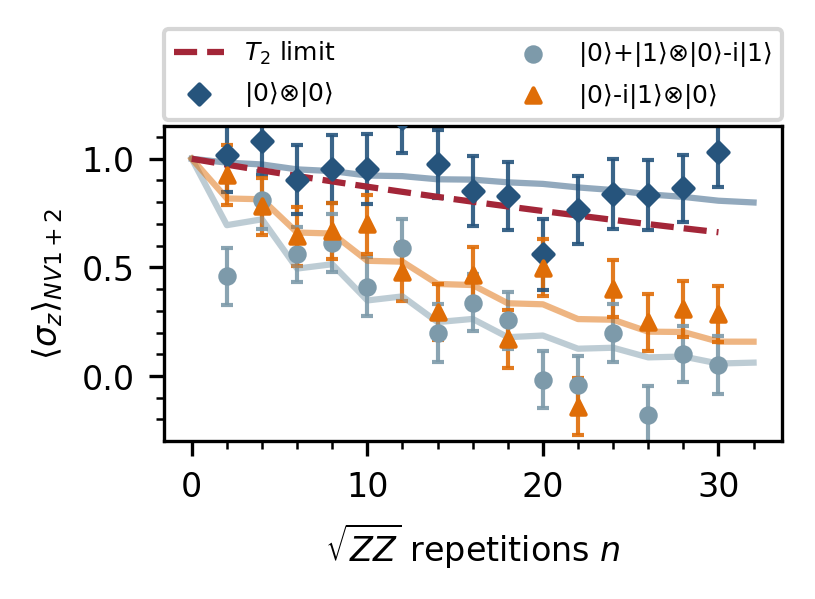

In [535]:
try:
    p_data = None
    p_data = combine_mes(p_datas[::-1], join_rots=True, drop_added_idxs=[idx_zref])
   
    
    # OLD, load and inject before this code
    #fname = os.path.normpath(fname)
    #p_data = Tk_file.load_pulsed_result(fname)
    
    # inject pcs data into pulsed result
    #p_data['data'] = p_inject['data']
    #p_data['exp_params']['rotations'] = p_inject['exp_params']['rotations']
    
    plt.figure(figsize=(3,3.5*3/5))

    split_before = TomoRotations.c2phase1_dd
    fit_on = 'delta'
    calc_mean_datapoint = False
    plot_errbar = True
    z_ref = None
    idx_zref = 0
    t2_limit = None 
    t2_limit = np.mean(common_params['t2_xy8'])

    #plot_bench_data(p_data, annotate_vals=['EPC'], split_before=split_before, split_idx_start=0, lineplot=True,
    #        idx_plot=[0,1], plot_err=True)

    p_data = plot_bench_data(p_data,  split_before=split_before, split_idx_start=0,
                #annotate_vals=['EPC', 'Lifetime','Offset'],
                annotate_vals=[''],
                mask_idxs=[0],
                #idx_plot=[0,1,2],
                perform_fit=False,
                lineplot=False, plot_err=plot_errbar,
                z_ref=z_ref, idx_zref=idx_zref)
    
    for idx, y_sim in enumerate(ys_sim):
        plt.plot(x_sim, y_sim, label="_no_legend", # label=f"tau_n= {tau_n_decay[idx]}", 
                 marker="", color=plt_settings.get_cmap(False)(idx/3), alpha=0.5)
    

    if t2_limit is not None:
        ampl_exp =  1 #1.04 #p_data['fit_res']['Amplitude']['value']
        #plot_rb_t2_limit(epc_t2_limit, x=p_data['data']['tau'].append(pd.Series([0])),
        #                 y0=y_baseline, ampl=ampl_exp)
        plot_nrep_t2_limit(t2_limit, x=p_data['data']['tau'].append(pd.Series([0])),
                         y0=0, ampl=ampl_exp)

    #plt.legend(prop={'size': 12}, bbox_to_anchor=(-0.25,1.0))
    plt.legend(ncol=2, loc='lower left',
               bbox_to_anchor=(0., 1.02, 1., .102),
               mode="expand", borderaxespad=0.,
              )
    plt.xlabel(r"$\sqrt{ZZ}$ repetitions $n$")
    plt.ylabel(r'$\langle \sigma_z \rangle_{NV1+2}$')
    plt.ylim([-0.3, 1.15])

    plt_settings.savefig('nrep_cphase_pcs_1.png', frame_top_inch=0.5)
    plt.show()

except:
    logger.exception("")

"""
plt.rcParams.update(default_params)
"""
p_data.keys()

### pEPG per init

ATTENTION: Need to manually fix exp_decay=0, Lifetime [10, inf]!

In [943]:
n_tau_per_init, n_inits

(15, 3)

In [1147]:
rots = debug_ps[1]['exp_params']['rotations']

[i for i in extract_init_from_rots(rots[0], split_before=split_before)]
#rots[0]

[<TomoRotations.uy90_on_1: 3>, <TomoRotations.ux90_on_2: 2>]

In [1079]:
p_i['exp_params']['rotations'][0]
rotation_list = p_data['exp_params']['rotations']
#[r for r in debug_ps[2]['exp_params']['rotations']]

idx = 2
idx_start = 1

p = cp.deepcopy(p_data)
p['data'] = p['data'].drop(mask_idxs)


x_ticks = p_data['data']['tau'][idx_start:]
n_inits = int(len(x_ticks)/len(unique_tol(x_ticks, atol=0.4)))
n_tau_per_init = int(len(x_ticks)/n_inits)
    


idx_start = 1+n_tau_per_init*idx if idx!= 0 else 0
#rotation_list[idx_start : idx_start+n_tau_per_init]
#rotation_list#[n_tau_per_init*idx:n_tau_per_init*idx+n_tau_per_init]
#rotation_list[31:45]

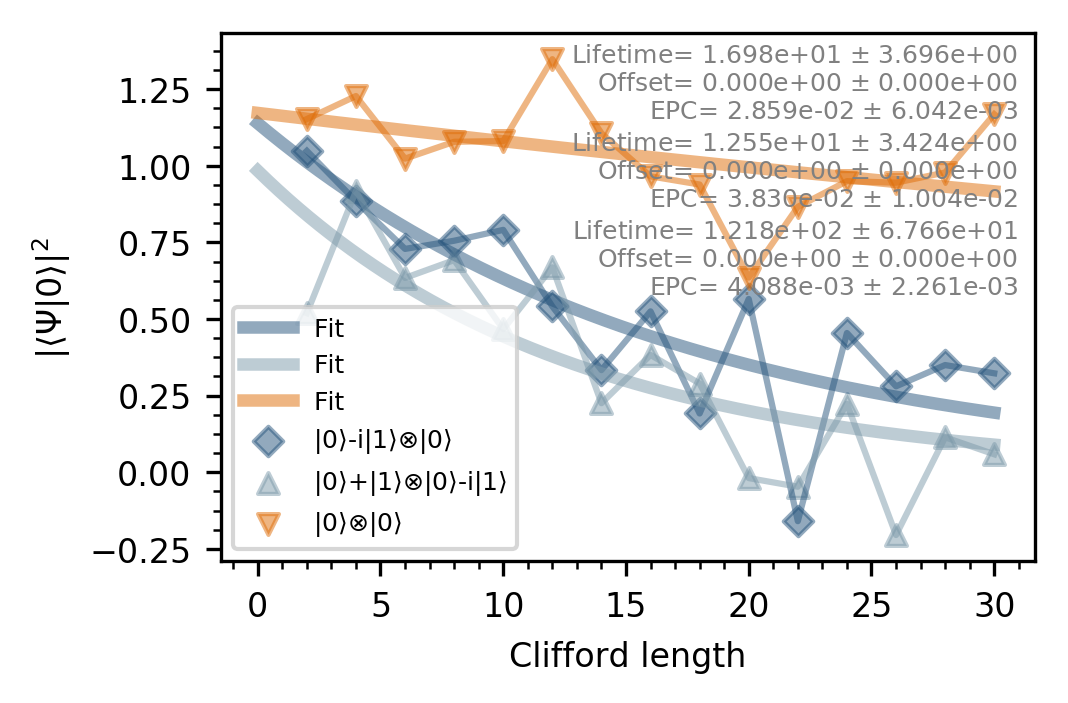

In [1531]:

n_inits = 3
fit_val = 'Lifetime'  # 'EPC'
fit_val = 'EPC'
fit_val = 'pEPG'
fit_on = 'delta'

idx_zref = 0
debug_ps = []

res = {'epc': [], 'depc': [], 'n_mod':[], 'x': [], 'x_npi90': [], 'lifetime': [],
       'init_state':[], 'init_state_str': []}
try:
    
    
    for n_mod in [None]:  #[None, 0, 2]:
        for i in range(n_inits):
            
            if n_mod is not None:
                p_data['data'] = p_data['data'].where(((n_mod + np.round(p_data['data']['tau']))%4==0) | (np.round(p_data['data']['tau'])==0))
                p_data['data'] = p_data['data'].dropna()
            
            p_data = combine_mes(p_datas, join_rots=True, drop_added_idxs=[idx_zref])  # join freshly, in case manipulated in plot_bench_data()
            p_i = plot_bench_data(p_data,  split_before=split_before,                                   
                                  split_idx_start=0, mask_idxs=[0],
                                  #split_idx_start=1, 
                                  annotate_vals=['EPC', 'Offset', 'Lifetime'],
                                  idx_plot=slice(i,i+1),  z_ref=z_ref, idx_zref=idx_zref,
                                  lineplot=True, idx_datas=i, n_datas=n_inits)
            debug_ps.append(p_i)
            
            res['epc'].append(p_i['fit_res'][fit_val]['value'])
            res['depc'].append(p_i['fit_res'][fit_val]['error'])
            res['lifetime'].append(p_i['fit_res']['Lifetime']['value'])
       
    
            # TODO: for n_mod!=None, extract_init will fail!
            # count n(pi90) pulses
            init = [i for i in extract_init_from_rots(p_i['exp_params']['rotations'][0], split_before=split_before)]
            pi90_inits = [TomoRotations.ux90_on_1, TomoRotations.uy90_on_1, TomoRotations.ux90_on_2, TomoRotations.uy90_on_2]
            x = np.sum([init.count(i) for i in pi90_inits])
            res['x_npi90'].append(x)
            
            # init_state label
            vec0, vec1, idx = init_2_state(init)
            state_str = qubits_2_str(vec0, vec1)
            
            res['n_mod'].append(n_mod)
            res['x'].append(i)
            res['init_state_str'].append(state_str)
            res['init_state'].append(init)

    res = pd.DataFrame(res)

except:
    logger.exception("")

# control order of plotted input states
res['x'] = [2,1,0]


plt.show()

In [1535]:
# lifetimes of examplary init states in plot
idx_plot = [0, 1, 2]

res[['x', 'init_state', 'lifetime']].iloc[idx_plot]

#res[['lifetime','init_state']]

   x                                         init_state    lifetime
0  2                          [TomoRotations.ux90_on_1]   16.980780
1  1  [TomoRotations.uy90_on_1, TomoRotations.ux90_o...   12.548472
2  0                                                 []  121.822805

In [1539]:
[epc for epc in res_0['epc']]

[0.057189628902422074, 0.0765983422998947, 0.008175044674967102]

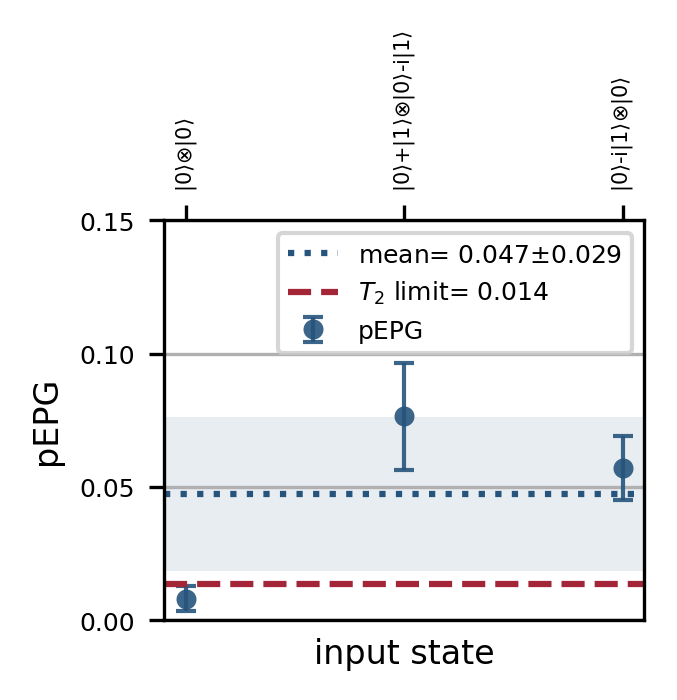

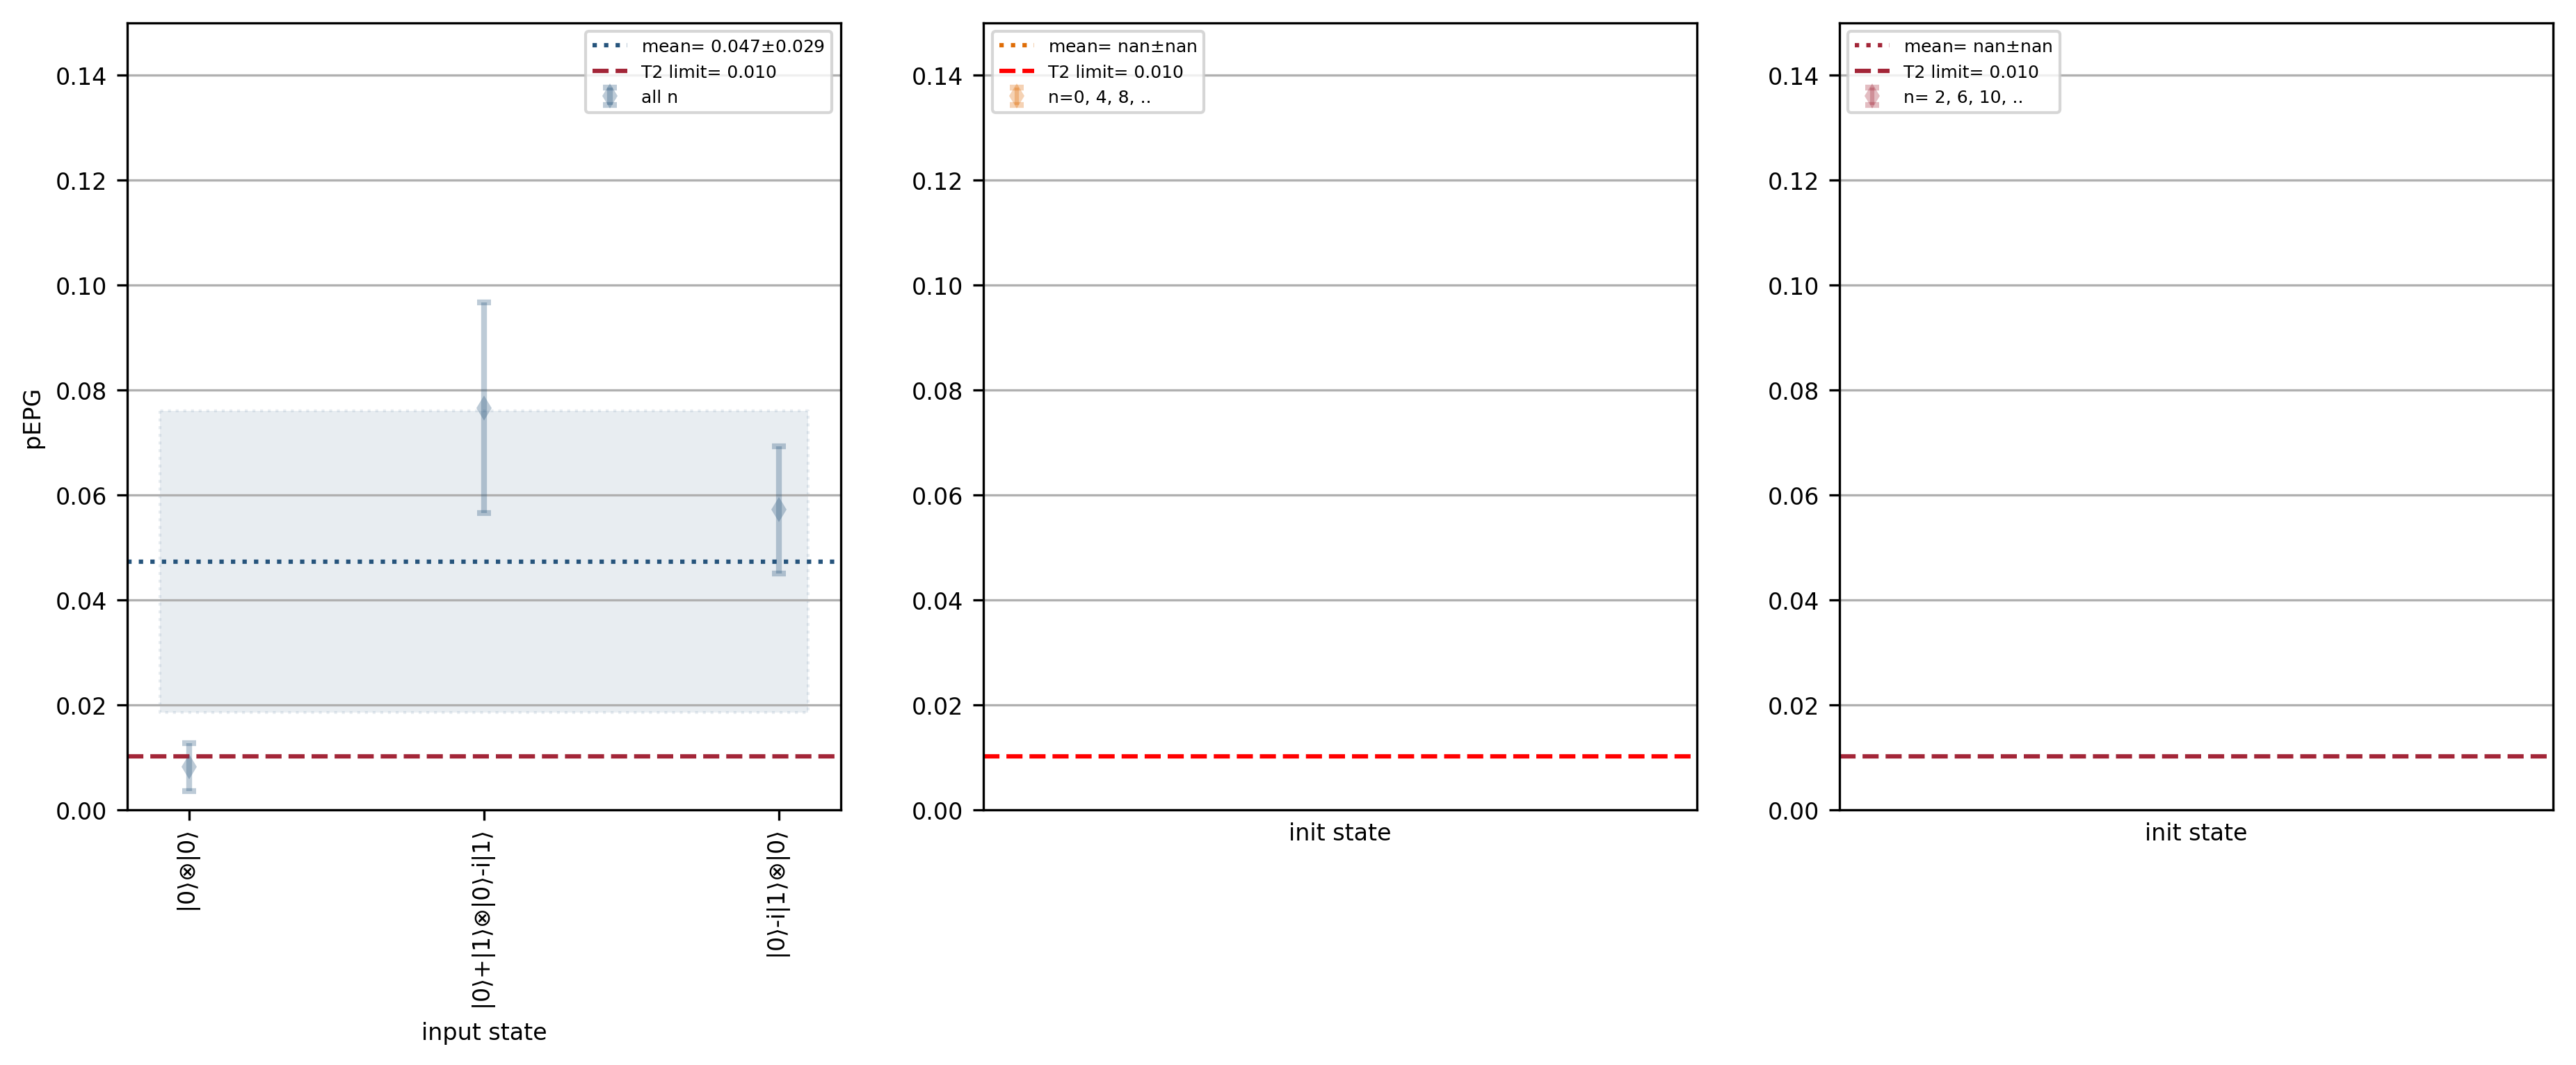

In [1543]:
# todo: check wheter can use x axis from res_0 for all plots
# all n


#ylim = [0,125]
ylim = [0,0.15]
#ylim = None
xlim =  [0-0.1, n_inits-1+0.1]

#xlim = range(0,n_inits)
#xlim = range(12,20)
t2_limit = None
t2_limit = np.mean(common_params['t2_xy8'])


# Todo: might break due to grid for lifetime (not EPC)


try:

    res_0 = res[res['n_mod'].isna()]
    res_1 = res.where(res['n_mod'] == 0.)
    res_1 = res_1.dropna()
    res_2 = res.where(res['n_mod'] == 2.)
    res_2 = res_2.dropna()
    
    plt.figure(figsize=(2.4,3.5*2/3))
    
    
    plt.errorbar(res_0['x'], res_0['epc'], yerr=res_0['depc'],
                 capthick=1, linewidth=1,
                 linestyle="", color=plt_settings.color('blue'), label="pEPG",
                 markersize=plt_settings.get_markersize('big'),
                 marker="o", #marker="D",
                 alpha=0.9)
    mean_weights = [4,8,8]
    mean_epg = np.mean([epc for epc in res_0['epc']])
    std_epg = None 
    std_epg = np.std(res_0['epc'])

    plt.axhline(mean_epg, color=plt_settings.color('blue'), linestyle=":",
                label=f'mean= {mean_epg:.3f}'+r'$\pm$'+f'{std_epg:.3f}')
                #label=f'mean= {mean_epg:.3f}')
    if t2_limit is not None:
        #epg_limit = calc_t2_to_epg(t2_limit, n_qubits=2)[0]
        epg_limit = calc_t2_to_pepg(t2_limit)
        plt.axhline(epg_limit,
                    color=plt_settings.color('red'), linestyle="dashed", label=r"$T_2$"+f" limit= {epg_limit:.3f}")
    if std_epg != None:
        plt.fill_between(xlim, np.mean(res_0['epc'])-std_epg, np.mean(res_0['epc'])+std_epg,
                         color=plt_settings.color('blue'),  alpha=0.1, linewidth=0) #linestyle=":"

    plt.xlabel("input state")
    plt.ylabel("pEPG")
    plt.yticks(fontsize=6)
    #plt.ylabel(f"{fit_val}")

    if ylim is not None:
        plt.ylim(ylim)
    if xlim is not None:
        plt.xlim(xlim)
        
    plt.legend(loc="upper right")
    plt.xticks(res_0['x'], res_0['init_state_str'], fontsize=5, rotation='vertical')
    ax = plt.gca()
    ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    ax.xaxis.set_minor_locator(plt.NullLocator())
    ax.yaxis.set_minor_locator(plt.MultipleLocator(base=50))
    ax.yaxis.set_major_locator(plt.MultipleLocator(base=0.05))
    plt.grid(which='both', axis='y')
    
    plt_settings.savefig('nrep_epg_vs_init_pcs', frame_left_inch=0.6, frame_bottom_inch=0.3,
                         frame_top_inch=0.7, frame_right_inch=0.2)
    
    
    
    # Supplement: mod(4) with subplots
    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.errorbar(res_0['x'], res_0['epc'], yerr=res_0['depc'], 
                 capthick=2, linewidth=2,
                 linestyle="", color=plt_settings.color('blue'), label="all n", marker="d", alpha=0.3)
    mean_epg = np.mean(res_0['epc'])
    std_epg = np.std(res_0['epc'])

    plt.axhline(mean_epg, color=plt_settings.color('blue'), linestyle=":", label=f'mean= {mean_epg:.3f}'+r'$\pm$'+f'{std_epg:.3f}')
    if t2_limit is not None:
        epg_limit = calc_t2_to_epg(t2_limit, n_qubits=2)[0]
        plt.axhline(epg_limit,
                    color=plt_settings.color('red'), linestyle="dashed", label=f"T2 limit= {epg_limit:.3f}")
    plt.fill_between(xlim, np.mean(res_0['epc'])-np.std(res_0['epc']), np.mean(res_0['epc'])+np.std(res_0['epc']),
                     color=plt_settings.color('blue'), linestyle=":", alpha=0.1)

    plt.xlabel("input state")
    plt.ylabel("pEPG")
    plt.ylabel(f"{fit_val}")

    if ylim is not None:
        plt.ylim(ylim)
    plt.legend(loc="upper right")
    plt.xticks(res_0['x'], res_0['init_state_str'], fontsize=8, rotation='vertical')
    ax = plt.gca()
    ax.xaxis.set_minor_locator(plt.NullLocator())
    ax.yaxis.set_minor_locator(plt.MultipleLocator(base=25))
    plt.grid(which='both', axis='y')



    plt.subplot(132)
    plt.errorbar(res_1['x'], res_1['epc'], yerr=res_1['depc'], linestyle="", capthick=2,
                 color=plt_settings.color('orange'), label="n=0, 4, 8, ..", marker="d",  alpha=0.3)
    mean_epg = np.mean(res_1['epc'])
    std_epg = np.std(res_1['epc'])
    plt.axhline(mean_epg, color=plt_settings.color('orange'), linestyle=":", label=f'mean= {mean_epg:.3f}'+r'$\pm$'+f'{std_epg:.3f}')
    if t2_limit is not None:
        epg_limit = calc_t2_to_epg(t2_limit, n_qubits=2)[0]
        plt.axhline(epg_limit,
                    color='red', linestyle="dashed", label=f"T2 limit= {epg_limit:.3f}")

    plt.fill_between(xlim, np.mean(res_1['epc'])-np.std(res_1['epc']), np.mean(res_1['epc'])+np.std(res_1['epc']),
                     color=plt_settings.color('orange'), linestyle=":", alpha=0.1)

    plt.xlabel("init state")
    plt.xticks(res_2['x'], res_0['init_state_str'], fontsize=8, rotation='vertical')
    ax = plt.gca()
    ax.xaxis.set_minor_locator(plt.NullLocator())
    ax.yaxis.set_minor_locator(plt.MultipleLocator(base=25))
    plt.grid(which='both', axis='y')

    if ylim is not None:
        plt.ylim(ylim)
    plt.legend(loc="upper left")



    plt.subplot(133)
    plt.errorbar(res_2['x'], res_2['epc'], yerr=res_2['depc'], linestyle="", capthick=2,
                 color=plt_settings.color('red'), label="n= 2, 6, 10, ..",  marker="d",  alpha=0.3)
    mean_epg = np.mean(res_2['epc'])
    std_epg = np.std(res_2['epc'])
    plt.axhline(mean_epg, color=plt_settings.color('red'), linestyle=":", label=f'mean= {mean_epg:.3f}'+r'$\pm$'+f'{std_epg:.3f}')
    if t2_limit is not None:
        epg_limit = calc_t2_to_epg(t2_limit, n_qubits=2)[0]
        plt.axhline(epg_limit,
                    color=plt_settings.color('red'), linestyle="dashed", label=f"T2 limit= {epg_limit:.3f}")
    plt.fill_between(xlim, np.mean(res_2['epc'])-np.std(res_2['epc']), np.mean(res_2['epc'])+np.std(res_2['epc']),
                     color=plt_settings.color('red'), linestyle="dashed", alpha=0.1)

    plt.xticks(res_2['x'], res_0['init_state_str'], fontsize=8, rotation='vertical')
    ax = plt.gca()
    ax.xaxis.set_minor_locator(plt.NullLocator())
    ax.yaxis.set_minor_locator(plt.MultipleLocator(base=25))
    plt.grid(which='both', axis='y')

    plt.xlabel("init state")

    if ylim is not None:
        plt.ylim(ylim)
    plt.legend(loc="upper left")

except:
    logger.exception("")
    
#plt.tight_layout()
plt.show()

In [1725]:
# OLD manual plotting for different n_thresh
raise OLD

p_mess = p_mess_per_folder[1]['p_mess']

idx_reference = None
fit_again_meth = None#'decay_exp'
fit_on = None #'delta'

f_deer_expect = 1e6

try:
    scale_tau = 1#-0.7*  2*32*1e6
    scale_y = 1#1/0.2*0.5*14.38/41.9
    
    #taus = abs(taus[::-1])
    ns = len(n_threshs)
    plt.figure(figsize=(12,4*ns))
    
    color = plt.cm.plasma(0)
    
    y0, dy0 = [],[]
    y1, dy1 = [], []
    n_plot_cols = 2 if idx_reference==None else 3
    for idx, n in enumerate(n_threshs):
        p_mes = p_mess[idx]
        
        z1, z2 = scale_y*p_mess[idx]['data']['z1'], scale_y*p_mess[idx]['data']['z2']
        delta = z1 - z2
        dz1, dz2 = scale_y*p_mess[idx]['data']['dz1'], scale_y*p_mess[idx]['data']['dz2']
        ddelta = np.sqrt(dz1**2+dz2**2)
        if idx_reference != None:
            z_normed = (z1-z2)/(z1-z2)[idx_reference]
            p_mess[idx]['data']['delta_norm'] = z_normed 
        
        # another fit here (faster than above)
        if fit_again_meth == 'decay_exp':
            p_mes['fit_edit_params'] = [lmfit.Parameter('offset', value=0, vary=False),
                        lmfit.Parameter('amplitude', value=0.1, min=0, max=1, vary=True),
                        lmfit.Parameter('lifetime', value=1, min=0.2, max=10, vary=True)]
            #p_mes['fit_edit_params'] = None
            fit_settings = {}
            if idx_reference==0:
                fit_settings = {'slice_data': slice(1,None)}
        elif fit_again_meth == 'sine':
            fit_settings = {}
            p_mes['fit_edit_params'] = [lmfit.Parameter('offset', value=0, vary=True),
                            lmfit.Parameter('amplitude', value=0.1, min=10e-3, max=1, vary=True),
                            lmfit.Parameter('frequency', value=f_deer_expect, min=0, max=2*f_deer_expect, vary=False),
                            lmfit.Parameter('beta', value=1, vary=False),
                            lmfit.Parameter('lifetime', value=np.inf, vary=False)]
 
        
        if fit_again_meth != None:
            fit_on = 'delta_norm' if idx_reference==0 else 'delta' 
            do_fit(p_mes, fit_y=fit_on, fit_method=fit_again_meth,
                   edit_params=p_mes['fit_edit_params'], settings=fit_settings)
        
        
        # plot data

        
        # Calculate metric
        x_fit, y_fit = None, None
        if fit_on is not None:
            x_fit, y_fit = p_mes['fit_values']['x'], scale_y*p_mes['fit_values']['y']
        
        
            off_i, doff_i = p_mes['fit_res']['Offset']['value'], p_mes['fit_res']['Offset']['error']
            ampl_i, dampl_i = p_mes['fit_res']['Amplitude']['value'], p_mes['fit_res']['Amplitude']['error']
            doffampl_i = abs(off_i/ampl_i*np.sqrt((doff_i/off_i)**2 + (dampl_i/ampl_i)**2))
            #doffampl_i = 0
            #lifetime_i, dlifetime_i = p_mes['fit_res']['Lifetime']['value'], p_mes['fit_res']['Lifetime']['error']
        
            y0.append(off_i/ampl_i)
            dy0.append(doffampl_i)
            y1.append(ampl_i)
            dy1.append(dampl_i)
        
            #y0.append(ampl_i)
            #dy0.append(dampl_i)
            #y1.append(lifetime_i)
            #dy1.append(dlifetime_i)

            #y0.append(np.sum(z_normed[1::2])-np.sum(z_normed[2::2]))
            #y0.append((z1-z2)[0])
            #dy0.append(0)
            #dy0.append(np.sqrt(2)*ddelta[0])
            #y0.append(np.sum(z_normed[2::2]))
        else:
            y0.append(0)
            dy0.append(0)
            y1.append(0)
            dy1.append(0)
            
            #y0.append(delta[1])
            #dy0.append(ddelta[1])

        n_phots = p_mes['infos']['n_photons']
        n_phots_ref = p_mess[0]['infos']['n_photons']
        plt.subplot(ns,n_plot_cols,(n_plot_cols*idx)+1)

        plt.gca().set_title(f"n_thresh= {n}, phots= {100*n_phots/n_phots_ref:.1f}%")
        plt.plot(scale_tau*taus, z1, marker='o', linestyle=':', color=color, alpha=0.35)
        plt.plot(scale_tau*taus, z2, marker='o', linestyle=':', color='green', alpha=0.35)
        plt.scatter(scale_tau*taus, z1, marker='o', s=15, color=color, alpha=0.9) #line
        plt.scatter(scale_tau*taus, z2, marker='o', s=15, color='green', alpha=0.9) #line
        plt.errorbar(scale_tau*taus, z1, yerr=dz1, linestyle='', color=color, alpha=0.4)
        plt.errorbar(scale_tau*taus, z2, yerr=dz2, linestyle='', color='green', alpha=0.4)
        plt.grid()
        #plt.xlabel(r"$t$ (ns)")
        #plt.xlabel("reps ()")
        plt.xlabel(r"$t_{evol}$ ($\mu$s)")
        #plt.xlabel(r"$\tau$ (ns)")
        
        plt.subplot(ns,n_plot_cols,(n_plot_cols*idx+1)+1)
        if fit_on == 'delta':
            if x_fit is not None:
                plt.plot(scale_tau*x_fit, y_fit,  color='orange', linewidth=3, alpha=0.9)#, label=f'off/ampl= {off_i/ampl_i:.2f} +- {doffampl_i:.2f}')

        
        plt.plot(scale_tau*taus, delta, marker='', linestyle=':', color=color, alpha=0.35) #linestyle=':',
        plt.scatter(scale_tau*taus, delta, marker='o', s=15, color=color, alpha=0.9) #linestyle=':',
        plt.errorbar(scale_tau*taus, delta, yerr=ddelta, marker='', linestyle='', color=color, alpha=0.4)
        
        
        plt.legend()
        plt.grid()
        plt.xlabel(r"$t_{evol}$ ($\mu$s)")
        #plt.xlabel(r"$\tau$ (ns)")
        #plt.xlabel("reps ()")
        #plt.ylabel("z1-z2")
        plt.ylabel(r"$\sigma_y$")
        
        if idx_reference != None:
            plt.subplot(ns,n_plot_cols,(n_plot_cols*idx+1)+2)
            
            #plt.plot(scale_tau*x_fit, y_fit,  color='orange')#, label=f'off/ampl= {off_i/ampl_i:.2f} +- {doffampl_i:.2f}')
            plt.plot(scale_tau*taus, z_normed, marker='o', linestyle=':', color=color, alpha=0.35)
            plt.scatter(scale_tau*taus, z_normed,  marker='o', s=15, color=color, alpha=0.9)
            plt.errorbar(scale_tau*taus, z_normed, yerr=ddelta/(z1-z2)*z_normed, linestyle='', color=color, alpha=0.4)
            if fit_on == 'delta_norm':
                if x_fit is not None:
                    plt.plot(scale_tau*x_fit, y_fit,  color='orange', linewidth=3, alpha=0.9)#, label=f'off/ampl= {off_i/ampl_i:.2f} +- {doffampl_i:.2f}')

            plt.legend()
            plt.grid()
            plt.xlabel("tau (us)")
            plt.xlabel("reps ()")
            plt.ylabel("delta_norm")
    
    plt.tight_layout()
    plt.savefig(plt_settings.get_savepath('deer_pcs_n_tresh.png'), dpi=300)
    plt.show()


except:
    logger.exception("")
        


plt.figure(figsize=(4,5))
plt.subplot(211)
plt.errorbar(n_threshs, y0, dy0, color=color, alpha=0.15)
plt.scatter(n_threshs, y0, color=color, alpha=1)
#plt.ylim([-4,1])
plt.xlabel(r"$n_{thresh}$")
plt.ylabel("offset/amplitude")
#plt.title("Dip depth (sum z[0::2]-z[1::2])")
#plt.title("Contrast (sum z[0::2])")


plt.subplot(212)
plt.errorbar(n_threshs, y1, dy1, color=color, alpha=0.15)
plt.scatter(n_threshs, y1, color=color, alpha=1)
plt.xlabel(r"$n_{thresh}$")
plt.ylabel("amplitude")
#plt.ylim([0,0.2])

plt.tight_layout()
plt.savefig(plt_settings.get_savepath('deer_pcs_ampl_vs_nthresh.png'), dpi=300)
plt.show()

0

0

## laser extraction and analysis windows

In [1527]:
t_cinit_red, t_analyse

([0.00021, 0.0189], [0.01910133, 0.019101609999999998])

In [1719]:
t_analyse = [0.0189473, 0.0189473 + t_analyze_green]
t_norm = [t_analyse[0]+2e-6, t_analyse[1]+2.5e-6]

# oil obj
t_cinit_red = [0.21e-3, 4.5e-3]

t_analyse = [0.00470134, 0.00470134 + t_analyze_green]
t_norm = [t_analyse[0]+2e-6, t_analyse[1]+2.5e-6]


t_cinit_red, t_analyse

([0.00021, 0.0045], [0.00470134, 0.00470162])

In [238]:
data_raw = data_raw_ps_90
#t_cinit_red = [0.05e-3, 18.0e-3]


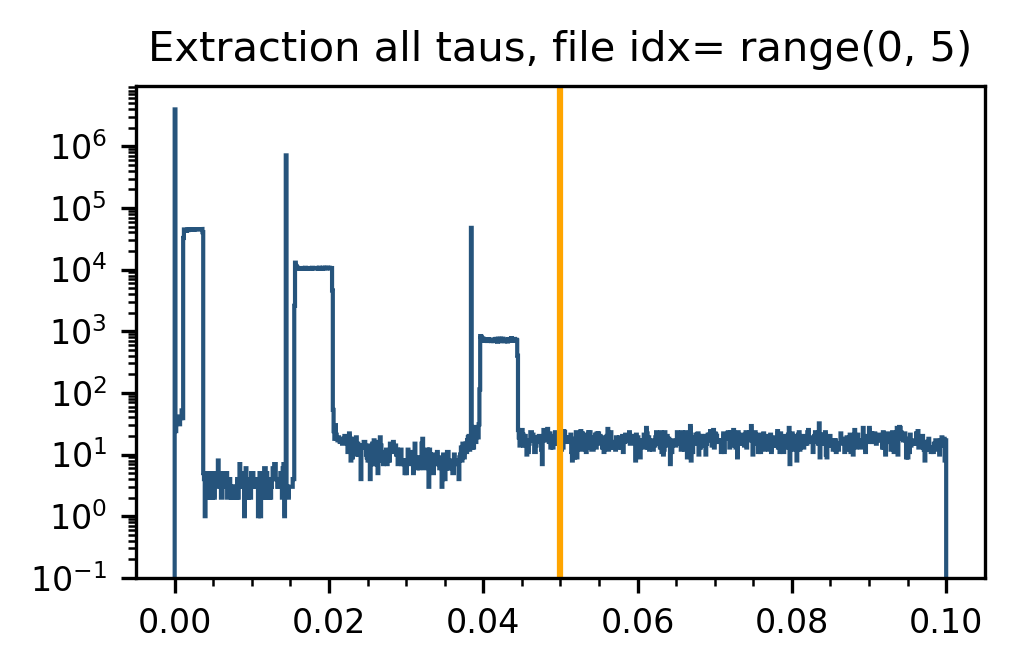

In [253]:
t_bin= 400e-12

def plot_laser_trace(laser_mode='green', t_margin=4e-6):
    # All
    if laser_mode == 'all':
        y, x, _  = plt.hist(1e3*t_arr, bins=1000, log=True, histtype='step', density=False)
    #y, x, _  = plt.hist(1e3*t_arr[(t_arr<20e-3)], bins=1000, log=True, histtype='step', density=False)


    # green readout window
    if laser_mode == 'green':
        y, x, _  = plt.hist(1e3*t_arr[(t_arr>t_analyse[0]-t_margin)*(t_arr<t_analyse[1]+3e-6+t_margin)],
                            bins=1000, log=True, histtype='step', density=False)
    #y, x, _  = plt.hist(1e3*t_arr[(t_arr>t_analyse[0]-1e-3)*(t_arr<25.024e-3)], bins=1000, log=True, histtype='step', density=False)
    #y, x, _  = plt.hist(1e3*t_arr[(t_arr>18.7e-3)*(t_arr<25.367e-3)], bins=1000, log=True, histtype='step', density=False)

    # for checking orange laser windows -> must not overlap with green pulse
    if laser_mode == 'orange_start':
        y, x, _  = plt.hist(1e3*t_arr[(t_arr<2*t_cinit_red[0])],
                            bins=1000, log=True, histtype='step', density=False, color=plt_settings.color('blue'))
    if laser_mode == 'orange_end':
        y, x, _  = plt.hist(1e3*t_arr[(t_arr>t_cinit_red[1]-0.15e-3)*(t_arr<t_cinit_red[1]+0.5e-3)],
                            bins=1000, log=True, histtype='step', density=False)
    # orange laser decay -> ionization
    if laser_mode == 'orange':
        y, x, _  = plt.hist(1e3*t_arr[(t_arr>t_cinit_red[0])*(t_arr<t_cinit_red[1])], bins=1000, log=False, histtype='step', density=False)

    
    #y, x, _  = plt.hist(t_arr[(t_arr<7.3e-3)*(t_arr>0)], bins=1000, log=False, histtype='step', density=False)
    #plt.ylim([1200,1500])
    
    return x, y

def add_extr_windows():
    if np.max(x) > 1e3*t_analyse[0] > np.min(x):
        plt.axvline(1e3*t_analyse[0], color='red')
    if np.min(x) < 1e3*t_analyse[1] < 1.2*np.max(x):
        plt.axvline(1e3*t_analyse[1], color='red')
        
    if np.max(x) > 1e3*t_norm[0] > np.min(x):
        plt.axvline(1e3*t_norm[0], color='green')
    if np.min(x) < 1e3*t_norm[1] < 1.2*np.max(x):
        plt.axvline(1e3*t_norm[1], color='green')
    
    if np.max(x) > 1e3*t_cinit_red[0] > np.min(x):
        plt.axvline(1e3*t_cinit_red[0], color='orange')
    if np.min(x) < 1e3*t_cinit_red[1] < 1.2*np.max(x):
        plt.axvline(1e3*t_cinit_red[1], color='orange')

#t_analyse = [18.9615e-3, 18.9615e-3+300e-9]
#t_analyse = [1.56475e-3, 1.56475e-3+300e-9]
#t_norm = [t_analyse[0]+2e-6, t_analyse[1]+2.5e-6]
#
#t_analyse = [202e-6, 202e-6+750e-9]
#t_norm = [204e-6, 205e-6]

#t_cinit_red = [0.1e-3, 12.9e-3]

idx_tau, n_tresh = 2, 8
idx_file = range(0,len(data_raw))[:5]
show_windows = True

raw_arr = np.zeros(1)
for idx in idx_file:
    raw_arr = np.concatenate([raw_arr, np.asarray(data_raw[idx]['debug_raw_data'], dtype=int)])
    #raw_arr = np.concatenate([raw_arr, np.asarray(data_raw_ps_90[idx]['debug_raw_data'], dtype=int)])
    

# sometimes, artifacts in measurement
#raw_arr = raw_arr[raw_arr!=0]
#raw_arr = raw_arr[raw_arr!=1]
#raw_arr = raw_arr[raw_arr!=256]


"""
t_arrive = post_select(data_raw, t_red=t_cinit_red, t_read=[0, None], # t_read=[t_analyse[0], None],
                t_bin=t_bin, 
                n_thresh=n_tresh)
t_arrive_per_tau = collapse_single_lasers(t_arrive, n_taus=len(taus), alternating=True)
t_arr = np.asarray(t_arrive_per_tau[idx_tau], dtype=float)*t_bin
x, y = plot_laser_trace()
if show_windows:
    add_extr_windows()

plt.title(f"Laser extraction for all files, tau {idx_tau}")
plt.show()
"""

t_arr = np.asarray(raw_arr, dtype=float)*t_bin
t_arr = t_arr[t_arr<30e-3]

x, y = plot_laser_trace('orange_start', 1e-6)
if show_windows:
    add_extr_windows()

#plt.xlim([0,10])
plt.title(f"Extraction all taus, file idx= {idx_file}", fontsize=10)
#plt.yscale('log')
#plt.xscale('log')

plt.tight_layout()
plt.savefig(plt_settings.get_savepath('debug_laser_extract_pcs'), dpi=300)
plt.show()


#x[-2]= 70e-3
qdplotlogic.set_data(x[:-1], y, plot_index=0)

0
        

In [227]:
t_analyse

[0.004547, 0.00454728]

# Histogram orange readout

Use same listfile data as above

In [1832]:
# load listfiles (mind same order as pulsed results below!)
paths = [common_params['data_path'] + r"\2023\11\20231121\cread_1"]

# oil obj
paths = [common_params['data_path'] + r"\2023\12\20231221\cread\calibrate_cread_P=12mW_OD2_circpol_20240110_8']
# file 9.00ms.lst has physical 9.0 ms laser, but misconfigured fastcounter length -> cut to 6.6 ms laser

n_threshs= list(range(0,12))

# can get the extraction params from _pulsed_measurement.dat
t_analyze_green = 280e-9


t_cinit_red = [0.21e-3, 18.9e-3]
t_cinit_red = [0.21e-3, 34.9e-3]
# oil obj
t_cinit_red = [0.21e-3, 9.2e-3]
t_cinit_red = [0.05e-3, 6.65e-3]

t_analyse = [19.10133e-3, 19.10133e-3+t_analyze_green] # nrep_cphase
t_norm = [t_analyse[0]+2e-6, t_analyse[1]+2.5e-6]


#taus = np.asarray([0, 2, 4, 6, 10])
taus = np.arange(0,32,2)



data_raw = load_listfile_data(inpath=paths[0], incl_subdir=False, slice_files=slice(0,5,1))

    
len(data_raw), data_raw[0]['file']

(1, 'E:\\Data\\2023\\12\\20231221\\cread\\calibrate_cread_P=12mW_OD2_circpol_20240110_8\\charge_read_t_read=9.00ms.lst')

'E:\\Data\\2023\\12\\20231221\\cread\\calibrate_cread_P=12mW_OD2_circpol_20240110_8\\charge_read_t_read=9.00ms.lst'

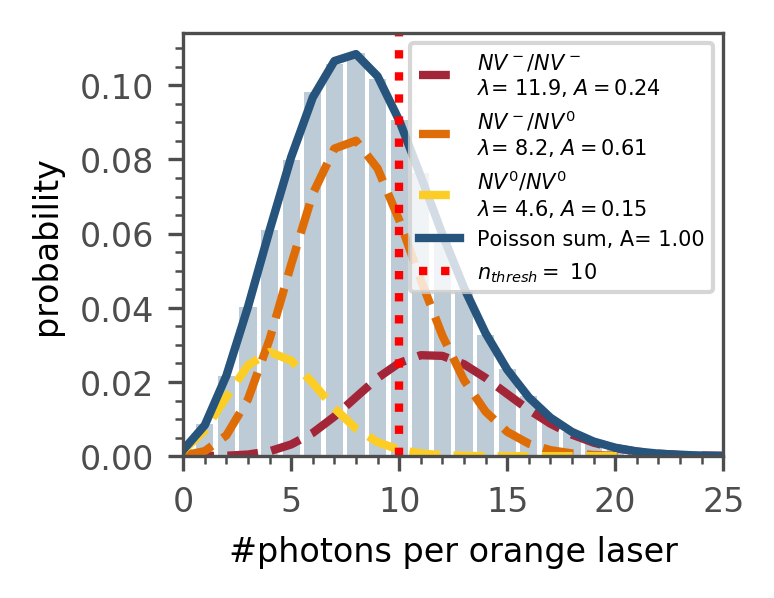

In [1835]:
# use a single listfile result to plot histogram
fix_lambdas = False
idx_data = 0

try:
    
    plt.figure()
    t_arr_red = filter_trace_per_laser(data_raw[idx_data], t_window_1=t_cinit_red[0], t_window_2=t_cinit_red[1],
                                      t_bin=400e-12)

    n_phots_per_laser = [len(t[t!=0]) for t in t_arr_red]
    l_res = {'data': {'type': 'photon_histogram'}}

    y_hist, x_hist = np.histogram(n_phots_per_laser, bins=np.max(n_phots_per_laser), density=True)
    x_hist = x_hist[:-1]


    l_res['data'].update({'tau': x_hist, 'z1': y_hist})


    l_res['fit_edit_params'] = [lmfit.Parameter('p0_mu', value=2, min=0, max=50, vary=not fix_lambdas),
            lmfit.Parameter('p1_mu', value=4, min=0, max=50, vary=not fix_lambdas),
            lmfit.Parameter('p2_mu', value=8, min=0, max=50, vary=not fix_lambdas),
            lmfit.Parameter('p0_amplitude', value=0.3, min=0, max=10, vary=True),
            lmfit.Parameter('p1_amplitude', value=0.3, min=0, max=10, vary=True),
            lmfit.Parameter('p2_amplitude', value=0.3, min=0, max=10, vary=True)]
    do_fit(l_res, fit_y='z1', fit_method='poisson_3x', edit_params=l_res['fit_edit_params'])

    l_res['fit_res']['nv_min_ratio'], ratio_details = calc_nv_min_ratio(l_res, ratio_at_least_1min=False)
    l_res['fit_res']['d_nv_min_ratio'] = ratio_details['d_ratio_nv-']
    l_res['fit_res']['contrast_read'] = ratio_details['lambdas'][0]/ratio_details['lambdas'][-1]
    l_res['fit_res']['d_contrast_read'] = l_res['fit_res']['contrast_read']*np.sqrt((ratio_details['d_lambdas'][0]/ratio_details['lambdas'][0])**2 + (ratio_details['d_lambdas'][-1]/ratio_details['lambdas'][-1])**2)


    plot_photon_histogram(l_res, ratio_at_least_1min=False, 
                          plot_title=False, label_err=False,
                          xlim=[0,25], atol_poisson=0.05)

except:
    logger.exception("")
    
plt_settings.savefig('orange_histogram.png', frame_right_inch=1)
plt.show()

data_raw[idx_data]['file']

In [447]:
ampl0 = l_res['fit_res']['p0_amplitude'].value
ampl1 = l_res['fit_res']['p1_amplitude'].value
ampl2 = l_res['fit_res']['p2_amplitude'].value

nv0_ratio = 0.3

theo0 = nv0_ratio**2
theo2 = (1-nv0_ratio)**2
theo1 = 1 - theo2

f"NV ratios (NV_00/ NV_0-/ NV_--)= {ampl0:.3f}/{ampl1:.3f}/{ampl2:.3f}, theo= {theo0:.3f}/{theo1:.3f}/{theo2:.3f}"

'NV ratios (NV_00/ NV_0-/ NV_--)= 0.166/0.616/0.215, theo= 0.090/0.510/0.490'

In [93]:
t_hist[-1]-t_hist[0]

Traceback (most recent call last):
  File "C:\Users\Setup3-PC\Desktop\qudi\logic\jupyterkernel\qzmqkernel.py", line 679, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-93-de2749336fbb>", line 1, in <module>
    t_hist[-1]-t_hist[0]
NameError: name 't_hist' is not defined


In [99]:

    
n_th = 8
t_pcs_0 = [t_cinit_red[0], t_cinit_red[0] + 18.9e-3]
# oil obj
t_pcs_0 = [t_cinit_red[0], t_cinit_red[0] + 4.5e-3]


t_hist = [t_pcs_0[-1], t_cinit_red[1]]   # must be constant when varying parameters
frac_cinit = t_pcs_0[1]/t_cinit_red[1]

try:
    lambdas, _ = hist_find_lambdas([data_raw[idx_data]], t_hist)


    l_mes = hist_post_selected([data_raw[idx_data]], t_pcs_0, t_hist, lambdas=lambdas, n_thresh=n_th)

except:
    logger.exception("")
    
#lambdas
frac_cinit, l_mes['fit_res']['nv_min_ratio']


(0.7136363636363636, 0.6570271517027234)

In [1286]:
t_pcs_0 = [t_cinit_red[0], t_cinit_red[0] + 4.0e-3]

t_hist[0]/t_cinit_red[1]

0.46777777777777785

In [343]:
t_cinit_red
l_mes['fit_res']['p0_amplitude'].value

0.5434579410414669

We first need to fix a readout window for the created histogram. This must be long enough to have stable fits, but shouldn't show any ionization yet.
The parameter t_hist_lenght seems to influence the charge state fidelity after pcs quite a bit, which is not so good.
The reason could be that the fits are not stable enough.

Note that the readout window t_hist can be different for the first plot, where only t_hist is varied and below with PCS.



In [861]:
# ignore t_pcs (no threshold), vary t_hist for 


try:
    ts = np.linspace(1e-3, t_cinit_red[1]-t_cinit_red[0], 25)

    xs, ys, lambdas = [], [], []

    for t in ts:
        # whole laser pulse
        t_hist_i = [t_cinit_red[0], t_cinit_red[0]+t]   
        # starting roughly from middle, t_hist window later used with pcs
        t_hist = np.asarray([t_cinit_red[1]-t, t_cinit_red[1]])   # must be constant when varying parameters

        x = t_hist_i[1] - t_hist_i[0]
           
        l, l_mes = hist_find_lambdas([data_raw[idx_data]], t_hist_i)   # readout stays the same -> lambdas constant
    

        y = [l_mes['fit_res']['p0_amplitude'].value,
             l_mes['fit_res']['p1_amplitude'].value,
             l_mes['fit_res']['p2_amplitude'].value]
        ls = [l['p0_mu'].value,
              l['p1_mu'].value,
              l['p2_mu'].value]
        
        lambdas.append(ls)
        xs.append(x)
        ys.append(np.asarray(y))

        
    xs = np.asarray(xs)

except:
    logger.exception("")
0

0

'Readout windows starting at: 5e-05'

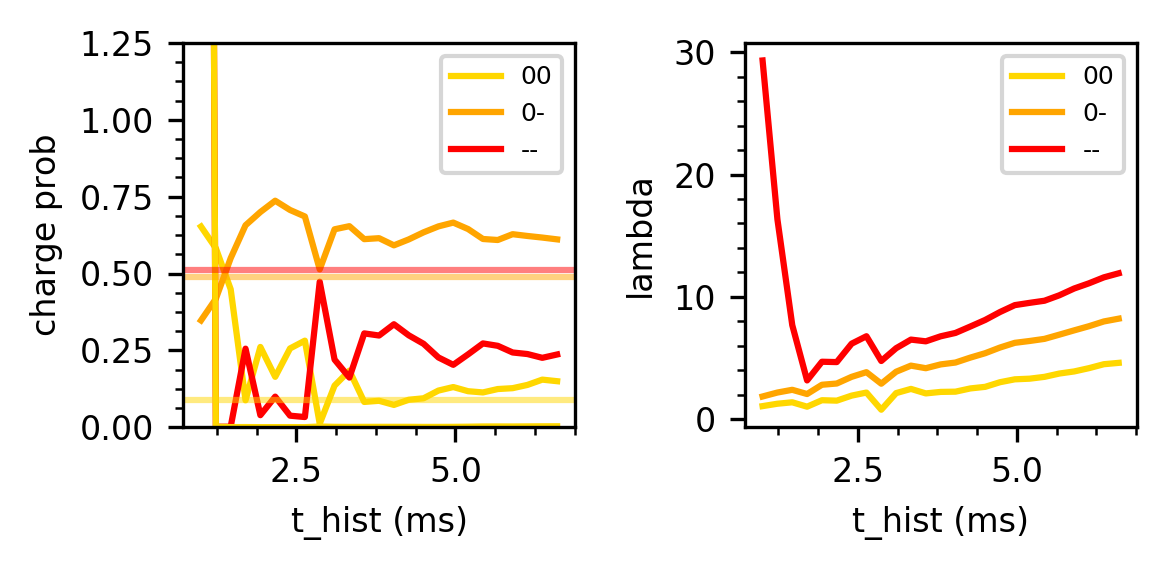

In [873]:
plt.figure(figsize=(4,2))

plt.subplot(121)

plt.gca().set_color_cycle(['gold', 'orange', 'red'])
lines = plt.plot(1e3*xs, ys)
plt.plot(1e3*xs, abs(1-np.sum(ys,axis=1)), label="sum")


plt.legend(lines, ('00', '0-', '--'))


plt.axhline(theo0, color="gold", alpha=0.5)
plt.axhline(theo1, color="red", alpha=0.5)
plt.axhline(theo2, color="orange", alpha=0.5)


plt.xlabel("t_hist (ms)")
plt.ylabel("charge prob")
plt.ylim([0,1.25])


plt.subplot(122)
plt.gca().set_color_cycle(['gold', 'orange', 'red'])
lines = plt.plot(1e3*xs, lambdas)
plt.legend(lines, ('00', '0-', '--'))

plt.xlabel("t_hist (ms)")
plt.ylabel("lambda")

plt.tight_layout()
plt.show()

f"Readout windows starting at: {t_hist_i[0]}"

The charge fidelity depends on t_pcs and n_thresh! Not only n_thresh, but both parameters need to be optimzed. At the same time, the SNR can't be too small.

In [1841]:
# vary t_pcs, fix t_hist for different n_tresh
t_hist_lenght = 2.9e-3

#t_hist = [cp.copy(t_pcs_0[-1]), t_cinit_red[1]]   # must be constant when varying parameters
t_hist = np.asarray([t_cinit_red[1]-t_hist_lenght, t_cinit_red[1]])

n_threshs = [0, 7, 8, 9]
fracs_cinit = np.linspace(0.25, 0.99*t_hist[0]/t_cinit_red[1], 10)
fracs_cinit = np.linspace(0.35, 0.99*t_hist[0]/t_cinit_red[1], 10)


try:
    lambdas, _ = hist_find_lambdas([data_raw[idx_data]], t_hist)   # readout stays the same -> lambdas constant

    xs, ys, ns, n_ph = [], [], [], []

    for n_th in n_threshs:

        x = fracs_cinit*t_cinit_red[1] - t_cinit_red[0]

        y, n_phots = [], []
        for frac_cinit in fracs_cinit:
            t_pcs = [t_cinit_red[0], frac_cinit*t_cinit_red[1]]
            if t_pcs[-1] > t_hist[0]:
                raise ValueError("PCS window can't overlap with histogram window")
            l_mes = hist_post_selected([data_raw[idx_data]], t_pcs, t_hist, lambdas=lambdas, n_thresh=n_th)

            y.append(l_mes['fit_res']['nv_min_ratio'])
            n_phots.append(np.sum(l_mes['infos']['n_phots_per_laser']))

        xs.append(x)
        ns.append(n_th)
        n_ph.append(n_phots)
        ys.append(np.asarray(y))

except:
    logger.exception("")
0

0

$F_{nv-,nv-}$
<a id='val_f_nvnv'></a>

(array([0.05, 3.55]), array([3.75, 6.65]))

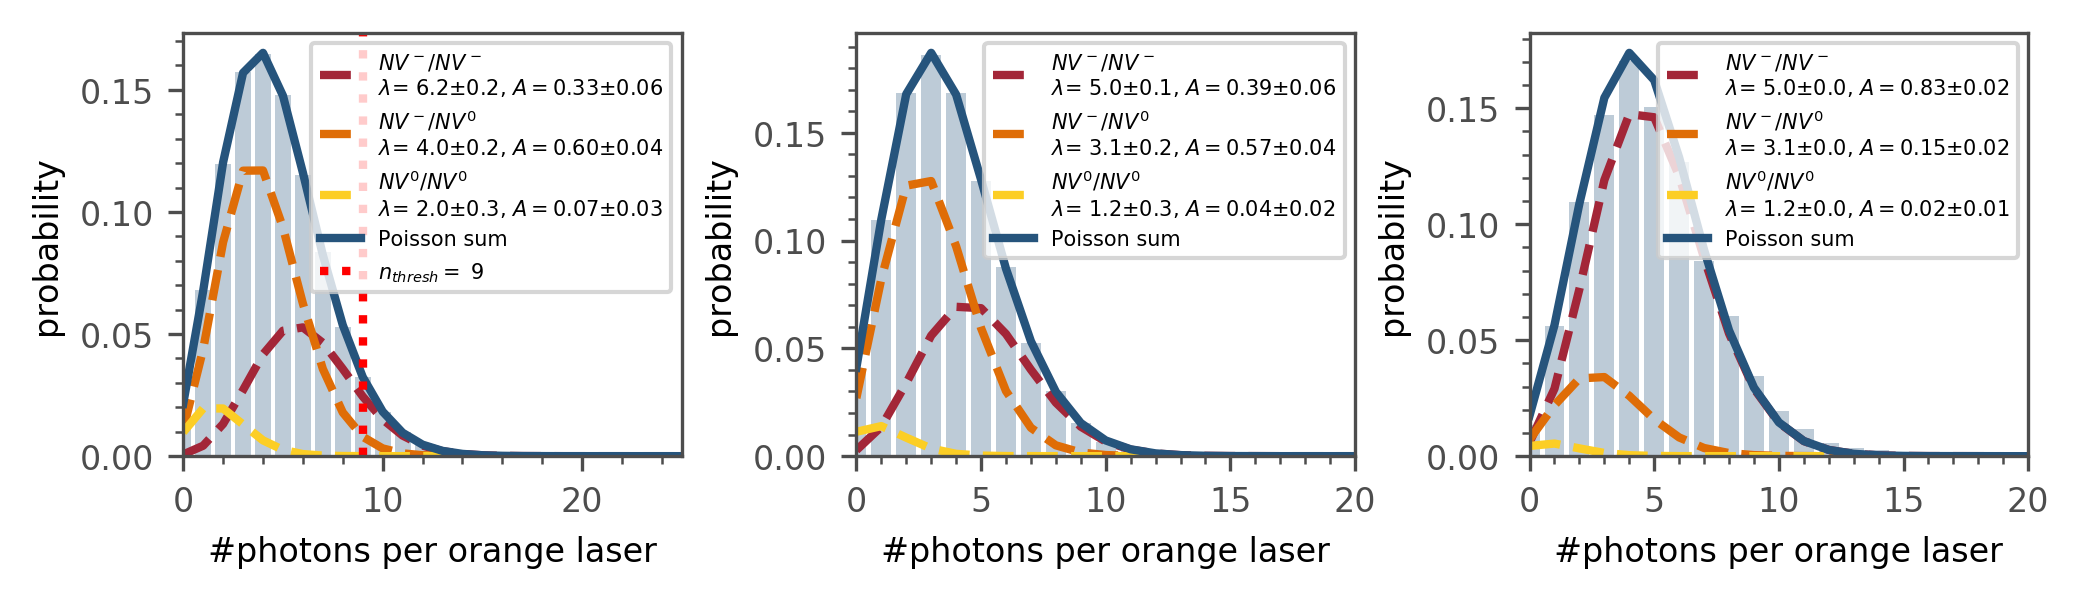

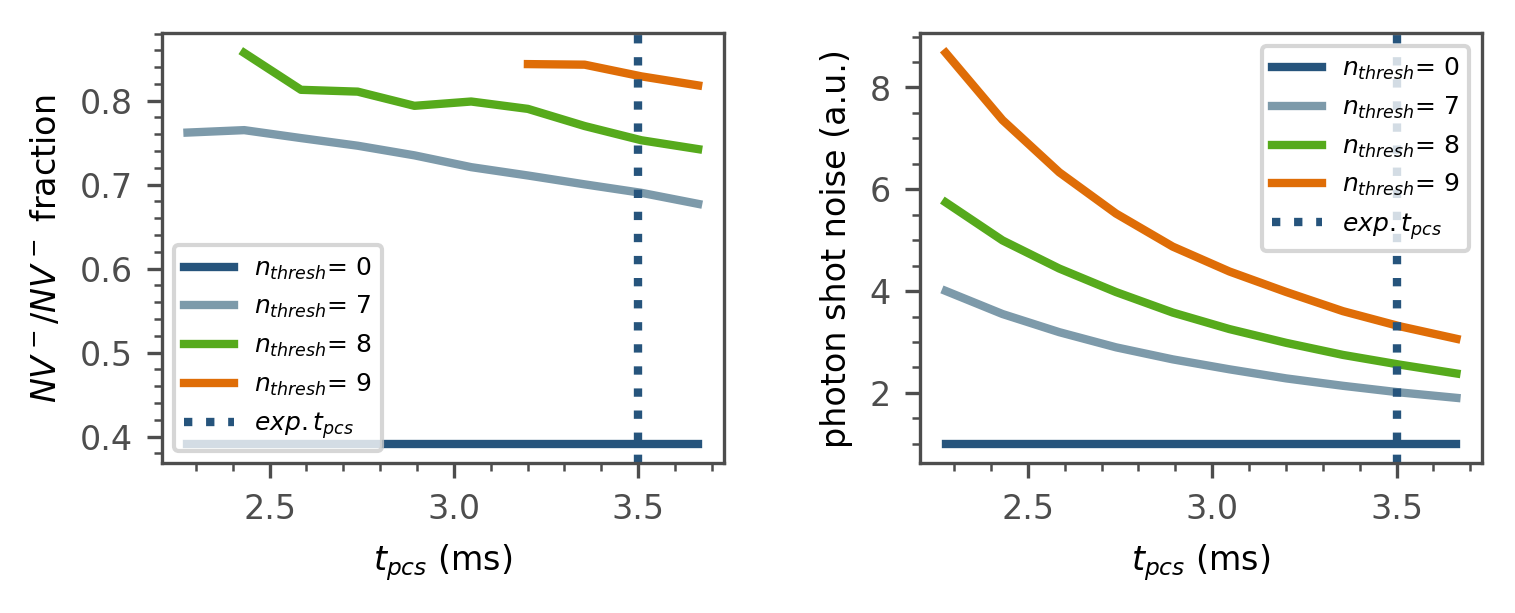

In [1907]:

n_th_pcs = 9
vary_t_pcs = True

t_hist = np.asarray([t_cinit_red[1]-t_hist_lenght, t_cinit_red[1]])   # must be constant when varying parameters
#t_pcs = np.asarray([t_cinit_red[0], t_cinit_red[0]+3.5e-3])
t_pcs = np.asarray([t_cinit_red[0], t_cinit_red[0]+3.5e-3])


try:
    
    if t_hist[0] < t_pcs[1]:
        raise ValueError("PCS and hist window can't overlap")
    
    plt.figure(figsize=(0.7*3*3.5, 3.5*2./3.))
    #plt.figure(figsize=(2*0.8*n_plots*3.5, 2*3.5*2./3.))
    
    
    lambdas, l_mes_0 = hist_find_lambdas([data_raw[idx_data]], t_hist)   # readout stays the same -> lambdas constant
    _, l_mes_cinit = hist_find_lambdas([data_raw[idx_data]], t_pcs) 
    l_mes_pcs = hist_post_selected([data_raw[idx_data]],
                                   t_pcs, t_hist, lambdas=lambdas, n_thresh=n_th_pcs)

    
    plt.subplot(f"131")
    plot_photon_histogram(l_mes_cinit, n_thresh=n_th_pcs, xlim=[0,25],
                          plot_title=False, label_err=True)
    #plt.title("Cinit hist", fontsize=6)

    
    plt.subplot(f"132")
    plot_photon_histogram(l_mes_0, n_thresh=None, xlim=[0,20],
                          plot_title=False, label_err=True)
    #plt.title("Read hist, no init", fontsize=6)
    
    plt.subplot(f"133")
    plot_photon_histogram(l_mes_pcs, n_thresh=None, xlim=[0,20],
                          plot_title=False, label_err=True)
    #plt.title("Read hist, init", fontsize=6)
    
    plt.subplots_adjust(bottom=0.15, wspace=0.35)
    plt_settings.savefig('orange_histogram_pcs.png', frame_right_inch=0.5)


    if vary_t_pcs:
        plt.figure(figsize=(0.8*2*3.5, 3.5*2./3.))
        plt.subplot(f"121")
        for idx, n in enumerate(ns):
            color = plt_settings.get_cmap(False)((idx)/(len(ns)))
            plt.plot(1e3*xs[idx], ys[idx], label=r'$n_{thresh}$' + f'= {n}',
                     color=color, marker="")

        plt.axvline(1e3*(t_pcs[-1]-t_pcs[0]), label=r"$exp. t_{pcs}$", linestyle=':',
                   color=plt_settings.color('blue'))
        plt.xlabel(r"$t_{pcs}$ (ms)")
        plt.ylabel(r"$NV^-/NV^-$ fraction")
        plt.legend(loc="lower left")
        
        plt.subplot(f"122")
        for idx, n in enumerate(ns):
            color = plt_settings.get_cmap(False)((idx)/(len(ns)))
            noise_0 = 1e3/np.sqrt(n_ph[0])
            noise = 1e3/np.sqrt(n_ph[idx])/noise_0
            plt.plot(1e3*xs[idx], noise, label=r'$n_{thresh}$' + f'= {n}', 
                     color=color, marker="")
        
        
        plt.axvline(1e3*(t_pcs[-1]-t_pcs[0]), label=r"$exp. t_{pcs}$", linestyle=':',
                   color=plt_settings.color('blue'))
        plt.xlabel(r"$t_{pcs}$ (ms)")
        plt.ylabel("photon shot noise (a.u.)")
        plt.legend()
        
        #plt.tight_layout()
        plt.subplots_adjust(bottom=0.15, wspace=0.35)
        plt_settings.savefig('suppl_vary_t_pcs.png', 
                             frame_right_inch=0.5, frame_bottom_inch=0.5,
                            frame_top_inch=0.4)
        plt.show()


except:
    logger.exception("")
    

1e3*t_pcs, 1e3*t_hist

In [1529]:
t_pcs

[0.00021, 0.01911]

In [561]:
# OLD

t_bin = 400e-12
n_thresh = 0
fix_lambdas = False

fracs_cinit = np.linspace(0.54,0.6, 2)

try:
    
    
    l_mess = []
    n = n_thresh
    


    # divide the orange laser in a charge-init (pcs) and read charge part
    t_pcs = [t_cinit_red[0], frac_cinit*t_cinit_red[1]]
    t_hist = [t_pcs[-1], t_cinit_red[1]]

    # all arrival times per laser
    t_arrive = post_select([data_raw[idx_data]], t_red=t_pcs,
                           t_read=t_hist,
                           t_bin=t_bin, 
                           n_thresh=n)
    t_arrive = t_arrive[0]
    t_arrive = [t for t in t_arrive if not any(t==np.asarray([-1]))]

    n_phots_per_laser = np.asarray([len(t[t!=0]) for t in t_arrive])


    phot_info_dict = {'n_thresh':n, 't_arrive': t_arrive, 'n_phots_per_laser': n_phots_per_laser}


    y_hist, x_hist = np.histogram(n_phots_per_laser, bins=np.max(n_phots_per_laser), density=True)
    x_hist = x_hist[:-1]



    l_mes = {'data': {'type': 'photon_histogram'},
             'infos': phot_info_dict,
             't_cinit': t_pcs}  
    l_mes['data'].update({'tau': x_hist, 'z1': y_hist})

    l_mes['fit_edit_params'] = [lmfit.Parameter('p0_mu', value=0.2, min=0, max=20, vary=not fix_lambdas),
                                lmfit.Parameter('p1_mu', value=2.1, min=0, max=20, vary=not fix_lambdas),
                                lmfit.Parameter('p2_mu', value=3.9, min=0, max=20, vary=not fix_lambdas),
                                lmfit.Parameter('p0_amplitude', value=0.3, min=0, max=10, vary=True),
                                lmfit.Parameter('p1_amplitude', value=0.3, min=0, max=10, vary=True),
                                lmfit.Parameter('p2_amplitude', value=0.3, min=0, max=10, vary=True)]
    do_fit(l_mes, fit_y='z1', fit_method='poisson_3x', edit_params=l_res['fit_edit_params'])

    l_mes['fit_res']['nv_min_ratio'], ratio_details = calc_nv_min_ratio(l_mes, ratio_at_least_1min=False)
    l_mes['fit_res']['d_nv_min_ratio'] = ratio_details['d_ratio_nv-']
    l_mes['fit_res']['contrast_read'] = ratio_details['lambdas'][0]/ratio_details['lambdas'][-1]
    l_mes['fit_res']['d_contrast_read'] = l_res['fit_res']['contrast_read']*np.sqrt((ratio_details['d_lambdas'][0]/ratio_details['lambdas'][0])**2 + (ratio_details['d_lambdas'][-1]/ratio_details['lambdas'][-1])**2)


    l_mess.append(l_mes)
except:
    logger.exception("")


In [935]:
fix_lambdas

False

0

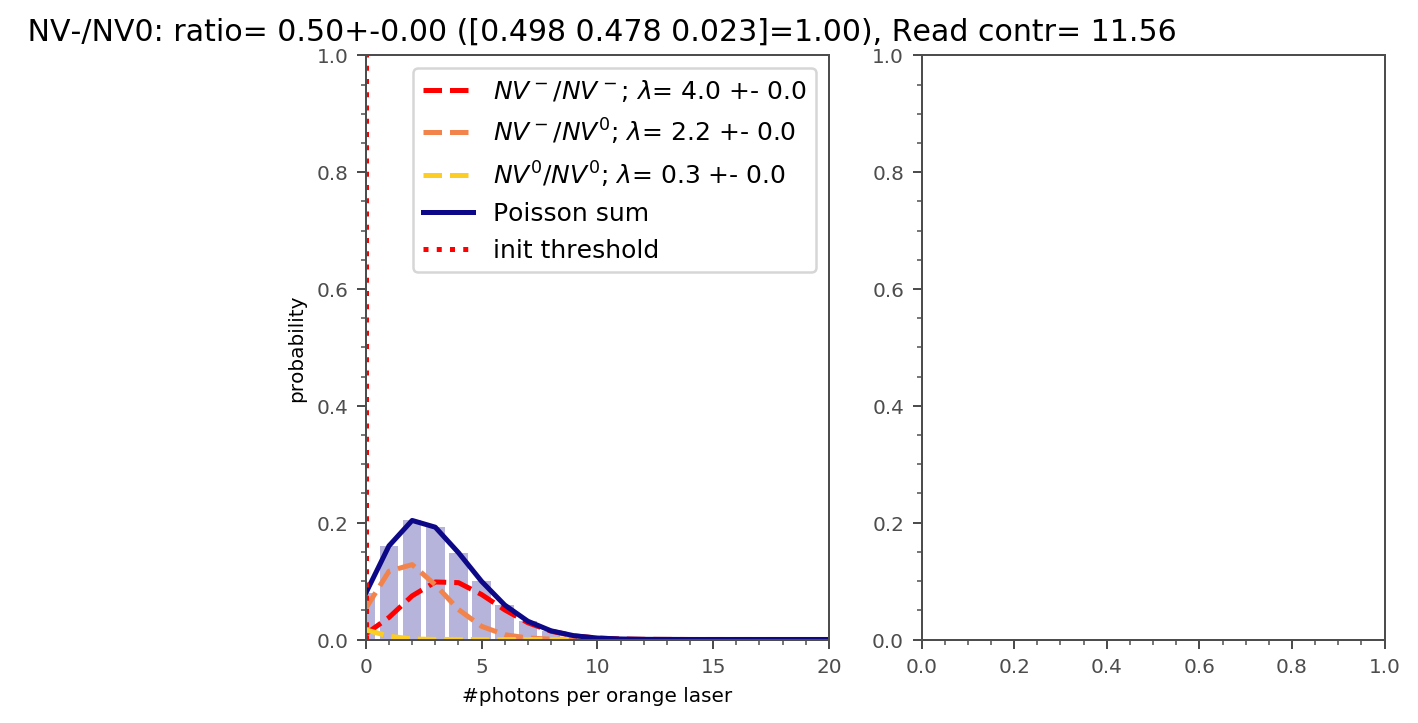

In [1148]:

l_res = l_mess[0]
l_res = l_mes

try:
    plt.figure(figsize=(6,4))
    
    plt.subplot(121)
    plot_photon_histogram(l_res, ratio_at_least_1min=False, xlim=[0,20], atol_poisson=0.05,
                          n_thresh=l_res['infos']['n_thresh'])
    
    plt.ylim([0,1])
    
    plt.subplot(122)
    y = [l['fit_res']['nv_min_ratio'] for l in l_mess]
    x_t_pcs = np.asarray([abs(t_cinit_red[0]-f*t_cinit_red[1]) for f in fracs_cinit])
    
    t_tot = (t_cinit_red[-1]-t_cinit_red[0])
    plt.plot(1e3*x_t_pcs, y, label=f"pcs+read= {1e3*t_tot:.1f} ms")
    
    plt.xlabel("t_pcs (ms)")
    plt.legend()
    
except:
    logger.exception("")
plt_settings.savefig('orange_histogram_pcs.png')#, frame_right_inch=1)
plt.show()

0

In [831]:
l_res['fit_res']['nv_min_ratio']

0.2022057026632138

In [416]:
f"t_pcs+t_read= {1e3*(t_cinit_red[-1]-t_cinit_red[0]):.1f} ms"

't_pcs+t_read= 24.7 ms'

# XY8 tau1 nuc. resonances

In [442]:
# Load deer data

p_raw, x, y, fnames = [], [], [], []
#inpath = r"E:\Data\2023\06\20230609\PulsedMeasurement\deer_dd_tau_inits_1\read_ph=0"
inpath = common_params['data_path'] + r"\2023\11\20231129\PulsedMeasurement\xy8_nucResonances_symm+asymm_1"
inpath = common_params['data_path'] + r"\2023\12\20231203\PulsedMeasurement\xy8_nucResonances_symm+asymm_2"
#inpath = r"E:\Data\2023\12\20231203\PulsedMeasurement\xy8_nucRes_symm_zoom_3"
    
filter_strs = ['pulsed_measurement', '.dat']

try:
    fnames = Tk_file.list_mult_pulsed_mes(inpath, filter_strs=filter_strs, incl_subdir=False)

    for f in fnames:
        p_i = Tk_file.load_pulsed_result(f)
        p_raw.append(p_i)
except:
    logger.exception()
        
data = Tk_file.load_pulsed_result(p_raw[0]['file'])



len(p_raw)

2

In [680]:
plt_settings.color('blue', alpha=0.5)



(0.14901960784313725, 0.32941176470588235, 0.48627450980392156, 0.5)

0

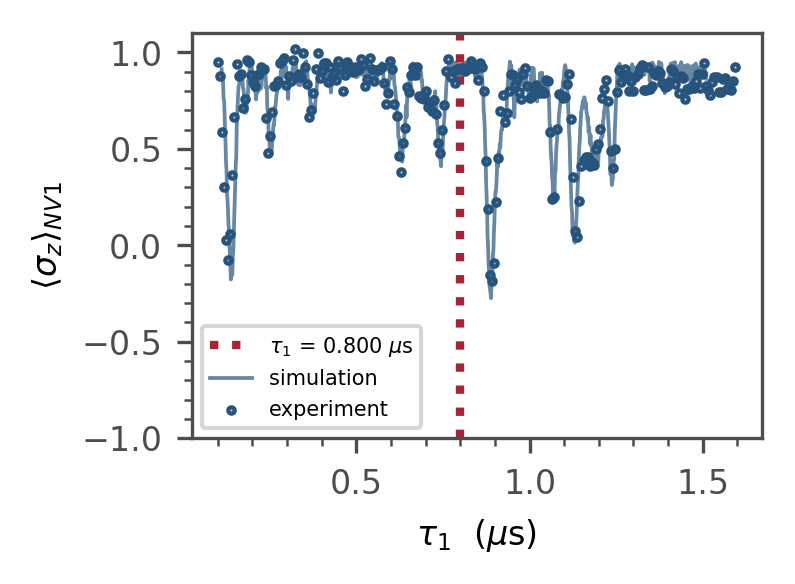

In [446]:


try:
    plot_mode = "delta"
    offset = 0.2
    smooth_data = False
    plot_asym = False
    plot_err = False
    tau_shift_sim_us = 0.011  # todo: dangerous. Sim should fit D, E, .. params, such that no shift needed
    
    x_unit = r"$\mu$s"

    scale_fac_x = 1e6
    scale_fac_y = -9  
    scale_sim_y = 1.3   # todo: dangerous. Sim should be correctly normalized




    labels = ['sym', 'asym']
    labels = ['experiment', 'asym']

    for idx, mes in enumerate(p_raw):
        mes['plot_options'] = {'label': labels[idx]}
    
    if not plot_asym:
        p_raw = [p for p in p_raw if not 'asym' in p['plot_options']['label']]

    #plt.figure(figsize=(1.5*3, 1.5*2/3*3.5))      
    #plt.figure(figsize=(1.5*3, 1.2*2/3*3.5))  
    plt.figure(figsize=(0.9*3, 0.9*2/3*3.5))
    
    facecolor = plt_settings.color('blue', alpha=0.3)
    marker_style = dict(s=plt_settings.get_markersize(is_scatter=True, size='small'),
                        marker='o',
                        color=plt_settings.color('blue'),
                        facecolor=facecolor,
                        linewidths=1,
                        edgecolor=plt_settings.color('blue'))

    
    plot_multiple_1d(p_raw, n_datas=0.1, 
                     scale_fac_x=scale_fac_x, scale_fac_y=scale_fac_y,
                     marker_size='small',#marker_size='s-medium',
                     offset=offset,
                     plot_err=plot_err, marker_style=marker_style, alpha=None)  
        
    #x = scale_fac_x*p_raw[0]['data']['tau']
    #y = scale_fac_y*(p_raw[0]['data']['z1']-p_raw[0]['data']['z2'])
    #plt.plot(x, y, marker="")  

    tau_cnot = 800e-9

    plt.axvline(scale_fac_x*tau_cnot, label=r'$\tau_{1}$ ' + f'= {scale_fac_x*tau_cnot:.3f} {x_unit}',
                color=plt_settings.color('red'), linestyle=":")
       
    
    
    plt.legend(loc='lower right', prop={'size': 5}, ncol=1)
    #plt.legend(prop={'size': 11})
    #plt.ylim([-1.25, 1.25])
    #plt.xlim([0, 2])

    
    # simulation data
    inpath = common_params['data_path'] + r"\2023\10\20231030\simulation_julich\20231129_xy8_nucres_tau1"
    #inpath = r"E:\Data\2023\10\20231030\simulation_julich\20231201_xy8_asym_sym_sweep"
   
    fnames = Tk_file.list_mult_pulsed_mes(inpath, filter_strs=['npz'], incl_subdir=False)[::-1]

    rule_replace = {}
                    
    labels = [os.path.basename(f) for f in fnames]
    labels = rename_strings(labels, rule_replace)
    
    rule_rename = {'XY8s_1_22.7MHz.npz': 'simulation sym',
                   'XY8a_1_22.7MHz.npz' : 'simulation asym'}
    #rule_rename = {'XY8_1_22.7MHz_': '',
    #               'XY8_1_22.7MHz_' : ''}
    labels_plot = rename_strings(labels, rule_rename)
    
    
    sims = []

   
    for f in fnames:
        sims.append(load_sim(f))

    
    for idx, s in enumerate(sims):

        label = labels_plot[idx] 
        #if '40' in label or '30' in label or '20' in label or '10.' in label or '100.0' in label: 
        #    continue

        y = _norm_sim_2_exp(s['data']['y'], orig_range=[0.8,1], new_range=[0,0.11], rb_y0=1) + offset*idx
        y = _norm_sim_2_exp(s['data']['y'], orig_range=[scale_sim_y*0.5,1], new_range=[-1,1], rb_y0=1) + offset*idx
        #y = s['data']['y'] + offset*idx
        
        #y[y < 0.98*np.max(y)] = np.nan

        #y = s['data']['y']  + offset*idx
        x = s['data']['tau_array'] + tau_shift_sim_us
        
        
        color = plt_settings.get_cmap(False)((idx)/(len(sims)))
        #color = plt_settings.get_cmap(True)((idx)/(len(sims)))
        if 'asym' in label:
            color = plt_settings.color('red')
        #if 'sym' in label:
        #    color = plt_settings.color('blue')
        linestyle = 'solid' 
        
        
        if 'asym' not in label or plot_asym and 'asym' in label:
            
            label = label.replace("sym", "")
            plt.plot(x, y, label=label, marker="",
                     linestyle=linestyle, color=color, zorder=1, alpha=0.7, linewidth=0.9)
            #plt.scatter(x, y, label='_no_legend',
            #         linestyle=linestyle, color=color, zorder=1, alpha=0.7, s=3)
    
    
    plt.xlabel(r'$\tau_1$  ($\mu$s)')
    plt.ylabel(r'$\langle \sigma_z \rangle_{NV1}$')
    #plt.ylabel(r'optical contrast NV 1')
    
    #plt.xlim([0.6,1.0])
    #plt.ylim([-0.05,0.12])
    #plt.ylim([0.04,0.12])
    plt.ylim([-1,1.1])
    
    plt.legend(prop={'size':5}, loc='lower left') # ncol=2, 
    plt_settings.savefig('suppl_xy8_tau1.png', 
                         frame_right_inch=0.1, frame_top_inch=0.2)
    plt.show()

except:
    logger.exception("")
0

In [689]:
facecolor

(0.14901960784313725, 0.32941176470588235, 0.48627450980392156, 0.5)

0

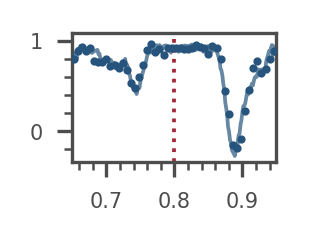

In [518]:
# zoom

try:
    plot_mode = "delta"
    offset = 0.2
    smooth_data = False
    plot_asym = False
    plot_err = False
    tau_shift_sim_us = 0.011  # todo: dangerous. Sim should fit D, E, .. params, such that no shift needed
    
    x_unit = r"$\mu$s"

    scale_fac_x = 1e6
    scale_fac_y = -9  
    scale_sim_y = 1.3   # todo: dangerous. Sim should be correctly normalized




    labels = ['sym', 'asym']
    labels = ['experiment', 'asym']

    for idx, mes in enumerate(p_raw):
        mes['plot_options'] = {'label': labels[idx]}
    
    if not plot_asym:
        p_raw = [p for p in p_raw if not 'asym' in p['plot_options']['label']]

    #plt.figure(figsize=(1.5*3, 1.5*2/3*3.5))      
    #plt.figure(figsize=(1.5*3, 1.2*2/3*3.5))  
    plt.figure(figsize=(0.85, 0.6))
    
    facecolor = plt_settings.color('blue', alpha=0.3)
    marker_style = dict(s=plt_settings.get_markersize(is_scatter=True, size='s-medium'),
                        marker='o',
                        color=plt_settings.color('blue'),
                        facecolor=facecolor,
                        linewidths=1,
                        edgecolor=plt_settings.color('blue'))
    
    plot_multiple_1d(p_raw, n_datas=0.1, 
                     scale_fac_x=scale_fac_x, scale_fac_y=scale_fac_y,
                     marker_size='s-medium',
                     offset=offset,
                     plot_err=plot_err, marker_style=marker_style)  
        
    #x = scale_fac_x*p_raw[0]['data']['tau']
    #y = scale_fac_y*(p_raw[0]['data']['z1']-p_raw[0]['data']['z2'])
    #plt.plot(x, y, marker="")  

    tau_cnot = 800e-9

    plt.axvline(scale_fac_x*tau_cnot, label=r'$\tau_{1}$ ' + f'= {scale_fac_x*tau_cnot:.2f} {x_unit}',
                color=plt_settings.color('red'), linestyle=":", linewidth=0.9)
       
    
    
    #plt.legend(loc='lower right', prop={'size': 5}, ncol=1)
    #plt.legend(prop={'size': 11})
    #plt.ylim([-1.25, 1.25])
    #plt.xlim([0, 2])

    
    # simulation data
    inpath = common_params['data_path'] + r"\2023\10\20231030\simulation_julich\20231129_xy8_nucres_tau1"
    #inpath = r"E:\Data\2023\10\20231030\simulation_julich\20231201_xy8_asym_sym_sweep"
   
    fnames = Tk_file.list_mult_pulsed_mes(inpath, filter_strs=['npz'], incl_subdir=False)[::-1]

    rule_replace = {}
                    
    labels = [os.path.basename(f) for f in fnames]
    labels = rename_strings(labels, rule_replace)
    
    rule_rename = {'XY8s_1_22.7MHz.npz': 'simulation sym',
                   'XY8a_1_22.7MHz.npz' : 'simulation asym'}
    #rule_rename = {'XY8_1_22.7MHz_': '',
    #               'XY8_1_22.7MHz_' : ''}
    labels_plot = rename_strings(labels, rule_rename)
    
    
    sims = []

   
    for f in fnames:
        sims.append(load_sim(f))

    
    for idx, s in enumerate(sims):

        label = labels_plot[idx] 
        #if '40' in label or '30' in label or '20' in label or '10.' in label or '100.0' in label: 
        #    continue

        y = _norm_sim_2_exp(s['data']['y'], orig_range=[0.8,1], new_range=[0,0.11], rb_y0=1) + offset*idx
        y = _norm_sim_2_exp(s['data']['y'], orig_range=[scale_sim_y*0.5,1], new_range=[-1,1], rb_y0=1) + offset*idx
        #y = s['data']['y'] + offset*idx
        
        #y[y < 0.98*np.max(y)] = np.nan

        #y = s['data']['y']  + offset*idx
        x = s['data']['tau_array'] + tau_shift_sim_us
        
        
        color = plt_settings.get_cmap(False)((idx)/(len(sims)))
        #color = plt_settings.get_cmap(True)((idx)/(len(sims)))
        if 'asym' in label:
            color = plt_settings.color('red')
        #if 'sym' in label:
        #    color = plt_settings.color('blue')
        linestyle = 'solid' 
        
        
        if 'asym' not in label or plot_asym and 'asym' in label:
            
            label = label.replace("sym", "")
            plt.plot(x, y, label=label, marker="",
                     linestyle=linestyle, color=color, zorder=1, alpha=0.7, linewidth=0.9)
            #plt.scatter(x, y, label='_no_legend',
            #         linestyle=linestyle, color=color, zorder=1, alpha=0.7, s=3)
    
    
    plt.xlabel("")
    plt.ylabel("")
    #plt.ylabel(r'optical contrast NV 1')
    
    plt.xlim([0.65,0.95])
    
    plt.xticks(fontsize=5, rotation=0)
    plt.yticks(fontsize=5, rotation=0)

    
    #plt.legend(prop={'size':5}, loc='lower left') # ncol=2, 
    plt_settings.savefig('suppl_xy8_tau1_zoom.png', 
                         frame_left_inch=0.15, frame_bottom_inch=0.15,
                         frame_right_inch=0.02, frame_top_inch=0.02)
    plt.show()

except:
    logger.exception("")
0

##### y

In [4911]:
rule_rename = {'XY8s_1_22.7MHz.npz': 'sim sym',
                   'XY8a_1_22.7MHz.npz' : 'sim asym'}
rule_rename

{'XY8s_1_22.7MHz.npz': 'sim sym', 'XY8a_1_22.7MHz.npz': 'sim asym'}

In [75]:
tau_target = 800e-9
idx_sim = 0

#tau_target = 1000e-9
#idx_sim = 1

idx_t = np.argmin(abs(sims[0]['data']['tau_array']*1e-6-tau_target))

s = sims[idx_sim]
label = labels[idx_sim]

tau = s['data']['tau_array'][idx_t]*1e-6
y =   s['data']['y'][idx_t]*1e-6

y = _norm_sim_2_exp(s['data']['y'], rb_y0=1) 
#y = s['data']['y']  + offset*idx
x = s['data']['tau_array']


color = plt_settings.color('blue')
if 'XY8a' in label:
    color = plt_settings.color('red')
linestyle = 'solid' 

plt.plot(x, y, label=label, marker="",
         linestyle=linestyle, color=color, zorder=1)

plt.axvline(tau*1e6, label=f"tau= {1e6*tau:.3f} us")

#plt.xlim([tau_target*1e6-0.28,tau_target*1e6+0.28])
plt.xlim([0.5,tau_target*1e6+0.1])
plt.xlim([0.73,0.86])
plt.ylim([0.93,1])


#plt.yscale('log')
plt.legend()
plt.xlabel("tau1 (us)")
plt.ylabel("sig_z")

plt.show()

tau

Traceback (most recent call last):
  File "C:\Users\Setup3-PC\Desktop\qudi\logic\jupyterkernel\qzmqkernel.py", line 679, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-75-8c6b44aa112b>", line 7, in <module>
    idx_t = np.argmin(abs(sims[0]['data']['tau_array']*1e-6-tau_target))
NameError: name 'sims' is not defined


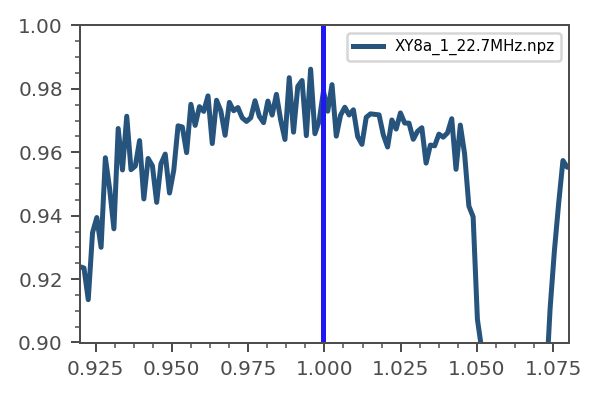

# SPAM: Rabi vs lambda2

In [416]:
inpaths

['E:\\Data\\2024\\04\\20240426\\PulsedMeasurement\\rabi_30g_vs_lambda2_1\\a', 'E:\\Data\\2024\\04\\20240426\\PulsedMeasurement\\rabi_30g_vs_lambda2_1\\b']

In [491]:
p_raw, x, y, fnames = [], [], [], []
#inpath = common_params['data_path'] + r"\2023\06\20230609\PulsedMeasurement\deer_dd_tau_inits_1\read_ph=0"
inpaths = common_params['data_path'] + r"\2023\12\20231211\PulsedMeasurement\rabi_vs_lambda2_1"
#inpaths = [common_params['data_path'] + r"\2023\12\20231213\PulsedMeasurement\new_mag_setting_60G_2\rabi_vs_lambda2_1\a",
#           common_params['data_path'] + r"\2023\12\20231213\PulsedMeasurement\new_mag_setting_60G_2\rabi_vs_lambda2_1\b"]
inpaths = [common_params['data_path'] + r"\2024\04\20240426\PulsedMeasurement\rabi_30g_vs_lambda2_1\a",
           common_params['data_path'] + r"\2024\04\20240426\PulsedMeasurement\rabi_30g_vs_lambda2_1\b"]

#inpath = common_params['data_path'] + r"\2024\04\20240426\PulsedMeasurement\rabi_30g_vs_lambda2_1"

filter_strs = ['pulsed_measurement', '.dat']

xs, ys, dys = [], [], []


for path in inpaths:
    p_raw = []
    
    try:
        fnames = Tk_file.list_mult_pulsed_mes(path, filter_strs=filter_strs, incl_subdir=False)
        #fnames = fnames[:100]

        for f in fnames:
            p_i = Tk_file.load_pulsed_result(f)
            p_raw.append(p_i)
    except:
        logger.exception()

    data = Tk_file.load_pulsed_result(p_raw[0]['file'])


    y_val_idx = -1
    x_val = "Time"
    x_unit = "s"
    scale_fac_x = [1]
    scale_fac_y = [1e9, 1e-6, 1e-6]
    fit_on = 'z1'
    fit_meth = 'sine'
    fit_vals = ['Contrast', 'Period', 'Phase']
    fit_units = ['ns','MHz', 'MHz']
    fit_settings = {}
    calc_dxdy_fromto = [False, False, False]
    #"""


    f_expect = 11e6

    try:
        #"""
        for idx, mes in enumerate(p_raw):
            mes['fit_settings'] = fit_settings

            mes['fit_edit_params'] = [lmfit.Parameter('offset', value=1, vary=True),
                    lmfit.Parameter('amplitude', value=60e-3, min=0, max=2, vary=True),
                    #lmfit.Parameter('frequency', value=f_expect, min=0.2*f_expect, max=5*f_expect, vary=True),
                    lmfit.Parameter('beta', value=1, vary=False),
                    lmfit.Parameter('lifetime', value=np.inf, vary=False),
                    lmfit.Parameter('phase', value=1.57, vary=False)]

        #"""



        x, y, y2, y3, dy = pulsed_series_2_1d_fit_array(p_raw, 
                                                fit_meth=fit_meth, fit_on=fit_on, fit_vals=fit_vals,
                                                idx_var_x=y_val_idx, ordered_x=True)
        xs.append(x)
        ys.append(y)
        dys.append(dy)
    except:
        logger.exception("")


x

array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
        55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105.,
       110., 115., 120., 125., 130., 135., 140., 145., 150., 155., 160.,
       165., 170., 175., 180., 185., 190., 195., 200., 205., 210., 215.,
       220., 225., 230., 235., 240., 245., 250., 255., 260., 265., 270.,
       275., 280., 285., 290., 295., 300., 305., 310., 315., 320., 325.,
       330., 335., 340., 345.])

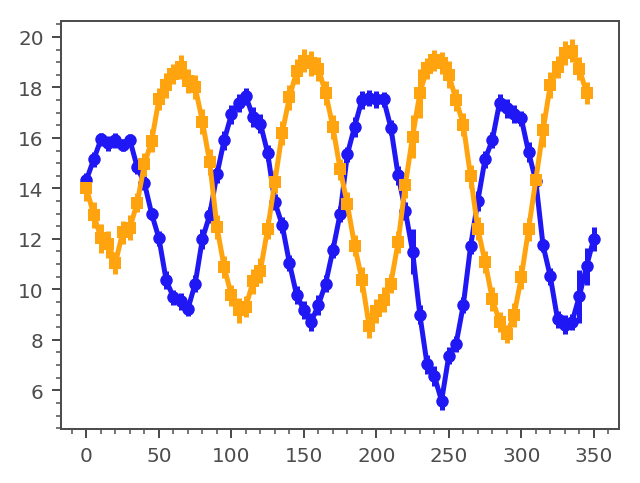

In [494]:
"""
def compare_and_swap(arr1, arr2, dy_arr1=None, dy_arr2=None):
    res_arr1 = np.where(arr1 < arr2, arr2, arr1)
    res_arr2 = np.where(arr1 < arr2, arr1, arr2)
    
    
    res_dy_arr1, res_dy_arr2 = dy_arr1, dy_arr2
    if dy_arr1 is not None and dy_arr2 is not None:
        res_dy_arr1 = np.where(arr1 < arr2, dy_arr2, dy_arr1)
        res_dy_arr2 = np.where(arr1 < arr2, dy_arr1, dy_arr1)
    
    return res_arr1, res_arr2, res_dy_arr1, res_dy_arr2

x_nv1 = x[::2]
y_nv1 = y[::2]
dy_nv1 = dy[::2]

x_nv2 = x[1::2]
y_nv2 = y[1::2]
dy_nv2 = dy[1::2]

# make sure fit values are not swapped
y_nv1, y_nv2, dy_nv_1, dy_nv2 = compare_and_swap(y_nv1, y_nv2, dy_nv1, dy_nv2)

"""
x_nv1 = np.asarray(xs[0])
y_nv1 = np.asarray(ys[0])
dy_nv1 = np.asarray(dys[0])

x_nv2 = np.asarray(xs[1])
y_nv2 = np.asarray(ys[1])
dy_nv2 = np.asarray(dys[1])

plt.figure(figsize=(4,3))

plt.errorbar(x_nv1, y_nv1, yerr=dy_nv1)
plt.errorbar(x_nv2, y_nv2, yerr=dy_nv2)
plt.show()

In [476]:
qdplotlogic.set_data(x_nv1, y_nv1, plot_index=0)
qdplotlogic.set_data(x_nv1, y_nv2, plot_index=1)


0

'SPAM by mis B= 0.47733492373614084'

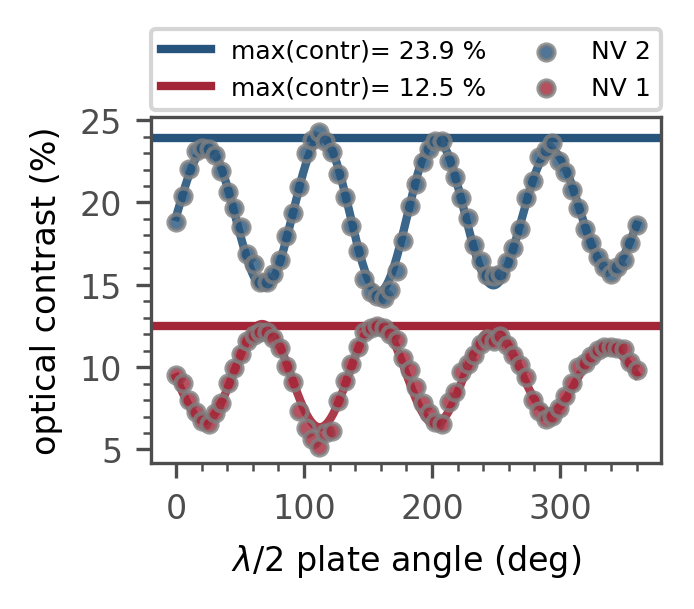

In [1238]:
p_mes_nv1 = {'data': {'z1': y_nv1, 'tau': x_nv1}, 'file': 'na=0', 'exp_params': {'savetag': 'NV 2'}}
p_mes_nv2 = {'data': {'z1': y_nv2, 'tau': x_nv2}, 'file': 'na=1', 'exp_params': {'savetag': 'NV 1'}}

f_expect = 1e-3

ps = [p_mes_nv1, p_mes_nv2]

try:

    y_val_idx = -1
    x_val = "Time"
    x_unit = "s"
    scale_fac_x = [1]
    scale_fac_y = [1e9, 1e-6, 1e-6]
    fit_on = 'z1'
    fit_meth = 'sine_2x'
    fit_vals = ['Contrast', 'Period', 'Phase']
    fit_units = ['ns','MHz', 'MHz']
    fit_settings = {}
    calc_dxdy_fromto = [False, False, False]
    
    for idx, mes in enumerate(ps):
        mes['fit_settings'] = fit_settings
        mes['fit_edit_params'] = [lmfit.Parameter('offset', value=1, vary=True),
                lmfit.Parameter('amplitude', value=40e-3, min=10e-3, max=2, vary=True),
                lmfit.Parameter('frequency', value=f_expect, min=0, max=2*f_expect, vary=True),
                lmfit.Parameter('beta', value=1, vary=False),
                lmfit.Parameter('lifetime', value=np.inf, vary=False),
                lmfit.Parameter('phase', value=1.57, vary=False)]
    #"""



    x, y, y2, y3, dy = pulsed_series_2_1d_fit_array(ps, 
                                            fit_meth=fit_meth, fit_on=fit_on, fit_vals=fit_vals,
                                            idx_var_x=y_val_idx, ordered_x=True)
    
    plt.figure(figsize=(0.9*3, 0.9*2/3*3.5))
    plot_multiple_1d(ps, plot_mode='z1', offset=0.2, n_datas=0.1)
    
    contr_max_nv1 = np.max(ps[0]['fit_values']['y'])
    contr_max_nv2 = np.max(ps[1]['fit_values']['y'])
    plt.axhline(contr_max_nv1, label=f"max(contr)= {contr_max_nv1:.1f} %",
               color=plt_settings.color('blue'))
    plt.axhline(contr_max_nv2, label=f"max(contr)= {contr_max_nv2:.1f} %",
               color=plt_settings.color('red'))
    
    
    plt.xlabel(r"$\lambda/2$ plate angle (deg)")
    plt.ylabel("optical contrast (%)")
    
    plt.legend(ncol=2, loc='lower left',
           bbox_to_anchor=(0., 1.02, 1., .102),
           mode="expand", borderaxespad=0.,
          )
    
    plt_settings.savefig("suppl_spam_misal_b_by_rabi.png")
    
except:
    logger.exception("")
plt.show()

f"SPAM by mis B= {1- contr_max_nv2/contr_max_nv1}"

In [1223]:
contr_max_nv1 = np.max(ps[0]['fit_values']['y'])
contr_max_nv2 = np.max(ps[1]['fit_values']['y'])



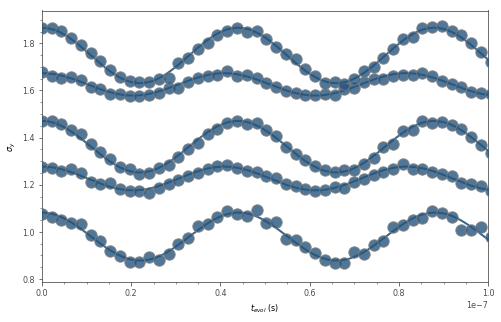

In [260]:
# debug: fits working on rabi data

smooth_data = False

try:
    plt.figure(figsize=(8,5))
    plot_multiple_1d(p_raw, plot_mode='z1', offset=0.2)
    plt.xlim([0,100e-9])
    
    plt.show()
except:
    logger.exception("")

## SPAM vs B

In [2648]:
data_f_init[0].keys()

dict_keys(['date', 'file', 'listfile_header', 'debug_raw_header', 'read_lines', 'time_trace', 'number_of_sweeps', 'read_whole_file', 'bin_max', 'debug_bins_filtered', 'debug_raw_data', 'debug_raw_hex', 'data', '_filter_trace'])

In [3008]:
inpath = common_params['data_path'] + r"\2023\10\20231030\simulation_julich\20230112_fidelity_vs_B"
inpath_spin_init = common_params['data_path'] + r"\2023\10\20231030\simulation_roberto\20240114_init_error\init_fid"

rule_rename = {'fid': r'$\sqrt{ZZ}$ gate fidelity, full sim., $T_2=\infty$'}


fnames = Tk_file.list_mult_pulsed_mes(inpath, filter_strs=['.npz'], incl_subdir=False)
sim = load_sim(fnames[0])

sims = []
sims.append(sim)

labels_f = sims[0]['data'].keys()
labels_f = [l for l in labels_f if 'fid' in l]
# filter out unwanted sims
#labels_f = [l for l in labels_f if 'fid'==l or 'fid_hf_off'==l or 'fid_no_ctleak'==l]
labels_f = [l for l in labels_f if 'fid'==l]

labels_plot = rename_strings(labels_f, rule_rename)


# spin init simulation from roberto
data_f_init = load_sim_roberto(inpath_spin_init)


labels_f, labels_plot

(['fid'], ['$\\sqrt{ZZ}$ gate fidelity, full sim., $T_2=\\infty$'])

'fid(0)= 0.8795468309173433, fid(setting_2)= 0.7308028707471724, fid_rel(settings_2)= 0.8308856846030188'

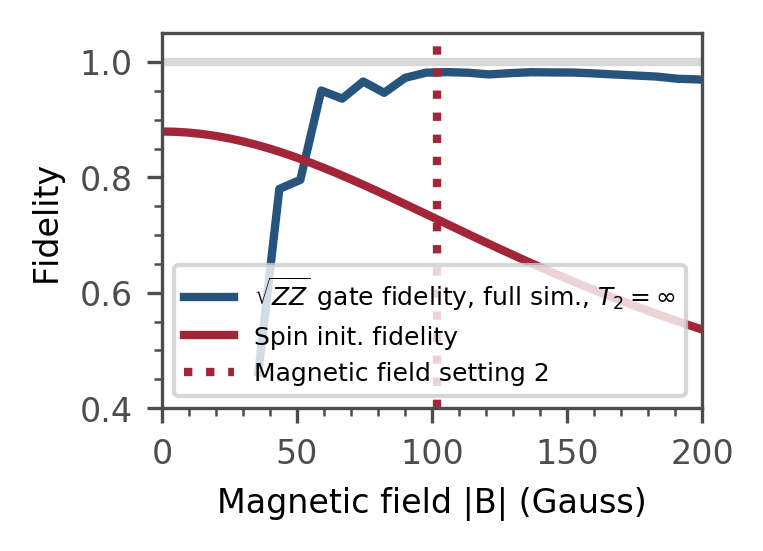

In [3113]:
t_gate_2q = common_params['xy8_order_2q'] *8*common_params['tau1_2q']
epg_t2_limit = coherence_epg_limit_simple(t_gate_2q, np.mean(common_params['t2_xy8']))
b_exp_g = 102 

s = sims[0]


fig, ax1 = plt.subplots(figsize=(0.9*3, 0.9*2/3*3.5))
#ax2 = ax1.twinx()

for idx, key in enumerate(labels_f):
    label = labels_plot[idx]
    x_mhz = s['data']['x']
    x_g = x_mhz/2.8
    
    y = s['data'][key] 
    y = s['data'][key]*(1-epg_t2_limit)   # other pulses also there!

    color = plt_settings.get_cmap(False)((idx)/(len(labels_f)))
    if idx >= 1:  # adjust colors to fit to rb@n_cliff=1 plot
        color = plt_settings.get_cmap(False)((idx+1)/(len(labels_f)))

    linestyle = 'solid' 

    #color = plt_settings.color('red') if is_exp_sim else color

    ax1.plot(x_g, y, label=label, 
             marker="", linestyle=linestyle, color=color,
             markersize=2)
    
ax1.plot(data_f_init['B']*1e4, data_f_init['fid_ms=1'], label="Spin init. fidelity",
         marker="",
        color=plt_settings.color('red'))  # tesla to gauss
    
plt.axhline(1, color='grey', alpha=0.3)
plt.axvline(b_exp_g, color=plt_settings.color('red'), linestyle=':', label="Magnetic field setting 2")
    
ax1.set_xlabel("Magnetic field |B| (Gauss)")
ax1.set_ylabel("Fidelity")
#ax2.set_ylabel("Spin init fidelity", color=plt_settings.color('red'))
plt.xlim([0, 200])
plt.ylim([0.4, 1.05])
plt.legend()


plt_settings.savefig('suppl_f_vs_B.png',
                     frame_top_inch=0.3,
                     frame_right_inch=0.2)
plt.show()

idx_b = np.argmin(abs(b_exp_g-data_f_init['B']*1e4))
fid_b = data_f_init['fid_ms=1'][idx_b]
fid_0 = data_f_init['fid_ms=1'][0]


f"fid(0)= {fid_0}, fid(setting_2)= {fid_b}, fid_rel(settings_2)= {fid_b/fid_0}"


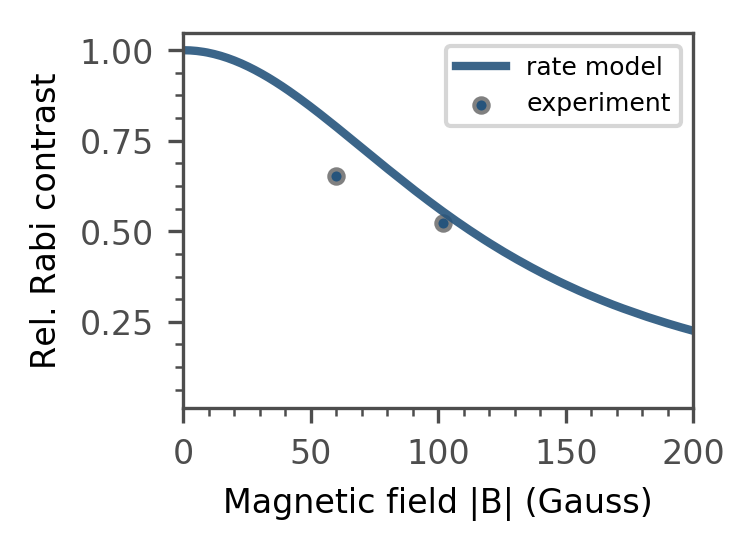

In [3068]:
inpath_odmr = common_params['data_path'] + r"\2023\10\20231030\simulation_roberto\20240114_init_error\cw_odmr"

# data: 20231211
contr_1_60g = 0.231
contr_2_60g = 0.151
contr_1_100g = 0.239
contr_2_100g = 0.125

contr_rel_60g = [60, contr_2_60g/contr_1_60g]
contr_rel_100g = [102, contr_2_100g/contr_1_100g]


# spin init simulation from roberto
data_f_odmr = load_sim_roberto(inpath_odmr, extension='.npy')

x_g = data_f_odmr['b']*1e4
y = data_f_odmr['y']/data_f_odmr['y'][0]

plt.figure(figsize=(0.8*3, 0.9*2/3*3.5))

color = plt_settings.color('blue')
marker_style = plt_settings.marker_style(color, is_scatter=True)

plt.scatter(*contr_rel_60g, label='experiment', **marker_style)
plt.scatter(*contr_rel_100g, **marker_style)
plt.plot(x_g, y, label="rate model",
         color=color,  alpha= 0.9, linewidth=2, marker="")

plt.xlim([0,200])
plt.xlabel('Magnetic field |B| (Gauss)')
plt.ylabel('Rel. Rabi contrast')
plt.legend()

plt_settings.savefig('suppl_odmr_vs_B.png',
                     frame_top_inch=0.3,
                     frame_left_inch=0.6,
                     frame_right_inch=0.1)
plt.show()

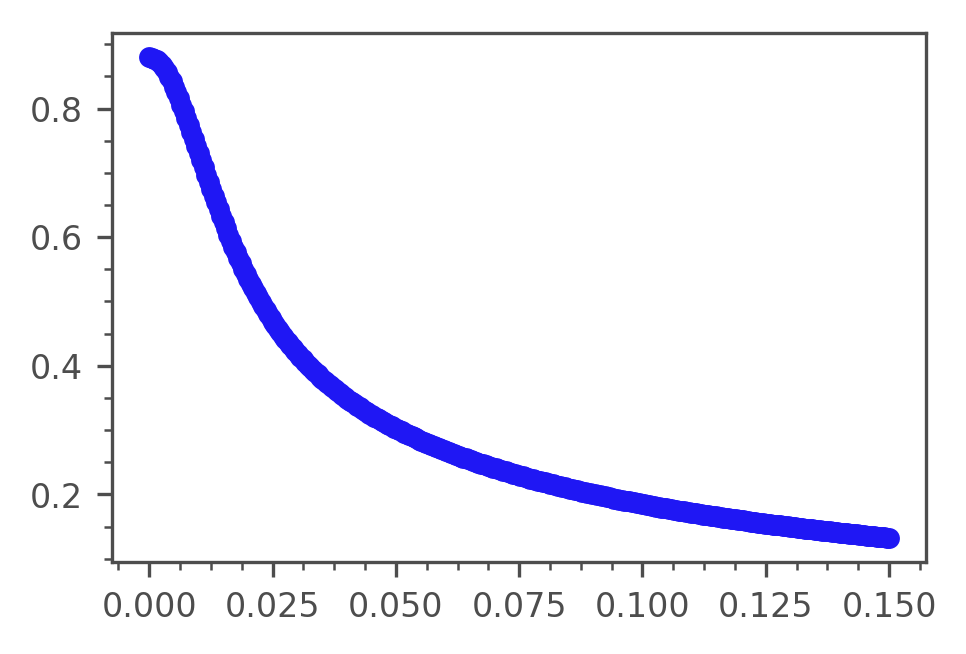

In [2819]:
def common_prefix(strings):
    if not strings:
        return ""

    result = ""

    # Zip the strings together and iterate over corresponding characters
    for chars in zip(*strings):
        if len(set(chars)) == 1:
            result += chars[0]
        else:
            break

    return result

def load_sim_roberto(path, rule_rename=None, extension='.txt'):
    
    fnames = Tk_file.list_mult_pulsed_mes(path, filter_strs=[extension], incl_subdir=False)[::-1]
    
    data = {}
    
    common_str = common_prefix(fnames)
    
    for f in fnames:
        col = f.replace(common_str, "")
        col = col.replace(extension, "")
        
        if rule_rename:
            if col in rule_rename.keys():
                col = rule_rename[col]
        
        if extension == '.txt':
            a = np.loadtxt(f).flatten()
        elif extension == '.npy':
            a = np.load(f)
        else:
            raise ValueError
        data[col] = a
        
    return data

inpath = common_params['data_path'] + r"\2023\10\20231030\simulation_roberto\20240114_init_error\init_fid"

data_f_init = load_sim_roberto(inpath)


data_f_init
plt.plot(data_f_init['B'], data_f_init['fid_ms=1'])
plt.show()



'E:\\Data\\2023\\10\\20231030\\simulation_roberto\\20240114_init_error/init_fidel_tentienne_values_'

# Contrast of comp. basis

For discussion with Japanese group on decay rates that depend on the collective state of the NV register.

In [625]:
   
inpath = common_params['data_path'] + r"\2023\12\20231208\PulsedMeasurement\contr_compbasis_env=rect_4"
#inpath = r"E:\Data\2023\12\20231208\PulsedMeasurement\contr_compbasis_env=sin_3"

fnames = Tk_file.list_mult_pulsed_mes(inpath, filter_strs=['measurement.dat'], incl_subdir=False)



p_raw = []

try:

    for f in fnames:
        p_i = Tk_file.load_pulsed_result(f)
        p_raw.append(p_i)
except:
    logger.exception()
        
len(p_raw)

56

In [640]:
p_raw[0]['exp_params']

{'"name': [[None]], 'experiment': 'rabi', 'rabi_period': 4.11e-08, 'tau_step': 2.055e-09, 'tau_start': 0.0, 'alternating': False, 'leave_out_tau_idx': '', 'microwave_frequency': 2686050000.0, 'num_of_points': 75, 'microwave_amplitude': 0.39, 'measurement_time': 180, 'optimize_time': None, 'freq_optimize_time': None, 'fit_experiment': 'sine', 'pulse_envelope': [[None]], 'savetag': 'rabi_A_idx=0_lambda2=40.0', 'gated': True, 'sequence_mode': False, 'ctr_single_sweeps': False, 'ctr_n_sweeps': 0, 'ctr_n_cycles': 75, 'analysis_interval': None, 'sampling_freq': 16250000000.0, 'bin_width': 4e-09, 'wait_time': 1e-06, 'laser_delay': 5e-07, 'laser_safety': 5.5e-07, 'laser_t_analysis': 3.3e-07, 'sync_channel': '', 'gate_channel': 'a_ch2', 'laser_channel': 'd_ch1', 'laser_length': 3e-06, 'wait_length': 1e-06, 'trigger_length': 2e-08, 'delay_length': 4.7e-07, 'channel_amp': 1.0, 'microwave_channel': 'a_ch1', 'optimize_channel': '/Dev1/PFI0', 'readout_end': 3e-07, 'max_tau': 0.001, 'max_tau_start': 

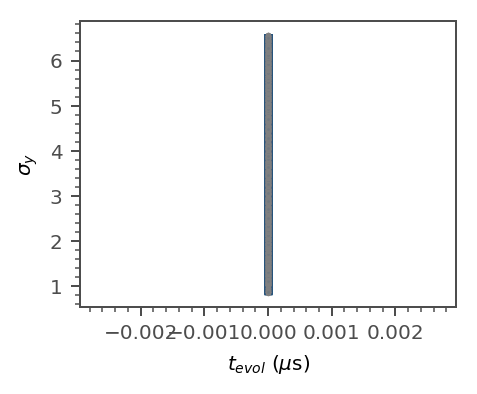

In [628]:

plot_mode = "z1"
offset = 0.1
smooth_data = False

x_unit = r"$\mu$s"

scale_fac_x = 1
scale_fac_y = 1 

try:

    #labels = [r'1']
    #for idx, mes in enumerate(p_raw):
    #    mes['plot_options'] = {'label': labels[idx]}

    plt.figure(figsize=(0.9*3, 0.9*2/3*3.5))   
    plot_multiple_1d(p_raw, n_datas=0.1, plot_err=True,  # use n_datas to manipulse color cycle
                     plot_mode=plot_mode, offset=offset,
                     scale_fac_x=scale_fac_x, scale_fac_y=scale_fac_y,
                     color=plt_settings.color('blue'))   
    plt.show()
except:
    logger.exception("")

In [631]:
def calc_contr(p):
    c = abs(p['data']['z1'] - p['data']['z1'][0])
    dc = np.sqrt(p['data']['std1']**2 + p['data']['std1'][0]**2)
    
    return c, dc

calc_contr(p_raw[0])

(0     0.000000
1     0.027906
2     0.050652
3     0.058152
4     0.079692
5     0.114798
6     0.159544
7     0.169315
8     0.204739
9     0.222528
10    0.235594
11    0.220963
12    0.209468
13    0.186900
14    0.165588
15    0.132760
16    0.116377
17    0.078411
18    0.048436
19    0.028442
20    0.019534
21    0.020961
22    0.021925
23    0.044353
24    0.062349
25    0.089489
26    0.115743
27    0.168588
28    0.190052
29    0.210747
        ...   
45    0.079848
46    0.115021
47    0.142476
48    0.164237
49    0.200493
50    0.199408
51    0.219483
52    0.219153
53    0.193971
54    0.173460
55    0.153580
56    0.112038
57    0.069946
58    0.047546
59    0.032688
60    0.025718
61    0.008836
62    0.035177
63    0.022385
64    0.051381
65    0.086786
66    0.109575
67    0.136820
68    0.172737
69    0.193279
70    0.210835
71    0.217347
72    0.202636
73    0.197261
74    0.198397
Name: z1, Length: 75, dtype: float64, 0     0.011429
1     0.011320
2     0.011266
3

In [634]:
contrs, dcontrs, assyms = [], [], []
rabis = []

for p in p_raw:

    contr, dcontr = calc_contr(p)
    asym = contr[1] + contr[2] - contr[3]
    
    t_rabis_1 = float(p['exp_params']['rabi_period'])
    t_rabis_2 = float(p['exp_params']['rabi_period_mw_2'])
    omega_rabi = 1/((t_rabis_1+t_rabis_2)/2)
   
    rabis.append(omega_rabi)
    contrs.append(contr)
    dcontrs.append(dcontr)
    assyms.append(asym)
    
    
rabis = np.asarray(rabis)
contrs,dcontrs = np.asarray(contrs), np.asarray(dcontrs)

Traceback (most recent call last):
  File "C:\Users\Setup3-PC\Desktop\qudi\logic\jupyterkernel\qzmqkernel.py", line 679, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-634-7fa6dc53426f>", line 10, in <module>
    t_rabis_2 = float(p['exp_params']['rabi_period_mw_2'])
KeyError: 'rabi_period_mw_2'


In [3794]:
contrs[:,3]

array([0.31008169, 0.31244251, 0.30728361, 0.30970233, 0.31038829,
       0.31059092, 0.30916802, 0.3093808 , 0.30747905, 0.30690801])

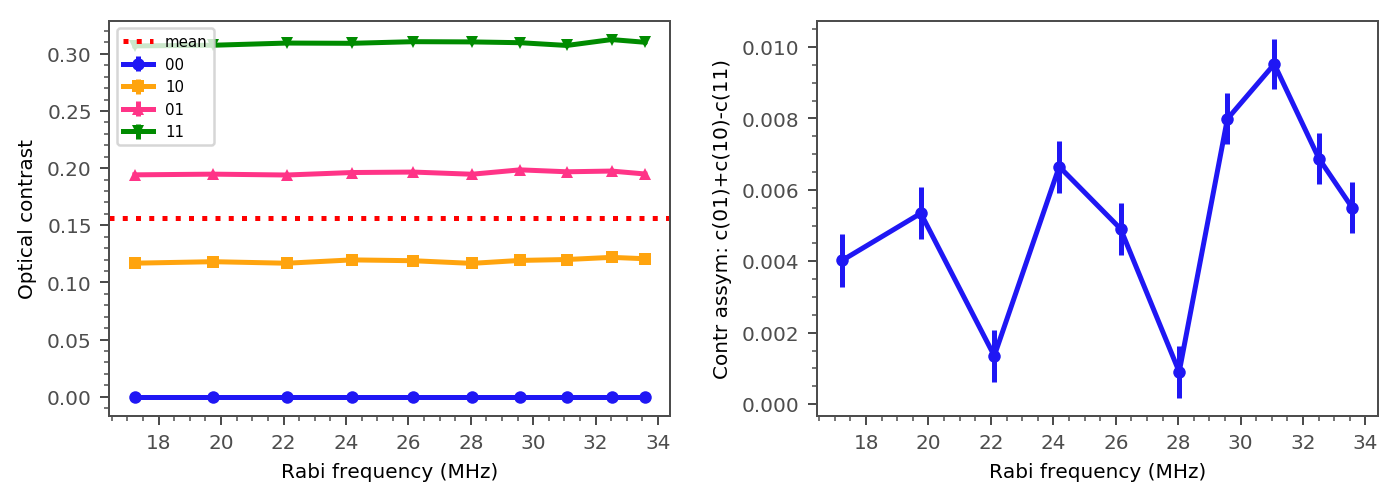

In [3800]:

plt.figure(figsize=(8,3))
plt.subplot(121)

labels = ['00', '10', '01', '11']

for i in range(contrs.shape[1]):
    ax = plt.errorbar(1e-6*rabis, contrs[:,i], yerr=dcontrs[:,i], label=f"{labels[i]}")

plt.axhline(np.mean(contrs), label="mean", linestyle=":", color='red')
plt.legend()

plt.xlabel("Rabi frequency (MHz)")
plt.ylabel("Optical contrast")

# todo: proper error prop
plt.subplot(122)
plt.errorbar(1e-6*rabis, assyms, yerr=dcontrs[:,0])

plt.xlabel("Rabi frequency (MHz)")
plt.ylabel("Contr assym: c(01)+c(10)-c(11)")

plt.tight_layout()
plt.show()

# Fit longterm Rabis

In [1496]:
   
inpaths = [common_params['data_path'] + r"\2023\11", common_params['data_path'] + r"\2023\11"]
#inpath = r"E:\Data\2023\12\20231208\PulsedMeasurement\contr_compbasis_env=sin_3"

fnames = []

for path in inpaths:
    fnames.extend(Tk_file.list_mult_pulsed_mes(path, filter_strs=['rabi', 'measurement.dat'], incl_subdir=True))

fnames_filtered = []
for f in fnames:
    if 'pscale=' in os.path.basename(f):
        pscale = float(extract_num_from_path(f)[-2])
        if pscale < 0.8:
            continue
        fnames_filtered.append(f)
        
    else:
        fnames_filtered.append(f)
    
fnames = fnames_filtered
len(fnames)

50

In [1493]:
[os.path.basename(f) for f in fnames_filtered]

['20231106-0918-23_rabi_shaped_A_pulsed_measurement.dat', '20231106-0920-37_rabi_shaped_B_pulsed_measurement.dat', '20231111-1027-33_rabi_shaped_A_pulsed_measurement.dat', '20231111-1029-21_rabi_shaped_B_pulsed_measurement.dat', '20231116-1003-56_rabi_shaped_A_pulsed_measurement.dat', '20231116-1004-43_rabi_shaped_B_pulsed_measurement.dat', '20231117-1149-20_rabi_shaped_A_pulsed_measurement.dat', '20231125-0039-01_rand_benchmark_pscale=0.82_idx=6_pulsed_measurement.dat', '20231125-0057-23_rand_benchmark_pscale=0.88_idx=7_pulsed_measurement.dat', '20231125-0115-44_rand_benchmark_pscale=0.94_idx=8_pulsed_measurement.dat', '20231125-0134-06_rand_benchmark_pscale=1.00_idx=9_pulsed_measurement.dat', '20231124-1549-50_rabi_shaped_A_pulsed_measurement.dat', '20231124-1552-01_rabi_shaped_B_pulsed_measurement.dat', '20231125-0022-03_rabi_fine_pscale=0.82_idx=6_pulsed_measurement.dat', '20231125-0023-26_rabi_fine_B_pscale=0.82_idx=6_pulsed_measurement.dat', '20231125-0028-39_deer_dd_XY8-4_init=0

In [1550]:
p_raw  = []

for f in fnames:
    p_i = Tk_file.load_pulsed_result(f)
    if 'experiment' in p_i['exp_params'].keys():
        p_raw.append(p_i)
        
l

In [1565]:
p_raw = [p for p in p_raw if 'rabi' in p['exp_params']['experiment']]

[p['date'] for p in p_raw]

[Timestamp('2023-11-06 09:18:23'), Timestamp('2023-11-06 09:20:37'), Timestamp('2023-11-11 10:27:33'), Timestamp('2023-11-11 10:29:21'), Timestamp('2023-11-16 10:03:56'), Timestamp('2023-11-16 10:04:43'), Timestamp('2023-11-17 11:49:20'), Timestamp('2023-11-24 15:49:50'), Timestamp('2023-11-24 15:52:01'), Timestamp('2023-11-25 00:22:03'), Timestamp('2023-11-25 00:23:26'), Timestamp('2023-11-25 00:40:25'), Timestamp('2023-11-25 00:41:48'), Timestamp('2023-11-25 00:58:46'), Timestamp('2023-11-25 01:00:10'), Timestamp('2023-11-25 01:17:07'), Timestamp('2023-11-25 01:18:31'), Timestamp('2023-11-06 09:18:23'), Timestamp('2023-11-06 09:20:37'), Timestamp('2023-11-11 10:27:33'), Timestamp('2023-11-11 10:29:21'), Timestamp('2023-11-16 10:03:56'), Timestamp('2023-11-16 10:04:43'), Timestamp('2023-11-17 11:49:20'), Timestamp('2023-11-24 15:49:50'), Timestamp('2023-11-24 15:52:01'), Timestamp('2023-11-25 00:22:03'), Timestamp('2023-11-25 00:23:26'), Timestamp('2023-11-25 00:40:25'), Timestamp('20

In [1688]:
y_val_idx = None
x_val = "Time"
x_unit = "s"
scale_fac_x = [1]
scale_fac_y = [1e9, 1e-6, 1e-6]
fit_on = 'z1'
fit_meth = 'sine'
fit_vals = ['Contrast', 'Period', 'None']
fit_units = ['ns','%', 'MHz']
fit_settings = None
calc_dxdy_fromto = [False, False, False]
#"""

if fit_settings:
    for mes in p_raw:
        mes['fit_settings'] = fit_settings

        
x, y, y2, y3, dy = pulsed_series_2_1d_fit_array(p_raw, 
                                        fit_meth=fit_meth, fit_on=fit_on, fit_vals=fit_vals,
                                        idx_var_x=y_val_idx, ordered_x=True)

#ampl_delta_deer = p_raw[0]['fit_res']['Amplitude']['value']
#f_deer_90 = mes['fit_res']['Frequency']['value']/(2*8*mes['exp_params']['dd_order'])
#df_deer_90 = mes['fit_res']['Frequency']['error']/(2*8*mes['exp_params']['dd_order'])
#f"DEER frequency: {1e-3*f_deer_90} +- {1e-3*df_deer_90} kHz", control_qubit_state


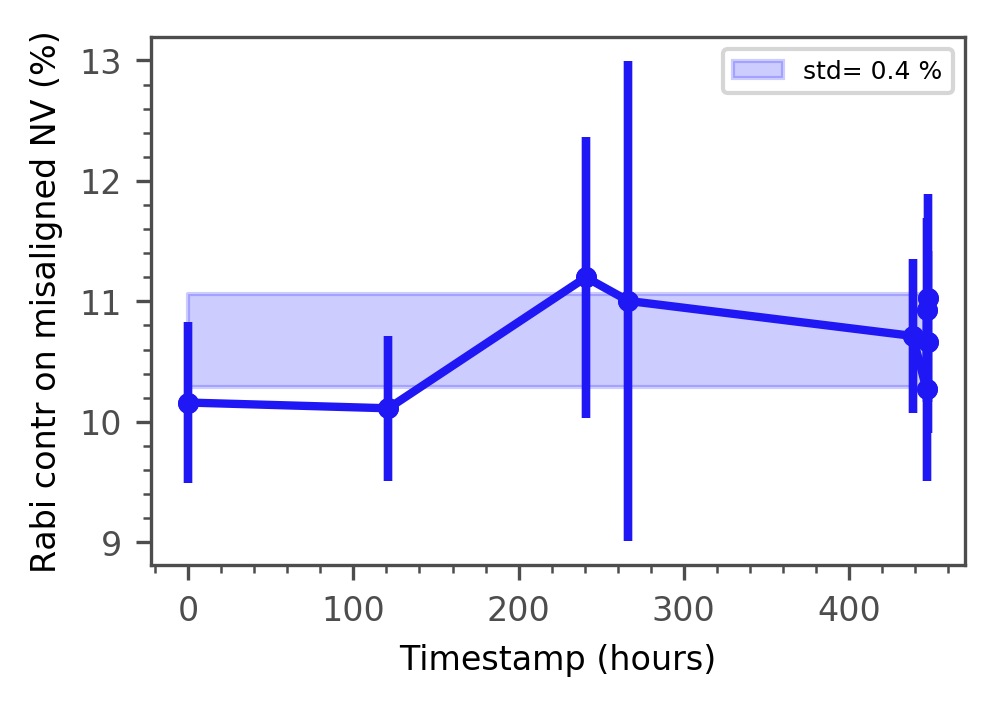

In [1742]:
zipped = list(filter(lambda x: x[1] < 15, zip(x, y, dy)))


x, y, dy = [s[0] for s in zipped], [s[1] for s in zipped], [s[2] for s in zipped]
y_std = np.std(y)
y_mean = np.mean(y)


plt.errorbar(np.asarray(x)/3600, y, dy)
plt.fill_between([0, np.max(x)/3600], y_mean-y_std, y_mean+y_std, alpha=0.2,
                 color='blue', label=f'std= {y_std:.1f} %')

plt.ylabel("Rabi contr on misaligned NV (%)")
plt.xlabel("Timestamp (hours)")

plt.legend()
#plt.xlim([445,450])

plt.show()

In [1715]:
y_std

0.38254680181348333